# Building a 5000 dimensional Logistic Regression and Softmax Regression Sentiment Classifier Based on the Netflix Large Movie Review dataset
The final exercise in Chapter 4 suggests implementing a final project for sentiment analysis. "Sentiment analysis can be considered a binary classification problem. The input is natural language text, and the output is a binary decision that infers positive or negative sentiment." The chapter end suggests taking a look at some datasets in particular the [Large Movie Review Dataset](http://mng.bz/60nj). The excercise also suggests visiting the Kaggle challenge for [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial). 

The Kaggle tutorial is excellent, and I've borrowed big pieces from it. The main differences in the Kaggle tutorial are that they use Scikit-Learn and Random Forrest, and there is no Tensorflow in it. They also use Pandas and assume that the train data is a 25000 * 5000 column Pandas data frame, and that each vertical slice / column in the frame is the full term frequency feature set counts for word X1, word X2.... word XN.

I've made a few changes to the tutorial besides using Tensorflow. I outline them below:

   1. Instead of using [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), I used [Tika Python](http://github.com/chrismattmann/tika-python) to clean the review text. Should be obvious why...
   2. I added [TQDM](https://github.com/tqdm/tqdm) progress bars on the most important iterations. 
   3. I added some plots here and there, including looking at the term frequency distribution for the first 100 words in the 5000 word vocabulary, and a plot for the ROC curve.
   4. I added computation of precision and recall, and TP, TN, FP, FN
   5. I added saving for the model weights. 
   
I have a feeling I made this harder than it needed to be &#9786; That said, I couldn't even visualize based on the example given in the book for 2d logistic regresion what 5000d logistic regression looked like. So, I made a visual of it to hopefully help others when they are similarly thinking about it. I think once I learn more about Tensorflow, I will be able to clean this code up some more too. 

<img src="figs/ch04-final-bow-model.png" width="400" height="200" alt="Bag of Word Model in 5000 dimensions"/>

Here are some immensely useful references I found along the way. FWIW, my Nd logreg classifier is <b>~87%</b> accurate. The softmax reg classifier is <b>~81%</b> Not bad!

## Useful References

   1. [Plot ROC Curve for Binary Classification](https://qiita.com/bmj0114/items/460424c110a8ce22d945) by @bmj0114
   2. [Intersecting Lists and Finding their Indices](https://stackoverflow.com/questions/12570417/python-finding-corresponding-indices-for-an-intersection-of-two-lists) by mgilson
   3. [An Introduction to Bag of Words](https://medium.freecodecamp.org/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04) by Free Code Camp.
   4. [Bag of Words Meets Popcorn Tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview) by Kaggle.
   5. [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) by Stanford.
   6. [What Bag of Words Looks Like Visually](https://bit.ly/2KCTYGe) by Unknown.
   7. [Working with Bag of Words - Tensorflow Cookbook](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/07_Natural_Language_Processing/02_Working_with_Bag_of_Words/02_bag_of_words.ipynb) by Nick F. Mcclure.


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tika import parser
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
import re
import math
from tqdm import tqdm_notebook as tqdm
from os import listdir
from os.path import isfile, join
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package movie_review

True

In [2]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = parser.from_buffer( "<html>" + raw_review + "</html>" )["content"]
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [3]:
train = pd.read_csv("word2vec-nlp-tutorial/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [4]:
train.shape

(25000, 3)

In [5]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [6]:
train.head()

id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...

In [7]:
parsed = parser.from_buffer("<html>"+train["review"][0]+"</html>")
print(train["review"][0])
print(parsed["content"])

2019-04-17 11:48:29,761 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [8]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in tqdm(range( 0, num_reviews )):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"][i] ) )

In [9]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

In [10]:
print(train_data_features.shape)

(25000, 5000)


In [11]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print("size %d %s " % (len(vocab), vocab))

size 5000 ['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'abysmal', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'accompanied', 'accomplished', 'according', 'account', 'accuracy', 'accurate', 'accused', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activities', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'adaptation', 'adaptations', 'adapted', 'add', 'added', 'adding', 'addition', 'adds', 'adequate', 'admire', 'admit', 'admittedly', 'adorable', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertising', 'advice', 'advise', 'affair', 'affect', 'affected', 'afford', 'aforementioned', 'afraid', 'africa', 'african', 'afternoon', 'afterwards', 'age', 'aged', 'agent', 'agents', 'ages', 'aging', 

In [12]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print("%d, %s" % (count, tag))

187, abandoned
125, abc
108, abilities
454, ability
1259, able
85, abraham
116, absence
83, absent
352, absolute
1485, absolutely
306, absurd
192, abuse
91, abusive
98, abysmal
297, academy
485, accent
203, accents
300, accept
130, acceptable
144, accepted
92, access
318, accident
200, accidentally
88, accompanied
124, accomplished
296, according
186, account
81, accuracy
284, accurate
123, accused
179, achieve
139, achieved
124, achievement
90, acid
971, across
1251, act
660, acted
6494, acting
3355, action
311, actions
83, activities
2389, actor
4488, actors
1219, actress
369, actresses
394, acts
793, actual
4240, actually
148, ad
303, adam
98, adams
454, adaptation
80, adaptations
154, adapted
810, add
440, added
166, adding
347, addition
337, adds
113, adequate
124, admire
621, admit
134, admittedly
101, adorable
511, adult
376, adults
101, advance
90, advanced
153, advantage
510, adventure
204, adventures
91, advertising
259, advice
90, advise
346, affair
93, affect
113, affected


98, disappoint
917, disappointed
421, disappointing
404, disappointment
320, disaster
175, disbelief
119, disc
266, discover
267, discovered
240, discovers
116, discovery
106, discuss
118, discussion
128, disease
221, disgusting
102, disjointed
150, dislike
79, disliked
754, disney
205, display
99, displayed
114, displays
118, distance
124, distant
84, distinct
107, distracting
82, distribution
108, disturbed
485, disturbing
102, divorce
94, dixon
137, doc
625, doctor
121, documentaries
953, documentary
688, dog
199, dogs
104, doll
169, dollar
200, dollars
96, dolls
85, dolph
86, domestic
98, domino
191, donald
3096, done
115, donna
123, doo
90, doom
104, doomed
432, door
125, doors
142, dorothy
400, double
757, doubt
82, doubts
315, douglas
79, downey
96, downhill
188, downright
197, dozen
103, dozens
702, dr
121, dracula
211, drag
138, dragged
186, dragon
130, drags
89, drake
1412, drama
141, dramas
667, dramatic
198, draw
114, drawing
430, drawn
118, draws
240, dreadful
663, dream
4

261, magnificent
84, maid
90, mail
2264, main
393, mainly
202, mainstream
93, maintain
927, major
238, majority
8025, make
167, maker
490, makers
4204, makes
206, makeup
2962, making
666, male
95, mall
80, malone
5982, man
272, manage
425, managed
159, manager
583, manages
121, manhattan
83, maniac
88, manipulative
89, mankind
124, mann
410, manner
161, mansion
6675, many
84, map
79, marc
103, march
114, margaret
175, maria
253, marie
99, mario
86, marion
645, mark
218, market
84, marketing
120, marks
417, marriage
590, married
226, marry
93, mars
80, marshall
328, martial
367, martin
90, marty
160, marvelous
568, mary
222, mask
79, masks
162, mass
145, massacre
83, masses
192, massive
454, master
87, masterful
613, masterpiece
85, masterpieces
107, masters
594, match
89, matched
101, matches
122, mate
761, material
197, matrix
226, matt
1127, matter
224, matters
157, matthau
115, matthew
182, mature
215, max
3387, may
2342, maybe
96, mayor
83, mclaglen
1683, mean
473, meaning
145, mea

183, rolling
107, roman
694, romance
856, romantic
117, romero
81, romp
183, ron
945, room
99, rooms
87, rooney
122, root
82, roots
244, rose
82, ross
96, roth
96, rotten
186, rough
244, round
201, routine
132, row
228, roy
87, royal
90, rubber
275, rubbish
95, ruby
203, ruin
227, ruined
84, ruins
86, rukh
188, rule
231, rules
1219, run
992, running
513, runs
110, rural
139, rush
138, rushed
208, russell
79, russia
302, russian
121, ruth
101, ruthless
224, ryan
84, sabrina
127, sacrifice
996, sad
112, sadistic
575, sadly
112, sadness
227, safe
98, safety
101, saga
2196, said
246, sake
135, sally
456, sam
125, samurai
188, san
174, sandler
98, sandra
276, santa
94, sappy
194, sarah
293, sat
128, satan
261, satire
106, satisfied
87, satisfy
216, satisfying
220, saturday
129, savage
1023, save
276, saved
143, saves
276, saving
3168, saw
5396, say
946, saying
1110, says
210, scale
219, scare
98, scarecrow
304, scared
189, scares
989, scary
183, scenario
5383, scene
407, scenery
5213, scene

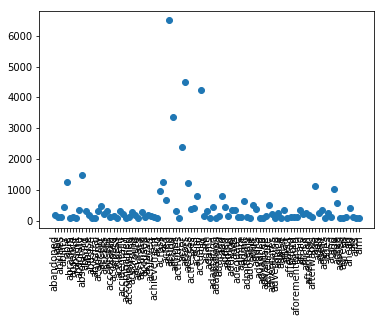

In [13]:
# plot the word count for first 100 words
plt.scatter(vocab[0:99], dist[0:99])
plt.xticks(vocab[0:99], rotation='vertical')
plt.show()

In [14]:
# set up Tensorflow nD logistic regression
learning_rate = 0.1
training_epochs = 2000

In [15]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [16]:
Y = tf.placeholder(tf.float32, shape=(None,), name="y")
w = tf.Variable([0.] * (len(train_data_features)+1), name="w", trainable=True)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
ys = train['sentiment'].values

In [18]:
Xs = {}
for i in range(train_data_features.shape[1]):
    Xs["X"+str(i)] = tf.placeholder(tf.float32, shape=(None,), name="x"+str(i))

In [19]:
linear = w[0]
for i in range(0, train_data_features.shape[1]):
    linear = linear + (w[i+1] * Xs["X"+str(i)])
y_model = tf.sigmoid(linear)

In [20]:
cost = tf.reduce_mean(-tf.log(y_model * Y + (1 - y_model) * (1 - Y)))
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [21]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    prev_err = 0
    for epoch in tqdm(range(training_epochs)):
        feed_dict = {}
        for i in range(train_data_features.shape[1]):
            feed_dict[Xs["X"+str(i)]] = train_data_features[:, i, None].reshape(len(train_data_features))
        feed_dict[Y] = ys
        err, _ = sess.run([cost, train_op], feed_dict=feed_dict)
        print(epoch, err)
        if abs(prev_err - err) < 0.0001:
            break
        prev_err = err
    
    w_val = sess.run(w, feed_dict)
    save_path = saver.save(sess, "./en-netflix-binary-sentiment.ckpt")

0 0.6931475
1 0.68367267
2 0.67517424
3 0.6673778
4 0.6601468
5 0.6533886
6 0.6470343
7 0.64103085
8 0.6353368
9 0.62991923
10 0.62475115
11 0.6198105
12 0.6150785
13 0.6105392
14 0.6061786
15 0.6019846
16 0.59794647
17 0.59405404
18 0.5902991
19 0.58667326
20 0.5831693
21 0.5797805
22 0.5765007
23 0.5733241
24 0.57024544
25 0.5672598
26 0.5643625
27 0.5615493
28 0.5588163
29 0.55615956
30 0.5535756
31 0.55106133
32 0.5486133
33 0.546229
34 0.54390526
35 0.54163986
36 0.53943014
37 0.537274
38 0.535169
39 0.5331134
40 0.5311051
41 0.52914226
42 0.5272231
43 0.5253461
44 0.5235097
45 0.5217122
46 0.5199523
47 0.51822865
48 0.51654017
49 0.5148855
50 0.5132633
51 0.51167256
52 0.5101124
53 0.5085817
54 0.5070795
55 0.50560474
56 0.5041569
57 0.5027348
58 0.50133777
59 0.499965
60 0.49861583
61 0.49728957
62 0.49598548
63 0.49470282
64 0.4934411
65 0.4921997
66 0.49097803
67 0.48977554
68 0.48859173
69 0.4874259
70 0.48627788
71 0.48514712
72 0.4840329
73 0.482935
74 0.481853
75 0.4807864

569 0.3361943
570 0.3360846
571 0.33597508
572 0.33586586
573 0.3357568
574 0.3356481
575 0.33553946
576 0.3354311
577 0.33532292
578 0.335215
579 0.33510736
580 0.33499983
581 0.3348925
582 0.33478546
583 0.33467856
584 0.334572
585 0.3344655
586 0.33435938
587 0.3342533
588 0.33414757
589 0.33404186
590 0.3339366
591 0.3338314
592 0.3337264
593 0.3336217
594 0.3335171
595 0.33341283
596 0.33330867
597 0.3332047
598 0.33310097
599 0.3329974
600 0.33289415
601 0.33279103
602 0.33268812
603 0.33258536
604 0.3324828
605 0.33238044
606 0.3322783
607 0.33217642
608 0.33207464
609 0.33197314
610 0.33187172
611 0.3317706
612 0.3316696
613 0.3315689
614 0.33146828
615 0.33136788
616 0.33126768
617 0.33116767
618 0.3310678


In [22]:
print(w_val)
print(np.max(w_val))

[ 0.0028774  -0.00082148  0.01867105 ...  0.          0.
  0.        ]
0.49940136


In [23]:
def predict(test_review, vocab, weights, threshold=0.5):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    # our log reg model
    test_linear = weights[0]
    for i in range(0, train_data_features.shape[1]):
        test_linear = test_linear + (weights[i+1] * test_feature_vec[i])
    y_test = sigmoid(test_linear)
    
    # here it is the prediction
    return np.greater(y_test, threshold).astype(float)

In [24]:
test = pd.read_csv("word2vec-nlp-tutorial/testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [25]:
test.head()

id                                             review
0  "12311_10"  "Naturally in a film who's main themes are of ...
1    "8348_2"  "This movie is a disaster within a disaster fi...
2    "5828_4"  "All in all, this is a movie for kids. We saw ...
3    "7186_2"  "Afraid of the Dark left me with the impressio...
4   "12128_7"  "A very accurate depiction of small time mob l...

In [26]:
#try it out on new data
new_neg_review = "Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!"
new_pos_review = "I think that this is a fantastic movie, it really "

In [27]:
new_neg_review_c = review_to_words(new_neg_review)
new_pos_review_c = review_to_words(new_pos_review)
print(new_neg_review_c)
print(new_pos_review_c)         

man movie really sucked terrible could possibly watch movie
think fantastic movie really


In [28]:
predict(new_neg_review, vocab, w_val)

0.0

In [29]:
predict(new_pos_review, vocab, w_val)

1.0

In [30]:
# Generate Kaggle Submission
# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
result = [] 
for i in tqdm(range(0, num_reviews)):
    r = predict(test["review"][i], vocab, w_val)
    result.append(r)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

In [31]:
# test on unseen samples from IMDB movie reviews and compute TP, TN, FP, FN and precision + accuracy
pos_test_path = "aclImdb/test/pos/"
neg_test_path = "aclImdb/test/neg/"
only_pos_files = [f for f in listdir(pos_test_path) if isfile(join(pos_test_path, f))]
only_neg_files = [f for f in listdir(neg_test_path) if isfile(join(neg_test_path, f))]

only_pos_file_contents = []
for i in range(0, len(only_pos_files)):
    with open(pos_test_path + only_pos_files[i], 'r') as file:
        r_data = file.read()
        only_pos_file_contents.append(r_data)
        
only_neg_file_contents = []
for i in range(0, len(only_neg_files)):
    with open(neg_test_path + only_neg_files[i], 'r') as file:
        r_data = file.read()
        only_neg_file_contents.append(r_data)

In [32]:
TP = 0.
TN = 0.
FP = 0.
FN = 0.
predictions_test = np.zeros(len(only_pos_file_contents) * 2)

In [33]:
for i in tqdm(range(0, len(only_pos_file_contents))):
    sent = predict(only_pos_file_contents[i], vocab, w_val)
    predictions_test[i] = sent
    if sent == 1.:
        TP += 1
    elif sent == 0.:
        FN += 1

In [34]:
for i in tqdm(range(0, len(only_neg_file_contents))):
    sent = predict(only_neg_file_contents[i], vocab, w_val)
    predictions_test[len(only_neg_file_contents)+i] = sent
    if sent == 0.:
        TN += 1
    elif sent == 1.:
        FP += 1

In [35]:
precision = (TP) / (TP + FP)

In [36]:
recall = (TP) / (TP + FN)

In [37]:
print("precision %f recall %f" % (precision, recall))

precision 0.859793 recall 0.875200


In [38]:
print(TP)
print(TN)
print(FP)
print(FN)

10940.0
10716.0
1784.0
1560.0


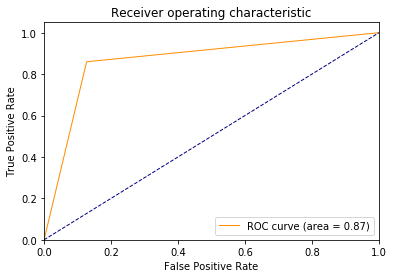

In [39]:
outcome_test = np.ones(len(only_pos_files))
outcome_test = np.append(outcome_test, np.zeros(len(only_neg_files)))

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Try Softmax Regression
Chapter 4 in the book teaches us also about softmax regression. The big difference with softmax is that we can predict more than 2 classes (N output classes) and to do so, we set up an equation like Y = WX + B, where W are the weights (num_features * num_labels), X is the input feature data (num_train * num_features), and B the offset constant (num_labels) and Y is the one-hot encoded class labels we are trying to predict (num_labels). Y, X, W and B are matrices. The book also teaches us to use batch training, so we'll set all that up here. One interesting property is that Softmax natively provides class confidence for each prediction. This could be done with n-d logistic regression by estimating tthe difference from absolute 0 or 1 for the predicted y_model value and then divide by 0.5.

In [40]:
learning_rate = 0.01
training_epochs = 1000
num_labels = 2
batch_size = 100

In [41]:
def softmax_feat_vec_from_review(test_review, vocab):
    #assumption: review is clean
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    
    ex_data_features = n_vectorizer.fit_transform([test_review])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    
    return test_feature_vec


In [42]:
num_pos_labels = len(train.loc[train['sentiment'] == 1.])
num_neg_labels = len(train.loc[train['sentiment'] == 0.])
lab_mat = []
for i in range(len(train['sentiment'])):
    if train['sentiment'][i] == 1.0:
        #lab_mat = lab_mat + [[1., 0.]]
        lab_mat = lab_mat + [[0., 1.]]
    elif train['sentiment'][i] == 0.0:
        #lab_mat = lab_mat + [[0., 1.]]
        lab_mat = lab_mat + [[1., 0.]]

labels = np.matrix(lab_mat)
print(labels)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [43]:
xs = train_data_features.astype(float)
train_size, num_features = xs.shape
print(xs.shape)
print(labels.shape)

(25000, 5000)
(25000, 2)


In [44]:
#shuffle the labels so that the system doesn't learn that the order of the data matters
arr = np.arange(xs.shape[0])
np.random.shuffle(arr)
xs = xs[arr, :]
labels = labels[arr, :]

In [45]:
X = tf.placeholder("float", shape=[None, num_features])
Y = tf.placeholder("float", shape=[None, num_labels])
W = tf.Variable(tf.zeros([num_features, num_labels]))
b = tf.Variable(tf.zeros([num_labels]))
y_model = tf.nn.softmax(tf.matmul(X, W) + b)

In [46]:
# sometimes the result of y_model can be 0, and log0 is NaN, so account for it
# see: https://stackoverflow.com/questions/38538635/tensorflow-returning-nan-when-implementing-logistic-regression
cost = -tf.reduce_sum(Y * tf.log(tf.maximum(y_model, 1e-15))) 
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [47]:
correct_prediction = tf.equal(tf.argmax(y_model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [48]:
test_reviews = []
clean_test_reviews = []
test_reviews.extend(only_pos_file_contents)
test_reviews.extend(only_neg_file_contents)

In [49]:
for i in tqdm(range(len(test_reviews))):
    test_review_c = review_to_words(test_reviews[i])
    clean_test_reviews.append(test_review_c)

In [50]:
test_xs = np.zeros((len(clean_test_reviews), num_features))
for i in tqdm(range(len(clean_test_reviews))):
    test_xs[i] = softmax_feat_vec_from_review(clean_test_reviews[i], vocab)

In [51]:
test_xs.shape

(25000, 5000)

In [52]:
test_labels = np.matrix([[0., 1.]] * len(only_pos_file_contents) + [[1., 0.]] * len(only_neg_file_contents))

In [53]:
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for step in tqdm(range(training_epochs * train_size // batch_size)):
        offset = (step * batch_size) % train_size
        batch_xs = xs[offset:(offset + batch_size), :]
        batch_labels = labels[offset:(offset + batch_size)]
        err, _ = sess.run([cost, train_op], feed_dict={X: batch_xs, Y: batch_labels})
        print (step, err)            
    
    W_val = sess.run(W)
    print('w', W_val)
    b_val = sess.run(b)
    print('b', b_val)
    print("accuracy", accuracy.eval(feed_dict={X: test_xs, Y: test_labels}))
    save_path = saver.save(sess, "./ch4-softmax-netflix-sentiment.ckpt")
    print("Model saved in path: %s" % save_path)

0 69.31473
1 81.95078
2 439.29446
3 440.78925
4 531.39325
5 336.54324
6 395.68082
7 166.1397
8 115.548935
9 179.68938
10 343.5876
11 287.1848
12 252.55153
13 143.18738
14 182.07874
15 344.3544
16 87.33469
17 102.11169
18 45.44025
19 104.01517
20 86.24691
21 179.15163
22 106.96136
23 56.965572
24 99.84271
25 56.869293
26 75.119064
27 63.438435
28 60.237747
29 50.051445
30 104.176735
31 81.986145
32 135.16096
33 56.744072
34 64.84165
35 91.69401
36 87.53953
37 64.98826
38 90.71722
39 132.93219
40 134.65297
41 176.12334
42 267.54327
43 234.52429
44 189.34238
45 144.58829
46 86.12567
47 52.623135
48 64.61679
49 56.714684
50 36.35284
51 71.22833
52 42.25643
53 26.545143
54 47.764183
55 49.582447
56 104.26396
57 60.93383
58 45.525093
59 48.775204
60 40.958862
61 31.85308
62 76.37571
63 77.5505
64 45.462006
65 73.026474
66 59.617203
67 61.210342
68 40.949516
69 51.549892
70 50.989952
71 32.143112
72 46.338737
73 31.894238
74 47.82625
75 65.472725
76 33.03512
77 42.60811
78 36.086285
79 32.804

669 44.322105
670 40.050674
671 26.737053
672 25.484627
673 31.1086
674 23.205437
675 33.536484
676 23.51207
677 25.843431
678 17.76981
679 16.474653
680 17.061592
681 24.028212
682 14.009443
683 32.745373
684 33.67987
685 33.062355
686 31.067083
687 14.447351
688 23.438175
689 30.463297
690 42.92943
691 36.239773
692 23.743687
693 49.14588
694 26.627117
695 19.416216
696 14.12696
697 31.899477
698 27.76104
699 32.762337
700 16.671078
701 17.694963
702 15.662876
703 25.837412
704 29.213058
705 31.268974
706 36.412872
707 31.37352
708 27.230198
709 19.807304
710 33.521526
711 21.248539
712 25.419725
713 26.033377
714 24.997013
715 26.307598
716 30.709408
717 41.91206
718 25.61033
719 33.83146
720 22.224968
721 33.40759
722 32.022675
723 30.862309
724 36.52337
725 40.176506
726 21.80464
727 28.247654
728 26.50578
729 21.369078
730 23.81351
731 18.80997
732 27.29789
733 22.14664
734 40.41195
735 29.84576
736 25.792694
737 46.133038
738 34.547348
739 32.78199
740 20.145481
741 14.252003
74

1255 23.427704
1256 34.420177
1257 37.67507
1258 17.084541
1259 22.781824
1260 25.937094
1261 23.579859
1262 29.851246
1263 36.017185
1264 19.510172
1265 31.114677
1266 24.453293
1267 18.133755
1268 18.53955
1269 16.899956
1270 16.497028
1271 29.94541
1272 18.380136
1273 21.818645
1274 49.347984
1275 11.510803
1276 18.665493
1277 37.846054
1278 18.85252
1279 22.102715
1280 43.040443
1281 46.94117
1282 32.44121
1283 14.800218
1284 13.481185
1285 26.638704
1286 19.444239
1287 45.281418
1288 26.061264
1289 22.825043
1290 28.44759
1291 25.529827
1292 15.85926
1293 21.032364
1294 16.733751
1295 21.541252
1296 16.118767
1297 16.0428
1298 18.617224
1299 19.15709
1300 12.931782
1301 21.86449
1302 12.361113
1303 7.594834
1304 13.652253
1305 14.103449
1306 33.13938
1307 15.952444
1308 21.751093
1309 16.533913
1310 11.315224
1311 18.820736
1312 26.724213
1313 26.929298
1314 33.988865
1315 33.090584
1316 15.612762
1317 15.67797
1318 15.209596
1319 6.0668044
1320 16.98151
1321 12.599501
1322 25.938

1868 19.481384
1869 21.615685
1870 38.07312
1871 23.136177
1872 17.580357
1873 28.311367
1874 32.449165
1875 24.059011
1876 11.927464
1877 16.645441
1878 15.109248
1879 19.907898
1880 19.82856
1881 13.671082
1882 21.62243
1883 22.382408
1884 24.323696
1885 26.905987
1886 23.08514
1887 16.197773
1888 20.250723
1889 10.915904
1890 14.994622
1891 23.028296
1892 15.260607
1893 10.851522
1894 13.209806
1895 20.273766
1896 14.353771
1897 21.71217
1898 21.72578
1899 16.459898
1900 30.628527
1901 27.765644
1902 27.68536
1903 32.777046
1904 22.303736
1905 27.029797
1906 20.208641
1907 17.89902
1908 17.23777
1909 22.81365
1910 23.76462
1911 29.191628
1912 25.074272
1913 20.630112
1914 24.432648
1915 23.333767
1916 9.49354
1917 17.211296
1918 14.8921175
1919 25.258043
1920 26.92579
1921 24.027655
1922 25.40256
1923 22.41668
1924 14.926502
1925 25.917267
1926 13.240065
1927 19.51765
1928 13.542366
1929 17.29379
1930 15.398123
1931 18.816536
1932 11.06135
1933 30.639496
1934 18.03317
1935 26.959309

2454 16.334858
2455 22.063648
2456 14.842317
2457 15.436106
2458 23.94654
2459 13.82432
2460 22.113565
2461 22.84433
2462 26.846329
2463 16.728909
2464 19.248642
2465 15.261481
2466 19.924198
2467 35.108025
2468 19.664267
2469 28.533642
2470 14.052372
2471 26.078207
2472 16.114176
2473 17.716707
2474 21.232231
2475 15.980723
2476 16.322968
2477 20.337204
2478 20.9979
2479 16.286776
2480 16.19823
2481 16.455229
2482 22.148726
2483 17.73551
2484 30.042585
2485 21.126978
2486 19.790306
2487 34.90226
2488 21.699526
2489 20.286285
2490 15.3070755
2491 11.57315
2492 18.61699
2493 17.445877
2494 19.695923
2495 22.948936
2496 21.318432
2497 23.543543
2498 19.990376
2499 19.109112
2500 24.874403
2501 13.62381
2502 16.993904
2503 14.792414
2504 13.400518
2505 15.390676
2506 25.436096
2507 25.284721
2508 16.439259
2509 20.071362
2510 21.313267
2511 18.334234
2512 28.986004
2513 26.451218
2514 15.083836
2515 25.205065
2516 14.497686
2517 21.582699
2518 15.134264
2519 14.086299
2520 15.104194
2521 

3034 11.447367
3035 24.214182
3036 15.2004795
3037 36.120285
3038 18.585724
3039 20.272182
3040 23.846245
3041 16.761463
3042 12.40526
3043 15.9302
3044 13.409152
3045 13.041535
3046 13.479918
3047 11.565739
3048 14.324059
3049 15.9453335
3050 10.4820175
3051 20.559958
3052 10.338684
3053 7.005431
3054 10.163586
3055 11.928682
3056 25.453636
3057 13.871178
3058 18.58524
3059 14.482862
3060 9.557507
3061 13.630608
3062 20.18553
3063 25.054981
3064 27.017757
3065 29.52884
3066 12.184258
3067 14.507931
3068 14.44725
3069 6.142334
3070 15.871501
3071 9.749976
3072 21.108892
3073 10.738178
3074 20.091347
3075 40.109314
3076 16.67013
3077 12.739609
3078 20.270771
3079 21.236929
3080 31.064165
3081 23.762444
3082 27.153997
3083 18.688356
3084 16.360468
3085 23.95573
3086 24.705566
3087 28.19883
3088 37.951267
3089 14.09116
3090 18.288551
3091 13.564821
3092 14.3734
3093 14.914752
3094 23.203848
3095 18.940468
3096 21.05355
3097 15.897436
3098 13.020611
3099 13.928179
3100 35.71374
3101 24.132

3591 12.107792
3592 15.014172
3593 15.297067
3594 20.25887
3595 18.043566
3596 21.281357
3597 14.408076
3598 12.999109
3599 13.69008
3600 31.66849
3601 23.480022
3602 17.540018
3603 22.750315
3604 22.450752
3605 13.949448
3606 12.509568
3607 25.370182
3608 22.278782
3609 20.62345
3610 28.661926
3611 12.796726
3612 20.93529
3613 28.142796
3614 15.0129795
3615 16.513714
3616 35.84272
3617 26.60363
3618 13.303499
3619 12.569571
3620 29.216217
3621 20.774002
3622 16.258698
3623 24.455063
3624 19.066387
3625 11.474552
3626 10.909398
3627 15.776319
3628 15.003143
3629 16.634317
3630 17.204115
3631 11.281245
3632 17.724289
3633 19.258331
3634 23.734104
3635 23.92567
3636 22.181637
3637 9.80568
3638 17.579126
3639 9.761438
3640 13.862261
3641 19.52094
3642 11.353645
3643 10.022389
3644 10.618058
3645 13.676237
3646 10.9916935
3647 17.790802
3648 17.723787
3649 12.743605
3650 26.85038
3651 21.165161
3652 20.10535
3653 29.354588
3654 15.576878
3655 23.466331
3656 18.187187
3657 11.227221
3658 12

4154 14.686888
4155 23.1623
4156 17.819435
4157 13.1922035
4158 13.266798
4159 17.20224
4160 20.105164
4161 22.22153
4162 15.490414
4163 15.050871
4164 19.193167
4165 19.86229
4166 6.8628974
4167 11.03434
4168 12.694044
4169 22.994724
4170 21.874836
4171 16.347328
4172 18.725338
4173 19.122862
4174 11.866783
4175 23.426884
4176 9.517679
4177 15.517084
4178 9.1915245
4179 11.859463
4180 11.764793
4181 14.430195
4182 8.101743
4183 22.749458
4184 12.615582
4185 21.927387
4186 17.450092
4187 11.221993
4188 19.782831
4189 29.616428
4190 28.602741
4191 20.753939
4192 10.555808
4193 20.235962
4194 17.50782
4195 8.814228
4196 9.14847
4197 16.874868
4198 18.927116
4199 17.831738
4200 11.445381
4201 13.434327
4202 9.969563
4203 19.63102
4204 15.069228
4205 20.861557
4206 13.778072
4207 12.560239
4208 17.332111
4209 13.62359
4210 23.27827
4211 16.067947
4212 20.455118
4213 13.437778
4214 14.727658
4215 13.543578
4216 16.817547
4217 32.252747
4218 16.070549
4219 26.008068
4220 13.3559
4221 19.4543

4749 19.46675
4750 25.230436
4751 11.16136
4752 15.291106
4753 10.8341
4754 11.733509
4755 14.348961
4756 23.094463
4757 20.59373
4758 14.8252125
4759 16.127197
4760 18.831146
4761 16.1117
4762 23.042042
4763 21.588966
4764 11.956113
4765 20.27935
4766 11.685909
4767 16.306953
4768 12.023184
4769 12.636873
4770 11.71937
4771 17.81334
4772 14.073359
4773 8.677825
4774 20.795666
4775 7.933592
4776 13.973621
4777 23.451077
4778 15.620657
4779 12.8671465
4780 19.07296
4781 22.860424
4782 11.818508
4783 10.9315815
4784 11.094833
4785 21.425936
4786 13.727304
4787 33.69294
4788 14.930293
4789 22.70905
4790 19.594696
4791 13.750367
4792 10.723022
4793 12.513742
4794 11.431099
4795 11.785147
4796 11.438518
4797 10.30599
4798 13.011821
4799 12.58799
4800 10.789195
4801 18.681494
4802 9.172923
4803 6.3156466
4804 9.230503
4805 9.88685
4806 24.209251
4807 12.205961
4808 17.750565
4809 12.8731785
4810 9.259735
4811 11.969028
4812 17.473057
4813 24.251305
4814 22.843819
4815 28.64552
4816 10.61554


5345 16.022621
5346 20.058716
5347 12.747049
5348 12.825823
5349 12.175562
5350 27.816757
5351 21.241085
5352 15.322117
5353 20.1669
5354 20.543926
5355 11.6642475
5356 10.996899
5357 25.014742
5358 20.27459
5359 17.567287
5360 25.462864
5361 11.976322
5362 20.257313
5363 25.398975
5364 13.6252165
5365 14.982113
5366 31.920326
5367 23.067999
5368 12.848757
5369 14.804666
5370 27.264751
5371 21.049961
5372 15.678153
5373 23.87236
5374 17.724955
5375 9.409271
5376 10.063183
5377 15.085909
5378 14.721153
5379 15.64479
5380 16.54893
5381 10.351418
5382 16.769972
5383 17.716599
5384 21.356762
5385 22.206268
5386 21.00016
5387 8.831551
5388 17.164227
5389 9.531662
5390 13.658831
5391 18.565216
5392 10.156288
5393 9.821859
5394 9.085757
5395 9.574254
5396 10.437875
5397 14.322229
5398 16.143028
5399 12.190194
5400 25.70763
5401 18.274347
5402 18.183764
5403 27.798414
5404 13.474621
5405 21.244183
5406 18.568874
5407 11.036326
5408 12.239537
5409 16.289959
5410 17.47055
5411 18.387714
5412 14.

5941 18.622126
5942 9.144239
5943 17.865524
5944 16.168324
5945 7.919581
5946 9.057332
5947 14.916876
5948 17.625792
5949 16.558147
5950 11.103981
5951 13.15724
5952 9.38072
5953 18.10529
5954 14.319002
5955 19.44441
5956 11.6516485
5957 11.8946905
5958 15.621409
5959 12.93203
5960 20.510376
5961 16.076763
5962 20.971851
5963 11.478689
5964 12.882458
5965 13.32229
5966 14.844183
5967 30.130754
5968 13.535048
5969 24.436234
5970 12.440072
5971 15.192762
5972 10.711718
5973 15.682259
5974 17.065453
5975 12.596709
5976 13.549936
5977 18.564512
5978 17.053288
5979 10.593108
5980 10.644447
5981 13.373098
5982 21.392334
5983 13.650097
5984 20.041624
5985 15.209931
5986 16.667294
5987 28.422253
5988 14.525125
5989 16.872252
5990 12.10075
5991 9.000608
5992 13.105005
5993 12.830987
5994 17.160797
5995 22.43047
5996 12.465345
5997 17.765413
5998 14.530639
5999 18.725931
6000 25.340912
6001 10.780573
6002 14.27276
6003 9.894654
6004 11.548817
6005 14.392616
6006 21.773205
6007 20.581827
6008 14.

6543 11.151994
6544 10.806547
6545 11.495793
6546 11.401558
6547 9.918081
6548 11.98132
6549 11.647518
6550 10.189586
6551 17.784622
6552 8.289182
6553 5.813774
6554 8.442296
6555 9.187604
6556 22.872374
6557 11.213436
6558 17.372025
6559 12.616645
6560 8.404539
6561 11.369967
6562 15.434383
6563 23.700788
6564 19.224743
6565 26.591337
6566 9.663546
6567 11.082546
6568 13.501062
6569 5.5588937
6570 13.008104
6571 8.227394
6572 15.342951
6573 8.496932
6574 17.523293
6575 35.391315
6576 12.691923
6577 10.366194
6578 17.188377
6579 21.776909
6580 30.575432
6581 19.39214
6582 22.651
6583 15.632591
6584 12.441002
6585 18.95707
6586 20.205519
6587 17.859642
6588 21.49754
6589 12.123588
6590 13.98914
6591 11.247414
6592 13.246931
6593 12.199648
6594 18.530827
6595 15.1821
6596 19.252382
6597 12.476997
6598 12.359139
6599 11.732116
6600 26.59796
6601 19.94022
6602 14.028179
6603 18.594135
6604 19.182756
6605 10.832621
6606 10.637733
6607 24.691715
6608 19.369263
6609 17.324642
6610 24.262299
6

7107 24.832294
7108 19.336733
7109 17.5747
7110 23.671217
7111 11.392055
7112 19.151302
7113 23.508724
7114 12.66417
7115 13.593395
7116 29.551783
7117 21.08963
7118 11.721608
7119 14.162509
7120 25.372887
7121 20.842539
7122 14.784352
7123 23.365517
7124 15.562469
7125 8.326504
7126 9.49033
7127 14.553068
7128 14.593189
7129 15.158996
7130 16.008354
7131 9.458284
7132 16.52808
7133 16.388767
7134 19.995968
7135 21.66007
7136 18.859335
7137 8.757329
7138 16.413649
7139 9.518066
7140 14.084425
7141 18.0932
7142 9.322361
7143 9.839515
7144 9.175047
7145 9.149126
7146 10.195892
7147 13.530424
7148 15.473296
7149 12.177523
7150 25.088127
7151 16.47294
7152 17.853958
7153 26.427917
7154 11.621561
7155 20.034435
7156 19.208267
7157 10.758483
7158 11.543569
7159 15.469254
7160 15.90744
7161 16.387785
7162 12.874288
7163 14.077412
7164 18.010183
7165 17.282595
7166 6.361889
7167 9.41387
7168 12.476483
7169 20.226051
7170 18.351284
7171 14.842346
7172 16.708208
7173 17.441048
7174 10.949759
717

7734 16.790718
7735 11.95596
7736 15.919088
7737 26.983786
7738 12.998531
7739 15.814011
7740 10.677679
7741 8.223851
7742 12.068176
7743 11.557444
7744 16.677162
7745 20.48576
7746 10.530593
7747 15.900948
7748 13.484068
7749 18.830046
7750 24.812555
7751 9.98951
7752 12.734987
7753 9.240948
7754 11.829751
7755 13.8180275
7756 20.190847
7757 20.272614
7758 15.135195
7759 13.751285
7760 18.558762
7761 14.274119
7762 19.827934
7763 19.04482
7764 10.321269
7765 16.809637
7766 8.710907
7767 13.242065
7768 10.084488
7769 11.45029
7770 10.521299
7771 15.874282
7772 11.350309
7773 7.427095
7774 17.946003
7775 7.8792343
7776 12.222761
7777 18.31084
7778 16.150715
7779 11.977928
7780 15.346512
7781 20.421835
7782 9.570807
7783 10.7456665
7784 10.492382
7785 19.669617
7786 12.644742
7787 29.541918
7788 13.194804
7789 22.463682
7790 16.454136
7791 12.84691
7792 9.708592
7793 10.19965
7794 10.048328
7795 10.695452
7796 10.2964735
7797 9.620018
7798 11.578564
7799 10.836719
7800 10.455583
7801 16.

8327 9.682281
8328 16.25795
8329 20.936392
8330 29.944565
8331 17.999037
8332 21.824518
8333 13.714575
8334 11.192228
8335 17.498184
8336 18.180788
8337 15.117529
8338 18.309668
8339 12.985432
8340 13.711212
8341 11.178635
8342 12.757967
8343 11.311064
8344 17.25344
8345 14.275684
8346 18.507841
8347 11.897923
8348 12.460178
8349 11.296875
8350 23.951746
8351 19.2792
8352 12.767518
8353 17.816433
8354 16.954262
8355 9.715351
8356 9.895691
8357 23.665592
8358 18.616245
8359 17.463743
8360 22.09214
8361 11.127474
8362 18.493073
8363 23.306927
8364 12.496708
8365 12.776968
8366 27.916313
8367 19.818626
8368 10.79834
8369 12.299473
8370 24.61908
8371 20.815098
8372 14.040336
8373 23.139187
8374 15.927248
8375 7.8061504
8376 9.4207115
8377 14.058231
8378 14.369573
8379 14.547301
8380 15.773281
8381 9.241055
8382 16.19212
8383 15.767188
8384 18.645744
8385 21.509811
8386 18.11566
8387 8.41563
8388 16.137732
8389 9.391756
8390 13.428546
8391 17.887465
8392 8.676658
8393 9.596106
8394 8.162586

8963 10.052699
8964 11.368601
8965 12.793224
8966 12.949206
8967 26.989517
8968 11.931181
8969 21.563469
8970 10.458302
8971 13.10503
8972 8.789326
8973 15.424526
8974 15.424823
8975 11.571926
8976 11.693825
8977 17.826038
8978 15.795355
8979 8.7829275
8980 8.925272
8981 12.012371
8982 20.393906
8983 12.906581
8984 16.211767
8985 13.934329
8986 15.250878
8987 25.853226
8988 13.054657
8989 15.866888
8990 10.318058
8991 7.935715
8992 11.312456
8993 11.255005
8994 16.191212
8995 19.660843
8996 9.640446
8997 15.172247
8998 12.434385
8999 18.404213
9000 24.373615
9001 10.048723
9002 11.737741
9003 8.924168
9004 11.573085
9005 13.556679
9006 20.0708
9007 19.056744
9008 14.123883
9009 12.842516
9010 18.605297
9011 14.016163
9012 18.572735
9013 17.855932
9014 9.824621
9015 16.735573
9016 8.237357
9017 12.826767
9018 9.8267975
9019 11.253255
9020 10.095182
9021 14.993692
9022 11.046583
9023 7.1844807
9024 17.342598
9025 7.7693815
9026 11.035696
9027 15.968292
9028 15.855515
9029 12.141977
9030 

9554 7.575337
9555 7.921298
9556 21.22916
9557 10.483532
9558 16.585072
9559 12.24061
9560 7.488881
9561 10.6595
9562 13.56929
9563 23.332787
9564 15.775623
9565 24.627178
9566 8.685236
9567 9.95313
9568 12.755105
9569 5.318076
9570 11.72624
9571 7.844679
9572 13.416286
9573 7.8526154
9574 15.272623
9575 32.619465
9576 11.72608
9577 9.809569
9578 16.21649
9579 21.0871
9580 29.596403
9581 18.299036
9582 21.582825
9583 13.473048
9584 11.25119
9585 17.100063
9586 19.224411
9587 15.334991
9588 18.780972
9589 11.262345
9590 12.745386
9591 10.9355345
9592 12.642158
9593 10.917622
9594 16.525633
9595 13.6732235
9596 17.514133
9597 11.707279
9598 11.901144
9599 10.90287
9600 23.838116
9601 17.797634
9602 12.18202
9603 16.720684
9604 16.544796
9605 9.599218
9606 9.956137
9607 23.691542
9608 18.392174
9609 17.08059
9610 22.00089
9611 10.794498
9612 18.227945
9613 22.70484
9614 11.989239
9615 12.079018
9616 26.997814
9617 18.94101
9618 10.564246
9619 12.849339
9620 23.982445
9621 20.39916
9622 13

10152 16.91076
10153 24.20791
10154 10.251102
10155 17.94403
10156 19.3877
10157 10.298496
10158 11.028843
10159 14.709964
10160 14.931829
10161 13.766094
10162 12.006706
10163 11.671488
10164 14.793642
10165 15.959204
10166 5.817186
10167 9.010931
10168 11.640958
10169 18.78674
10170 16.441029
10171 13.915962
10172 15.442244
10173 16.558586
10174 10.390024
10175 23.313986
10176 8.133045
10177 13.807179
10178 7.362351
10179 10.070019
10180 9.21827
10181 11.684434
10182 5.955859
10183 15.688884
10184 9.510001
10185 17.547134
10186 12.24217
10187 8.980843
10188 18.414492
10189 26.438145
10190 22.521193
10191 16.170446
10192 7.557737
10193 14.257969
10194 14.977053
10195 6.746922
10196 7.6660852
10197 11.985548
10198 14.74847
10199 15.145607
10200 10.02009
10201 12.109646
10202 8.205866
10203 16.44477
10204 13.503294
10205 17.668962
10206 11.513304
10207 11.918236
10208 14.145242
10209 11.966921
10210 19.2352
10211 15.914566
10212 18.626335
10213 9.999411
10214 11.525805
10215 12.8612385


10748 12.329645
10749 18.312038
10750 24.08577
10751 9.722931
10752 10.946146
10753 8.934817
10754 11.816117
10755 13.338355
10756 19.415413
10757 18.616081
10758 14.509447
10759 12.411987
10760 18.946915
10761 13.814978
10762 17.9717
10763 17.126896
10764 8.991415
10765 15.430172
10766 7.609865
10767 11.695898
10768 9.320515
10769 11.4139185
10770 9.829
10771 14.5689745
10772 10.497432
10773 7.1869993
10774 16.34313
10775 7.7637825
10776 10.892092
10777 14.792338
10778 16.317883
10779 11.719206
10780 13.464251
10781 19.128927
10782 8.680513
10783 10.353738
10784 10.161803
10785 18.341763
10786 11.816651
10787 26.415968
10788 12.062258
10789 22.203094
10790 14.826813
10791 11.826973
10792 8.71089
10793 9.163377
10794 9.413822
10795 9.72283
10796 9.578093
10797 9.312347
10798 10.470546
10799 9.819578
10800 9.92568
10801 15.505493
10802 6.7112637
10803 4.810435
10804 7.358897
10805 7.330811
10806 21.090637
10807 10.444084
10808 15.608588
10809 11.63058
10810 7.314349
10811 10.240548
1081

11330 29.308628
11331 17.844158
11332 21.180843
11333 12.79604
11334 10.77741
11335 16.790838
11336 17.973667
11337 14.071605
11338 17.807964
11339 11.156478
11340 12.66879
11341 10.988468
11342 11.783138
11343 10.417216
11344 16.296162
11345 13.124517
11346 16.833813
11347 11.175081
11348 11.946641
11349 10.464869
11350 22.417881
11351 17.060905
11352 11.111137
11353 15.9392185
11354 15.369201
11355 8.944354
11356 9.753458
11357 22.915527
11358 17.964012
11359 16.910995
11360 20.73803
11361 10.543827
11362 17.73433
11363 22.146215
11364 11.793657
11365 11.220375
11366 26.185259
11367 17.870647
11368 10.075968
11369 12.260316
11370 23.39581
11371 20.136723
11372 12.789922
11373 22.979214
11374 14.268694
11375 6.9480224
11376 8.886673
11377 13.028896
11378 14.283068
11379 13.656778
11380 15.138954
11381 8.425255
11382 15.569703
11383 14.23085
11384 16.78198
11385 20.680235
11386 16.381868
11387 7.9481916
11388 15.456676
11389 9.496365
11390 13.193579
11391 17.091732
11392 7.407673
11393

11920 15.480154
11921 13.509714
11922 15.406841
11923 16.152739
11924 9.952232
11925 23.252666
11926 7.9367876
11927 13.445679
11928 7.1795435
11929 9.686544
11930 8.521005
11931 11.28795
11932 5.6834435
11933 14.626265
11934 9.182486
11935 16.809875
11936 11.271843
11937 8.310099
11938 18.200169
11939 25.674965
11940 21.827326
11941 15.431615
11942 7.0740576
11943 13.332039
11944 14.59235
11945 6.398038
11946 7.3514433
11947 11.736778
11948 13.877239
11949 14.619305
11950 9.52906
11951 11.895
11952 8.042389
11953 16.313751
11954 13.350805
11955 16.581844
11956 10.182123
11957 10.134451
11958 12.299294
11959 11.76328
11960 17.755905
11961 15.484079
11962 18.884012
11963 9.346199
11964 11.12243
11965 13.153284
11966 11.860513
11967 25.734829
11968 11.51363
11969 21.412952
11970 10.328225
11971 12.135702
11972 7.7464075
11973 15.180784
11974 14.656359
11975 11.196045
11976 10.740347
11977 17.184772
11978 14.747183
11979 7.637246
11980 8.173286
11981 11.283192
11982 19.657566
11983 11.965

12504 11.628139
12505 13.298304
12506 19.362267
12507 17.42694
12508 13.992186
12509 11.527866
12510 19.121635
12511 13.403858
12512 17.04623
12513 16.04252
12514 8.763426
12515 15.557476
12516 7.340032
12517 11.511602
12518 9.09813
12519 10.985598
12520 9.091642
12521 13.915597
12522 9.838649
12523 6.932744
12524 15.845291
12525 7.398724
12526 9.633056
12527 12.786442
12528 15.93309
12529 11.353424
12530 13.1151085
12531 18.943367
12532 7.9137554
12533 9.369509
12534 9.508112
12535 17.700312
12536 11.57869
12537 25.683865
12538 12.38983
12539 23.104528
12540 14.77696
12541 11.668552
12542 8.28129
12543 9.236235
12544 9.367622
12545 9.633653
12546 9.959729
12547 9.060177
12548 10.002667
12549 9.646975
12550 9.114719
12551 15.087246
12552 6.6481376
12553 4.632093
12554 6.989402
12555 7.1054854
12556 20.624683
12557 9.97611
12558 15.8577795
12559 11.545288
12560 6.798362
12561 10.3217
12562 12.153697
12563 22.850784
12564 14.098342
12565 23.599586
12566 7.731146
12567 9.075899
12568 12.3

13057 9.843381
13058 15.693165
13059 11.468931
13060 6.7365437
13061 10.275425
13062 11.985531
13063 22.779036
13064 13.905962
13065 23.424446
13066 7.607777
13067 9.024928
13068 12.2255
13069 5.047376
13070 10.954781
13071 7.6275043
13072 12.736187
13073 7.199795
13074 13.746364
13075 30.075705
13076 10.799798
13077 9.570108
13078 15.40393
13079 19.904278
13080 28.343594
13081 17.62746
13082 20.588602
13083 11.814003
13084 10.34365
13085 16.01603
13086 18.0803
13087 13.308762
13088 16.406456
13089 11.318658
13090 11.870258
13091 10.802296
13092 11.953241
13093 9.797224
13094 15.1605425
13095 12.155932
13096 15.760347
13097 10.986671
13098 11.600002
13099 10.179829
13100 21.781479
13101 16.008694
13102 10.736105
13103 15.029488
13104 13.972403
13105 8.565073
13106 9.787584
13107 22.521425
13108 17.883106
13109 17.108185
13110 19.994259
13111 10.370094
13112 17.177086
13113 21.831102
13114 11.464108
13115 10.7678795
13116 25.255657
13117 17.145824
13118 9.437276
13119 11.428452
13120 22

13614 11.425623
13615 10.617958
13616 24.981518
13617 17.001026
13618 9.36761
13619 11.407942
13620 22.819006
13621 19.706158
13622 12.646816
13623 22.90847
13624 13.198925
13625 6.2096415
13626 8.69092
13627 12.452255
13628 14.413378
13629 13.407238
13630 14.824048
13631 7.9646115
13632 15.23052
13633 13.284243
13634 16.215172
13635 20.273838
13636 15.485727
13637 7.7855916
13638 14.94864
13639 9.308502
13640 13.07351
13641 16.844713
13642 6.7381516
13643 9.214059
13644 7.4731913
13645 7.3341193
13646 9.651518
13647 10.33723
13648 12.767303
13649 11.128157
13650 23.455002
13651 13.200107
13652 16.028076
13653 22.250757
13654 9.258251
13655 16.34883
13656 19.775488
13657 10.065318
13658 10.314776
13659 14.009837
13660 14.200754
13661 11.422443
13662 11.485212
13663 10.419231
13664 12.896143
13665 15.097214
13666 5.560891
13667 8.721359
13668 11.070042
13669 17.667234
13670 15.13151
13671 13.348387
13672 14.546277
13673 15.96212
13674 9.910194
13675 23.29917
13676 7.6740375
13677 13.558

14216 11.407204
14217 24.367868
14218 11.314402
14219 19.047441
14220 9.609735
14221 12.783911
14222 7.7875824
14223 15.481411
14224 14.914467
14225 10.773037
14226 10.1620245
14227 16.923765
14228 14.037718
14229 6.6293273
14230 7.282987
14231 11.442194
14232 19.473495
14233 11.107466
14234 13.738712
14235 10.759598
14236 14.096069
14237 22.20074
14238 10.666682
14239 14.578703
14240 9.230352
14241 7.134103
14242 10.536716
14243 9.448501
14244 15.067847
14245 16.672752
14246 8.123058
14247 12.769028
14248 10.855167
14249 17.566128
14250 23.569416
14251 9.388662
14252 9.519574
14253 8.63361
14254 11.838974
14255 13.370193
14256 18.923992
14257 17.082722
14258 14.1185255
14259 11.290363
14260 19.298576
14261 13.399389
14262 16.733826
14263 15.364635
14264 8.0112505
14265 14.366188
14266 6.715497
14267 10.751695
14268 8.728943
14269 11.232719
14270 9.154669
14271 13.39399
14272 9.51927
14273 6.8785
14274 15.111305
14275 7.4712048
14276 9.673315
14277 11.856579
14278 16.215252
14279 11.04

14748 10.555853
14749 17.51574
14750 23.425907
14751 9.340331
14752 9.280598
14753 8.536716
14754 11.823748
14755 13.381238
14756 18.849316
14757 16.849741
14758 14.128946
14759 11.165516
14760 19.298187
14761 13.32658
14762 16.643032
14763 15.11273
14764 7.9348
14765 14.380383
14766 6.687741
14767 10.722698
14768 8.676536
14769 11.194275
14770 8.98846
14771 13.263636
14772 9.309448
14773 6.836644
14774 14.98074
14775 7.408335
14776 9.50771
14777 11.632477
14778 16.157701
14779 10.879576
14780 11.917078
14781 18.326984
14782 7.6909304
14783 9.182829
14784 9.44586
14785 17.390697
14786 10.860863
14787 24.076504
14788 11.018187
14789 22.590466
14790 13.705208
14791 11.03442
14792 7.9335756
14793 8.545485
14794 9.026265
14795 8.81694
14796 9.131599
14797 8.883097
14798 9.575266
14799 8.786179
14800 8.868973
14801 14.402132
14802 6.306899
14803 4.446278
14804 6.8415494
14805 6.6287136
14806 20.385155
14807 9.817526
14808 14.818071
14809 11.086157
14810 6.496514
14811 9.959404
14812 11.5170

15343 9.283318
15344 14.963345
15345 11.693377
15346 15.131051
15347 10.43274
15348 11.632649
15349 9.636573
15350 20.447926
15351 15.127553
15352 9.999462
15353 14.135419
15354 13.056165
15355 8.177851
15356 9.678139
15357 21.996975
15358 17.337933
15359 16.85522
15360 19.234116
15361 10.077045
15362 16.790188
15363 21.476318
15364 11.448354
15365 10.060989
15366 24.399345
15367 16.520401
15368 9.144898
15369 11.3058815
15370 22.491283
15371 19.241951
15372 11.863295
15373 22.817074
15374 12.506043
15375 6.02275
15376 8.359675
15377 11.915306
15378 14.263477
15379 13.14371
15380 14.650654
15381 7.706305
15382 14.867344
15383 12.680709
15384 15.557189
15385 19.94533
15386 15.059778
15387 7.476412
15388 14.683319
15389 9.31987
15390 12.710025
15391 16.632477
15392 6.3140135
15393 9.101141
15394 7.179564
15395 7.1212616
15396 9.532811
15397 9.773212
15398 12.228098
15399 11.005399
15400 23.287354
15401 12.722046
15402 15.530287
15403 21.590107
15404 8.904449
15405 15.778015
15406 19.7936

15879 13.103706
15880 14.579216
15881 7.6189547
15882 14.803016
15883 12.514171
15884 15.418146
15885 19.859604
15886 14.926468
15887 7.4274926
15888 14.597904
15889 9.301735
15890 12.65613
15891 16.583668
15892 6.21415
15893 9.050526
15894 7.0983086
15895 7.0393567
15896 9.491954
15897 9.679358
15898 12.126139
15899 10.988727
15900 23.196032
15901 12.611428
15902 15.484993
15903 21.463017
15904 8.80732
15905 15.601321
15906 19.844494
15907 10.108725
15908 9.837858
15909 13.462042
15910 13.684397
15911 10.346195
15912 11.202415
15913 9.858049
15914 12.162429
15915 14.779045
15916 5.437152
15917 8.69296
15918 11.001676
15919 17.092896
15920 14.49508
15921 13.200027
15922 14.434662
15923 15.552139
15924 9.588907
15925 23.333492
15926 7.447897
15927 13.306324
15928 6.8711843
15929 9.206915
15930 8.273141
15931 10.7480545
15932 5.1980286
15933 12.472472
15934 8.346743
15935 15.858076
15936 9.965357
15937 7.174748
15938 17.698856
15939 23.914413
15940 19.953629
15941 14.589769
15942 6.26956

16490 9.05614
16491 6.9052663
16492 9.941305
16493 8.7223425
16494 14.873516
16495 16.158787
16496 7.6223574
16497 12.334148
16498 10.329662
16499 17.682478
16500 23.057968
16501 9.162745
16502 8.812778
16503 8.536068
16504 11.898722
16505 13.137085
16506 18.806767
16507 16.086828
16508 13.89809
16509 10.666388
16510 19.498997
16511 13.145916
16512 16.085323
16513 14.310717
16514 7.647486
16515 14.107203
16516 6.587343
16517 10.388993
16518 8.490424
16519 11.179178
16520 8.513807
16521 12.9458065
16522 9.521454
16523 6.839115
16524 14.742133
16525 7.222904
16526 8.796078
16527 11.113934
16528 15.934041
16529 10.887442
16530 11.762981
16531 17.514559
16532 7.721204
16533 9.428528
16534 9.388429
16535 17.53435
16536 10.832902
16537 23.480818
16538 10.87859
16539 22.682222
16540 13.517889
16541 10.848183
16542 7.7728424
16543 8.216536
16544 8.608671
16545 8.491062
16546 9.145567
16547 8.851189
16548 9.443233
16549 8.547205
16550 8.871002
16551 13.832588
16552 6.0345206
16553 4.237635
1655

17050 8.80837
17051 13.724001
17052 5.9732556
17053 4.192557
17054 6.615817
17055 6.1952314
17056 19.908052
17057 9.324128
17058 14.236902
17059 10.845119
17060 6.341775
17061 9.754569
17062 10.845639
17063 22.027885
17064 12.644413
17065 22.264416
17066 7.014345
17067 8.39935
17068 11.921404
17069 4.8093905
17070 10.371397
17071 7.6647735
17072 12.22567
17073 6.527508
17074 12.571354
17075 27.825256
17076 10.446035
17077 9.24492
17078 14.691191
17079 18.732214
17080 27.03828
17081 17.708101
17082 19.89682
17083 10.978464
17084 9.991108
17085 15.429091
17086 17.271778
17087 12.466835
17088 16.184519
17089 10.021257
17090 11.206397
17091 10.5344515
17092 10.878471
17093 9.019852
17094 14.579215
17095 11.439761
17096 14.365116
17097 10.122297
17098 11.386374
17099 9.403831
17100 19.77631
17101 14.389601
17102 9.610491
17103 13.673143
17104 13.016812
17105 7.9922566
17106 9.853287
17107 21.68639
17108 17.396881
17109 16.599367
17110 18.753294
17111 9.862595
17112 16.546354
17113 21.26205


17599 9.300229
17600 19.574286
17601 14.246782
17602 9.492602
17603 13.544183
17604 12.900904
17605 7.935289
17606 9.858437
17607 21.583614
17608 17.299183
17609 16.559269
17610 18.579613
17611 9.804722
17612 16.467667
17613 21.207333
17614 11.175979
17615 9.410511
17616 24.05112
17617 15.929371
17618 8.76567
17619 10.857885
17620 22.102482
17621 18.857086
17622 11.2108345
17623 22.79781
17624 12.192721
17625 5.801098
17626 7.988947
17627 11.461103
17628 14.073832
17629 12.764121
17630 14.235315
17631 7.398931
17632 14.570717
17633 11.941986
17634 14.754518
17635 19.454624
17636 14.424032
17637 7.0811524
17638 14.361746
17639 9.328913
17640 12.600751
17641 16.36211
17642 5.950507
17643 8.960232
17644 7.0536885
17645 7.1483674
17646 9.409486
17647 9.537337
17648 11.801983
17649 10.773018
17650 23.1142
17651 12.277626
17652 15.124395
17653 20.757488
17654 8.440734
17655 15.062959
17656 19.829227
17657 10.175002
17658 9.639504
17659 13.102162
17660 13.324938
17661 9.815926
17662 10.980813

18146 9.376418
18147 9.4284525
18148 11.69285
18149 10.746042
18150 23.05114
18151 12.16905
18152 15.029675
18153 20.637238
18154 8.360552
18155 14.935142
18156 19.85833
18157 10.189005
18158 9.536079
18159 13.012146
18160 13.23482
18161 9.630907
18162 10.934108
18163 9.523345
18164 11.82617
18165 14.530432
18166 5.399697
18167 8.462837
18168 10.940698
18169 16.688408
18170 13.924842
18171 13.156319
18172 14.332814
18173 15.218119
18174 9.267426
18175 23.348688
18176 7.25228
18177 12.994019
18178 6.728034
18179 8.908533
18180 7.9640713
18181 10.504886
18182 5.022875
18183 11.73598
18184 8.141846
18185 15.365782
18186 9.432014
18187 6.7512827
18188 17.56497
18189 23.094524
18190 19.29917
18191 14.25216
18192 5.944302
18193 11.378883
18194 13.772359
18195 5.690619
18196 6.7582946
18197 10.1167145
18198 11.326693
18199 13.576795
18200 8.388674
18201 11.15489
18202 7.2842865
18203 15.8069
18204 12.936068
18205 14.6380825
18206 9.520748
18207 9.125798
18208 10.946808
18209 11.528624
18210 1

18675 23.37865
18676 7.208185
18677 12.955076
18678 6.6968694
18679 8.848686
18680 7.9354515
18681 10.475187
18682 4.991006
18683 11.572372
18684 8.074716
18685 15.292229
18686 9.331091
18687 6.666869
18688 17.535252
18689 22.919796
18690 19.147242
18691 14.202641
18692 5.891213
18693 11.254316
18694 13.732812
18695 5.6461005
18696 6.7149024
18697 10.004654
18698 11.196156
18699 13.535735
18700 8.321959
18701 11.108279
18702 7.245767
18703 15.777518
18704 12.904631
18705 14.50745
18706 9.432384
18707 9.000158
18708 10.864114
18709 11.522514
18710 16.438126
18711 13.967458
18712 16.175308
18713 8.219868
18714 10.166349
18715 12.680972
18716 10.553461
18717 22.913967
18718 10.265518
18719 18.704266
18720 8.71183
18721 11.0402975
18722 6.6282206
18723 15.163203
18724 13.953903
18725 10.535313
18726 9.404211
18727 16.106085
18728 13.014367
18729 6.1212387
18730 6.800216
18731 10.441153
18732 18.844833
18733 10.489727
18734 13.059845
18735 12.202031
18736 12.648508
18737 19.900368
18738 9.7

19253 8.245697
19254 11.984825
19255 13.137255
19256 18.752731
19257 14.978157
19258 13.895708
19259 10.157232
19260 19.57319
19261 12.806884
19262 15.470178
19263 13.440676
19264 7.3648844
19265 13.722548
19266 6.156349
19267 10.073753
19268 8.2330475
19269 10.979009
19270 8.07186
19271 12.449699
19272 8.793682
19273 6.5849733
19274 14.155085
19275 6.955956
19276 8.137678
19277 10.094949
19278 15.619289
19279 10.340178
19280 11.160183
19281 17.208694
19282 7.0940833
19283 8.625049
19284 8.841759
19285 17.242344
19286 10.298922
19287 22.619678
19288 10.605003
19289 23.033875
19290 13.172282
19291 10.687687
19292 7.5165596
19293 7.99921
19294 8.580863
19295 8.246792
19296 8.944695
19297 8.588919
19298 9.01462
19299 8.11068
19300 8.200895
19301 13.520554
19302 5.980332
19303 4.0294447
19304 6.385894
19305 5.9629965
19306 19.665024
19307 9.035587
19308 14.151047
19309 10.676091
19310 5.9324713
19311 9.763539
19312 10.320782
19313 21.823132
19314 12.23699
19315 22.00003
19316 6.562006
1931

19832 19.195873
19833 10.235401
19834 9.664547
19835 14.693123
19836 16.941595
19837 11.72403
19838 15.024977
19839 10.013975
19840 10.443693
19841 10.13433
19842 10.622191
19843 8.414593
19844 13.819824
19845 10.605669
19846 13.404948
19847 9.844782
19848 11.251213
19849 9.084721
19850 18.829065
19851 13.58346
19852 9.190967
19853 12.899037
19854 11.718142
19855 7.6972075
19856 9.805502
19857 21.18577
19858 17.130325
19859 16.721153
19860 17.900826
19861 9.61735
19862 15.960157
19863 21.123684
19864 11.0898075
19865 9.170855
19866 23.398136
19867 15.384224
19868 8.299125
19869 10.344217
19870 21.745138
19871 18.408058
19872 11.080349
19873 22.639526
19874 11.347891
19875 5.366251
19876 7.7842684
19877 11.081787
19878 14.002308
19879 12.691614
19880 14.014818
19881 7.1822824
19882 14.398544
19883 11.307824
19884 14.429833
19885 19.182018
19886 14.052816
19887 6.9284544
19888 14.041078
19889 9.101103
19890 12.358362
19891 16.277401
19892 5.691161
19893 8.771226
19894 6.7322607
19895 6.8

20388 13.983756
20389 9.098785
20390 12.308855
20391 16.24656
20392 5.6194606
20393 8.733627
20394 6.6842895
20395 6.771135
20396 9.293245
20397 9.202491
20398 11.304245
20399 10.769137
20400 22.6205
20401 11.771378
20402 14.862602
20403 20.265312
20404 8.134536
20405 14.301794
20406 20.201769
20407 9.724583
20408 9.1932535
20409 12.758338
20410 12.776848
20411 8.867761
20412 10.661324
20413 9.2992115
20414 11.563299
20415 14.274683
20416 5.3870106
20417 8.286747
20418 10.644055
20419 16.202793
20420 13.638023
20421 12.966036
20422 13.710132
20423 15.038921
20424 9.208837
20425 23.378433
20426 7.0455904
20427 12.942021
20428 6.6153398
20429 8.718611
20430 7.9850073
20431 10.3057785
20432 4.8322573
20433 11.087169
20434 7.7955713
20435 15.056505
20436 9.131565
20437 6.400027
20438 17.397713
20439 22.303474
20440 18.524237
20441 14.060928
20442 5.6367884
20443 10.904947
20444 13.556591
20445 5.5176406
20446 6.6491213
20447 9.478151
20448 10.670038
20449 13.39841
20450 8.11664
20451 10.96

20971 11.392008
20972 6.6861887
20973 15.324091
20974 14.039534
20975 10.308866
20976 9.078905
20977 15.956572
20978 12.448655
20979 5.653303
20980 6.257822
20981 10.672106
20982 19.090912
20983 9.495075
20984 12.322544
20985 9.357579
20986 12.854948
20987 19.211617
20988 8.757859
20989 14.058847
20990 8.6296215
20991 6.5963373
20992 9.534584
20993 7.8971353
20994 14.331657
20995 15.097397
20996 7.0717273
20997 11.435183
20998 9.411078
20999 17.244587
21000 22.428865
21001 8.856683
21002 7.911521
21003 8.354803
21004 11.97151
21005 13.231227
21006 18.55676
21007 14.59394
21008 13.939196
21009 9.981634
21010 19.633854
21011 12.886826
21012 15.39697
21013 13.083166
21014 6.906934
21015 13.147673
21016 5.914674
21017 9.762498
21018 8.054298
21019 11.229113
21020 8.052809
21021 12.225921
21022 8.840944
21023 6.597902
21024 13.654221
21025 6.9779205
21026 8.222807
21027 10.168551
21028 15.67765
21029 10.332445
21030 10.592336
21031 16.77197
21032 7.2582183
21033 8.809967
21034 8.931133
2103

21563 21.37973
21564 11.831922
21565 21.624058
21566 6.330644
21567 7.78767
21568 11.459066
21569 4.6079865
21570 9.618939
21571 7.3863487
21572 11.794289
21573 6.189789
21574 11.529373
21575 26.353615
21576 9.594413
21577 9.268413
21578 14.177897
21579 17.510649
21580 25.303776
21581 17.79311
21582 18.948952
21583 9.879662
21584 9.544859
21585 14.560205
21586 16.37483
21587 11.462817
21588 15.084787
21589 9.62775
21590 10.309474
21591 10.038092
21592 10.126902
21593 8.239262
21594 13.798507
21595 10.569925
21596 13.008017
21597 9.520231
21598 11.206022
21599 8.786553
21600 18.099974
21601 13.239269
21602 8.868814
21603 12.5984
21604 11.729439
21605 7.4767523
21606 9.8723755
21607 20.8253
21608 16.926842
21609 16.46175
21610 17.430943
21611 9.43594
21612 15.791723
21613 21.003881
21614 11.090555
21615 8.8027725
21616 23.179031
21617 15.083319
21618 8.156174
21619 10.121748
21620 21.53368
21621 17.91038
21622 10.526474
21623 22.546227
21624 11.172075
21625 5.305129
21626 7.5219407
21627

22119 10.06621
22120 21.456818
22121 17.803915
22122 10.460421
22123 22.516228
22124 11.065299
22125 5.260128
22126 7.468399
22127 10.645292
22128 13.783434
22129 12.47778
22130 13.783138
22131 6.907235
22132 14.075616
22133 10.733339
22134 13.805588
22135 18.798948
22136 13.575772
22137 6.5960526
22138 13.800413
22139 9.117331
22140 12.126542
22141 16.062817
22142 5.428558
22143 8.638208
22144 6.5631647
22145 6.7395988
22146 9.139342
22147 8.906518
22148 11.018397
22149 10.578775
22150 22.465578
22151 11.555355
22152 14.529993
22153 19.856524
22154 7.831893
22155 13.949485
22156 20.139523
22157 9.92187
22158 8.9122505
22159 12.446331
22160 12.517441
22161 8.475807
22162 10.554144
22163 9.0072
22164 11.188824
22165 14.129414
22166 5.302855
22167 8.249032
22168 10.613384
22169 15.92683
22170 13.303697
22171 12.932068
22172 13.763144
22173 14.843164
22174 8.979795
22175 23.412354
22176 6.9859223
22177 12.730514
22178 6.5479417
22179 8.500085
22180 7.7528067
22181 10.234476
22182 4.779676

22719 17.08682
22720 7.754817
22721 10.774069
22722 6.309153
22723 15.289835
22724 13.7155695
22725 10.235493
22726 8.879641
22727 15.697092
22728 12.209202
22729 5.5780153
22730 6.1740227
22731 10.160055
22732 18.526348
22733 9.671974
22734 12.259773
22735 10.715687
22736 12.234259
22737 18.45372
22738 8.724588
22739 13.805428
22740 8.614327
22741 6.5382795
22742 9.247104
22743 7.6933584
22744 14.337374
22745 15.214667
22746 7.145359
22747 11.435145
22748 8.675613
22749 17.121729
22750 22.139221
22751 8.739751
22752 7.510844
22753 8.151462
22754 12.046088
22755 13.146368
22756 18.59822
22757 13.917743
22758 13.901045
22759 9.690672
22760 19.654701
22761 12.652317
22762 15.028234
22763 12.610176
22764 6.819312
22765 13.001723
22766 5.7695885
22767 9.642471
22768 7.9532194
22769 11.051141
22770 7.7948475
22771 11.897885
22772 8.4834385
22773 6.4736476
22774 13.491661
22775 6.7625284
22776 7.8065596
22777 9.521137
22778 15.408377
22779 10.005051
22780 10.419315
22781 16.552235
22782 6.90

23315 21.387604
23316 6.1288743
23317 7.7183757
23318 11.207949
23319 4.5310373
23320 9.548136
23321 7.290453
23322 11.666234
23323 6.1893816
23324 11.08893
23325 25.994728
23326 9.275466
23327 9.379241
23328 14.058327
23329 17.22977
23330 24.712742
23331 17.80842
23332 18.583511
23333 9.709755
23334 9.464308
23335 14.218516
23336 16.41689
23337 11.207863
23338 14.699738
23339 9.456262
23340 9.956284
23341 9.815285
23342 10.052865
23343 7.95352
23344 13.392168
23345 10.151482
23346 12.492598
23347 9.424486
23348 11.107525
23349 8.682749
23350 17.574743
23351 12.821747
23352 8.687328
23353 12.224756
23354 11.128748
23355 7.391367
23356 9.8361635
23357 20.593964
23358 16.78848
23359 16.478592
23360 17.086926
23361 9.309455
23362 15.479312
23363 21.000381
23364 11.036568
23365 8.61649
23366 22.775936
23367 14.758945
23368 7.9339743
23369 9.912718
23370 21.295185
23371 17.63514
23372 10.415658
23373 22.427496
23374 10.626741
23375 5.0899777
23376 7.3176856
23377 10.498593
23378 13.753332
2

23895 6.551236
23896 9.068893
23897 8.777462
23898 10.798893
23899 10.652886
23900 22.196457
23901 11.342209
23902 14.386578
23903 19.585546
23904 7.702069
23905 13.54934
23906 20.339209
23907 9.59558
23908 8.64933
23909 12.281632
23910 12.184818
23911 8.111461
23912 10.351924
23913 8.896317
23914 11.031567
23915 13.977257
23916 5.3388333
23917 8.136659
23918 10.505555
23919 15.618142
23920 13.12097
23921 12.849438
23922 13.454388
23923 14.694151
23924 8.896513
23925 23.464361
23926 6.8288784
23927 12.699938
23928 6.4913177
23929 8.337652
23930 7.7723064
23931 10.1225605
23932 4.675884
23933 10.374758
23934 7.539034
23935 14.51161
23936 8.596619
23937 5.9304333
23938 17.131298
23939 21.244219
23940 17.579496
23941 13.7081375
23942 5.281383
23943 10.30228
23944 13.273476
23945 5.2941704
23946 6.488601
23947 8.979046
23948 10.080538
23949 13.096797
23950 7.723888
23951 10.691328
23952 6.7675514
23953 15.578794
23954 12.669127
23955 13.36273
23956 9.37372
23957 8.461128
23958 10.360729
23

24503 8.199687
24504 12.085154
24505 13.109165
24506 18.516994
24507 13.562151
24508 13.921441
24509 9.507528
24510 19.678984
24511 12.679865
24512 14.891758
24513 12.302144
24514 6.5268335
24515 12.638124
24516 5.6137424
24517 9.432949
24518 7.8293753
24519 11.219432
24520 7.7259107
24521 11.781928
24522 8.568601
24523 6.474484
24524 13.150775
24525 6.7396536
24526 7.7553205
24527 9.618128
24528 15.341906
24529 10.020625
24530 10.068382
24531 16.132595
24532 7.095337
24533 8.524901
24534 8.6569195
24535 17.17317
24536 9.705903
24537 20.84209
24538 9.650691
24539 22.705914
24540 12.277498
24541 10.149536
24542 7.1305532
24543 7.2809973
24544 8.046523
24545 7.366659
24546 8.251299
24547 8.324582
24548 8.552099
24549 7.295333
24550 7.8938174
24551 12.599659
24552 5.5844426
24553 3.7548718
24554 6.191079
24555 5.4158716
24556 19.279387
24557 8.59422
24558 12.7015085
24559 10.123644
24560 5.6353545
24561 9.436321
24562 9.466694
24563 20.979097
24564 11.388923
24565 21.24118
24566 6.0222015

25043 7.22999
25044 8.024056
25045 7.3103514
25046 8.21936
25047 8.292359
25048 8.507802
25049 7.2371507
25050 7.8577185
25051 12.548433
25052 5.5682726
25053 3.737413
25054 6.1723413
25055 5.3774767
25056 19.24464
25057 8.554226
25058 12.605976
25059 10.087551
25060 5.597142
25061 9.415758
25062 9.399107
25063 20.913162
25064 11.3188305
25065 21.177195
25066 5.9821296
25067 7.475097
25068 11.164163
25069 4.497115
25070 9.286477
25071 7.251054
25072 11.541578
25073 5.994542
25074 10.926328
25075 25.392735
25076 9.14843
25077 9.255976
25078 13.8534
25079 16.690466
25080 24.11173
25081 17.859612
25082 18.330994
25083 9.41547
25084 9.342315
25085 14.088462
25086 15.981226
25087 10.976362
25088 14.667557
25089 9.235751
25090 9.830437
25091 9.736427
25092 9.720804
25093 7.805195
25094 13.312684
25095 10.076434
25096 12.109645
25097 9.187981
25098 11.020193
25099 8.469135
25100 17.046589
25101 12.549641
25102 8.462883
25103 11.984897
25104 11.157732
25105 7.227783
25106 9.916526
25107 20.260

25654 7.4612556
25655 13.241114
25656 20.314173
25657 9.700633
25658 8.434564
25659 12.018635
25660 11.947176
25661 7.8074603
25662 10.255043
25663 8.676865
25664 10.7632675
25665 13.860195
25666 5.277252
25667 8.089214
25668 10.470702
25669 15.374937
25670 12.859833
25671 12.8194685
25672 13.422976
25673 14.544481
25674 8.714897
25675 23.486032
25676 6.776685
25677 12.509054
25678 6.438297
25679 8.148762
25680 7.589388
25681 10.063799
25682 4.6299505
25683 10.090783
25684 7.459923
25685 14.26269
25686 8.36652
25687 5.7397704
25688 17.01093
25689 20.738577
25690 17.24124
25691 13.550776
25692 5.1347003
25693 10.014519
25694 13.142197
25695 5.1934257
25696 6.4053288
25697 8.787534
25698 9.938336
25699 12.920179
25700 7.549335
25701 10.55319
25702 6.676408
25703 15.532966
25704 12.589523
25705 12.958956
25706 9.0225525
25707 8.116587
25708 10.042858
25709 11.536425
25710 15.759386
25711 12.577871
25712 13.473712
25713 7.3818607
25714 9.500918
25715 12.185579
25716 9.919681
25717 21.13788

26237 17.466152
26238 8.036567
26239 13.495192
26240 8.3961735
26241 6.346395
26242 8.993168
26243 7.267943
26244 13.982817
26245 14.785683
26246 6.8148756
26247 11.004726
26248 8.217682
26249 16.922539
26250 21.640854
26251 8.541289
26252 7.0875664
26253 8.052691
26254 12.12744
26255 13.0756645
26256 18.560637
26257 13.019288
26258 13.934378
26259 9.281507
26260 19.667824
26261 12.485718
26262 14.627509
26263 11.953546
26264 6.4509354
26265 12.485879
26266 5.494689
26267 9.331577
26268 7.7393727
26269 11.099824
26270 7.5444984
26271 11.513419
26272 8.276823
26273 6.3721757
26274 13.042473
26275 6.558152
26276 7.484532
26277 9.12994
26278 15.107037
26279 9.760111
26280 9.896665
26281 15.937559
26282 6.7410545
26283 8.161869
26284 8.382706
26285 17.063934
26286 9.447767
26287 20.330013
26288 9.537188
26289 22.84671
26290 12.169855
26291 10.161985
26292 7.0473223
26293 7.213456
26294 8.073111
26295 7.3045297
26296 8.236554
26297 8.181165
26298 8.392721
26299 7.1162777
26300 7.56201
26301

26770 7.506924
26771 11.469931
26772 8.254299
26773 6.358979
26774 12.979841
26775 6.5326967
26776 7.444608
26777 9.090357
26778 15.067034
26779 9.731021
26780 9.826184
26781 15.857619
26782 6.720363
26783 8.131935
26784 8.352205
26785 17.059538
26786 9.404434
26787 20.183342
26788 9.483696
26789 22.834576
26790 12.11707
26791 10.138548
26792 7.01937
26793 7.1687546
26794 8.040213
26795 7.250032
26796 8.192103
26797 8.152716
26798 8.358042
26799 7.0612884
26800 7.5294304
26801 12.524534
26802 5.623676
26803 3.687625
26804 6.0699058
26805 5.2708707
26806 19.080172
26807 8.399781
26808 12.474347
26809 10.029589
26810 5.368658
26811 9.361447
26812 9.137274
26813 20.803452
26814 11.130452
26815 20.966892
26816 5.824332
26817 7.412504
26818 10.973635
26819 4.429969
26820 9.170807
26821 7.1579766
26822 11.404072
26823 5.992258
26824 10.543524
26825 25.098724
26826 8.939379
26827 9.345525
26828 13.747286
26829 16.395535
26830 23.534006
26831 17.876131
26832 18.010448
26833 9.236189
26834 9.26

27336 15.904417
27337 10.658552
27338 14.300267
27339 9.058459
27340 9.479813
27341 9.502245
27342 9.542945
27343 7.5113716
27344 12.944286
27345 9.701599
27346 11.60037
27347 9.063701
27348 10.918207
27349 8.327766
27350 16.469238
27351 12.170811
27352 8.279221
27353 11.617814
27354 10.596085
27355 7.1192894
27356 9.871055
27357 19.92209
27358 16.487198
27359 16.265926
27360 16.283833
27361 9.014724
27362 14.964376
27363 20.939674
27364 10.985342
27365 8.158842
27366 22.223118
27367 14.153623
27368 7.5545554
27369 9.447575
27370 20.838287
27371 16.818333
27372 9.84808
27373 22.18056
27374 10.005367
27375 4.811492
27376 6.901273
27377 9.985188
27378 13.487043
27379 12.151871
27380 13.41378
27381 6.5185814
27382 13.695833
27383 9.642643
27384 13.045042
27385 18.119354
27386 12.841096
27387 6.215945
27388 13.300656
27389 8.803937
27390 11.687916
27391 15.786052
27392 5.095479
27393 8.274492
27394 6.12925
27395 6.3747616
27396 8.845724
27397 8.4305935
27398 10.386436
27399 10.54003
27400 

27897 8.384113
27898 10.333302
27899 10.525717
27900 21.702944
27901 10.994417
27902 13.927624
27903 18.948563
27904 7.297696
27905 12.833483
27906 20.473354
27907 9.454409
27908 8.132024
27909 11.818243
27910 11.600464
27911 7.4454308
27912 10.059538
27913 8.536988
27914 10.554518
27915 13.702281
27916 5.307399
27917 7.966565
27918 10.350638
27919 15.027365
27920 12.666824
27921 12.7291355
27922 13.137183
27923 14.385065
27924 8.59571
27925 23.536106
27926 6.645283
27927 12.442318
27928 6.3875265
27929 7.9601064
27930 7.5610323
27931 9.968208
27932 4.530145
27933 9.786568
27934 7.292325
27935 13.978798
27936 8.172782
27937 5.5347977
27938 16.84411
27939 20.19418
27940 16.658092
27941 13.403816
27942 4.9459276
27943 9.754557
27944 12.98889
27945 5.090462
27946 6.34518
27947 8.480164
27948 9.629122
27949 12.842377
27950 7.3743744
27951 10.416654
27952 6.4843674
27953 15.497759
27954 12.498147
27955 12.666815
27956 9.047853
27957 7.968912
27958 9.9407215
27959 11.61672
27960 15.780557
27

28460 15.721433
28461 12.054209
28462 12.488156
28463 7.107663
28464 9.3348055
28465 11.970003
28466 9.765277
28467 20.62783
28468 9.45214
28469 15.924053
28470 7.1861463
28471 10.465031
28472 5.9897423
28473 15.4887905
28474 13.42869
28475 9.966766
28476 8.359061
28477 15.278443
28478 11.297564
28479 5.115626
28480 5.5465493
28481 9.918083
28482 18.269146
28483 8.644902
28484 11.578629
28485 8.61397
28486 11.759748
28487 17.015915
28488 7.4716897
28489 13.430826
28490 8.20834
28491 6.2122626
28492 8.887085
28493 7.011341
28494 13.610432
28495 14.220602
28496 6.4437513
28497 10.586222
28498 8.2819395
28499 16.835983
28500 21.314411
28501 8.418459
28502 6.9445086
28503 8.065081
28504 12.165917
28505 13.002754
28506 18.512808
28507 12.622811
28508 13.950283
28509 9.0690365
28510 19.676136
28511 12.495604
28512 14.448784
28513 11.617086
28514 6.1738396
28515 12.1497
28516 5.357189
28517 9.150312
28518 7.6187496
28519 11.2527485
28520 7.4313393
28521 11.391102
28522 8.320879
28523 6.347078

29066 5.664654
29067 7.1780043
29068 10.88375
29069 4.391602
29070 8.946118
29071 7.1035047
29072 11.267155
29073 5.8254766
29074 10.362717
29075 24.490269
29076 8.748088
29077 9.23993
29078 13.545678
29079 15.840158
29080 22.822887
29081 17.913826
29082 17.68216
29083 8.990501
29084 9.154406
29085 13.655894
29086 15.593556
29087 10.504953
29088 14.298467
29089 8.876266
29090 9.369733
29091 9.422906
29092 9.285835
29093 7.3935227
29094 12.854498
29095 9.63565
29096 11.260182
29097 8.8882
29098 10.811697
29099 8.177494
29100 16.052353
29101 11.940315
29102 8.100204
29103 11.41413
29104 10.648128
29105 6.998109
29106 9.936042
29107 19.629612
29108 16.400135
29109 16.116905
29110 15.96661
29111 8.904163
29112 14.796258
29113 20.8973
29114 10.963483
29115 7.9601007
29116 22.061947
29117 13.947049
29118 7.4103274
29119 9.245498
29120 20.647919
29121 16.451372
29122 9.5668
29123 22.10658
29124 9.836594
29125 4.745144
29126 6.7481804
29127 9.7576275
29128 13.354929
29129 12.025505
29130 13.30

29635 17.830053
29636 12.461584
29637 6.006457
29638 13.1206665
29639 8.751461
29640 11.535884
29641 15.635915
29642 4.958427
29643 8.155925
29644 6.029062
29645 6.3212347
29646 8.711714
29647 8.2210045
29648 10.160518
29649 10.393807
29650 21.526625
29651 10.914566
29652 13.730203
29653 18.689499
29654 7.1091757
29655 12.570161
29656 20.46479
29657 9.481483
29658 7.962247
29659 11.591581
29660 11.373779
29661 7.229889
29662 9.96969
29663 8.362542
29664 10.326206
29665 13.606764
29666 5.2581186
29667 7.9333153
29668 10.342785
29669 14.818388
29670 12.458988
29671 12.707275
29672 13.09446
29673 14.259366
29674 8.443913
29675 23.56642
29676 6.588685
29677 12.290375
29678 6.3465605
29679 7.7924356
29680 7.4205604
29681 9.921061
29682 4.497475
29683 9.55336
29684 7.2377825
29685 13.764469
29686 7.9990954
29687 5.393157
29688 16.745567
29689 19.76949
29690 16.351297
29691 13.295617
29692 4.839235
29693 9.555004
29694 12.864768
29695 5.0066266
29696 6.2782927
29697 8.323176
29698 9.538526
29

30222 5.8292665
30223 15.541442
30224 13.255865
30225 9.898189
30226 8.213017
30227 15.131209
30228 11.116442
30229 5.0494204
30230 5.479598
30231 9.5991
30232 17.95508
30233 8.827514
30234 11.570185
30235 9.301913
30236 11.392702
30237 16.545565
30238 7.3736467
30239 13.176213
30240 8.1873
30241 6.1532774
30242 8.7421055
30243 6.8742847
30244 13.599983
30245 14.354522
30246 6.490483
30247 10.594141
30248 7.8219748
30249 16.736155
30250 21.10618
30251 8.339058
30252 6.7214384
30253 7.9464955
30254 12.188835
30255 13.000347
30256 18.547527
30257 12.19801
30258 13.963264
30259 8.884975
30260 19.627361
30261 12.353632
30262 14.26457
30263 11.355206
30264 6.099313
30265 11.985296
30266 5.2582245
30267 9.060305
30268 7.529807
30269 11.18148
30270 7.303567
30271 11.167982
30272 8.108443
30273 6.2699547
30274 12.61645
30275 6.354452
30276 7.2023444
30277 8.831736
30278 14.777914
30279 9.544376
30280 9.382488
30281 15.316245
30282 6.593425
30283 7.953407
30284 8.162262
30285 17.034576
30286 9.

30815 20.537613
30816 5.549383
30817 7.1226273
30818 10.736565
30819 4.3343
30820 8.811491
30821 7.0238194
30822 11.1403675
30823 5.820141
30824 10.044348
30825 24.23872
30826 8.615648
30827 9.303984
30828 13.44766
30829 15.548807
30830 22.292217
30831 17.915096
30832 17.391434
30833 8.817013
30834 9.074778
30835 13.438689
30836 15.534242
30837 10.2760315
30838 14.062965
30839 8.744054
30840 9.147686
30841 9.258222
30842 9.143232
30843 7.196769
30844 12.631839
30845 9.389872
30846 10.951378
30847 8.800335
30848 10.743828
30849 8.070806
30850 15.69622
30851 11.708485
30852 7.992191
30853 11.170992
30854 10.267868
30855 6.935069
30856 9.890091
30857 19.362625
30858 16.246527
30859 16.085188
30860 15.703226
30861 8.794492
30862 14.558584
30863 20.923546
30864 10.954735
30865 7.8374705
30866 21.808666
30867 13.716505
30868 7.2899523
30869 9.105415
30870 20.479696
30871 16.180248
30872 9.445508
30873 21.973927
30874 9.570044
30875 4.615859
30876 6.5893464
30877 9.625717
30878 13.278158
3087

31407 9.341271
31408 7.7360873
31409 11.457742
31410 11.13822
31411 6.9955783
31412 9.8382845
31413 8.280921
31414 10.184437
31415 13.501023
31416 5.2911825
31417 7.846243
31418 10.254757
31419 14.575733
31420 12.346837
31421 12.642363
31422 12.906944
31423 14.147221
31424 8.355669
31425 23.59578
31426 6.51262
31427 12.247404
31428 6.3185606
31429 7.6625032
31430 7.3943295
31431 9.863991
31432 4.431602
31433 9.379192
31434 7.124578
31435 13.554661
31436 7.8785458
31437 5.261819
31438 16.601982
31439 19.406462
31440 15.939943
31441 13.186768
31442 4.708779
31443 9.378454
31444 12.762384
31445 4.947746
31446 6.2367506
31447 8.121788
31448 9.349699
31449 12.666698
31450 7.1217523
31451 10.203914
31452 6.264642
31453 15.463547
31454 12.369307
31455 12.195514
31456 8.801208
31457 7.6103053
31458 9.643026
31459 11.62048
31460 15.398608
31461 11.793106
31462 11.946768
31463 6.87432
31464 9.108971
31465 11.826995
31466 9.572775
31467 20.143005
31468 9.278181
31469 15.510162
31470 6.9263773
314

31969 15.443938
31970 6.886331
31971 10.1788845
31972 5.7734623
31973 15.612583
31974 13.193296
31975 9.8484
31976 8.102618
31977 15.037833
31978 10.885017
31979 4.9417386
31980 5.3140345
31981 9.655855
31982 17.951263
31983 8.346996
31984 11.353848
31985 8.246132
31986 11.328436
31987 16.266563
31988 7.0177407
31989 13.179213
31990 8.0606365
31991 6.0690494
31992 8.658531
31993 6.718553
31994 13.316402
31995 13.938526
31996 6.223684
31997 10.298537
31998 7.9156337
31999 16.684387
32000 20.850147
32001 8.247706
32002 6.6410813
32003 7.953555
32004 12.228194
32005 12.898721
32006 18.52989
32007 11.961271
32008 13.964791
32009 8.745974
32010 19.626354
32011 12.36931
32012 14.131376
32013 11.121613
32014 5.9274073
32015 11.782391
32016 5.182541
32017 8.955885
32018 7.4513006
32019 11.303448
32020 7.221383
32021 11.109983
32022 8.160614
32023 6.2481966
32024 12.365612
32025 6.3095427
32026 7.1193647
32027 8.923147
32028 14.676786
32029 9.582254
32030 9.141636
32031 15.03765
32032 6.694288


32546 7.751435
32547 7.859897
32548 8.049042
32549 6.4994946
32550 7.2579894
32551 11.918129
32552 5.3821726
32553 3.5278075
32554 5.9120364
32555 4.913212
32556 18.742271
32557 8.0249405
32558 11.322402
32559 9.605553
32560 5.146583
32561 9.15165
32562 8.528116
32563 20.030197
32564 10.540389
32565 20.368454
32566 5.4464746
32567 6.959923
32568 10.668155
32569 4.309989
32570 8.68411
32571 6.983071
32572 11.045271
32573 5.7121716
32574 9.961174
32575 23.820862
32576 8.452991
32577 9.211233
32578 13.312016
32579 15.177276
32580 21.794756
32581 17.932438
32582 17.148827
32583 8.687808
32584 9.017216
32585 13.337248
32586 15.29327
32587 10.153988
32588 14.051884
32589 8.611235
32590 9.037598
32591 9.177296
32592 8.936597
32593 7.098219
32594 12.525236
32595 9.315851
32596 10.640771
32597 8.661455
32598 10.627292
32599 7.9597163
32600 15.36586
32601 11.500902
32602 7.8405666
32603 10.9881525
32604 10.308185
32605 6.8388615
32606 9.941489
32607 19.089218
32608 16.178358
32609 15.965604
3261

33132 13.294236
33133 8.695332
33134 12.26635
33135 17.44383
33136 12.015675
33137 5.794297
33138 12.849249
33139 8.582631
33140 11.308602
33141 15.463131
33142 4.8041983
33143 7.958438
33144 5.8314133
33145 6.162835
33146 8.506816
33147 7.9573116
33148 9.848506
33149 10.33394
33150 21.11548
33151 10.732986
33152 13.406865
33153 18.248177
33154 6.843336
33155 12.070109
33156 20.544878
33157 9.319896
33158 7.593852
33159 11.260624
33160 10.928273
33161 6.829054
33162 9.754477
33163 8.136259
33164 9.979072
33165 13.415604
33166 5.2514277
33167 7.8124456
33168 10.251487
33169 14.390274
33170 12.17692
33171 12.615784
33172 12.849571
33173 14.036791
33174 8.225408
33175 23.628513
33176 6.4547896
33177 12.123213
33178 6.2839622
33179 7.5148587
33180 7.281004
33181 9.821206
33182 4.4034376
33183 9.177038
33184 7.077974
33185 13.358196
33186 7.739443
33187 5.151772
33188 16.509472
33189 19.037685
33190 15.647039
33191 13.101528
33192 4.621029
33193 9.230087
33194 12.646677
33195 4.875576
33196

33727 14.919646
33728 10.717068
33729 4.874277
33730 5.250118
33731 9.39679
33732 17.699333
33733 8.498966
33734 11.348106
33735 8.72356
33736 11.032266
33737 15.884654
33738 6.9172564
33739 12.929461
33740 8.035815
33741 6.0080857
33742 8.547638
33743 6.5929375
33744 13.300121
33745 14.050447
33746 6.25753
33747 10.299366
33748 7.537278
33749 16.597673
33750 20.667921
33751 8.180871
33752 6.46681
33753 7.8542833
33754 12.233621
33755 12.915716
33756 18.555923
33757 11.6110115
33758 13.966574
33759 8.58622
33760 19.556763
33761 12.265562
33762 13.99743
33763 10.913576
33764 5.849765
33765 11.61241
33766 5.093713
33767 8.87541
33768 7.3614655
33769 11.263623
33770 7.128563
33771 10.914051
33772 7.9978657
33773 6.184188
33774 12.3198395
33775 6.192216
33776 6.991312
33777 8.634711
33778 14.496258
33779 9.394632
33780 9.00264
33781 14.823538
33782 6.4780855
33783 7.7901735
33784 7.9894915
33785 17.022877
33786 8.890699
33787 18.233673
33788 8.8847275
33789 22.627312
33790 11.501724
33791 

34310 4.996443
34311 9.0792465
34312 8.356042
34313 19.90302
34314 10.426185
34315 20.195522
34316 5.35454
34317 6.907748
34318 10.544182
34319 4.2589884
34320 8.548064
34321 6.912831
34322 10.928007
34323 5.704967
34324 9.690517
34325 23.59269
34326 8.356664
34327 9.258746
34328 13.219772
34329 14.8929825
34330 21.303503
34331 17.920053
34332 16.879957
34333 8.530285
34334 8.944869
34335 13.152931
34336 15.219267
34337 9.955019
34338 13.881527
34339 8.478513
34340 8.86531
34341 9.037783
34342 8.788025
34343 6.9319386
34344 12.360148
34345 9.122633
34346 10.393221
34347 8.574099
34348 10.558825
34349 7.852931
34350 15.076213
34351 11.309628
34352 7.7515984
34353 10.777703
34354 10.014678
34355 6.787509
34356 9.900138
34357 18.8214
34358 16.029467
34359 15.919462
34360 15.210774
34361 8.599119
34362 14.181094
34363 20.93032
34364 10.924525
34365 7.569064
34366 21.439743
34367 13.336294
34368 7.064158
34369 8.807962
34370 20.145012
34371 15.609831
34372 9.117296
34373 21.77827
34374 9.20

34876 6.288566
34877 9.293787
34878 13.066775
34879 11.718924
34880 13.066371
34881 6.0683403
34882 13.200693
34883 8.469478
34884 12.11392
34885 17.272663
34886 11.8533125
34887 5.7215
34888 12.719287
34889 8.46942
34890 11.196196
34891 15.395199
34892 4.748515
34893 7.86177
34894 5.714015
34895 6.059168
34896 8.387138
34897 7.8328958
34898 9.703508
34899 10.368166
34900 20.895348
34901 10.626505
34902 13.248425
34903 18.042484
34904 6.7403193
34905 11.845911
34906 20.590424
34907 9.227158
34908 7.385301
34909 11.134693
34910 10.718719
34911 6.6309404
34912 9.640993
34913 8.066575
34914 9.846533
34915 13.323311
34916 5.28235
34917 7.738187
34918 10.178504
34919 14.175131
34920 12.0820265
34921 12.558105
34922 12.7022915
34923 13.931841
34924 8.135167
34925 23.651436
34926 6.396398
34927 12.078829
34928 6.2622757
34929 7.3953495
34930 7.242985
34931 9.776024
34932 4.3491454
34933 9.038895
34934 6.9832926
34935 13.159378
34936 7.63498
34937 5.0399323
34938 16.36296
34939 18.718313
34940

35467 19.573574
35468 9.095971
35469 15.001495
35470 6.625984
35471 9.953365
35472 5.5947647
35473 15.744789
35474 12.97995
35475 9.744048
35476 7.87884
35477 14.828861
35478 10.523138
35479 4.792451
35480 5.120347
35481 9.432753
35482 17.654108
35483 8.088126
35484 11.172895
35485 7.891491
35486 10.937766
35487 15.641811
35488 6.6432953
35489 12.942903
35490 7.9315457
35491 5.9419804
35492 8.463183
35493 6.4698787
35494 13.04512
35495 13.697788
35496 6.0370684
35497 10.049195
35498 7.6144023
35499 16.552345
35500 20.422462
35501 8.097572
35502 6.395064
35503 7.8487487
35504 12.2748995
35505 12.798366
35506 18.555632
35507 11.413216
35508 13.960474
35509 8.465973
35510 19.543312
35511 12.274735
35512 13.868891
35513 10.701262
35514 5.717062
35515 11.4511795
35516 5.034446
35517 8.796843
35518 7.2911434
35519 11.373058
35520 7.0491343
35521 10.865701
35522 8.036606
35523 6.1551657
35524 12.104715
35525 6.144834
35526 6.9013376
35527 8.711504
35528 14.387146
35529 9.434291
35530 8.799057

36057 7.8374934
36058 10.808418
36059 9.41972
36060 4.987054
36061 9.038834
36062 8.219793
36063 19.64791
36064 10.269517
36065 20.0358
36066 5.2678776
36067 6.770434
36068 10.471518
36069 4.2337704
36070 8.446962
36071 6.870181
36072 10.837013
36073 5.621511
36074 9.622538
36075 23.235731
36076 8.19136
36077 9.17246
36078 13.101999
36079 14.575572
36080 20.8514
36081 17.924751
36082 16.64522
36083 8.429586
36084 8.900278
36085 13.056146
36086 15.018744
36087 9.849493
36088 13.864103
36089 8.380035
36090 8.757743
36091 8.955317
36092 8.611223
36093 6.8479743
36094 12.249295
36095 9.043352
36096 10.117527
36097 8.457253
36098 10.439182
36099 7.7643356
36100 14.810299
36101 11.121264
36102 7.619528
36103 10.614084
36104 10.041653
36105 6.709417
36106 9.93877
36107 18.561588
36108 15.967501
36109 15.823825
36110 14.9902935
36111 8.512062
36112 14.022339
36113 20.924381
36114 10.893599
36115 7.4327564
36116 21.290483
36117 13.17148
36118 6.9471884
36119 8.656631
36120 19.963203
36121 15.32

36653 17.840462
36654 6.6082783
36655 11.634211
36656 20.579544
36657 9.181305
36658 7.2611585
36659 10.960506
36660 10.524752
36661 6.495369
36662 9.565788
36663 7.9428406
36664 9.655172
36665 13.244154
36666 5.248801
36667 7.7047234
36668 10.174626
36669 14.00817
36670 11.940891
36671 12.525578
36672 12.639361
36673 13.831881
36674 8.020647
36675 23.683731
36676 6.3422093
36677 11.976106
36678 6.23268
36679 7.265229
36680 7.147064
36681 9.73741
36682 4.3237
36683 8.861653
36684 6.940918
36685 12.975436
36686 7.518916
36687 4.951619
36688 16.269505
36689 18.393597
36690 15.000292
36691 12.925091
36692 4.4319615
36693 8.956722
36694 12.446109
36695 4.7664385
36696 6.087112
36697 7.693717
36698 9.068954
36699 12.427069
36700 6.808511
36701 9.903293
36702 5.992056
36703 15.450725
36704 12.2145405
36705 11.601873
36706 8.483114
36707 7.1712513
36708 9.278961
36709 11.617435
36710 14.863047
36711 11.494001
36712 11.329411
36713 6.555363
36714 8.702249
36715 11.583914
36716 9.28889
36717 19

37246 6.0605373
37247 10.048258
37248 7.2957754
37249 16.479641
37250 20.257038
37251 8.041114
37252 6.2543044
37253 7.762263
37254 12.27062
37255 12.818411
37256 18.578468
37257 11.118031
37258 13.948675
37259 8.323247
37260 19.462093
37261 12.198123
37262 13.765678
37263 10.527853
37264 5.641322
37265 11.287592
37266 4.9569106
37267 8.72693
37268 7.203245
37269 11.354517
37270 6.9768476
37271 10.691132
37272 7.9126635
37273 6.098843
37274 12.072789
37275 6.0455523
37276 6.803465
37277 8.477875
37278 14.227707
37279 9.270789
37280 8.674015
37281 14.371277
37282 6.3698883
37283 7.6387434
37284 7.831311
37285 17.022343
37286 8.695802
37287 17.365788
37288 8.664499
37289 22.517052
37290 11.260094
37291 9.784065
37292 6.570306
37293 6.4237747
37294 7.5452003
37295 6.4271183
37296 7.5515113
37297 7.6112843
37298 7.827046
37299 6.140349
37300 6.904313
37301 11.695584
37302 5.3392353
37303 3.459338
37304 5.77653
37305 4.7085385
37306 18.458542
37307 7.7819777
37308 10.693125
37309 9.397869
3

37824 9.393076
37825 23.021658
37826 8.114801
37827 9.206009
37828 13.01404
37829 14.306711
37830 20.402073
37831 17.899553
37832 16.39648
37833 8.294565
37834 8.835997
37835 12.896516
37836 14.942736
37837 9.681019
37838 13.742756
37839 8.253027
37840 8.620232
37841 8.836035
37842 8.468464
37843 6.705682
37844 12.120516
37845 8.888355
37846 9.911564
37847 8.373624
37848 10.365572
37849 7.663617
37850 14.570625
37851 10.956127
37852 7.5452776
37853 10.427987
37854 9.814276
37855 6.66743
37856 9.902701
37857 18.299843
37858 15.830705
37859 15.769867
37860 14.787607
37861 8.424108
37862 13.826927
37863 20.954176
37864 10.891861
37865 7.337775
37866 21.10295
37867 12.998683
37868 6.8686104
37869 8.546467
37870 19.828842
37871 15.099962
37872 8.846121
37873 21.591276
37874 8.89662
37875 4.2999563
37876 6.095051
37877 9.086731
37878 12.92561
37879 11.559252
37880 12.972702
37881 5.9252577
37882 13.03875
37883 8.114127
37884 11.819053
37885 16.985624
37886 11.502515
37887 5.564267
37888 12.5

38416 5.276663
38417 7.6400194
38418 10.114718
38419 13.817467
38420 11.856733
38421 12.471465
38422 12.52028
38423 13.732497
38424 7.9302745
38425 23.70219
38426 6.2936745
38427 11.932404
38428 6.214621
38429 7.1550813
38430 7.10301
38431 9.699193
38432 4.2776933
38433 8.748769
38434 6.8609223
38435 12.787411
38436 7.4275284
38437 4.8556485
38438 16.124607
38439 18.109886
38440 14.667761
38441 12.826749
38442 4.331458
38443 8.821573
38444 12.3570175
38445 4.726065
38446 6.0476723
38447 7.5502944
38448 8.947313
38449 12.393284
38450 6.7180133
38451 9.8211975
38452 5.888682
38453 15.4574995
38454 12.152222
38455 11.473906
38456 8.427807
38457 7.0691776
38458 9.196316
38459 11.647691
38460 14.780176
38461 11.287586
38462 11.085521
38463 6.4431953
38464 8.636818
38465 11.508442
38466 9.209347
38467 19.187008
38468 8.984884
38469 14.650915
38470 6.4263453
38471 9.7922945
38472 5.4613504
38473 15.858089
38474 12.808645
38475 9.663781
38476 7.7076735
38477 14.667008
38478 10.245968
38479 4.6

39005 12.698527
39006 18.58963
39007 10.950561
39008 13.935014
39009 8.219878
39010 19.436268
39011 12.203914
39012 13.646916
39013 10.336609
39014 5.5355444
39015 11.151775
39016 4.905965
39017 8.664978
39018 7.1379604
39019 11.455315
39020 6.9048247
39021 10.646608
39022 7.939742
39023 6.0641994
39024 11.885421
39025 6.0002384
39026 6.715044
39027 8.541335
39028 14.117571
39029 9.308723
39030 8.497675
39031 14.161224
39032 6.405648
39033 7.5961094
39034 7.768588
39035 17.050236
39036 8.661336
39037 16.98681
39038 8.561071
39039 22.431774
39040 11.147018
39041 9.716932
39042 6.4975395
39043 6.296554
39044 7.4474835
39045 6.3049765
39046 7.439122
39047 7.5264754
39048 7.7655864
39049 6.0159526
39050 6.874789
39051 11.536129
39052 5.264136
39053 3.4297197
39054 5.7426405
39055 4.631868
39056 18.36579
39057 7.697134
39058 10.418234
39059 9.272868
39060 4.8700004
39061 8.946779
39062 7.9908924
39063 19.332195
39064 10.070158
39065 19.769032
39066 5.138029
39067 6.627569
39068 10.312922
39

39600 14.35165
39601 10.784243
39602 7.4285803
39603 10.282018
39604 9.82795
39605 6.6026444
39606 9.930464
39607 18.052197
39608 15.768925
39609 15.693422
39610 14.5955925
39611 8.3445015
39612 13.673131
39613 20.960209
39614 10.860387
39615 7.2199845
39616 20.958206
39617 12.847019
39618 6.7661448
39619 8.41454
39620 19.652977
39621 14.8457775
39622 8.71791
39623 21.522999
39624 8.743868
39625 4.244249
39626 6.0107136
39627 8.952295
39628 12.836189
39629 11.463522
39630 12.923829
39631 5.834703
39632 12.951111
39633 7.927273
39634 11.644138
39635 16.82888
39636 11.2721195
39637 5.466476
39638 12.390605
39639 8.27577
39640 10.949394
39641 15.157562
39642 4.568636
39643 7.634509
39644 5.5278
39645 5.9046173
39646 8.123453
39647 7.540585
39648 9.365119
39649 10.257187
39650 20.404818
39651 10.497185
39652 12.864043
39653 17.509857
39654 6.428036
39655 11.301954
39656 20.576939
39657 9.073961
39658 7.0020323
39659 10.724714
39660 10.207073
39661 6.2501574
39662 9.421531
39663 7.7978935
3

40181 9.664534
40182 4.2538185
40183 8.592716
40184 6.8206697
40185 12.613569
40186 7.328142
40187 4.782628
40188 16.027546
40189 17.820076
40190 14.40097
40191 12.760112
40192 4.2648425
40193 8.72354
40194 12.258848
40195 4.673238
40196 5.999957
40197 7.4407306
40198 8.892987
40199 12.311917
40200 6.634247
40201 9.724318
40202 5.8206816
40203 15.461488
40204 12.116379
40205 11.296987
40206 8.335335
40207 6.9498277
40208 9.094174
40209 11.639381
40210 14.604271
40211 11.242034
40212 10.973914
40213 6.3671813
40214 8.488101
40215 11.427715
40216 9.134551
40217 18.993029
40218 8.9416275
40219 14.485053
40220 6.313446
40221 9.709303
40222 5.3836994
40223 15.925438
40224 12.699854
40225 9.6070795
40226 7.6018414
40227 14.575122
40228 10.103696
40229 4.618375
40230 4.924958
40231 9.074779
40232 17.23265
40233 7.993948
40234 11.031153
40235 7.8916636
40236 10.407971
40237 14.915794
40238 6.291747
40239 12.534412
40240 7.806964
40241 5.784504
40242 8.235855
40243 6.1738124
40244 12.8033905
40

40740 7.79144
40741 5.7692842
40742 8.214283
40743 6.145727
40744 12.7677355
40745 13.566729
40746 5.8910985
40747 9.830215
40748 7.0888553
40749 16.378185
40750 19.872377
40751 7.918835
40752 6.07238
40753 7.6693087
40754 12.299196
40755 12.714264
40756 18.612488
40757 10.697554
40758 13.910614
40759 8.090846
40760 19.348978
40761 12.147225
40762 13.563742
40763 10.187194
40764 5.4639654
40765 10.999358
40766 4.839122
40767 8.605065
40768 7.054147
40769 11.452031
40770 6.8450904
40771 10.489946
40772 7.8455515
40773 6.012478
40774 11.8609085
40775 5.914507
40776 6.635265
40777 8.350226
40778 13.975815
40779 9.164719
40780 8.386153
40781 13.956228
40782 6.2667637
40783 7.4962287
40784 7.6865497
40785 17.030706
40786 8.528176
40787 16.601215
40788 8.478584
40789 22.40276
40790 11.046592
40791 9.706925
40792 6.458544
40793 6.2344356
40794 7.4247937
40795 6.23151
40796 7.390474
40797 7.4457755
40798 7.6991625
40799 5.908329
40800 6.7392244
40801 11.503162
40802 5.2700086
40803 3.4170408
4

41330 19.581968
41331 17.857447
41332 15.9425535
41333 8.093574
41334 8.742282
41335 12.660129
41336 14.692507
41337 9.443054
41338 13.636669
41339 8.060406
41340 8.403534
41341 8.649412
41342 8.178405
41343 6.5096955
41344 11.907682
41345 8.679397
41346 9.4938545
41347 8.191331
41348 10.166958
41349 7.4949236
41350 14.148359
41351 10.636968
41352 7.365654
41353 10.11605
41354 9.650068
41355 6.5674486
41356 9.899405
41357 17.800438
41358 15.64533
41359 15.6368065
41360 14.418327
41361 8.265961
41362 13.4940605
41363 20.991837
41364 10.856277
41365 7.1332726
41366 20.789074
41367 12.694576
41368 6.6968317
41369 8.313589
41370 19.527267
41371 14.641858
41372 8.619113
41373 21.410206
41374 8.633001
41375 4.171035
41376 5.897687
41377 8.879478
41378 12.776832
41379 11.380359
41380 12.883692
41381 5.776817
41382 12.868807
41383 7.7647734
41384 11.513726
41385 16.684578
41386 11.11998
41387 5.40129
41388 12.276716
41389 8.174437
41390 10.859783
41391 15.085512
41392 4.5218916
41393 7.557568


41939 17.565111
41940 14.096197
41941 12.666359
41942 4.17523
41943 8.606602
41944 12.17342
41945 4.637515
41946 5.962573
41947 7.317326
41948 8.789818
41949 12.277196
41950 6.5517845
41951 9.643782
41952 5.7293777
41953 15.469396
41954 12.059113
41955 11.180612
41956 8.278027
41957 6.859097
41958 9.016048
41959 11.661503
41960 14.50658
41961 11.073434
41962 10.802151
41963 6.2698984
41964 8.425132
41965 11.364302
41966 9.062349
41967 18.766472
41968 8.874193
41969 14.273383
41970 6.2163
41971 9.632127
41972 5.321973
41973 15.985293
41974 12.61949
41975 9.57919
41976 7.5275106
41977 14.492107
41978 9.95488
41979 4.563065
41980 4.835836
41981 9.086927
41982 17.143948
41983 7.68298
41984 10.906634
41985 7.332371
41986 10.298147
41987 14.723685
41988 6.1124067
41989 12.548559
41990 7.7291865
41991 5.739642
41992 8.161913
41993 6.087873
41994 12.590408
41995 13.330197
41996 5.7550364
41997 9.667154
41998 7.172065
41999 16.352102
42000 19.708591
42001 7.868248
42002 6.0365105
42003 7.661024

42514 5.376902
42515 10.879074
42516 4.792656
42517 8.553814
42518 6.9925303
42519 11.545178
42520 6.782211
42521 10.445389
42522 7.863194
42523 5.9733777
42524 11.69681
42525 5.8726897
42526 6.5520577
42527 8.400122
42528 13.868525
42529 9.197768
42530 8.231277
42531 13.770695
42532 6.280531
42533 7.4415474
42534 7.6195316
42535 17.054346
42536 8.494049
42537 16.279587
42538 8.388763
42539 22.323017
42540 10.948109
42541 9.653972
42542 6.394882
42543 6.125125
42544 7.3462086
42545 6.1291447
42546 7.2919755
42547 7.361335
42548 7.6431293
42549 5.7978525
42550 6.7027674
42551 11.371291
42552 5.207433
42553 3.3938627
42554 5.6628237
42555 4.508401
42556 18.177671
42557 7.5514193
42558 10.022504
42559 9.112617
42560 4.7523212
42561 8.844137
42562 7.757766
42563 18.97676
42564 9.867519
42565 19.475895
42566 5.006801
42567 6.480549
42568 10.136532
42569 4.100398
42570 8.068844
42571 6.67933
42572 10.481419
42573 5.497571
42574 9.115875
42575 22.305428
42576 7.761499
42577 9.081031
42578 12.

43097 8.097527
43098 10.04891
43099 7.426278
43100 13.963282
43101 10.479094
43102 7.261792
43103 9.985716
43104 9.652887
43105 6.512844
43106 9.91844
43107 17.565487
43108 15.581838
43109 15.574994
43110 14.248554
43111 8.192773
43112 13.346465
43113 21.007088
43114 10.825214
43115 7.0291147
43116 20.648602
43117 12.554615
43118 6.6074553
43119 8.197592
43120 19.357716
43121 14.412135
43122 8.515329
43123 21.339844
43124 8.496675
43125 4.120552
43126 5.825616
43127 8.76465
43128 12.696212
43129 11.2907295
43130 12.845072
43131 5.6984367
43132 12.7914295
43133 7.6098504
43134 11.361473
43135 16.546919
43136 10.910115
43137 5.317131
43138 12.162582
43139 8.113242
43140 10.781773
43141 14.994974
43142 4.4601164
43143 7.4798007
43144 5.391889
43145 5.7808213
43146 7.9181757
43147 7.3505373
43148 9.145031
43149 10.23312
43150 20.050594
43151 10.402888
43152 12.598394
43153 17.14162
43154 6.239188
43155 10.954341
43156 20.540417
43157 8.95717
43158 6.7272825
43159 10.471436
43160 9.864933
4

43688 15.78501
43689 17.303719
43690 13.841896
43691 12.602675
43692 4.1147747
43693 8.521429
43694 12.082784
43695 4.5918856
43696 5.91805
43697 7.218093
43698 8.739279
43699 12.204301
43700 6.4784145
43701 9.552433
43702 5.667355
43703 15.476565
43704 12.025954
43705 11.025667
43706 8.200217
43707 6.7581043
43708 8.927583
43709 11.656836
43710 14.350822
43711 11.019489
43712 10.702972
43713 6.2024536
43714 8.289661
43715 11.286373
43716 8.998099
43717 18.58247
43718 8.838255
43719 14.117297
43720 6.117056
43721 9.565899
43722 5.2542214
43723 16.048744
43724 12.518045
43725 9.528298
43726 7.432482
43727 14.4071045
43728 9.82498
43729 4.50624
43730 4.7878666
43731 8.924118
43732 16.988424
43733 7.7619667
43734 10.892475
43735 7.540436
43736 10.104063
43737 14.497468
43738 6.0373235
43739 12.3507185
43740 7.7030644
43741 5.682767
43742 8.091248
43743 5.9869614
43744 12.560147
43745 13.393728
43746 5.7628045
43747 9.664429
43748 6.934013
43749 16.302227
43750 19.561815
43751 7.8263636
43

44256 18.656542
44257 10.333673
44258 13.853819
44259 7.8848143
44260 19.221605
44261 12.10907
44262 13.386467
44263 9.883254
44264 5.3104553
44265 10.739662
44266 4.735314
44267 8.50268
44268 6.9141035
44269 11.553325
44270 6.7303414
44271 10.304674
44272 7.7918286
44273 5.924484
44274 11.674986
44275 5.7976108
44276 6.483392
44277 8.244149
44278 13.741507
44279 9.070324
44280 8.131613
44281 13.575535
44282 6.1680856
44283 7.3612065
44284 7.554135
44285 17.046469
44286 8.381023
44287 15.958553
44288 8.318215
44289 22.286205
44290 10.8543005
44291 9.640471
44292 6.360689
44293 6.0664854
44294 7.3199654
44295 6.060589
44296 7.2429037
44297 7.2878
44298 7.587677
44299 5.7019186
44300 6.5894246
44301 11.337924
44302 5.2065225
44303 3.3837261
44304 5.620634
44305 4.4559107
44306 18.085306
44307 7.4843926
44308 9.868457
44309 9.0652275
44310 4.664249
44311 8.776637
44312 7.646657
44313 18.843147
44314 9.797421
44315 19.338879
44316 4.94802
44317 6.44042
44318 10.042026
44319 4.060445
44320 

44835 12.438248
44836 14.461987
44837 9.234194
44838 13.556521
44839 7.893851
44840 8.209492
44841 8.475491
44842 7.9139075
44843 6.3378997
44844 11.71821
44845 8.491148
44846 9.128905
44847 8.022963
44848 9.965346
44849 7.3420753
44850 13.786663
44851 10.344688
44852 7.207313
44853 9.837233
44854 9.5117445
44855 6.4822383
44856 9.891819
44857 17.325956
44858 15.470257
44859 15.519299
44860 14.092208
44861 8.122355
44862 13.181825
44863 21.040491
44864 10.818068
44865 6.9491534
44866 20.492954
44867 12.418586
44868 6.5443044
44869 8.103862
44870 19.236809
44871 14.227981
44872 8.426639
44873 21.234028
44874 8.405301
44875 4.0574093
44876 5.7255745
44877 8.700861
44878 12.642162
44879 11.207983
44880 12.809987
44881 5.6446514
44882 12.715674
44883 7.4724207
44884 11.241589
44885 16.416515
44886 10.763918
44887 5.2561064
44888 12.05497
44889 8.0166025
44890 10.701179
44891 14.92052
44892 4.416455
44893 7.410758
44894 5.3195987
44895 5.711673
44896 7.8012457
44897 7.2621245
44898 9.041646

45430 6.849044
45431 9.57014
45432 4.1556187
45433 8.2791815
45434 6.652752
45435 12.104717
45436 7.089295
45437 4.5644608
45438 15.646503
45439 17.072
45440 13.560305
45441 12.513106
45442 4.034242
45443 8.419284
45444 12.000772
45445 4.559563
45446 5.8828735
45447 7.1103024
45448 8.649887
45449 12.167304
45450 6.402978
45451 9.472882
45452 5.586628
45453 15.483674
45454 11.973409
45455 10.918611
45456 8.144775
45457 6.6779804
45458 8.854841
45459 11.672939
45460 14.2448225
45461 10.879236
45462 10.576754
45463 6.1173005
45464 8.2284975
45465 11.231115
45466 8.933328
45467 18.370165
45468 8.778083
45469 13.92794
45470 6.0274167
45471 9.494767
45472 5.195406
45473 16.103855
45474 12.440342
45475 9.50295
45476 7.364747
45477 14.32755
45478 9.693162
45479 4.4590364
45480 4.7130814
45481 8.926445
45482 16.88779
45483 7.4965878
45484 10.787811
45485 7.086622
45486 9.995179
45487 14.32543
45488 5.8910265
45489 12.360555
45490 7.6354284
45491 5.6446004
45492 8.024532
45493 5.913145
45494 12.

46011 12.111135
46012 13.289816
46013 9.728807
46014 5.236535
46015 10.62924
46016 4.6916294
46017 8.45852
46018 6.855367
46019 11.63884
46020 6.6767316
46021 10.257638
46022 7.8020477
46023 5.8820477
46024 11.531601
46025 5.7591867
46026 6.4065037
46027 8.28
46028 13.63895
46029 9.095988
46030 7.9945173
46031 13.409709
46032 6.1655436
46033 7.3005857
46034 7.4874024
46035 17.067469
46036 8.346136
46037 15.6943245
46038 8.239197
46039 22.211325
46040 10.766183
46041 9.597782
46042 6.304858
46043 5.9717937
46044 7.2559805
46045 5.9730673
46046 7.1548686
46047 7.20559
46048 7.5363946
46049 5.602905
46050 6.548851
46051 11.228164
46052 5.153424
46053 3.3654175
46054 5.588571
46055 4.399102
46056 17.998686
46057 7.4209313
46058 9.685856
46059 8.962191
46060 4.650963
46061 8.745806
46062 7.5545864
46063 18.634937
46064 9.690472
46065 19.199076
46066 4.8922834
46067 6.35147
46068 9.967819
46069 4.03189
46070 7.8938365
46071 6.585883
46072 10.3048315
46073 5.448289
46074 8.892045
46075 21.864

46601 10.19895
46602 7.1146
46603 9.7203045
46604 9.506142
46605 6.4356394
46606 9.903954
46607 17.104473
46608 15.404793
46609 15.468258
46610 13.940627
46611 8.055164
46612 13.041246
46613 21.062527
46614 10.788059
46615 6.855742
46616 20.357178
46617 12.289824
46618 6.4664574
46619 8.000809
46620 19.07365
46621 14.019667
46622 8.340687
46623 21.162134
46624 8.284572
46625 4.0119314
46626 5.662315
46627 8.602091
46628 12.568947
46629 11.122508
46630 12.7782955
46631 5.5760536
46632 12.646181
46633 7.3425603
46634 11.10668
46635 16.294958
46636 10.57284
46637 5.1826286
46638 11.945469
46639 7.952911
46640 10.627891
46641 14.831379
46642 4.361182
46643 7.337332
46644 5.271061
46645 5.666008
46646 7.714933
46647 7.179921
46648 8.947803
46649 10.219662
46650 19.71492
46651 10.321226
46652 12.348446
46653 16.789934
46654 6.0701714
46655 10.643011
46656 20.472567
46657 8.84624
46658 6.479208
46659 10.238256
46660 9.550238
46661 5.784682
46662 9.134792
46663 7.5157013
46664 8.829253
46665 1

47212 10.488071
47213 6.056588
47214 8.106434
47215 11.157745
47216 8.877222
47217 18.192902
47218 8.746022
47219 13.783043
47220 5.939251
47221 9.438646
47222 5.134254
47223 16.161997
47224 12.344765
47225 9.457638
47226 7.279292
47227 14.246946
47228 9.574215
47229 4.4070654
47230 4.670255
47231 8.786371
47232 16.750805
47233 7.551753
47234 10.769314
47235 7.2384467
47236 9.824888
47237 14.132826
47238 5.822695
47239 12.185289
47240 7.608758
47241 5.5907526
47242 7.960658
47243 5.819929
47244 12.330868
47245 13.2107525
47246 5.6285996
47247 9.490911
47248 6.7751527
47249 16.224726
47250 19.219496
47251 7.7308235
47252 5.7915773
47253 7.4921837
47254 12.331756
47255 12.513788
47256 18.70117
47257 10.057965
47258 13.791641
47259 7.7263765
47260 19.103245
47261 12.084055
47262 13.250727
47263 9.646919
47264 5.193554
47265 10.5354805
47266 4.655053
47267 8.426615
47268 6.801046
47269 11.641353
47270 6.643688
47271 10.155548
47272 7.7540073
47273 5.8478804
47274 11.531756
47275 5.7071667


47748 6.7541404
47749 16.214548
47750 19.172215
47751 7.7181215
47752 5.7724247
47753 7.478361
47754 12.333277
47755 12.498343
47756 18.709152
47757 10.01482
47758 13.780175
47759 7.7014427
47760 19.082794
47761 12.080435
47762 13.229375
47763 9.609434
47764 5.1751747
47765 10.5029
47766 4.6423445
47767 8.414822
47768 6.782815
47769 11.656059
47770 6.630193
47771 10.131414
47772 7.748324
47773 5.835042
47774 11.509127
47775 5.692872
47776 6.3448896
47777 8.15399
47778 13.52422
47779 8.983521
47780 7.9046264
47781 13.226593
47782 6.0737057
47783 7.2329597
47784 7.43268
47785 17.068573
47786 8.249683
47787 15.431522
47788 8.176908
47789 22.169498
47790 10.677976
47791 9.581753
47792 6.274177
47793 5.9165096
47794 7.2275224
47795 5.9093695
47796 7.105147
47797 7.137662
47798 7.48905
47799 5.5168376
47800 6.452662
47801 11.194128
47802 5.1468353
47803 3.3568802
47804 5.549984
47805 4.351064
47806 17.910969
47807 7.358657
47808 9.549701
47809 8.914022
47810 4.577479
47811 8.682099
47812 7.4

48297 7.1168685
48298 7.475834
48299 5.491941
48300 6.4340854
48301 11.175039
48302 5.138545
48303 3.3534665
48304 5.5402155
48305 4.3370028
48306 17.88668
48307 7.3416924
48308 9.508362
48309 8.893108
48310 4.565991
48311 8.668941
48312 7.4324303
48313 18.453228
48314 9.605301
48315 19.032671
48316 4.825436
48317 6.297168
48318 9.856632
48319 3.985257
48320 7.7817883
48321 6.526179
48322 10.192316
48323 5.436167
48324 8.72218
48325 21.615717
48326 7.4628015
48327 9.0166645
48328 12.475414
48329 12.872836
48330 18.15924
48331 17.72312
48332 15.130526
48333 7.760475
48334 8.588118
48335 12.22789
48336 14.247507
48337 9.04935
48338 13.497207
48339 7.7474003
48340 8.034611
48341 8.312421
48342 7.6718726
48343 6.185693
48344 11.549854
48345 8.32079
48346 8.807838
48347 7.8663697
48348 9.762868
48349 7.2021246
48350 13.469612
48351 10.074333
48352 7.066105
48353 9.58728
48354 9.393006
48355 6.407996
48356 9.88134
48357 16.87866
48358 15.303578
48359 15.415377
48360 13.801251
48361 7.9918013

48851 10.037302
48852 7.0471344
48853 9.5536995
48854 9.37738
48855 6.398115
48856 9.879671
48857 16.81706
48858 15.280378
48859 15.401521
48860 13.762167
48861 7.9741406
48862 12.849154
48863 21.105848
48864 10.772108
48865 6.7589946
48866 20.173397
48867 12.133576
48868 6.3896675
48869 7.886904
48870 18.915043
48871 13.800219
48872 8.239361
48873 21.039013
48874 8.179114
48875 3.943349
48876 5.553874
48877 8.524012
48878 12.502361
48879 11.017071
48880 12.738362
48881 5.51006
48882 12.557835
48883 7.1926928
48884 10.962566
48885 16.145668
48886 10.388197
48887 5.108062
48888 11.813381
48889 7.838752
48890 10.53443
48891 14.7306
48892 4.306876
48893 7.2563105
48894 5.1937776
48895 5.589669
48896 7.5732675
48897 7.0788984
48898 8.829948
48899 10.23584
48900 19.499786
48901 10.254654
48902 12.18442
48903 16.567272
48904 5.9760675
48905 10.465829
48906 20.419138
48907 8.78749
48908 6.311661
48909 10.109068
48910 9.3629875
48911 5.648989
48912 9.044298
48913 7.4539804
48914 8.682417
48915

49392 4.293907
49393 7.2379622
49394 5.179001
49395 5.575036
49396 7.545137
49397 7.057364
49398 8.805258
49399 10.234522
49400 19.45508
49401 10.244793
49402 12.151353
49403 16.51972
49404 5.9545627
49405 10.426513
49406 20.4047
49407 8.772321
49408 6.2810273
49409 10.078222
49410 9.322325
49411 5.622815
49412 9.0274315
49413 7.4369783
49414 8.645477
49415 12.7137165
49416 5.2519064
49417 7.379194
49418 9.9492235
49419 12.896875
49420 11.2980385
49421 12.170445
49422 12.066426
49423 13.17881
49424 7.3683634
49425 23.832209
49426 6.040264
49427 11.572163
49428 6.091996
49429 6.5397897
49430 6.716773
49431 9.508457
49432 4.09462
49433 8.059817
49434 6.5489397
49435 11.749391
49436 6.928797
49437 4.430184
49438 15.374455
49439 16.560276
49440 12.986991
49441 12.344649
49442 3.8885474
49443 8.23052
49444 11.81579
49445 4.480816
49446 5.798165
49447 6.8995657
49448 8.506095
49449 12.04566
49450 6.2503376
49451 9.2839155
49452 5.4412365
49453 15.499309
49454 11.882772
49455 10.650514
49456 

49938 15.3406515
49939 16.499691
49940 12.918127
49941 12.324036
49942 3.871363
49943 8.208479
49944 11.793537
49945 4.4716396
49946 5.7880306
49947 6.8749094
49948 8.489143
49949 12.030653
49950 6.2324038
49951 9.260714
49952 5.424268
49953 15.501092
49954 11.871925
49955 10.619082
49956 7.9924355
49957 6.4782677
49958 8.669786
49959 11.683819
49960 13.921027
49961 10.653361
49962 10.343555
49963 5.9452434
49964 7.9973116
49965 11.074238
49966 8.789404
49967 17.888481
49968 8.670041
49969 13.527728
49970 5.811247
49971 9.343856
49972 5.0467577
49973 16.241167
49974 12.223668
49975 9.415276
49976 7.176529
49977 14.126047
49978 9.392612
49979 4.340501
49980 4.579262
49981 8.73955
49982 16.57619
49983 7.284187
49984 10.652961
49985 6.8188562
49986 9.645554
49987 13.8856125
49988 5.6531734
49989 12.142681
49990 7.5262656
49991 5.5332546
49992 7.8679037
49993 5.712022
49994 12.100204
49995 12.976681
49996 5.4846783
49997 9.305095
49998 6.7620783
49999 16.169897
50000 18.942688
50001 7.6550

50483 7.2623277
50484 10.639044
50485 6.7920027
50486 9.609374
50487 13.840935
50488 5.6294312
50489 12.120029
50490 7.514794
50491 5.521529
50492 7.851736
50493 5.691063
50494 12.071886
50495 12.957342
50496 5.469837
50497 9.285454
50498 6.739875
50499 16.160564
50500 18.89818
50501 7.643696
50502 5.6845574
50503 7.4154797
50504 12.35481
50505 12.371895
50506 18.756945
50507 9.819616
50508 13.71618
50509 7.586952
50510 18.98168
50511 12.073559
50512 13.103905
50513 9.400617
50514 5.077125
50515 10.337142
50516 4.576528
50517 8.353986
50518 6.6911345
50519 11.761019
50520 6.5608845
50521 10.031652
50522 7.7404776
50523 5.764207
50524 11.346069
50525 5.6295485
50526 6.238342
50527 8.148287
50528 13.369379
50529 8.97318
50530 7.726531
50531 12.986409
50532 6.030199
50533 7.1349306
50534 7.336833
50535 17.095411
50536 8.178004
50537 15.09157
50538 8.071557
50539 22.067745
50540 10.550872
50541 9.532661
50542 6.204173
50543 5.797037
50544 7.1527743
50545 5.796535
50546 6.990152
50547 7.018

51049 5.3577213
51050 6.353874
51051 11.05266
51052 5.079243
51053 3.3336973
51054 5.4899077
51055 4.261957
51056 17.756535
51057 7.2547793
51058 9.290081
51059 8.761758
51060 4.527578
51061 8.611537
51062 7.3047724
51063 18.170536
51064 9.4719715
51065 18.825846
51066 4.7509084
51067 6.1920815
51068 9.73855
51069 3.9380317
51070 7.6698804
51071 6.462185
51072 10.067382
51073 5.3924575
51074 8.615983
51075 21.288507
51076 7.276
51077 8.935738
51078 12.345167
51079 12.564274
51080 17.674088
51081 17.666084
51082 14.846394
51083 7.649503
51084 8.544483
51085 12.080141
51086 14.068443
51087 8.930816
51088 13.474325
51089 7.6596317
51090 7.9081736
51091 8.191303
51092 7.4924636
51093 6.0929193
51094 11.424942
51095 8.200969
51096 8.567923
51097 7.745704
51098 9.593505
51099 7.1054325
51100 13.24807
51101 9.868677
51102 6.948599
51103 9.41766
51104 9.34788
51105 6.349774
51106 9.883251
51107 16.552265
51108 15.1897745
51109 15.34626
51110 13.591021
51111 7.8968153
51112 12.677826
51113 21.1

51667 7.3379154
51668 9.927148
51669 12.74101
51670 11.1929035
51671 12.106089
51672 11.998417
51673 13.077993
51674 7.2677703
51675 23.862877
51676 5.996982
51677 11.5045395
51678 6.0657663
51679 6.4350576
51680 6.639917
51681 9.477373
51682 4.0663834
51683 7.9306293
51684 6.5003495
51685 11.561878
51686 6.8426914
51687 4.3683786
51688 15.234907
51689 16.287209
51690 12.690568
51691 12.262107
51692 3.820324
51693 8.140474
51694 11.717
51695 4.437892
51696 5.7504272
51697 6.794262
51698 8.442682
51699 11.969749
51700 6.1748075
51701 9.178404
51702 5.373128
51703 15.508845
51704 11.841527
51705 10.501307
51706 7.9342155
51707 6.4051704
51708 8.601479
51709 11.682316
51710 13.790294
51711 10.590742
51712 10.266277
51713 5.8911304
51714 7.8925
51715 11.007781
51716 8.741436
51717 17.718037
51718 8.640476
51719 13.396829
51720 5.7345743
51721 9.295931
51722 4.9917145
51723 16.291967
51724 12.135167
51725 9.376462
51726 7.101967
51727 14.049118
51728 9.285866
51729 4.2944384
51730 4.5419097

52245 12.976822
52246 5.459324
52247 9.271806
52248 6.581311
52249 16.132313
52250 18.76308
52251 7.6127644
52252 5.612885
52253 7.353592
52254 12.341128
52255 12.361002
52256 18.787046
52257 9.657402
52258 13.664175
52259 7.4938455
52260 18.890713
52261 12.053423
52262 13.051102
52263 9.293331
52264 5.0215836
52265 10.226368
52266 4.535411
52267 8.317929
52268 6.62609
52269 11.787947
52270 6.519312
52271 9.92234
52272 7.703847
52273 5.719036
52274 11.319194
52275 5.5727134
52276 6.1824045
52277 8.055017
52278 13.267537
52279 8.879026
52280 7.6460075
52281 12.820746
52282 5.958488
52283 7.0774803
52284 7.29002
52285 17.105223
52286 8.09902
52287 14.883428
52288 8.0160885
52289 22.021494
52290 10.468554
52291 9.514442
52292 6.176527
52293 5.7453394
52294 7.122692
52295 5.7385616
52296 6.939408
52297 6.956401
52298 7.3766413
52299 5.3050833
52300 6.293087
52301 11.033258
52302 5.073882
52303 3.3292127
52304 5.46457
52305 4.231436
52306 17.697079
52307 7.2137413
52308 9.209841
52309 8.731

52801 11.016756
52802 5.0659766
52803 3.3265133
52804 5.455405
52805 4.2190237
52806 17.673893
52807 7.1986074
52808 9.176138
52809 8.7118225
52810 4.4709506
52811 8.553938
52812 7.223503
52813 18.036732
52814 9.416237
52815 18.704727
52816 4.705824
52817 6.156515
52818 9.657476
52819 3.9038386
52820 7.591954
52821 6.4195747
52822 9.985164
52823 5.385873
52824 8.5029
52825 21.108604
52826 7.214336
52827 8.925064
52828 12.268446
52829 12.373363
52830 17.378662
52831 17.611004
52832 14.677111
52833 7.579296
52834 8.506277
52835 11.972015
52836 13.99202
52837 8.840456
52838 13.444843
52839 7.58127
52840 7.834037
52841 8.116154
52842 7.389986
52843 6.0134616
52844 11.360926
52845 8.124785
52846 8.448175
52847 7.680331
52848 9.504144
52849 7.037938
52850 13.110609
52851 9.753916
52852 6.904827
52853 9.302116
52854 9.262357
52855 6.324272
52856 9.86545
52857 16.3452
52858 15.09943
52859 15.298319
52860 13.468634
52861 7.8410664
52862 12.540308
52863 21.177914
52864 10.724867
52865 6.5872674


53380 12.667787
53381 5.376168
53382 12.399075
53383 6.9306736
53384 10.680553
53385 15.879879
53386 10.0047455
53387 4.9605684
53388 11.554948
53389 7.6433806
53390 10.361943
53391 14.513981
53392 4.1953006
53393 7.098337
53394 5.0674148
53395 5.462473
53396 7.323787
53397 6.8948526
53398 8.620892
53399 10.229711
53400 19.108528
53401 10.168662
53402 11.896137
53403 16.1499
53404 5.7930512
53405 10.130303
53406 20.273746
53407 8.652365
53408 6.0511327
53409 9.841589
53410 9.013164
53411 5.428106
53412 8.900531
53413 7.309579
53414 8.361006
53415 12.565246
53416 5.2369375
53417 7.2969904
53418 9.895263
53419 12.616287
53420 11.125709
53421 12.051768
53422 11.939409
53423 12.998194
53424 7.1912255
53425 23.877155
53426 5.9675965
53427 11.465921
53428 6.050192
53429 6.3573065
53430 6.5924597
53431 9.454266
53432 4.038452
53433 7.8665113
53434 6.4536724
53435 11.41898
53436 6.784872
53437 4.312505
53438 15.105921
53439 16.094227
53440 12.453215
53441 12.182242
53442 3.7568889
53443 8.0622

53930 6.577445
53931 9.447967
53932 4.0317125
53933 7.843891
53934 6.4423046
53935 11.379404
53936 6.767841
53937 4.2987676
53938 15.072711
53939 16.038792
53940 12.38927
53941 12.162314
53942 3.7413108
53943 8.042379
53944 11.622028
53945 4.4028616
53946 5.710347
53947 6.6891804
53948 8.3605585
53949 11.911909
53950 6.0970507
53951 9.077918
53952 5.297159
53953 15.513567
53954 11.788424
53955 10.382293
53956 7.871686
53957 6.3249664
53958 8.522364
53959 11.690437
53960 13.643957
53961 10.470577
53962 10.172781
53963 5.810511
53964 7.8116083
53965 10.946463
53966 8.678841
53967 17.483261
53968 8.585252
53969 13.210241
53970 5.6407547
53971 9.22872
53972 4.925329
53973 16.348667
53974 12.043052
53975 9.345255
53976 7.026133
53977 13.953221
53978 9.15378
53979 4.2466574
53980 4.4787707
53981 8.588421
53982 16.31564
53983 7.118108
53984 10.54674
53985 6.617802
53986 9.370338
53987 13.5480795
53988 5.475854
53989 11.969497
53990 7.4377317
53991 5.4426475
53992 7.7446394
53993 5.5511565
539

54519 11.869371
54520 6.472356
54521 9.842573
54522 7.698006
54523 5.6601353
54524 11.201174
54525 5.5262885
54526 6.1024857
54527 8.047153
54528 13.150555
54529 8.868198
54530 7.5168023
54531 12.646002
54532 5.9197626
54533 6.9998837
54534 7.2169223
54535 17.129093
54536 8.044762
54537 14.654476
54538 7.939907
54539 21.941788
54540 10.372314
54541 9.479689
54542 6.1262217
54543 5.6591725
54544 7.0701966
54545 5.6587553
54546 6.8528357
54547 6.8651705
54548 7.323221
54549 5.20567
54550 6.2313385
54551 10.945232
54552 5.028709
54553 3.315939
54554 5.4250116
54555 4.1762304
54556 17.594318
54557 7.1495085
54558 9.060215
54559 8.630395
54560 4.4525204
54561 8.521384
54562 7.152137
54563 17.862293
54564 9.338077
54565 18.576492
54566 4.6643353
54567 6.094266
54568 9.585623
54569 3.8752193
54570 7.5273056
54571 6.3817015
54572 9.909876
54573 5.360711
54574 8.447305
54575 20.915562
54576 7.098049
54577 8.870085
54578 12.189312
54579 12.197542
54580 17.102362
54581 17.570938
54582 14.513211
5

55115 6.4937115
55116 19.713345
55117 11.744225
55118 6.179842
55119 7.584986
55120 18.41484
55121 13.198883
55122 8.000033
55123 20.756048
55124 7.868331
55125 3.7956185
55126 5.3354
55127 8.282484
55128 12.301936
55129 10.728495
55130 12.643776
55131 5.325269
55132 12.3435335
55133 6.840809
55134 10.574518
55135 15.787589
55136 9.856024
55137 4.9058294
55138 11.456208
55139 7.576291
55140 10.298082
55141 14.425728
55142 4.152422
55143 7.037244
55144 5.0245667
55145 5.41856
55146 7.2373886
55147 6.82876
55148 8.548578
55149 10.220322
55150 18.967361
55151 10.147533
55152 11.796204
55153 15.9971695
55154 5.724821
55155 10.005376
55156 20.206646
55157 8.592256
55158 5.970112
55159 9.7363825
55160 8.884845
55161 5.35602
55162 8.855358
55163 7.248813
55164 8.229572
55165 12.50007
55166 5.2191043
55167 7.2662115
55168 9.878155
55169 12.503462
55170 11.048562
55171 11.999948
55172 11.893133
55173 12.9233
55174 7.118924
55175 23.902348
55176 5.9370093
55177 11.417957
55178 6.0295534
55179 6.

55711 10.40615
55712 10.10446
55713 5.7607102
55714 7.7218685
55715 10.886638
55716 8.636545
55717 17.318329
55718 8.556722
55719 13.0903425
55720 5.572283
55721 9.185864
55722 4.8745966
55723 16.393124
55724 11.960955
55725 9.311453
55726 6.9601684
55727 13.87852
55728 9.056502
55729 4.205413
55730 4.445056
55731 8.495937
55732 16.207005
55733 7.1162243
55734 10.5183525
55735 6.6515594
55736 9.248315
55737 13.410393
55738 5.417741
55739 11.85104
55740 7.4087644
55741 5.3979716
55742 7.69312
55743 5.4761724
55744 11.826584
55745 12.828201
55746 5.353211
55747 9.133864
55748 6.4643326
55749 16.078957
55750 18.463594
55751 7.5398436
55752 5.5027857
55753 7.256821
55754 12.340305
55755 12.257455
55756 18.854103
55757 9.4122505
55758 13.559664
55759 7.3510933
55760 18.732975
55761 12.037558
55762 12.927069
55763 9.070772
55764 4.9145403
55765 10.02969
55766 4.4601903
55767 8.251982
55768 6.5128617
55769 11.889322
55770 6.4445643
55771 9.768279
55772 7.6762395
55773 5.628997
55774 11.18617


56305 4.1362514
56306 17.514233
56307 7.097347
56308 8.959171
56309 8.578844
56310 4.405656
56311 8.468445
56312 7.0795856
56313 17.728645
56314 9.285061
56315 18.458733
56316 4.623567
56317 6.058774
56318 9.509036
56319 3.8430002
56320 7.4558234
56321 6.3419185
56322 9.831635
56323 5.352995
56324 8.3521185
56325 20.742432
56326 7.0338297
56327 8.851081
56328 12.1146145
56329 12.02216
56330 16.834734
56331 17.514132
56332 14.359279
56333 7.4506674
56334 8.449269
56335 11.783419
56336 13.807532
56337 8.696231
56338 13.418455
56339 7.465229
56340 7.694371
56341 7.9723716
56342 7.1912184
56343 5.894847
56344 11.232317
56345 7.987883
56346 8.202623
56347 7.546317
56348 9.305998
56349 6.9204483
56350 12.860607
56351 9.523233
56352 6.792458
56353 9.104269
56354 9.173886
56355 6.265741
56356 9.852314
56357 15.962505
56358 14.947119
56359 15.217886
56360 13.235765
56361 7.735413
56362 12.287714
56363 21.244373
56364 10.683361
56365 6.4500594
56366 19.623573
56367 11.675289
56368 6.1445026
5636

56897 6.765409
56898 8.477151
56899 10.232434
56900 18.820305
56901 10.10442
56902 11.685036
56903 15.840872
56904 5.665267
56905 9.894938
56906 20.139631
56907 8.549327
56908 5.870163
56909 9.647411
56910 8.764387
56911 5.2764177
56912 8.799985
56913 7.209304
56914 8.128298
56915 12.439907
56916 5.221344
56917 7.228479
56918 9.849749
56919 12.388032
56920 10.982657
56921 11.945098
56922 11.84235
56923 12.847353
56924 7.047143
56925 23.919146
56926 5.9101667
56927 11.380035
56928 6.013031
56929 6.211651
56930 6.489584
56931 9.412234
56932 3.9924607
56933 7.7145147
56934 6.376478
56935 11.1499405
56936 6.669524
56937 4.220369
56938 14.875477
56939 15.7180805
56940 12.018851
56941 12.04418
56942 3.6516078
56943 7.927977
56944 11.500479
56945 4.3561487
56946 5.655622
56947 6.5618205
56948 8.271454
56949 11.824253
56950 6.0041237
56951 8.94382
56952 5.2110257
56953 15.520355
56954 11.729145
56955 10.220298
56956 7.7887964
56957 6.221841
56958 8.42053
56959 11.694043
56960 13.442434
56961 1

57445 4.3487267
57446 5.646763
57447 6.541471
57448 8.257142
57449 11.809765
57450 5.9892907
57451 8.921703
57452 5.1973634
57453 15.521244
57454 11.71952
57455 10.194481
57456 7.77557
57457 6.20551
57458 8.404207
57459 11.694558
57460 13.409345
57461 10.321831
57462 10.043457
57463 5.704014
57464 7.663872
57465 10.842592
57466 8.593382
57467 17.145163
57468 8.51796
57469 12.959291
57470 5.5059247
57471 9.13967
57472 4.8261404
57473 16.43203
57474 11.893448
57475 9.288716
57476 6.905949
57477 13.805365
57478 8.963285
57479 4.171702
57480 4.402317
57481 8.466158
57482 16.100052
57483 6.987396
57484 10.462359
57485 6.463506
57486 9.154959
57487 13.285307
57488 5.341391
57489 11.83213
57490 7.3656406
57491 5.368756
57492 7.647045
57493 5.421858
57494 11.702099
57495 12.710863
57496 5.281271
57497 9.037485
57498 6.4595356
57499 16.052193
57500 18.309462
57501 7.5008783
57502 5.4575634
57503 7.2148156
57504 12.346351
57505 12.185097
57506 18.890884
57507 9.314406
57508 13.505332
57509 7.295

58040 10.2234745
58041 9.436186
58042 6.065159
58043 5.549646
58044 7.003104
58045 5.5507116
58046 6.738672
58047 6.7394495
58048 7.2487655
58049 5.067171
58050 6.1180887
58051 10.847473
58052 4.978873
58053 3.300816
58054 5.363122
58055 4.097166
58056 17.436344
58057 7.0514207
58058 8.860521
58059 8.50567
58060 4.3846326
58061 8.434187
58062 7.014197
58063 17.56752
58064 9.216702
58065 18.334616
58066 4.5859785
58067 6.005183
58068 9.438477
58069 3.8147526
58070 7.393859
58071 6.305682
58072 9.758522
58073 5.3330717
58074 8.295244
58075 20.563637
58076 6.931488
58077 8.802116
58078 12.038847
58079 11.860388
58080 16.582935
58081 17.468285
58082 14.20957
58083 7.388667
58084 8.426539
58085 11.697466
58086 13.712008
58087 8.636343
58088 13.414923
58089 7.417894
58090 7.628839
58091 7.90231
58092 7.096223
58093 5.8475547
58094 11.169397
58095 7.923647
58096 8.082888
58097 7.480076
58098 9.202962
58099 6.866952
58100 12.7463665
58101 9.410109
58102 6.731167
58103 9.016942
58104 9.14859
58

58636 9.601963
58637 4.8085895
58638 11.268374
58639 7.4279304
58640 10.176495
58641 14.254652
58642 4.076925
58643 6.929932
58644 4.937782
58645 5.327422
58646 7.051108
58647 6.704772
58648 8.411961
58649 10.230023
58650 18.683678
58651 10.079776
58652 11.587753
58653 15.693513
58654 5.6037426
58655 9.781355
58656 20.06565
58657 8.492445
58658 5.7929587
58659 9.550012
58660 8.645834
58661 5.2097383
58662 8.756747
58663 7.156765
58664 8.009016
58665 12.377039
58666 5.206208
58667 7.197364
58668 9.830959
58669 12.281142
58670 10.910273
58671 11.89163
58672 11.800569
58673 12.774957
58674 6.97958
58675 23.94451
58676 5.8823276
58677 11.336754
58678 5.9926434
58679 6.143693
58680 6.437722
58681 9.393051
58682 3.9721196
58683 7.634703
58684 6.342411
58685 11.0226345
58686 6.6131773
58687 4.1808686
58688 14.768168
58689 15.537098
58690 11.816741
58691 11.980792
58692 3.605509
58693 7.867772
58694 11.432762
58695 4.3296146
58696 5.6234207
58697 6.492741
58698 8.226607
58699 11.770399
58700 5

59231 8.390646
59232 15.998049
59233 6.9637747
59234 10.430733
59235 6.4559617
59236 9.049267
59237 13.162362
59238 5.2862344
59239 11.737283
59240 7.3357263
59241 5.3285213
59242 7.5998993
59243 5.354464
59244 11.639328
59245 12.690374
59246 5.255603
59247 9.006189
59248 6.3592424
59249 16.03372
59250 18.178886
59251 7.4729247
59252 5.4028463
59253 7.160903
59254 12.333762
59255 12.157798
59256 18.92586
59257 9.190381
59258 13.444236
59259 7.2222657
59260 18.569626
59261 12.0244465
59262 12.813215
59263 8.865594
59264 4.816346
59265 9.847028
59266 4.390728
59267 8.192192
59268 6.4066095
59269 11.989074
59270 6.3780165
59271 9.620409
59272 7.653421
59273 5.5398436
59274 11.063935
59275 5.410224
59276 5.95616
59277 7.9254274
59278 12.91028
59279 8.7245035
59280 7.3025656
59281 12.274425
59282 5.791544
59283 6.855427
59284 7.091546
59285 17.177612
59286 7.8946233
59287 14.208552
59288 7.80054
59289 21.79715
59290 10.169649
59291 9.422529
59292 6.048042
59293 5.516875
59294 6.981641
59295

59826 6.864154
59827 8.775762
59828 11.965996
59829 11.699499
59830 16.340294
59831 17.410917
59832 14.068989
59833 7.3303432
59834 8.396591
59835 11.603361
59836 13.634636
59837 8.564951
59838 13.401492
59839 7.3581386
59840 7.567116
59841 7.835373
59842 7.0086794
59843 5.7877216
59844 11.117068
59845 7.862705
59846 7.9819536
59847 7.420845
59848 9.1118965
59849 6.8103747
59850 12.631101
59851 9.30698
59852 6.690013
59853 8.924244
59854 9.094
59855 6.211424
59856 9.83909
59857 15.607096
59858 14.799374
59859 15.1449995
59860 13.02114
59861 7.6383944
59862 12.049977
59863 21.312899
59864 10.642361
59865 6.3235817
59866 19.386837
59867 11.490539
59868 6.0455794
59869 7.381007
59870 18.065435
59871 12.806158
59872 7.8425546
59873 20.542759
59874 7.6825876
59875 3.6948416
59876 5.1809435
59877 8.140491
59878 12.176476
59879 10.51697
59880 12.574793
59881 5.2091255
59882 12.199684
59883 6.6232033
59884 10.318097
59885 15.555071
59886 9.52184
59887 4.776587
59888 11.204079
59889 7.372437
59

60424 6.91261
60425 23.964344
60426 5.857532
60427 11.299508
60428 5.9749784
60429 6.077257
60430 6.391722
60431 9.374521
60432 3.9488058
60433 7.5758314
60434 6.3043537
60435 10.899275
60436 6.562249
60437 4.13646
60438 14.65031
60439 15.367513
60440 11.616348
60441 11.908769
60442 3.5543277
60443 7.8034477
60444 11.365484
60445 4.3062077
60446 5.5950546
60447 6.4241476
60448 8.174288
60449 11.723516
60450 5.9038677
60451 8.790229
60452 5.1192393
60453 15.524975
60454 11.66295
60455 10.046085
60456 7.6994033
60457 6.112172
60458 8.309819
60459 11.697296
60460 13.213724
60461 10.201175
60462 9.944254
60463 5.619851
60464 7.547925
60465 10.759062
60466 8.527332
60467 16.867073
60468 8.464477
60469 12.762116
60470 5.399652
60471 9.070562
60472 4.745824
60473 16.495993
60474 11.770939
60475 9.242939
60476 6.8106036
60477 13.680563
60478 8.811979
60479 4.111881
60480 4.343751
60481 8.368349
60482 15.924046
60483 6.88359
60484 10.395153
60485 6.34231
60486 8.987871
60487 13.079962
60488 5.2

61028 12.828423
61029 8.701837
61030 7.2213097
61031 12.157511
61032 5.756606
61033 6.800775
61034 7.042284
61035 17.198238
61036 7.8528433
61037 14.063911
61038 7.751508
61039 21.740011
61040 10.100342
61041 9.400608
61042 6.017037
61043 5.4627323
61044 6.9483953
61045 5.4661255
61046 6.64462
61047 6.637554
61048 7.1893964
61049 4.957865
61050 6.027334
61051 10.76981
61052 4.9364247
61053 3.2894874
61054 5.3123612
61055 4.0338707
61056 17.303558
61057 6.97221
61058 8.708853
61059 8.403531
61060 4.331271
61061 8.361854
61062 6.905946
61063 17.32506
61064 9.120885
61065 18.132017
61066 4.5243044
61067 5.9343605
61068 9.316747
61069 3.7647548
61070 7.2855477
61071 6.243765
61072 9.633208
61073 5.311607
61074 8.176553
61075 20.276537
61076 6.796603
61077 8.74227
61078 11.9136
61079 11.59255
61080 16.175415
61081 17.375889
61082 13.970446
61083 7.2880797
61084 8.381105
61085 11.54413
61086 13.571638
61087 8.525432
61088 13.400953
61089 7.325777
61090 7.5242043
61091 7.7873406
61092 6.94605

61622 7.791456
61623 20.471203
61624 7.6122303
61625 3.663215
61626 5.134411
61627 8.086224
61628 12.12825
61629 10.440362
61630 12.551282
61631 5.1676335
61632 12.151862
61633 6.5515437
61634 10.226537
61635 15.478051
61636 9.401773
61637 4.731514
61638 11.113096
61639 7.3044868
61640 10.077613
61641 14.106049
61642 4.0161214
61643 6.8442087
61644 4.868834
61645 5.253487
61646 6.897816
61647 6.60622
61648 8.305668
61649 10.24108
61650 18.450256
61651 10.022078
61652 11.4166765
61653 15.443017
61654 5.507763
61655 9.603601
61656 19.93367
61657 8.408553
61658 5.654238
61659 9.397488
61660 8.454828
61661 5.0952845
61662 8.678476
61663 7.0843506
61664 7.8314724
61665 12.274717
61666 5.193337
61667 7.1401567
61668 9.791726
61669 12.101354
61670 10.795669
61671 11.797444
61672 11.730229
61673 12.652451
61674 6.8673306
61675 23.983261
61676 5.8391085
61677 11.270606
61678 5.960244
61679 6.032131
61680 6.3566456
61681 9.362091
61682 3.9346673
61683 7.5238705
61684 6.281184
61685 10.814199
616

62204 11.632536
62205 9.9620075
62206 7.656781
62207 6.060466
62208 8.257382
62209 11.697828
62210 13.100994
62211 10.136206
62212 9.889044
62213 5.5751
62214 7.4802804
62215 10.709944
62216 8.49209
62217 16.711487
62218 8.436761
62219 12.656982
62220 5.3415537
62221 9.033887
62222 4.7008047
62223 16.53091
62224 11.69916
62225 9.215372
62226 6.756529
62227 13.608355
62228 8.728013
62229 4.0774136
62230 4.3140373
62231 8.304979
62232 15.826187
62233 6.845166
62234 10.361784
62235 6.307432
62236 8.894226
62237 12.9670925
62238 5.1863194
62239 11.648167
62240 7.2767897
62241 5.2725754
62242 7.5263166
62243 5.257373
62244 11.488346
62245 12.581078
62246 5.1782446
62247 8.904377
62248 6.2758555
62249 16.000828
62250 17.945787
62251 7.419348
62252 5.323991
62253 7.0796356
62254 12.323774
62255 12.076221
62256 18.99052
62257 9.015546
62258 13.337388
62259 7.1212506
62260 18.42613
62261 12.014391
62262 12.722372
62263 8.702105
62264 4.7382526
62265 9.70046
62266 4.335183
62267 8.1447935
62268 

62800 5.9742002
62801 10.730006
62802 4.91383
62803 3.2837431
62804 5.2836885
62805 3.998623
62806 17.226778
62807 6.926923
62808 8.627384
62809 8.349482
62810 4.2983937
62811 8.317598
62812 6.8460484
62813 17.19259
62814 9.070811
62815 18.01717
62816 4.490068
62817 5.8980794
62818 9.247011
62819 3.735767
62820 7.2233586
62821 6.208497
62822 9.56132
62823 5.301565
62824 8.107166
62825 20.115713
62826 6.7272177
62827 8.710995
62828 11.842268
62829 11.443186
62830 15.952009
62831 17.318443
62832 13.839768
62833 7.2327833
62834 8.353993
62835 11.455368
62836 13.495142
62837 8.460842
62838 13.392499
62839 7.272127
62840 7.466792
62841 7.7228794
62842 6.86408
62843 5.7038794
62844 11.027241
62845 7.763527
62846 7.809864
62847 7.319661
62848 8.949561
62849 6.7211046
62850 12.448029
62851 9.132135
62852 6.6094613
62853 8.7821
62854 9.030531
62855 6.1674356
62856 9.827816
62857 15.323027
62858 14.675871
62859 15.087516
62860 12.849297
62861 7.5611863
62862 11.857029
62863 21.37275
62864 10.608

63398 8.247311
63399 10.250257
63400 18.31702
63401 9.985711
63402 11.318179
63403 15.300045
63404 5.455344
63405 9.506629
63406 19.852896
63407 8.362777
63408 5.5760636
63409 9.312738
63410 8.34933
63411 5.03129
63412 8.633817
63413 7.046739
63414 7.735854
63415 12.217056
63416 5.187518
63417 7.10664
63418 9.76806
63419 11.999991
63420 10.731448
63421 11.741833
63422 11.6918545
63423 12.582642
63424 6.8043547
63425 24.005718
63426 5.8157797
63427 11.234053
63428 5.941627
63429 5.9698896
63430 6.311506
63431 9.3451805
63432 3.9128194
63433 7.4662333
63434 6.2460794
63435 10.698672
63436 6.4758606
63437 4.069948
63438 14.461987
63439 15.085089
63440 11.297657
63441 11.793946
63442 3.4764986
63443 7.703105
63444 11.254843
63445 4.266883
63446 5.545563
63447 6.3142347
63448 8.096071
63449 11.638485
63450 5.8240795
63451 8.660747
63452 5.0471478
63453 15.525668
63454 11.608262
63455 9.908027
63456 7.628375
63457 6.0260487
63458 8.221043
63459 11.699591
63460 13.022746
63461 10.08578
63462 

63991 5.2432632
63992 7.486478
63993 5.2059417
63994 11.396318
63995 12.509136
63996 5.1298704
63997 8.839273
63998 6.242998
63999 15.982643
64000 17.811615
64001 7.3879423
64002 5.282133
64003 7.034254
64004 12.318801
64005 12.024221
64006 19.029966
64007 8.923662
64008 13.27237
64009 7.069169
64010 18.342545
64011 12.009302
64012 12.669351
64013 8.609858
64014 4.695186
64015 9.618799
64016 4.303672
64017 8.118031
64018 6.2730355
64019 12.12348
64020 6.299365
64021 9.431133
64022 7.629885
64023 5.420678
64024 10.908013
64025 5.313737
64026 5.816264
64027 7.8505945
64028 12.690894
64029 8.626972
64030 7.1001115
64031 11.956496
64032 5.6873155
64033 6.7160015
64034 6.967927
64035 17.23499
64036 7.772632
64037 13.824614
64038 7.6729746
64039 21.647488
64040 9.980801
64041 9.366391
64042 5.971969
64043 5.381321
64044 6.895549
64045 5.3880563
64046 6.553618
64047 6.5405216
64048 7.133419
64049 4.8560915
64050 5.941724
64051 10.696768
64052 4.893998
64053 3.2793674
64054 5.263628
64055 3.97

64576 6.646914
64577 8.670778
64578 11.771267
64579 11.302502
64580 15.739647
64581 17.264425
64582 13.713082
64583 7.177332
64584 8.331044
64585 11.372967
64586 13.415954
64587 8.40533
64588 13.390729
64589 7.22567
64590 7.411622
64591 7.6588945
64592 6.783962
64593 5.659971
64594 10.977061
64595 7.708413
64596 7.7142444
64597 7.262611
64598 8.855406
64599 6.6715674
64600 12.347368
64601 9.033487
64602 6.562972
64603 8.705057
64604 8.998693
64605 6.1421742
64606 9.822237
64607 15.166572
64608 14.606049
64609 15.056792
64610 12.753265
64611 7.5182705
64612 11.749161
64613 21.4077
64614 10.587692
64615 6.1662908
64616 19.083069
64617 11.264027
64618 5.9232836
64619 7.19425
64620 17.705734
64621 12.436087
64622 7.7049584
64623 20.347128
64624 7.506488
64625 3.6093445
64626 5.0524855
64627 8.004758
64628 12.0542755
64629 10.311644
64630 12.509012
64631 5.1024256
64632 12.072932
64633 6.437135
64634 10.078348
64635 15.353005
64636 9.216476
64637 4.659485
64638 10.962827
64639 7.184741
6464

65177 11.196727
65178 5.9214625
65179 5.910453
65180 6.2656865
65181 9.329226
65182 3.892711
65183 7.4036427
65184 6.2140384
65185 10.587614
65186 6.427129
65187 4.034013
65188 14.355767
65189 14.926729
65190 11.123735
65191 11.728278
65192 3.4340258
65193 7.647688
65194 11.192481
65195 4.2450995
65196 5.517251
65197 6.2534156
65198 8.053336
65199 11.588809
65200 5.780428
65201 8.586128
65202 5.0081453
65203 15.525042
65204 11.5778675
65205 9.830782
65206 7.5888824
65207 5.978533
65208 8.171646
65209 11.700495
65210 12.913115
65211 10.021805
65212 9.803886
65213 5.4986205
65214 7.382065
65215 10.635438
65216 8.434521
65217 16.448833
65218 8.38697
65219 12.480751
65220 5.246793
65221 8.972677
65222 4.626707
65223 16.584278
65224 11.585618
65225 9.173366
65226 6.6721587
65227 13.485843
65228 8.591941
65229 4.0236397
65230 4.262325
65231 8.222495
65232 15.661104
65233 6.7374153
65234 10.297852
65235 6.1756563
65236 8.752191
65237 12.785562
65238 5.096674
65239 11.564848
65240 7.220886
652

65780 7.034469
65781 11.844015
65782 5.6473055
65783 6.6693053
65784 6.9270067
65785 17.257656
65786 7.7265654
65787 13.691578
65788 7.629237
65789 21.594028
65790 9.911983
65791 9.347141
65792 5.94753
65793 5.3369055
65794 6.8655252
65795 5.345228
65796 6.50236
65797 6.4868
65798 7.1024446
65799 4.8003774
65800 5.892846
65801 10.657331
65802 4.870075
65803 3.274043
65804 5.2361445
65805 3.9408867
65806 17.096972
65807 6.8542323
65808 8.498154
65809 8.251375
65810 4.253069
65811 8.250791
65812 6.750369
65813 16.960892
65814 8.98278
65815 17.818613
65816 4.4351206
65817 5.831562
65818 9.131596
65819 3.6886635
65820 7.1230574
65821 6.1511297
65822 9.4422245
65823 5.2807827
65824 8.006183
65825 19.845932
65826 6.5979037
65827 8.646618
65828 11.721471
65829 11.203672
65830 15.593371
65831 17.223
65832 13.626592
65833 7.139779
65834 8.313062
65835 11.312838
65836 13.363153
65837 8.363024
65838 13.387192
65839 7.190565
65840 7.373659
65841 7.6146245
65842 6.729594
65843 5.6264787
65844 10.94

66365 6.113469
66366 18.975079
66367 11.187384
66368 5.880991
66369 7.1287446
66370 17.577433
66371 12.309423
66372 7.6561904
66373 20.276314
66374 7.4487715
66375 3.5793648
66376 5.006585
66377 7.9601054
66378 12.013225
66379 10.237958
66380 12.483977
66381 5.0664644
66382 12.029112
66383 6.374881
66384 9.995199
66385 15.284354
66386 9.115642
66387 4.619618
66388 10.877633
66389 7.1159925
66390 9.929885
66391 13.867334
66392 3.9263911
66393 6.719067
66394 4.7682533
66395 5.143162
66396 6.667982
66397 6.462716
66398 8.155016
66399 10.262741
66400 18.096796
66401 9.929713
66402 11.158185
66403 15.064031
66404 5.368518
66405 9.345664
66406 19.707573
66407 8.279042
66408 5.4559546
66409 9.167889
66410 8.176046
66411 4.931078
66412 8.564167
66413 6.9808645
66414 7.5717874
66415 12.118282
66416 5.170416
66417 7.0519104
66418 9.731106
66419 11.834459
66420 10.620782
66421 11.646368
66422 11.633485
66423 12.466441
66424 6.7021365
66425 24.049362
66426 5.77686
66427 11.171373
66428 5.907611
66

66949 11.540791
66950 5.737283
66951 8.51202
66952 4.969762
66953 15.522266
66954 11.546458
66955 9.758518
66956 7.5512733
66957 5.9335318
66958 8.12369
66959 11.702048
66960 12.805297
66961 9.957005
66962 9.75796
66963 5.455894
66964 7.329376
66965 10.594487
66966 8.403084
66967 16.300142
66968 8.358808
66969 12.383307
66970 5.194396
66971 8.9388485
66972 4.5851216
66973 16.612438
66974 11.521924
66975 9.149703
66976 6.625808
66977 13.414917
66978 8.516621
66979 3.9938598
66980 4.2337627
66981 8.177807
66982 15.567476
66983 6.6746345
66984 10.261755
66985 6.0984125
66986 8.675516
66987 12.685377
66988 5.048012
66989 11.523121
66990 7.1889653
66991 5.190262
66992 7.4200306
66993 5.11592
66994 11.264132
66995 12.420443
66996 5.06478
66997 8.753645
66998 6.1567664
66999 15.9582615
67000 17.59479
67001 7.339579
67002 5.2103324
67003 6.9538007
67004 12.301319
67005 11.952961
67006 19.098082
67007 8.763943
67008 13.154909
67009 6.9771175
67010 18.194809
67011 11.999359
67012 12.588147
67013

67546 6.4509587
67547 6.432928
67548 7.071682
67549 4.7456656
67550 5.8474607
67551 10.616537
67552 4.8444366
67553 3.268816
67554 5.2091947
67555 3.908694
67556 17.02195
67557 6.8134575
67558 8.42844
67559 8.195523
67560 4.228344
67561 8.213339
67562 6.6976767
67563 16.829023
67564 8.9334955
67565 17.70354
67566 4.404748
67567 5.793965
67568 9.065894
67569 3.6619911
67570 7.0665607
67571 6.118903
67572 9.374371
67573 5.2688684
67574 7.9512663
67575 19.693226
67576 6.524327
67577 8.6084175
67578 11.652225
67579 11.071501
67580 15.396845
67581 17.166708
67582 13.508717
67583 7.087163
67584 8.290181
67585 11.232678
67586 13.288943
67587 8.30936
67588 13.386007
67589 7.1454663
67590 7.3223467
67591 7.5531807
67592 6.6553
67593 5.5848093
67594 10.89868
67595 7.61942
67596 7.564168
67597 7.170444
67598 8.701034
67599 6.588354
67600 12.180155
67601 8.872955
67602 6.4934583
67603 8.577013
67604 8.938067
67605 6.1011534
67606 9.810766
67607 14.909735
67608 14.485833
67609 15.004268
67610 12.59

68121 12.184268
68122 7.609822
68123 20.208004
68124 7.39108
68125 3.5513153
68126 4.9640903
68127 7.9152784
68128 11.971613
68129 10.165014
68130 12.459322
68131 5.0313377
68132 11.987297
68133 6.3157206
68134 9.913495
68135 15.218933
68136 9.017328
68137 4.5810127
68138 10.793629
68139 7.0498633
68140 9.877602
68141 13.777855
68142 3.894916
68143 6.675041
68144 4.7338653
68145 5.104622
68146 6.588954
68147 6.413523
68148 8.104757
68149 10.270615
68150 17.971607
68151 9.89715
68152 11.067679
68153 14.930389
68154 5.320225
68155 9.256115
68156 19.619648
68157 8.230235
68158 5.3904076
68159 9.085469
68160 8.079669
68161 4.876099
68162 8.525482
68163 6.9443154
68164 7.480054
68165 12.061638
68166 5.159549
68167 7.02044
68168 9.70997
68169 11.741582
68170 10.55728
68171 11.590339
68172 11.602435
68173 12.400303
68174 6.645232
68175 24.076118
68176 5.7552185
68177 11.135788
68178 5.8873444
68179 5.8126655
68180 6.190578
68181 9.303516
68182 3.8579655
68183 7.3070984
68184 6.159831
68185 10

68663 6.9343743
68664 7.4547863
68665 12.045713
68666 5.1566505
68667 7.0114093
68668 9.703831
68669 11.715422
68670 10.539433
68671 11.574267
68672 11.59384
68673 12.381605
68674 6.6292605
68675 24.083748
68676 5.7492523
68677 11.125818
68678 5.881583
68679 5.796904
68680 6.178296
68681 9.299434
68682 3.8522682
68683 7.2915382
68684 6.151075
68685 10.378275
68686 6.3352304
68687 3.9635532
68688 14.144181
68689 14.625775
68690 10.799381
68691 11.594221
68692 3.3511386
68693 7.539363
68694 11.070505
68695 4.204703
68696 5.463508
68697 6.1371956
68698 7.969223
68699 11.492342
68700 5.6963463
68701 8.43861
68702 4.9336996
68703 15.518885
68704 11.516525
68705 9.687584
68706 7.5147896
68707 5.8900595
68708 8.077309
68709 11.703126
68710 12.698536
68711 9.895072
68712 9.713039
68713 5.415631
68714 7.2771072
68715 10.553414
68716 8.373521
68717 16.155792
68718 8.332586
68719 12.29151
68720 5.1442757
68721 8.906971
68722 4.5447254
68723 16.639053
68724 11.457994
68725 9.125308
68726 6.580442


69212 9.700709
69213 5.4042735
69214 7.26293
69215 10.542111
69216 8.365309
69217 16.115076
69218 8.325087
69219 12.265795
69220 5.1302934
69221 8.89802
69222 4.533395
69223 16.646252
69224 11.440166
69225 9.118494
69226 6.567889
69227 13.324242
69228 8.423388
69229 3.9559908
69230 4.200164
69231 8.116959
69232 15.451323
69233 6.608192
69234 10.219164
69235 6.0215425
69236 8.580948
69237 12.562102
69238 4.990729
69239 11.46094
69240 7.1504226
69241 5.1519966
69242 7.3727894
69243 5.0515137
69244 11.169679
69245 12.357534
69246 5.018582
69247 8.692861
69248 6.0946293
69249 15.942935
69250 17.437418
69251 7.3046207
69252 5.1594124
69253 6.894544
69254 12.286126
69255 11.901812
69256 19.150455
69257 8.650684
69258 13.0631
69259 6.9119363
69260 18.083508
69261 11.992004
69262 12.529943
69263 8.359557
69264 4.574362
69265 9.390611
69266 4.218009
69267 8.044515
69268 6.1374745
69269 12.262464
69270 6.219739
69271 9.224417
69272 7.6059694
69273 5.294934
69274 10.765429
69275 5.21126
69276 5.6

69757 8.626608
69758 13.042324
69759 6.898184
69760 18.058826
69761 11.990378
69762 12.517048
69763 8.336964
69764 4.56353
69765 9.37008
69766 4.2102346
69767 8.0378065
69768 6.1252737
69769 12.27574
69770 6.2127147
69771 9.205557
69772 7.6041145
69773 5.283204
69774 10.752123
69775 5.202039
69776 5.6617293
69777 7.753136
69778 12.442272
69779 8.486059
69780 6.8893547
69781 11.608768
69782 5.5631814
69783 6.563953
69784 6.8335495
69785 17.311604
69786 7.630476
69787 13.406971
69788 7.534688
69789 21.470646
69790 9.760166
69791 9.304331
69792 5.8922086
69793 5.2385993
69794 6.79788
69795 5.2543077
69796 6.3869853
69797 6.3669763
69798 7.0338144
69799 4.67902
69800 5.7893753
69801 10.5678215
69802 4.8127847
69803 3.262682
69804 5.175543
69805 3.8687284
69806 16.926125
69807 6.761907
69808 8.343788
69809 8.127914
69810 4.195646
69811 8.1642
69812 6.6326685
69813 16.66667
69814 8.874335
69815 17.557827
69816 4.3670416
69817 5.749105
69818 8.9828825
69819 3.628028
69820 6.9948797
69821 6.07

70353 8.466947
70354 8.885612
70355 6.06443
70356 9.800946
70357 14.688606
70358 14.378029
70359 14.958816
70360 12.458423
70361 7.388178
70362 11.41389
70363 21.525076
70364 10.5264845
70365 5.998211
70366 18.736862
70367 11.022598
70368 5.7892427
70369 6.986953
70370 17.279667
70371 12.029676
70372 7.5511966
70373 20.121552
70374 7.321187
70375 3.5163302
70376 4.91065
70377 7.8607516
70378 11.920389
70379 10.072852
70380 12.426921
70381 4.9882445
70382 11.935392
70383 6.243593
70384 9.811726
70385 15.138599
70386 8.898306
70387 4.533371
70388 10.688296
70389 6.9657297
70390 9.812365
70391 13.6624775
70392 3.8559053
70393 6.621206
70394 4.6910524
70395 5.0561523
70396 6.4895844
70397 6.352632
70398 8.043166
70399 10.282307
70400 17.813496
70401 9.853338
70402 10.952986
70403 14.762106
70404 5.2608857
70405 9.1462965
70406 19.503746
70407 8.169715
70408 5.309126
70409 8.982674
70410 7.960926
70411 4.807825
70412 8.476691
70413 6.900655
70414 7.3685813
70415 11.99054
70416 5.1464314
704

70905 9.122487
70906 19.47757
70907 8.1562195
70908 5.2917747
70909 8.960094
70910 7.9352355
70911 4.7931776
70912 8.466148
70913 6.8911586
70914 7.3443484
70915 11.974879
70916 5.1433306
70917 6.970967
70918 9.676303
70919 11.600155
70920 10.459998
70921 11.501757
70922 11.557016
70923 12.298662
70924 6.559185
70925 24.118774
70926 5.7232122
70927 11.081742
70928 5.8554654
70929 5.727714
70930 6.1239448
70931 9.281696
70932 3.8268476
70933 7.2235065
70934 6.112505
70935 10.252445
70936 6.278841
70937 3.920814
70938 14.012081
70939 14.441287
70940 10.60815
70941 11.508214
70942 3.3007867
70943 7.4727974
70944 10.994263
70945 4.180396
70946 5.43008
70947 6.0664206
70948 7.917964
70949 11.430927
70950 5.645417
70951 8.345038
70952 4.889198
70953 15.512347
70954 11.478226
70955 9.600675
70956 7.4698243
70957 5.836812
70958 8.019583
70959 11.704702
70960 12.563118
70961 9.8167925
70962 9.658843
70963 5.365324
70964 7.2150884
70965 10.503504
70966 8.337443
70967 15.974656
70968 8.299297
709

71442 3.289933
71443 7.4583654
71444 10.977543
71445 4.1751566
71446 5.422737
71447 6.0510955
71448 7.9068975
71449 11.41731
71450 5.6344433
71451 8.324396
71452 4.8796635
71453 15.510644
71454 11.469867
71455 9.581797
71456 7.460079
71457 5.8253164
71458 8.00707
71459 11.70502
71460 12.533278
71461 9.799775
71462 9.6471405
71463 5.3544903
71464 7.20176
71465 10.492633
71466 8.329743
71467 15.935194
71468 8.292116
71469 12.153669
71470 5.0692105
71471 8.858908
71472 4.483515
71473 16.676735
71474 11.361275
71475 9.088055
71476 6.5131054
71477 13.234176
71478 8.334372
71479 3.9197886
71480 4.167927
71481 8.060259
71482 15.338122
71483 6.5405664
71484 10.177481
71485 5.941985
71486 8.492903
71487 12.444688
71488 4.9368525
71489 11.406841
71490 7.112379
71491 5.115945
71492 7.3280034
71493 4.9908495
71494 11.075542
71495 12.292648
71496 4.971999
71497 8.630735
71498 6.0406847
71499 15.92916
71500 17.283203
71501 7.2698417
71502 5.1115046
71503 6.8369193
71504 12.270685
71505 11.849664
715

71994 11.055328
71995 12.278918
71996 4.962065
71997 8.617514
71998 6.0285606
71999 15.926442
72000 17.249546
72001 7.262259
72002 5.1011024
72003 6.824214
72004 12.266992
72005 11.8384905
72006 19.216185
72007 8.521488
72008 12.9470215
72009 6.8383026
72010 17.9477
72011 11.982963
72012 12.460009
72013 8.237944
72014 4.516048
72015 9.280044
72016 4.176052
72017 8.008121
72018 6.071752
72019 12.335201
72020 6.1820374
72021 9.121994
72022 7.5963182
72023 5.231078
72024 10.693438
72025 5.1613626
72026 5.604444
72027 7.7181454
72028 12.349412
72029 8.432958
72030 6.813199
72031 11.485233
72032 5.5175514
72033 6.5074596
72034 6.7830734
72035 17.343212
72036 7.578732
72037 13.2558975
72038 7.484581
72039 21.40155
72040 9.676665
72041 9.2812195
72042 5.862666
72043 5.186749
72044 6.7605505
72045 5.207031
72046 6.324327
72047 6.3029866
72048 6.9970593
72049 4.615094
72050 5.7335467
72051 10.520514
72052 4.78088
72053 3.2569437
72054 5.1427755
72055 3.8303585
72056 16.831184
72057 6.712083
720

72559 8.047381
72560 4.158063
72561 8.106496
72562 6.5575786
72563 16.47326
72564 8.804842
72565 17.380527
72566 4.3231936
72567 5.6958413
72568 8.884073
72569 3.5877771
72570 6.910116
72571 6.030753
72572 9.185822
72573 5.2376394
72574 7.802149
72575 19.275036
72576 6.3314056
72577 8.503962
72578 11.459425
72579 10.718714
72580 14.880758
72581 17.000813
72582 13.196551
72583 6.945278
72584 8.225028
72585 11.011261
72586 13.089868
72587 8.161225
72588 13.383881
72589 7.021493
72590 7.186596
72591 7.385084
72592 6.459811
72593 5.473159
72594 10.779028
72595 7.482405
72596 7.336895
72597 7.02738
72598 8.453432
72599 6.458024
72600 11.921359
72601 8.621729
72602 6.387002
72603 8.381919
72604 8.845398
72605 6.034767
72606 9.793594
72607 14.517518
72608 14.291709
72609 14.923677
72610 12.349833
72611 7.3410053
72612 11.290993
72613 21.571
72614 10.503268
72615 5.937467
72616 18.60719
72617 10.936075
72618 5.740224
72619 6.9112415
72620 17.112293
72621 11.879961
72622 7.4945292
72623 20.0376

73114 10.498192
73115 5.92435
73116 18.578743
73117 10.917417
73118 5.7295465
73119 6.894765
73120 17.075138
73121 11.847439
73122 7.4821167
73123 20.01928
73124 7.2393656
73125 3.4759798
73126 4.848986
73127 7.79654
73128 11.85909
73129 9.962354
73130 12.386907
73131 4.9379783
73132 11.875006
73133 6.160976
73134 9.691205
73135 15.045925
73136 8.760949
73137 4.477754
73138 10.5629835
73139 6.866027
73140 9.734976
73141 13.520215
73142 3.8100138
73143 6.558053
73144 4.6411877
73145 4.9988484
73146 6.3738556
73147 6.28196
73148 7.9727182
73149 10.297073
73150 17.625069
73151 9.799894
73152 10.817034
73153 14.562811
73154 5.1915655
73155 9.018128
73156 19.358036
73157 8.095899
73158 5.2162952
73159 8.859982
73160 7.822751
73161 4.729209
73162 8.419672
73163 6.849771
73164 7.2382507
73165 11.905236
73166 5.129036
73167 6.930969
73168 9.649212
73169 11.488761
73170 10.381632
73171 11.428985
73172 11.523219
73173 12.217613
73174 6.492051
73175 24.155222
73176 5.6982393
73177 11.038626
73178

73665 11.8899555
73666 5.1258273
73667 6.9221144
73668 9.643198
73669 11.464485
73670 10.364404
73671 11.412777
73672 11.51607
73673 12.1998625
73674 6.477496
73675 24.163431
73676 5.692857
73677 11.02919
73678 5.822914
73679 5.6468797
73680 6.0591993
73681 9.2613735
73682 3.7963915
73683 7.14344
73684 6.0674553
73685 10.107578
73686 6.2123766
73687 3.8713157
73688 13.855441
73689 14.224385
73690 10.391857
73691 11.403503
73692 3.2423253
73693 7.3946934
73694 10.903132
73695 4.152268
73696 5.390172
73697 5.983723
73698 7.8582907
73699 11.356306
73700 5.5864024
73701 8.23217
73702 4.838131
73703 15.501765
73704 11.432791
73705 9.498951
73706 7.417362
73707 5.7751
73708 7.9519534
73709 11.706436
73710 12.400246
73711 9.724545
73712 9.596098
73713 5.307006
73714 7.1441708
73715 10.444902
73716 8.296482
73717 15.76085
73718 8.260498
73719 12.047487
73720 5.011079
73721 8.821663
73722 4.4354496
73723 16.704332
73724 11.284044
73725 9.057623
73726 6.4607544
73727 13.144708
73728 8.249102
737

74231 7.9927654
74232 15.204327
74233 6.4636145
74234 10.128999
74235 5.8527646
74236 8.392208
74237 12.308462
74238 4.8760056
74239 11.342576
74240 7.067394
74241 5.0731497
74242 7.275687
74243 4.9195223
74244 10.966362
74245 12.218529
74246 4.918396
74247 8.559283
74248 5.9754
74249 15.915371
74250 17.10046
74251 7.2285094
74252 5.055558
74253 6.7677245
74254 12.249695
74255 11.789096
74256 19.270885
74257 8.420515
74258 12.849017
74259 6.7808313
74260 17.83662
74261 11.975304
74262 12.404846
74263 8.143358
74264 4.4705257
74265 9.193886
74266 4.143282
74267 7.979406
74268 6.020438
74269 12.39403
74270 6.1524315
74271 9.040019
74272 7.589123
74273 5.1802354
74274 10.637327
74275 5.1216803
74276 5.549083
74277 7.6836033
74278 12.258508
74279 8.378666
74280 6.740847
74281 11.36707
74282 5.4729548
74283 6.4530783
74284 6.734196
74285 17.375671
74286 7.5283675
74287 13.110453
74288 7.4364104
74289 21.332737
74290 9.594266
74291 9.25876
74292 5.834182
74293 5.1372795
74294 6.723592
74295 

74813 16.32032
74814 8.750891
74815 17.236536
74816 4.2888303
74817 5.654248
74818 8.805275
74819 3.555634
74820 6.8425775
74821 5.9931316
74822 9.103716
74823 5.2238016
74824 7.740562
74825 19.09433
74826 6.24927
74827 8.457321
74828 11.374838
74829 10.571787
74830 14.6685705
74831 16.92525
74832 13.066256
74833 6.8845334
74834 8.19652
74835 10.916338
74836 13.005225
74837 8.098515
74838 13.384439
74839 6.9691095
74840 7.13023
74841 7.3125067
74842 6.3788667
74843 5.4276834
74844 10.728965
74845 7.424629
74846 7.242872
74847 6.967085
74848 8.346256
74849 6.4024363
74850 11.812129
74851 8.514845
74852 6.342574
74853 8.30051
74854 8.806123
74855 6.00549
74856 9.786613
74857 14.354381
74858 14.2067375
74859 14.889742
74860 12.244541
74861 7.2957067
74862 11.172345
74863 21.616837
74864 10.480643
74865 5.8795085
74866 18.480259
74867 10.853598
74868 5.6928205
74869 6.8381767
74870 16.945034
74871 11.735634
74872 7.439191
74873 19.955856
74874 7.189584
74875 3.4514096
74876 4.811309
74877 

75423 12.138434
75424 6.4275923
75425 24.19262
75426 5.6744266
75427 10.996598
75428 5.801979
75429 5.5973496
75430 6.019018
75431 9.249138
75432 3.7772138
75433 7.0946198
75434 6.039775
75435 10.020307
75436 6.171508
75437 3.8410335
75438 13.758116
75439 14.091122
75440 10.263412
75441 11.336779
75442 3.2065792
75443 7.346538
75444 10.846071
75445 4.1352224
75446 5.365378
75447 5.933056
75448 7.821698
75449 11.309203
75450 5.550435
75451 8.1612215
75452 4.8072696
75453 15.493392
75454 11.404453
75455 9.43678
75456 7.385321
75457 5.7376547
75458 7.9104147
75459 11.707505
75460 12.298082
75461 9.667452
75462 9.558218
75463 5.2713814
75464 7.102063
75465 10.409224
75466 8.27207
75467 15.628835
75468 8.23658
75469 11.968436
75470 4.9677424
75471 8.793744
75472 4.3992624
75473 16.723822
75474 11.225405
75475 9.034085
75476 6.4217668
75477 13.0755825
75478 8.185249
75479 3.858129
75480 4.1148977
75481 7.9631343
75482 15.144974
75483 6.4296875
75484 10.107592
75485 5.8135076
75486 8.348844
7

75985 5.79816
75986 8.331877
75987 12.225615
75988 4.839743
75989 11.30422
75990 7.039356
75991 5.046904
75992 7.243826
75993 4.8760195
75994 10.899057
75995 12.172703
75996 4.885333
75997 8.515004
75998 5.9360504
75999 15.907987
76000 16.98698
76001 7.2025375
76002 5.021525
76003 6.7246323
76004 12.235665
76005 11.751413
76006 19.31401
76007 8.345184
76008 12.771062
76009 6.738127
76010 17.750458
76011 11.969129
76012 12.362776
76013 8.072493
76014 4.4364486
76015 9.129347
76016 4.1185684
76017 7.957589
76018 5.9819827
76019 12.439539
76020 6.130311
76021 8.97764
76022 7.5840144
76023 5.1414986
76024 10.59473
76025 5.091664
76026 5.5072837
76027 7.6573124
76028 12.189083
76029 8.336517
76030 6.686778
76031 11.278976
76032 5.43911
76033 6.411974
76034 6.6969967
76035 17.401382
76036 7.490315
76037 13.001116
76038 7.400275
76039 21.279356
76040 9.530985
76041 9.241692
76042 5.8125677
76043 5.1002154
76044 6.6950607
76045 5.1289062
76046 6.2167034
76047 6.195162
76048 6.934708
76049 4.50

76552 4.717904
76553 3.2466137
76554 5.079961
76555 3.7579803
76556 16.643791
76557 6.6163583
76558 8.119955
76559 7.9363976
76560 4.1056824
76561 8.025035
76562 6.4558406
76563 16.204233
76564 8.710449
76565 17.125025
76566 4.2629786
76567 5.6228905
76568 8.7452755
76569 3.5311544
76570 6.791203
76571 5.964712
76572 9.040999
76573 5.213039
76574 7.694825
76575 18.956715
76576 6.187268
76577 8.42132
76578 11.309951
76579 10.462189
76580 14.511253
76581 16.86622
76582 12.968786
76583 6.8385105
76584 8.174616
76585 10.844484
76586 12.941374
76587 8.051275
76588 13.3853655
76589 6.9297123
76590 7.088199
76591 7.2572994
76592 6.3186636
76593 5.394186
76594 10.6913805
76595 7.3811297
76596 7.1728654
76597 6.9218245
76598 8.264759
76599 6.3604164
76600 11.730061
76601 8.434156
76602 6.3092823
76603 8.239637
76604 8.776441
76605 5.9829283
76606 9.781523
76607 14.232807
76608 14.1416645
76609 14.864239
76610 12.164675
76611 7.2616715
76612 11.082869
76613 21.652359
76614 10.463402
76615 5.8361

77165 11.784864
77166 5.102689
77167 6.8604355
77168 9.601422
77169 11.29922
77170 10.245517
77171 11.299021
77172 11.469465
77173 12.078099
77174 6.379267
77175 24.222397
77176 5.656576
77177 10.96459
77178 5.780841
77179 5.549242
77180 5.979554
77181 9.237432
77182 3.758192
77183 7.047184
77184 6.0129
77185 9.936707
77186 6.1316524
77187 3.8116996
77188 13.662792
77189 13.961298
77190 10.141639
77191 11.270085
77192 3.1719532
77193 7.299571
77194 10.7896385
77195 4.1187825
77196 5.3409944
77197 5.88381
77198 7.786167
77199 11.262334
77200 5.5156803
77201 8.091027
77202 4.7775965
77203 15.483784
77204 11.376583
77205 9.3764
77206 7.3542657
77207 5.7015
77208 7.870006
77209 11.708542
77210 12.197083
77211 9.611633
77212 9.521698
77213 5.2368965
77214 7.062042
77215 10.374642
77216 8.248908
77217 15.499847
77218 8.21327
77219 11.89237
77220 4.9259634
77221 8.766668
77222 4.3641176
77223 16.741684
77224 11.167866
77225 9.010572
77226 6.384138
77227 13.006855
77228 8.123415
77229 3.832248

77696 5.334097
77697 5.8699923
77698 7.77621
77699 11.248984
77700 5.5059648
77701 8.071112
77702 4.7693186
77703 15.480812
77704 11.368702
77705 9.359455
77706 7.345557
77707 5.691388
77708 7.858654
77709 11.70883
77710 12.16844
77711 9.595896
77712 9.511508
77713 5.227236
77714 7.050984
77715 10.364971
77716 8.242504
77717 15.463546
77718 8.206712
77719 11.871138
77720 4.914299
77721 8.7591
77722 4.354264
77723 16.74649
77724 11.15165
77725 9.003865
77726 6.3736334
77727 12.987299
77728 8.106101
77729 3.824963
77730 4.0869856
77731 7.911086
77732 15.0403385
77733 6.3707385
77734 10.070148
77735 5.7455826
77736 8.274139
77737 12.14554
77738 4.8052607
77739 11.2671995
77740 7.0118055
77741 5.0212975
77742 7.212944
77743 4.8337975
77744 10.833691
77745 12.128242
77746 4.8532543
77747 8.471975
77748 5.8977222
77749 15.901671
77750 16.875666
77751 7.176815
77752 4.9885774
77753 6.682232
77754 12.221052
77755 11.714631
77756 19.35756
77757 8.272257
77758 12.691732
77759 6.696863
77760 17.6

78284 6.650309
78285 17.435043
78286 7.4426503
78287 12.865037
78288 7.3553047
78289 21.21091
78290 9.450504
78291 9.220255
78292 5.7854657
78293 5.054312
78294 6.6586046
78295 5.0879464
78296 6.1581526
78297 6.1375885
78298 6.9011106
78299 4.4518332
78300 5.5859623
78301 10.398942
78302 4.6936145
78303 3.2429419
78304 5.0563993
78305 3.7313056
78306 16.571829
78307 6.580508
78308 8.06809
78309 7.8898883
78310 4.0836473
78311 7.9904547
78312 6.4138784
78313 16.090675
78314 8.671343
78315 17.013884
78316 4.2378173
78317 5.592412
78318 8.686386
78319 3.5070987
78320 6.7407627
78321 5.9369917
78322 8.979225
78323 5.2022834
78324 7.6507826
78325 18.821558
78326 6.126952
78327 8.385648
78328 11.245849
78329 10.356427
78330 14.360346
78331 16.80703
78332 12.87451
78333 6.793532
78334 8.152866
78335 10.774248
78336 12.879209
78337 8.005173
78338 13.386547
78339 6.891364
78340 7.0476475
78341 7.203137
78342 6.260757
78343 5.362152
78344 10.654945
78345 7.338788
78346 7.1054745
78347 6.877965
7

78881 4.8410034
78882 11.7572365
78883 6.0049596
78884 9.452755
78885 14.868442
78886 8.500546
78887 4.3694754
78888 10.313309
78889 6.667305
78890 9.581217
78891 13.219666
78892 3.7199013
78893 6.4356365
78894 4.544265
78895 4.884812
78896 6.1498175
78897 6.1459208
78898 7.839258
78899 10.330451
78900 17.2462
78901 9.68589
78902 10.545401
78903 14.166855
78904 5.057043
78905 8.770514
78906 19.041534
78907 7.9453053
78908 5.040776
78909 8.614752
78910 7.557031
78911 4.5785103
78912 8.307132
78913 6.752758
78914 6.9882
78915 11.733541
78916 5.090736
78917 6.829806
78918 9.580679
78919 11.219492
78920 10.187134
78921 11.241987
78922 11.44824
78923 12.018838
78924 6.3324423
78925 24.252684
78926 5.6392937
78927 10.9332
78928 5.7595425
78929 5.502448
78930 5.9408026
78931 9.22618
78932 3.739295
78933 7.0010595
78934 5.9867353
78935 9.856658
78936 6.0927587
78937 3.7832365
78938 13.569369
78939 13.8348
78940 10.026076
78941 11.203372
78942 3.1383595
78943 7.2537117
78944 10.733757
78945 4.1

79414 6.9677753
79415 11.71903
79416 5.087288
79417 6.821067
79418 9.574762
79419 11.197057
79420 10.17058
79421 11.225689
79422 11.442411
79423 12.002108
79424 6.3193235
79425 24.261425
79426 5.634449
79427 10.924341
79428 5.7534213
79429 5.489316
79430 5.9298606
79431 9.223053
79432 3.7339187
79433 6.9881086
79434 5.9793935
79435 9.8344145
79436 6.0818243
79437 3.775261
79438 13.54304
79439 13.799228
79440 9.994125
79441 11.184308
79442 3.128941
79443 7.2408123
79444 10.717884
79445 4.0985084
79446 5.3102293
79447 5.822467
79448 7.7419453
79449 11.202396
79450 5.4726744
79451 8.001921
79452 4.74104
79453 15.469576
79454 11.3413925
79455 9.301203
79456 7.3156548
79457 5.6567717
79458 7.819581
79459 11.709816
79460 12.0689125
79461 9.541593
79462 9.476646
79463 5.1940727
79464 7.013545
79465 10.33177
79466 8.220852
79467 15.338377
79468 8.184137
79469 11.798572
79470 4.8743935
79471 8.733015
79472 4.3203893
79473 16.762344
79474 11.095575
79475 8.980379
79476 6.3377047
79477 12.919132


80018 5.898626
80019 12.542588
80020 6.0820465
80021 8.839056
80022 7.573432
80023 5.0558925
80024 10.501109
80025 5.025378
80026 5.4157968
80027 7.598565
80028 12.034019
80029 8.239419
80030 6.570081
80031 11.0886
80032 5.364231
80033 6.322041
80034 6.614807
80035 17.461637
80036 7.406552
80037 12.76255
80038 7.321477
80039 21.157848
80040 9.388595
80041 9.203957
80042 5.764843
80043 5.019905
80044 6.6303854
80045 5.0574303
80046 6.1135507
80047 6.0943108
80048 6.875661
80049 4.4093785
80050 5.546543
80051 10.367025
80052 4.6694393
80053 3.2394307
80054 5.0332947
80055 3.7053866
80056 16.500423
80057 6.5453486
80058 8.018383
80059 7.8446007
80060 4.06211
80061 7.956486
80062 6.3733344
80063 15.979526
80064 8.633482
80065 16.903103
80066 4.2133055
80067 5.562748
80068 8.628611
80069 3.4834702
80070 6.691249
80071 5.909962
80072 8.918384
80073 5.1914835
80074 7.608392
80075 18.688725
80076 6.0682597
80077 8.350318
80078 11.182533
80079 10.25433
80080 14.215397
80081 16.74771
80082 12.78

80630 12.274031
80631 4.813446
80632 11.723324
80633 5.961358
80634 9.3835745
80635 14.818176
80636 8.427421
80637 4.3383794
80638 10.240526
80639 6.6095104
80640 9.536388
80641 13.127491
80642 3.6938949
80643 6.4006724
80644 4.5165596
80645 4.8515563
80646 6.086355
80647 6.107419
80648 7.8017845
80649 10.341083
80650 17.134647
80651 9.650766
80652 10.466021
80653 14.05172
80654 5.0185494
80655 8.699994
80656 18.942583
80657 7.90046
80658 4.9918585
80659 8.542997
80660 7.481866
80661 4.535922
80662 8.274472
80663 6.72535
80664 6.917553
80665 11.683054
80666 5.078588
80667 6.7992897
80668 9.560018
80669 11.141561
80670 10.129434
80671 11.184891
80672 11.42827
80673 11.960644
80674 6.287053
80675 24.283432
80676 5.6225243
80677 10.90241
80678 5.7380886
80679 5.4569106
80680 5.902756
80681 9.215375
80682 3.7205217
80683 6.9561777
80684 5.9612927
80685 9.780018
80686 6.0547934
80687 3.7556014
80688 13.477912
80689 13.711447
80690 9.916212
80691 11.136677
80692 3.105743
80693 7.2089305
8069

81171 11.168571
81172 11.422777
81173 11.9442005
81174 6.2743416
81175 24.292286
81176 5.61782
81177 10.89374
81178 5.7319365
81179 5.444124
81180 5.891996
81181 9.212366
81182 3.7151759
81183 6.943577
81184 5.954155
81185 9.75872
81186 6.044109
81187 3.7478504
81188 13.452121
81189 13.67677
81190 9.885804
81191 11.1176195
81192 3.096601
81193 7.1963253
81194 10.662633
81195 4.083362
81196 5.286749
81197 5.776184
81198 7.708585
81199 11.156017
81200 5.4404645
81201 7.9335837
81202 4.7137723
81203 15.457123
81204 11.314476
81205 9.244495
81206 7.2865787
81207 5.623248
81208 7.781499
81209 11.710742
81210 11.970535
81211 9.488434
81212 9.442946
81213 5.161894
81214 6.9779654
81215 10.299601
81216 8.200345
81217 15.216057
81218 8.162075
81219 11.728578
81220 4.835861
81221 8.707567
81222 4.2874722
81223 16.776697
81224 11.040569
81225 8.956901
81226 6.302994
81227 12.851396
81228 7.989092
81229 3.7753563
81230 4.0458755
81231 7.833502
81232 14.882714
81233 6.2835245
81234 10.014315
81235 

81717 15.181611
81718 8.15587
81719 11.709009
81720 4.825094
81721 8.700433
81722 4.278245
81723 16.78053
81724 11.025063
81725 8.950188
81726 6.293295
81727 12.832142
81728 7.9729433
81729 3.7684577
81730 4.04021
81731 7.8227434
81732 14.860681
81733 6.271487
81734 10.006563
81735 5.631776
81736 8.150877
81737 11.972054
81738 4.7324424
81739 11.187891
81740 6.950315
81741 4.9651575
81742 7.145879
81743 4.741929
81744 10.690767
81745 12.0308275
81746 4.782994
81747 8.377346
81748 5.814451
81749 15.8908
81750 16.628866
81751 7.118685
81752 4.9170003
81753 6.5879984
81754 12.186137
81755 11.633247
81756 19.458467
81757 8.114092
81758 12.505796
81759 6.6077185
81760 17.469673
81761 11.9473095
81762 12.229398
81763 7.8552322
81764 4.331812
81765 8.931473
81766 4.0420427
81767 7.888675
81768 5.8640275
81769 12.587243
81770 6.0618553
81771 8.780128
81772 7.5691786
81773 5.0197306
81774 10.46158
81775 4.997346
81776 5.3775144
81777 7.573395
81778 11.967619
81779 8.196722
81780 6.521809
81781 

82298 6.84376
82299 4.356676
82300 5.4969635
82301 10.327158
82302 4.6385326
82303 3.235141
82304 5.0041842
82305 3.6731548
82306 16.40937
82307 6.501123
82308 7.9574842
82309 7.788105
82310 4.0351095
82311 7.913722
82312 6.3231897
82313 15.840006
82314 8.586546
82315 16.761185
82316 4.182648
82317 5.525772
82318 8.555942
82319 3.4536963
82320 6.6288795
82321 5.8761854
82322 8.841512
82323 5.177536
82324 7.5561423
82325 18.521244
82326 5.995105
82327 8.305485
82328 11.102256
82329 10.128183
82330 14.037254
82331 16.671324
82332 12.669943
82333 6.694359
82334 8.103729
82335 10.619665
82336 12.743181
82337 7.9038
82338 13.389993
82339 6.8075247
82340 6.9600277
82341 7.0830936
82342 6.1363907
82343 5.293989
82344 10.57539
82345 7.245921
82346 6.9603863
82347 6.782708
82348 8.008724
82349 6.229114
82350 11.4764185
82351 8.183205
82352 6.2071505
82353 8.05255
82354 8.682644
82355 5.909773
82356 9.766848
82357 13.863031
82358 13.933872
82359 14.785031
82360 11.913332
82361 7.1562195
82362 10

82898 7.75541
82899 10.355009
82900 16.993605
82901 9.605409
82902 10.366086
82903 13.907131
82904 4.9705906
82905 8.612352
82906 18.813866
82907 7.8434997
82908 4.9317074
82909 8.452693
82910 7.38885
82911 4.483171
82912 8.233404
82913 6.6914
82914 6.830154
82915 11.619333
82916 5.0626965
82917 6.7602177
82918 9.533572
82919 11.043896
82920 10.056239
82921 11.111402
82922 11.404258
82923 11.8873005
82924 6.23073
82925 24.323494
82926 5.601662
82927 10.863735
82928 5.7103243
82929 5.4001245
82930 5.8547945
82931 9.2021055
82932 3.696534
82933 6.9001765
82934 5.929614
82935 9.686216
82936 6.007263
82937 3.7212088
82938 13.36316
82939 13.557301
82940 9.782627
82941 11.050963
82942 3.065181
82943 7.152873
82944 10.607777
82945 4.0687246
82946 5.263608
82947 5.731085
82948 7.6761074
82949 11.10984
82950 5.409296
82951 7.8661323
82952 4.6874447
82953 15.443445
82954 11.287975
82955 9.189194
82956 7.258303
82957 5.590764
82958 7.7443786
82959 11.711626
82960 11.873328
82961 9.4363365
82962 9

83483 6.2301555
83484 9.979825
83485 5.584557
83486 8.100337
83487 11.9
83488 4.7029514
83489 11.155249
83490 6.9240036
83491 4.941558
83492 7.1179404
83493 4.7036304
83494 10.630992
83495 11.989915
83496 4.7535057
83497 8.337498
83498 5.7797155
83499 15.887466
83500 16.524063
83501 7.093445
83502 4.8871794
83503 6.54797
83504 12.170335
83505 11.598761
83506 19.503098
83507 8.0483055
83508 12.42268
83509 6.5707493
83510 17.38514
83511 11.940124
83512 12.190006
83513 7.7934446
83514 4.302018
83515 8.875235
83516 4.020042
83517 7.8684325
83518 5.8305044
83519 12.631639
83520 6.0421696
83521 8.722196
83522 7.565098
83523 4.9843683
83524 10.42284
83525 4.969852
83526 5.3402553
83527 7.548526
83528 11.902046
83529 8.1539135
83530 6.47512
83531 10.933373
83532 5.301376
83533 6.2476788
83534 6.5458455
83535 17.515728
83536 7.3367405
83537 12.56584
83538 7.2564836
83539 21.052229
83540 9.266433
83541 9.172314
83542 5.7246833
83543 4.9542036
83544 6.5742993
83545 4.999584
83546 6.026825
83547 6

84082 12.584816
84083 6.6524925
84084 8.082392
84085 10.554562
84086 12.686218
84087 7.8610506
84088 13.391691
84089 6.772389
84090 6.923725
84091 7.0321836
84092 6.085208
84093 5.2661953
84094 10.5420475
84095 7.2068386
84096 6.900522
84097 6.743073
84098 7.93434
84099 6.1910305
84100 11.403763
84101 8.110863
84102 6.1779957
84103 7.9991126
84104 8.654992
84105 5.8877544
84106 9.76298
84107 13.758778
84108 13.872463
84109 14.762135
84110 11.839802
84111 7.125854
84112 10.724861
84113 21.802277
84114 10.392804
84115 5.666156
84116 17.98336
84117 10.550137
84118 5.513093
84119 6.564025
84120 16.254108
84121 11.193506
84122 7.223954
84123 19.641739
84124 6.9504347
84125 3.334056
84126 4.630628
84127 7.567437
84128 11.628809
84129 9.54513
84130 12.219578
84131 4.760856
84132 11.657751
84133 5.8788404
84134 9.249799
84135 14.721955
84136 8.288532
84137 4.278447
84138 10.099326
84139 6.4977374
84140 9.44923
84141 12.942339
84142 3.6436973
84143 6.3336716
84144 4.4633694
84145 4.786916
84146

84676 5.5859346
84677 10.834342
84678 5.688589
84679 5.3572464
84680 5.818225
84681 9.192223
84682 3.6779995
84683 6.8578663
84684 5.9057245
84685 9.616791
84686 5.971247
84687 3.6952925
84688 13.276098
84689 13.440736
84690 9.684132
84691 10.984356
84692 3.034655
84693 7.110408
84694 10.553284
84695 4.054563
84696 5.240824
84697 5.6871133
84698 7.644456
84699 11.0638275
84700 5.3791165
84701 7.7996135
84702 4.6620083
84703 15.428536
84704 11.261845
84705 9.135254
84706 7.230773
84707 5.559247
84708 7.708146
84709 11.712458
84710 11.777264
84711 9.385304
84712 9.378838
84713 5.100272
84714 6.9119873
84715 10.238167
84716 8.162586
84717 14.979639
84718 8.119434
84719 11.595542
84720 4.76262
84721 8.658497
84722 4.2244034
84723 16.801186
84724 10.933777
84725 8.909882
84726 6.237035
84727 12.717407
84728 7.878888
84729 3.7279925
84730 4.0072308
84731 7.759824
84732 14.730798
84733 6.201359
84734 9.961069
84735 5.55165
84736 8.065381
84737 11.849846
84738 4.6826954
84739 11.132637
84740 6

85268 5.798008
85269 12.6757345
85270 6.0229373
85271 8.6651945
85272 7.5611515
85273 4.9498086
85274 10.384838
85275 4.9428883
85276 5.3040056
85277 7.523934
85278 11.837226
85279 8.111025
85280 6.429908
85281 10.859321
85282 5.2708387
85283 6.2119637
85284 6.5123425
85285 17.543194
85286 7.302965
85287 12.471412
85288 7.225252
85289 20.99966
85290 9.206139
85291 9.156925
85292 5.7050786
85293 4.922827
85294 6.5464177
85295 4.9721107
85296 5.9846396
85297 5.971944
85298 6.8025546
85299 4.2894497
85300 5.4327245
85301 10.275879
85302 4.597637
85303 3.2297366
85304 4.966359
85305 3.6319554
85306 16.289278
85307 6.44376
85308 7.8810263
85309 7.7157116
85310 4.000271
85311 7.8582096
85312 6.259527
85313 15.659589
85314 8.52685
85315 16.572723
85316 4.143153
85317 5.4783683
85318 8.461803
85319 3.4150162
85320 6.5479774
85321 5.832788
85322 8.741308
85323 5.158764
85324 7.4901667
85325 18.303404
85326 5.9014654
85327 8.246796
85328 10.997179
85329 9.9683695
85330 13.813045
85331 16.569426


85840 6.8885403
85841 6.9822083
85842 6.0358663
85843 5.239525
85844 10.509505
85845 7.168604
85846 6.84269
85847 6.704629
85848 7.8615723
85849 6.1537504
85850 11.333082
85851 8.040292
85852 6.149615
85853 7.9471235
85854 8.627678
85855 5.8658543
85856 9.759388
85857 13.658058
85858 13.811893
85859 14.739792
85860 11.767511
85861 7.0961876
85862 10.6468
85863 21.83652
85864 10.376996
85865 5.6297736
85866 17.893265
85867 10.498201
85868 5.4815273
85869 6.516466
85870 16.122849
85871 11.099745
85872 7.18509
85873 19.58598
85874 6.909134
85875 3.3138337
85876 4.59941
85877 7.534481
85878 11.593726
85879 9.482367
85880 12.19197
85881 4.7357216
85882 11.625975
85883 5.839728
85884 9.185124
85885 14.675755
85886 8.222423
85887 4.24953
85888 10.030855
85889 6.443754
85890 9.406822
85891 12.849442
85892 3.6194654
85893 6.301549
85894 4.437805
85895 4.7555013
85896 5.90831
85897 5.999124
85898 7.6963997
85899 10.374007
85900 16.809418
85901 9.544689
85902 10.236487
85903 13.720282
85904 4.909

86419 10.897247
86420 9.944563
86421 10.997082
86422 11.370203
86423 11.776413
86424 6.147442
86425 24.386698
86426 5.5706344
86427 10.80555
86428 5.6667557
86429 5.315442
86430 5.7822785
86431 9.182719
86432 3.6595693
86433 6.8165717
86434 5.8824806
86435 9.550302
86436 5.936003
86437 3.670097
86438 13.190959
86439 13.32691
86440 9.589961
86441 10.917802
86442 3.004967
86443 7.068898
86444 10.499096
86445 4.0408583
86446 5.2183547
86447 5.644185
86448 7.6135836
86449 11.017975
86450 5.3498936
86451 7.734059
86452 4.6374183
86453 15.412441
86454 11.236063
86455 9.082573
86456 7.20396
86457 5.5286384
86458 7.67276
86459 11.713237
86460 11.68241
86461 9.335239
86462 9.348246
86463 5.070728
86464 6.8813696
86465 10.208794
86466 8.145252
86467 14.865388
86468 8.098779
86469 11.532252
86470 4.7277775
86471 8.63472
86472 4.1941843
86473 16.811428
86474 10.881927
86475 8.886346
86476 6.2056723
86477 12.65119
86478 7.8261366
86479 3.7050872
86480 3.9887338
86481 7.7243605
86482 14.656792
86483

87018 5.7664995
87019 12.719533
87020 6.004154
87021 8.609139
87022 7.557311
87023 4.9160423
87024 10.347562
87025 4.9164176
87026 5.268718
87027 7.499605
87028 11.773152
87029 8.068069
87030 6.386146
87031 10.787472
87032 5.240843
87033 6.1771913
87034 6.479468
87035 17.570894
87036 7.2699146
87037 12.379473
87038 7.194784
87039 20.947273
87040 9.146366
87041 9.141798
87042 5.68576
87043 4.892372
87044 6.5186152
87045 4.94551
87046 5.9432144
87047 5.933546
87048 6.779187
87049 4.251737
87050 5.396191
87051 10.246849
87052 4.573943
87053 3.2267404
87054 4.9447603
87055 3.608821
87056 16.21991
87057 6.4110923
87058 7.8387165
87059 7.6749763
87060 3.9805264
87061 7.826595
87062 6.2239513
87063 15.557168
87064 8.493438
87065 16.463167
87066 4.1207867
87067 5.451665
87068 8.408325
87069 3.3929749
87070 6.5019217
87071 5.8083143
87072 8.684023
87073 5.1477013
87074 7.453488
87075 18.179073
87076 5.848812
87077 8.213137
87078 10.936916
87079 9.879324
87080 13.688744
87081 16.509996
87082 12.

87605 5.844054
87606 9.756057
87607 13.560692
87608 13.752161
87609 14.717892
87610 11.69639
87611 7.0671906
87612 10.570619
87613 21.87041
87614 10.361398
87615 5.594507
87616 17.804235
87617 10.447755
87618 5.450696
87619 6.4701595
87620 15.991447
87621 11.008619
87622 7.146747
87623 19.531315
87624 6.8689175
87625 3.294154
87626 4.568993
87627 7.5023785
87628 11.558968
87629 9.420571
87630 12.164108
87631 4.711339
87632 11.59477
87633 5.8019123
87634 9.121912
87635 14.630709
87636 8.158297
87637 4.2212596
87638 9.963825
87639 6.391032
87640 9.365171
87641 12.756369
87642 3.5957646
87643 6.2702847
87644 4.412898
87645 4.7246695
87646 5.8528624
87647 5.9652395
87648 7.663309
87649 10.385266
87650 16.703913
87651 9.509155
87652 10.162749
87653 13.614291
87654 4.8745074
87655 8.437527
87656 18.53758
87657 7.7259645
87658 4.8139534
87659 8.269049
87660 7.2048864
87661 4.3785014
87662 8.149891
87663 6.623946
87664 6.6575146
87665 11.489247
87666 5.028409
87667 6.6782746
87668 9.478052
876

88196 5.196203
88197 5.6022854
88198 7.583454
88199 10.972239
88200 5.3215933
88201 7.669489
88202 4.6136065
88203 15.395156
88204 11.210604
88205 9.031091
88206 7.1778326
88207 5.498872
88208 7.6381955
88209 11.713951
88210 11.588782
88211 9.286102
88212 9.318583
88213 5.0419827
88214 6.8522167
88215 10.180284
88216 8.128905
88217 14.7537155
88218 8.078548
88219 11.470934
88220 4.6940374
88221 8.6114025
88222 4.164815
88223 16.820408
88224 10.831077
88225 8.862776
88226 6.1753206
88227 12.585529
88228 7.7748623
88229 3.682677
88230 3.9707193
88231 7.689764
88232 14.583995
88233 6.123812
88234 9.910113
88235 5.4632115
88236 7.972075
88237 11.714869
88238 4.6292386
88239 11.07222
88240 6.854233
88241 4.8802776
88242 7.0460644
88243 4.6049805
88244 10.476788
88245 11.883536
88246 4.676907
88247 8.233608
88248 5.6901402
88249 15.882217
88250 16.248505
88251 7.0253
88252 4.8102894
88253 6.4429584
88254 12.126298
88255 11.508236
88256 19.625328
88257 7.8790207
88258 12.192696
88259 6.475918

88784 6.4472084
88785 17.598854
88786 7.237549
88787 12.289948
88788 7.1650577
88789 20.895027
88790 9.087073
88791 9.1269655
88792 5.6667023
88793 4.8627787
88794 6.4908853
88795 4.919725
88796 5.902554
88797 5.896282
88798 6.756257
88799 4.215063
88800 5.360324
88801 10.218409
88802 4.5503626
88803 3.2238426
88804 4.923479
88805 3.5863125
88806 16.15099
88807 6.3789644
88808 7.7979717
88809 7.6352987
88810 3.9612236
88811 7.795557
88812 6.1894674
88813 15.45674
88814 8.461012
88815 16.353893
88816 4.0988846
88817 5.4256372
88818 8.355878
88819 3.3713071
88820 6.4566836
88821 5.7844234
88822 8.627613
88823 5.136552
88824 7.4180546
88825 18.056664
88826 5.7975626
88827 8.179917
88828 10.877412
88829 9.793119
88830 13.56888
88831 16.45059
88832 12.365704
88833 6.5430427
88834 8.02491
88835 10.385128
88836 12.539038
88837 7.7493973
88838 13.396368
88839 6.681373
88840 6.830668
88841 6.8986444
88842 5.955268
88843 5.19625
88844 10.455465
88845 7.1048956
88846 6.748
88847 6.641329
88848 7.

89373 19.477715
89374 6.8297377
89375 3.2749753
89376 4.539344
89377 7.4710665
89378 11.524458
89379 9.35977
89380 12.136013
89381 4.687667
89382 11.564133
89383 5.765315
89384 9.06011
89385 14.586716
89386 8.096052
89387 4.1935987
89388 9.898182
89389 6.3395348
89390 9.324237
89391 12.663163
89392 3.5725985
89393 6.2398334
89394 4.388609
89395 4.694418
89396 5.799264
89397 5.932396
89398 7.631105
89399 10.396661
89400 16.599749
89401 9.473593
89402 10.090339
89403 13.510483
89404 4.8407574
89405 8.376331
89406 18.434525
89407 7.6836214
89408 4.7734413
89409 8.203744
89410 7.1410446
89411 4.342028
89412 8.120111
89413 6.6004043
89414 6.5976677
89415 11.442781
89416 5.0155783
89417 6.6482463
89418 9.457697
89419 10.776289
89420 9.850882
89421 10.899151
89422 11.343712
89423 11.684265
89424 6.079996
89425 24.441256
89426 5.54527
89427 10.757584
89428 5.629141
89429 5.246167
89430 5.722076
89431 9.167162
89432 3.6282153
89433 6.747999
89434 5.8440504
89435 9.442688
89436 5.8773165
89437 3

89960 11.496409
89961 9.237889
89962 9.289761
89963 5.0139885
89964 6.8244524
89965 10.152571
89966 8.113504
89967 14.644525
89968 8.058726
89969 11.411456
89970 4.6613503
89971 8.588507
89972 4.1362553
89973 16.82816
89974 10.781204
89975 8.839171
89976 6.145916
89977 12.520437
89978 7.724989
89979 3.660749
89980 3.9531658
89981 7.656
89982 14.512404
89983 6.0866127
89984 9.885407
89985 5.420782
89986 7.927755
89987 11.650211
89988 4.6041646
89989 11.043502
89990 6.8290997
89991 4.858671
89992 7.020922
89993 4.57047
89994 10.422781
89995 11.845898
89996 4.649848
89997 8.196783
89998 5.6587434
89999 15.881502
90000 16.150091
90001 7.0002804
90002 4.783337
90003 6.405615
90004 12.109797
90005 11.475927
90006 19.67063
90007 7.8197994
90008 12.106615
90009 6.4428096
90010 17.075943
90011 11.910927
90012 12.047462
90013 7.5796475
90014 4.1987677
90015 8.680903
90016 3.9430833
90017 7.7956514
90018 5.71469
90019 12.793891
90020 5.9728527
90021 8.515125
90022 7.5508823
90023 4.8599834
90024 

90552 4.526914
90553 3.221045
90554 4.9024944
90555 3.5644128
90556 16.08254
90557 6.347366
90558 7.7587285
90559 7.5966535
90560 3.942315
90561 7.7650633
90562 6.1560183
90563 15.358204
90564 8.429523
90565 16.244913
90566 4.077405
90567 5.4002466
90568 8.304452
90569 3.3500078
90570 6.412236
90571 5.761099
90572 8.572023
90573 5.125322
90574 7.383793
90575 17.936129
90576 5.7476754
90577 8.147142
90578 10.818661
90579 9.709677
90580 13.453192
90581 16.391195
90582 12.288987
90583 6.5042043
90584 8.003849
90585 10.325291
90586 12.487423
90587 7.7096996
90588 13.398005
90589 6.6493263
90590 6.79823
90591 6.8511057
90592 5.9104376
90593 5.1722937
90594 10.424864
90595 7.068732
90596 6.695175
90597 6.6058407
90598 7.6721225
90599 6.0562983
90600 11.150448
90601 7.857173
90602 6.076137
90603 7.8126893
90604 8.554822
90605 5.8069115
90606 9.750942
90607 13.401051
90608 13.651638
90609 14.681387
90610 11.577051
90611 7.0188813
90612 10.44429
90613 21.927645
90614 10.335098
90615 5.5364685
9

91145 4.6647153
91146 5.7474275
91147 5.9005313
91148 7.5997076
91149 10.408165
91150 16.496862
91151 9.43804
91152 10.01923
91153 13.408756
91154 4.807822
91155 8.316739
91156 18.330923
91157 7.6417828
91158 4.734335
91159 8.139683
91160 7.079174
91161 4.306593
91162 8.09081
91163 6.577489
91164 6.5396957
91165 11.39714
91166 5.002697
91167 6.618313
91168 9.437373
91169 10.707645
91170 9.7971115
91171 10.842102
91172 11.329232
91173 11.631681
91174 6.0422378
91175 24.473082
91176 5.5309525
91177 10.7304125
91178 5.607118
91179 5.2070704
91180 5.6877556
91181 9.158512
91182 3.6100755
91183 6.7092
91184 5.822425
91185 9.383413
91186 5.84402
91187 3.6049592
91188 12.969265
91189 13.031125
91190 9.353172
91191 10.737673
91192 2.9283533
91193 6.9607525
91194 10.35339
91195 4.0057836
91196 5.158908
91197 5.5326357
91198 7.5334067
91199 10.894131
91200 5.275104
91201 7.5612426
91202 4.574461
91203 15.36282
91204 11.167683
91205 8.945427
91206 7.1345353
91207 5.4497104
91208 7.580763
91209 11

91741 4.837557
91742 6.9964433
91743 4.5368643
91744 10.370237
91745 11.809021
91746 4.623373
91747 8.160675
91748 5.6281567
91749 15.881382
91750 16.053259
91751 6.9752727
91752 4.7570257
91753 6.3689713
91754 12.093195
91755 11.444124
91756 19.716011
91757 7.7621174
91758 12.01997
91759 6.410577
91760 16.994106
91761 11.902322
91762 12.0098915
91763 7.5259423
91764 4.172811
91765 8.632202
91766 3.9235861
91767 7.7766113
91768 5.6856933
91769 12.836797
91770 5.9550548
91771 8.461455
91772 7.547179
91773 4.828326
91774 10.249572
91775 4.846941
91776 5.1777263
91777 7.434728
91778 11.60272
91779 7.9513116
91780 6.2740326
91781 10.602613
91782 5.1621366
91783 6.087348
91784 6.3932595
91785 17.647167
91786 7.183595
91787 12.141878
91788 7.115652
91789 20.805847
91790 8.986588
91791 9.102135
91792 5.634598
91793 4.813942
91794 6.4435463
91795 4.877294
91796 5.834528
91797 5.834915
91798 6.7179375
91799 4.154435
91800 5.3003583
91801 10.170867
91802 4.510229
91803 3.2190921
91804 4.8876886


92329 9.628869
92330 13.341459
92331 16.331863
92332 12.21422
92333 6.466087
92334 7.9828224
92335 10.266783
92336 12.437149
92337 7.6707606
92338 13.3995695
92339 6.618036
92340 6.7666893
92341 6.804439
92342 5.8671145
92343 5.149255
92344 10.394897
92345 7.033245
92346 6.6440563
92347 6.5713735
92348 7.605245
92349 6.021652
92350 11.086323
92351 7.792678
92352 6.0502234
92353 7.765406
92354 8.528343
92355 5.7853827
92356 9.748283
92357 13.311922
92358 13.594061
92359 14.660678
92360 11.508835
92361 6.991468
92362 10.372951
92363 21.960459
92364 10.319995
92365 5.503932
92366 17.567772
92367 10.317535
92368 5.3703995
92369 6.3504267
92370 15.634532
92371 10.774067
92372 7.045144
92373 19.388115
92374 6.764737
92375 3.2431808
92376 4.490154
92377 7.4191413
92378 11.465832
92379 9.257821
92380 12.087364
92381 4.648636
92382 11.512783
92383 5.7052155
92384 8.9574375
92385 14.513499
92386 7.993327
92387 4.1475625
92388 9.788839
92389 6.254077
92390 9.255685
92391 12.503165
92392 3.534049


92911 4.2721157
92912 8.061964
92913 6.5551815
92914 6.483524
92915 11.352272
92916 4.989753
92917 6.5884533
92918 9.417075
92919 10.640304
92920 9.7439575
92921 10.78514
92922 11.315372
92923 11.57993
92924 6.0055985
92925 24.504826
92926 5.5169735
92927 10.703806
92928 5.585046
92929 5.168888
92930 5.6540008
92931 9.150143
92932 3.5920358
92933 6.671248
92934 5.8013678
92935 9.326554
92936 5.8113728
92937 3.582099
92938 12.890987
92939 12.9267235
92940 9.27195
92941 10.671581
92942 2.9015012
92943 6.9224772
92944 10.30014
92945 3.993593
92946 5.137543
92947 5.493231
92948 7.5050893
92949 10.848694
92950 5.24909
92951 7.4995337
92952 4.5525627
92953 15.342417
92954 11.143002
92955 8.896876
92956 7.1101146
92957 5.422018
92958 7.5482645
92959 11.715599
92960 11.340986
92961 9.157199
92962 9.242243
92963 4.967689
92964 6.779829
92965 10.106851
92966 8.089193
92967 14.4629755
92968 8.025583
92969 11.313536
92970 4.6076
92971 8.550074
92972 4.0890994
92973 16.838774
92974 10.69788
92975 8

93490 6.779682
93491 4.816922
93492 6.972604
93493 4.5041437
93494 10.3191185
93495 11.772923
93496 4.597432
93497 8.125244
93498 5.5983076
93499 15.881817
93500 15.95793
93501 6.950291
93502 4.7313566
93503 6.333023
93504 12.076541
93505 11.412825
93506 19.761467
93507 7.705926
93508 11.93284
93509 6.3791723
93510 16.912878
93511 11.8934
93512 11.972642
93513 7.4737597
93514 4.1475434
93515 8.58491
93516 3.9045706
93517 7.757782
93518 5.657528
93519 12.879343
93520 5.937577
93521 8.408636
93522 7.5435
93523 4.7974234
93524 10.214565
93525 4.822155
93526 5.1458683
93527 7.411231
93528 11.5411625
93529 7.9083366
93530 6.235013
93531 10.537956
93532 5.134077
93533 6.0558634
93534 6.3625593
93535 17.675585
93536 7.152972
93537 12.058519
93538 7.0877147
93539 20.754044
93540 8.928629
93541 9.087982
93542 5.6161623
93543 4.7865143
93544 6.4160204
93545 4.853476
93546 5.7957945
93547 5.8005304
93548 6.6961107
93549 4.120317
93550 5.266265
93551 10.143816
93552 4.4869766
93553 3.216427
93554 

94076 5.6518292
94077 8.082888
94078 10.703368
94079 9.550558
94080 13.233473
94081 16.272594
94082 12.141293
94083 6.4286714
94084 7.9618444
94085 10.209533
94086 12.388202
94087 7.632492
94088 13.401012
94089 6.58746
94090 6.7359962
94091 6.758616
94092 5.825226
94093 5.127058
94094 10.365526
94095 6.9984303
94096 6.5945244
94097 6.5378456
94098 7.539877
94099 5.9876394
94100 11.023796
94101 7.729706
94102 6.0248785
94103 7.719217
94104 8.502046
94105 5.763957
94106 9.74585
94107 13.225546
94108 13.53726
94109 14.640341
94110 11.441614
94111 6.964548
94112 10.303288
94113 21.992868
94114 10.305016
94115 5.472314
94116 17.482452
94117 10.271814
94118 5.3419986
94119 6.308383
94120 15.503068
94121 10.69215
94122 7.008588
94123 19.337166
94124 6.728043
94125 3.2252288
94126 4.4623623
94127 7.3897953
94128 11.4318905
94129 9.199657
94130 12.05871
94131 4.6267385
94132 11.483452
94133 5.6715817
94134 8.899388
94135 14.471935
94136 7.935547
94137 4.121456
94138 9.726887
94139 6.20583
94140

94672 11.302065
94673 11.528992
94674 5.970021
94675 24.536375
94676 5.503298
94677 10.677803
94678 5.562948
94679 5.131594
94680 5.620801
94681 9.142018
94682 3.5741248
94683 6.634093
94684 5.780839
94685 9.271964
94686 5.7793436
94687 3.5598016
94688 12.814484
94689 12.824628
94690 9.193588
94691 10.605654
94692 2.8753471
94693 6.8850317
94694 10.247089
94695 3.9817624
94696 5.1164412
94697 5.454653
94698 7.477395
94699 10.803346
94700 5.2238855
94701 7.4389186
94702 4.531293
94703 15.320898
94704 11.118597
94705 8.849306
94706 7.086276
94707 5.3950043
94708 7.5164566
94709 11.716112
94710 11.2520895
94711 9.11121
94712 9.215533
94713 4.9415913
94714 6.755415
94715 10.0811405
94716 8.076174
94717 14.360267
94718 8.006718
94719 11.25861
94720 4.5774937
94721 8.528061
94722 4.0625906
94723 16.843462
94724 10.650486
94725 8.7748995
94726 6.070629
94727 12.346809
94728 7.596212
94729 3.6035542
94730 3.9076486
94731 7.5684566
94732 14.323472
94733 5.9905496
94734 9.820593
94735 5.311264
9

95272 7.5398045
95273 4.767273
95274 10.180105
95275 4.7977858
95276 5.114849
95277 7.3878984
95278 11.48021
95279 7.8654413
95280 6.1971483
95281 10.475008
95282 5.1064887
95283 6.025211
95284 6.332392
95285 17.704134
95286 7.122959
95287 11.977293
95288 7.060364
95289 20.70237
95290 8.871159
95291 9.074078
95292 5.5979238
95293 4.7598233
95294 6.388566
95295 4.8303013
95296 5.7577567
95297 5.767138
95298 6.6746473
95299 4.0870495
95300 5.2327905
95301 10.117216
95302 4.463831
95303 3.2138374
95304 4.8469453
95305 3.507856
95306 15.898977
95307 6.264021
95308 7.658924
95309 7.49673
95310 3.8930025
95311 7.684922
95312 6.0699577
95313 15.09984
95314 8.348413
95315 15.950616
95316 4.021077
95317 5.334367
95318 8.169765
95319 3.2939718
95320 6.295484
95321 5.700492
95322 8.425232
95323 5.09443
95324 7.296235
95325 17.617893
95326 5.61882
95327 8.060356
95328 10.662908
95329 9.496093
95330 13.158504
95331 16.230276
95332 12.090271
95333 6.402369
95334 7.946883
95335 10.169416
95336 12.354

95849 5.954225
95850 10.96277
95851 7.6682124
95852 6.0000496
95853 7.6740937
95854 8.475885
95855 5.74263
95856 9.743626
95857 13.141783
95858 13.481184
95859 14.6203985
95860 11.375345
95861 6.938104
95862 10.235248
95863 22.02481
95864 10.290169
95865 5.4415746
95866 17.398031
95867 10.227207
95868 5.314218
95869 6.267399
95870 15.371714
95871 10.612555
95872 6.972466
95873 19.287136
95874 6.69215
95875 3.2076664
95876 4.435193
95877 7.361125
95878 11.39809
95879 9.142455
95880 12.02985
95881 4.6054316
95882 11.454528
95883 5.638925
95884 8.842677
95885 14.43111
95886 7.879202
95887 4.0958776
95888 9.66626
95889 6.158738
95890 9.178117
95891 12.316311
95892 3.4908662
95893 6.133322
95894 4.3032656
95895 4.5868554
95896 5.615056
95897 5.818613
95898 7.5181837
95899 10.4399395
95900 16.223576
95901 9.341638
95902 9.83253
95903 13.142942
95904 4.7223268
95905 8.16254
95906 18.047611
95907 7.5308433
95908 4.634731
95909 7.971889
95910 6.9204626
95911 4.215169
95912 8.013517
95913 6.5182

96414 6.3762527
96415 11.264812
96416 4.963746
96417 6.528957
96418 9.37657
96419 10.509433
96420 9.639509
96421 10.6715355
96422 11.289246
96423 11.478809
96424 5.935484
96425 24.567715
96426 5.4899216
96427 10.652359
96428 5.5408554
96429 5.0951705
96430 5.5881653
96431 9.134147
96432 3.5563288
96433 6.5977135
96434 5.760826
96435 9.219518
96436 5.7479143
96437 3.5380461
96438 12.739724
96439 12.72475
96440 9.1177845
96441 10.539909
96442 2.849868
96443 6.8483505
96444 10.19424
96445 3.9702747
96446 5.0955997
96447 5.4168897
96448 7.4502716
96449 10.758078
96450 5.1994348
96451 7.3793874
96452 4.5106
96453 15.298285
96454 11.0944
96455 8.802694
96456 7.063005
96457 5.3686457
96458 7.4853354
96459 11.716569
96460 11.164562
96461 9.0659685
96462 9.18951
96463 4.916139
96464 6.7320786
96465 10.056099
96466 8.063962
96467 14.259822
96468 7.9881597
96469 11.205149
96470 4.5482655
96471 8.506347
96472 4.036791
96473 16.847092
96474 10.603965
96475 8.751155
96476 6.0444174
96477 12.284014
9

97002 4.6817756
97003 6.263175
97004 12.043216
97005 11.351587
97006 19.852396
97007 7.597677
97008 11.757431
97009 6.318673
97010 16.752422
97011 11.874521
97012 11.898897
97013 7.373639
97014 4.099039
97015 8.49431
97016 3.8679607
97017 7.7206397
97018 5.6036015
97019 12.963215
97020 5.9034753
97021 8.305449
97022 7.536108
97023 4.7378373
97024 10.146151
97025 4.7738132
97026 5.084663
97027 7.364748
97028 11.419893
97029 7.822635
97030 6.1603794
97031 10.413694
97032 5.0793824
97033 5.9953566
97034 6.302743
97035 17.73278
97036 7.0935106
97037 11.898133
97038 7.033569
97039 20.650845
97040 8.814159
97041 9.06039
97042 5.5798726
97043 4.733845
97044 6.3611917
97045 4.807731
97046 5.7203927
97047 5.7346926
97048 6.6535387
97049 4.0546017
97050 5.199912
97051 10.091015
97052 4.4408145
97053 3.211317
97054 4.8269515
97055 3.4880214
97056 15.832128
97057 6.2341466
97058 7.6244383
97059 7.461644
97060 3.875554
97061 7.656338
97062 6.039871
97063 15.007816
97064 8.319981
97065 15.842777
970

97597 6.473542
97598 7.413605
97599 5.921376
97600 10.903208
97601 7.6081495
97602 5.9757223
97603 7.6299586
97604 8.449877
97605 5.7214003
97606 9.741608
97607 13.060461
97608 13.425851
97609 14.6008215
97610 11.31003
97611 6.912118
97612 10.168779
97613 22.056278
97614 10.275418
97615 5.4116387
97616 17.314499
97617 10.183598
97618 5.2870216
97619 6.2274013
97620 15.240534
97621 10.535195
97622 6.936786
97623 19.237999
97624 6.6570563
97625 3.1904926
97626 4.408604
97627 7.333081
97628 11.364389
97629 9.086218
97630 12.000801
97631 4.5847244
97632 11.425997
97633 5.6071916
97634 8.787252
97635 14.390968
97636 7.8242254
97637 4.070806
97638 9.606953
97639 6.1127715
97640 9.140259
97641 12.222904
97642 3.469968
97643 6.106256
97644 4.2814865
97645 4.559145
97646 5.569161
97647 5.789977
97648 7.489353
97649 10.451828
97650 16.124918
97651 9.306246
97652 9.766013
97653 13.04869
97654 4.692174
97655 8.108335
97656 17.942677
97657 7.490896
97658 4.600254
97659 7.912261
97660 6.865151
97661

98199 10.712869
98200 5.1757026
98201 7.3209815
98202 4.4904814
98203 15.2746105
98204 11.070425
98205 8.756971
98206 7.0402436
98207 5.3428864
98208 7.454837
98209 11.716976
98210 11.078384
98211 9.021421
98212 9.164167
98213 4.891329
98214 6.709759
98215 10.031698
98216 8.052515
98217 14.16158
98218 7.9699
98219 11.153093
98220 4.519864
98221 8.484875
98222 4.0116606
98223 16.84969
98224 10.558268
98225 8.7273655
98226 6.018957
98227 12.221878
98228 7.5069847
98229 3.5634184
98230 3.875843
98231 7.507512
98232 14.189024
98233 5.9239845
98234 9.774672
98235 5.2352486
98236 7.736164
98237 11.367233
98238 4.4983606
98239 10.919756
98240 6.7143435
98241 4.7631726
98242 6.910878
98243 4.4195147
98244 10.18713
98245 11.678275
98246 4.5295987
98247 8.032275
98248 5.520922
98249 15.885452
98250 15.706423
98251 6.882511
98252 4.664612
98253 6.2388725
98254 12.031345
98255 11.330144
98256 19.884863
98257 7.5602927
98258 11.694538
98259 6.297743
98260 16.69576
98261 11.867438
98262 11.872765
98

98787 11.820969
98788 7.007313
98789 20.599415
98790 8.757634
98791 9.046926
98792 5.561994
98793 4.7085147
98794 6.3339047
98795 4.785739
98796 5.683687
98797 5.7031574
98798 6.6327467
98799 4.0229383
98800 5.167638
98801 10.065176
98802 4.417905
98803 3.2088628
98804 4.8071885
98805 3.468703
98806 15.765644
98807 6.2046766
98808 7.591046
98809 7.4274635
98810 3.8584633
98811 7.628228
98812 6.010576
98813 14.917395
98814 8.292301
98815 15.735252
98816 3.981279
98817 5.2884636
98818 8.074949
98819 3.2542734
98820 6.212942
98821 5.6581917
98822 8.320782
98823 5.0713177
98824 7.236284
98825 17.391237
98826 5.529642
98827 7.9983907
98828 10.551545
98829 9.34972
98830 12.9575615
98831 16.11195
98832 11.9518175
98833 6.3305163
98834 7.9051046
98835 10.060297
98836 12.261675
98837 7.5318522
98838 13.40416
98839 6.507848
98840 6.6566525
98841 6.638365
98842 5.7181964
98843 5.0706577
98844 10.288561
98845 6.9069805
98846 6.467543
98847 6.451418
98848 7.369918
98849 5.8982377
98850 10.8615055
9

99376 4.382574
99377 7.305614
99378 11.330799
99379 9.03093
99380 11.971558
99381 4.564557
99382 11.397807
99383 5.57634
99384 8.733102
99385 14.351458
99386 7.770526
99387 4.046218
99388 9.548935
99389 6.0679054
99390 9.103005
99391 12.129573
99392 3.4495094
99393 6.079836
99394 4.2601824
99395 4.5319443
99396 5.5246997
99397 5.7621255
99398 7.4611063
99399 10.463814
99400 16.027262
99401 9.2709465
99402 9.700663
99403 12.956366
99404 4.6627045
99405 8.055428
99406 17.837543
99407 7.451437
99408 4.5668755
99409 7.8537416
99410 6.8114033
99411 4.1518707
99412 7.9585094
99413 6.4770937
99414 6.2893133
99415 11.1922245
99416 4.941409
99417 6.478174
99418 9.34192
99419 10.401074
99420 9.5519495
99421 10.574598
99422 11.2681675
99423 11.394494
99424 5.878565
99425 24.62073
99426 5.467635
99427 10.610037
99428 5.5029783
99429 5.0346355
99430 5.5334415
99431 9.121147
99432 3.5261183
99433 6.537042
99434 5.727667
99435 9.134285
99436 5.6953516
99437 3.5019567
99438 12.615521
99439 12.558556
9

99971 8.463633
99972 3.9871821
99973 16.851322
99974 10.513343
99975 8.703525
99976 5.9942155
99977 12.160403
99978 7.464033
99979 3.5439544
99980 3.860435
99981 7.478085
99982 14.123228
99983 5.8919296
99984 9.752234
99985 5.1986027
99986 7.6987276
99987 11.311338
99988 4.47816
99989 10.895714
99990 6.690752
99991 4.7441654
99992 6.889159
99993 4.3897715
99994 10.140892
99995 11.644557
99996 4.505478
99997 7.9991217
99998 5.493656
99999 15.887587
100000 15.616294
100001 6.8575783
100002 4.641016
100003 6.2053957
100004 12.014783
100005 11.300468
100006 19.930256
100007 7.508992
100008 11.606336
100009 6.269007
100010 16.617016
100011 11.857212
100012 11.836337
100013 7.2920346
100014 4.059478
100015 8.420637
100016 3.8380275
100017 7.689294
100018 5.5597696
100019 13.033742
100020 5.875041
100021 8.219545
100022 7.5296674
100023 4.6889977
100024 10.089083
100025 4.7336116
100026 5.0347395
100027 7.325461
100028 11.317872
100029 7.749546
100030 6.099767
100031 10.312181
100032 5.033936

100556 15.699554
100557 6.1756105
100558 7.558696
100559 7.3941402
100560 3.8417344
100561 7.600589
100562 5.9820595
100563 14.828509
100564 8.265315
100565 15.628098
100566 3.9618788
100567 5.2662897
100568 8.028876
100569 3.2349062
100570 6.1727524
100571 5.6377354
100572 8.26971
100573 5.0596676
100574 7.2076287
100575 17.280264
100576 5.486778
100577 7.968021
100578 10.496914
100579 9.2797365
100580 12.861749
100581 16.052855
100582 11.884861
100583 6.2954984
100584 7.8842745
100585 10.007456
100586 12.217298
100587 7.495872
100588 13.405009
100589 6.4797044
100590 6.6287503
100591 6.595539
100592 5.6810474
100593 5.0511684
100594 10.261116
100595 6.8743386
100596 6.423319
100597 6.4211173
100598 7.3099566
100599 5.866296
100600 10.804247
100601 7.5084143
100602 5.9350686
100603 7.5564933
100604 8.405535
100605 5.685276
100606 9.738594
100607 12.92646
100608 13.332614
100609 14.56806
100610 11.200123
100611 6.8685246
100612 10.058344
100613 22.10913
100614 10.25037
100615 5.3621235

101146 5.481583
101147 5.7350173
101148 7.4334197
101149 10.475899
101150 15.930569
101151 9.235752
101152 9.636466
101153 12.86593
101154 4.633887
101155 8.003789
101156 17.732258
101157 7.412482
101158 4.534534
101159 7.7963324
101160 6.759149
101161 4.121411
101162 7.931572
101163 6.4572134
101164 6.240583
101165 11.150858
101166 4.928379
101167 6.448632
101168 9.321747
101169 10.339405
101170 9.501717
101171 10.518257
101172 11.256327
101173 11.34624
101174 5.8466387
101175 24.65116
101176 5.454982
101177 10.586085
101178 5.4809375
101179 5.0003967
101180 5.5022306
101181 9.113817
101182 3.5086796
101183 6.502582
101184 5.708969
101185 9.087095
101186 5.6654096
101187 3.4815934
101188 12.545307
101189 12.464404
101190 8.92354
101191 10.362698
101192 2.7839224
101193 6.752453
101194 10.051631
101195 3.9407349
101196 5.04024
101197 5.318173
101198 7.3793
101199 10.635526
101200 5.1366034
101201 7.2234216
101202 4.457205
101203 15.231583
101204 11.029785
101205 8.680582
101206 7.00244

101733 5.860668
101734 9.730108
101735 5.162811
101736 7.6622324
101737 11.256733
101738 4.458638
101739 10.872353
101740 6.6674185
101741 4.725567
101742 6.8679385
101743 4.3607492
101744 10.0958805
101745 11.611459
101746 4.4817886
101747 7.966525
101748 5.4670043
101749 15.890084
101750 15.527439
101751 6.8326387
101752 4.617915
101753 6.17255
101754 11.998302
101755 11.271172
101756 19.97559
101757 7.458892
101758 11.51803
101759 6.240879
101760 16.53896
101761 11.84662
101762 11.800102
101763 7.2461123
101764 4.0371943
101765 8.3792515
101766 3.8211622
101767 7.6712
101768 5.535142
101769 13.074267
101770 5.858733
101771 8.170499
101772 7.5258384
101773 4.661421
101774 10.056421
101775 4.7106676
101776 5.006631
101777 7.3027544
101778 11.259165
101779 7.7071466
101780 6.0657377
101781 10.254923
101782 5.008008
101783 5.9181643
101784 6.224786
101785 17.811
101786 7.016382
101787 11.693171
101788 6.96344
101789 20.511515
101790 8.661869
101791 9.024353
101792 5.5317307
101793 4.666

102323 5.0479546
102324 7.1797657
102325 17.170795
102326 5.4450173
102327 7.9380417
102328 10.442953
102329 9.211737
102330 12.768785
102331 15.993802
102332 11.819325
102333 6.2610807
102334 7.863476
102335 9.955699
102336 12.174084
102337 7.460429
102338 13.405674
102339 6.452135
102340 6.6015034
102341 6.5534754
102342 5.645015
102343 5.032321
102344 10.234132
102345 6.842232
102346 6.3803706
102347 6.3916044
102348 7.251388
102349 5.834863
102350 10.7482815
102351 7.4520397
102352 5.9119163
102353 7.514851
102354 8.379812
102355 5.664357
102356 9.737067
102357 12.851236
102358 13.27914
102359 14.549411
102360 11.137199
102361 6.843603
102362 9.995892
102363 22.139275
102364 10.235851
102365 5.3342247
102366 17.09212
102367 10.069965
102368 5.2160406
102369 6.123645
102370 14.885769
102371 10.335953
102372 6.841989
102373 19.109043
102374 6.5654697
102375 3.1456537
102376 4.339135
102377 7.2598186
102378 11.273398
102379 8.938328
102380 11.921009
102381 4.5312114
102382 11.350272
1

102819 3.2104764
102820 6.1220937
102821 5.612073
102822 8.205129
102823 5.0446024
102824 7.1719537
102825 17.13979
102826 5.433275
102827 7.929534
102828 10.427659
102829 9.192675
102830 12.742735
102831 15.976936
102832 11.80084
102833 6.2513504
102834 7.857543
102835 9.94109
102836 12.16194
102837 7.450403
102838 13.405823
102839 6.4443593
102840 6.5938354
102841 6.541593
102842 5.634925
102843 5.027041
102844 10.226508
102845 6.83316
102846 6.3683295
102847 6.383322
102848 7.2349033
102849 5.8259716
102850 10.73251
102851 7.436174
102852 5.9053717
102853 7.5031066
102854 8.372485
102855 5.6584015
102856 9.736664
102857 12.830111
102858 13.263978
102859 14.544134
102860 11.119382
102861 6.8365474
102862 9.978317
102863 22.1478
102864 10.231721
102865 5.3263803
102866 17.069077
102867 10.058373
102868 5.2087774
102869 6.113101
102870 14.848584
102871 10.315853
102872 6.8321834
102873 19.095821
102874 6.5561185
102875 3.1410758
102876 4.332036
102877 7.252337
102878 11.263844
102879 8

103414 6.1799536
103415 11.098726
103416 4.9116426
103417 6.410754
103418 9.295853
103419 10.261723
103420 9.437978
103421 10.446072
103422 11.241474
103423 11.285221
103424 5.8068824
103425 24.68963
103426 5.43908
103427 10.556078
103428 5.452655
103429 4.957488
103430 5.462839
103431 9.104648
103432 3.4864593
103433 6.4592447
103434 5.685588
103435 9.028954
103436 5.627675
103437 3.456094
103438 12.457354
103439 12.346228
103440 8.83666
103441 10.279436
103442 2.7542439
103443 6.7088194
103444 9.98451
103445 3.927525
103446 5.0146046
103447 5.2732153
103448 7.3469415
103449 10.577629
103450 5.108523
103451 7.1523833
103452 4.433181
103453 15.197338
103454 10.999638
103455 8.624874
103456 6.975055
103457 5.2689204
103458 7.366995
103459 11.718035
103460 10.828344
103461 8.891741
103462 9.091726
103463 4.820383
103464 6.648295
103465 9.961919
103466 8.022547
103467 13.879572
103468 7.9166656
103469 11.004644
103470 4.4393024
103471 8.421728
103472 3.9400477
103473 16.851748
103474 10.4

104010 16.439644
104011 11.832476
104012 11.753723
104013 7.188824
104014 4.009367
104015 8.327652
104016 3.8001013
104017 7.6481233
104018 5.504453
104019 13.125632
104020 5.8380537
104021 8.108556
104022 7.520834
104023 4.6269298
104024 10.015047
104025 4.681679
104026 4.9715424
104027 7.2737646
104028 11.184518
104029 7.652937
104030 6.0233617
104031 10.183324
104032 4.975293
104033 5.883454
104034 6.1890655
104035 17.848198
104036 6.9811773
104037 11.6008415
104038 6.9314137
104039 20.445744
104040 8.590986
104041 9.007811
104042 5.509335
104043 4.6363707
104044 6.252569
104045 4.7228155
104046 5.5773954
104047 5.613661
104048 6.5721183
104049 3.932301
104050 5.0743017
104051 9.989702
104052 4.349841
104053 3.2018309
104054 4.74928
104055 3.413641
104056 15.5684595
104057 6.1186295
104058 7.4968977
104059 7.3299465
104060 3.8093297
104061 7.5466733
104062 5.92714
104063 14.655236
104064 8.213251
104065 15.414968
104066 3.9239814
104067 5.223384
104068 7.9393253
104069 3.1971202
104

104511 11.829253
104512 11.743448
104513 7.176338
104514 4.00331
104515 8.316425
104516 3.7955093
104517 7.6430106
104518 5.497782
104519 13.136929
104520 5.833508
104521 8.09495
104522 7.5196986
104523 4.619409
104524 10.005953
104525 4.675314
104526 4.963905
104527 7.2673545
104528 11.168051
104529 7.6409664
104530 6.014141
104531 10.167711
104532 4.9681115
104533 5.8759003
104534 6.1812267
104535 17.856468
104536 6.9734573
104537 11.580744
104538 6.924406
104539 20.431152
104540 8.57534
104541 9.0041685
104542 5.5043855
104543 4.629785
104544 6.2448683
104545 4.717051
104546 5.5675616
104547 5.6055117
104548 6.5664725
104549 3.9239945
104550 5.065684
104551 9.982657
104552 4.343415
104553 3.2011886
104554 4.743863
104555 3.408614
104556 15.549867
104557 6.110604
104558 7.4883575
104559 7.3210344
104560 3.804812
104561 7.539117
104562 5.919513
104563 14.630953
104564 8.205997
104565 15.384661
104566 3.918661
104567 5.217408
104568 7.926796
104569 3.1918218
104570 6.083461
104571 5.59

105008 11.354078
105009 6.1901503
105010 16.395884
105011 11.825998
105012 11.733183
105013 7.163956
105014 3.9972932
105015 8.305283
105016 3.7909555
105017 7.637918
105018 5.491153
105019 13.148188
105020 5.8289614
105021 8.081402
105022 7.518563
105023 4.6119413
105024 9.996893
105025 4.668983
105026 4.9563074
105027 7.260964
105028 11.151631
105029 7.62899
105030 6.005001
105031 10.152199
105032 4.960964
105033 5.8683987
105034 6.1734324
105035 17.86474
105036 6.965787
105037 11.560744
105038 6.9174166
105039 20.41655
105040 8.559745
105041 9.000549
105042 5.4994493
105043 4.623241
105044 6.2371626
105045 4.711316
105046 5.5577793
105047 5.597427
105048 6.5608354
105049 3.9157336
105050 5.057107
105051 9.975631
105052 4.337
105053 3.2005467
105054 4.7384644
105055 3.4036255
105056 15.531291
105057 6.1026077
105058 7.4798965
105059 7.3121853
105060 3.800316
105061 7.531603
105062 5.9119463
105063 14.606776
105064 8.198805
105065 15.354389
105066 3.9133668
105067 5.2114725
105068 7.9

105507 7.3552594
105508 11.328885
105509 6.18251
105510 16.374079
105511 11.822706
105512 11.722921
105513 7.1516547
105514 3.991313
105515 8.294232
105516 3.7864332
105517 7.6328287
105518 5.484582
105519 13.159411
105520 5.8244333
105521 8.067926
105522 7.5174212
105523 4.6045237
105524 9.98786
105525 4.6626754
105526 4.9487753
105527 7.2545795
105528 11.135249
105529 7.617036
105530 5.995926
105531 10.136795
105532 4.9538527
105533 5.860951
105534 6.1656666
105535 17.873009
105536 6.958144
105537 11.540918
105538 6.910455
105539 20.401958
105540 8.544189
105541 8.996948
105542 5.494529
105543 4.6167507
105544 6.229481
105545 4.705618
105546 5.548048
105547 5.5893917
105548 6.555229
105549 3.9075315
105550 5.0485687
105551 9.968635
105552 4.3305984
105553 3.199913
105554 4.73308
105555 3.398664
105556 15.51274
105557 6.0946436
105558 7.4715033
105559 7.303403
105560 3.7958488
105561 7.5241127
105562 5.9044275
105563 14.582737
105564 8.191652
105565 15.324156
105566 3.9080915
105567 5

106098 7.130349
106099 5.7690725
106100 10.632396
106101 7.335544
106102 5.8635716
106103 7.428333
106104 8.325038
106105 5.6199455
106106 9.73434
106107 12.696677
106108 13.166685
106109 14.510513
106110 11.0052185
106111 6.7914076
106112 9.866782
106113 22.202204
106114 10.204935
106115 5.2766886
106116 16.9208
106117 9.984554
106118 5.1626854
106119 6.0462837
106120 14.607801
106121 10.189022
106122 6.7692413
106123 19.011463
106124 6.4965863
106125 3.1119328
106126 4.2868137
106127 7.2046404
106128 11.201863
106129 8.826439
106130 11.857061
106131 4.4915347
106132 11.292022
106133 5.4646435
106134 8.53553
106135 14.20373
106136 7.5740623
106137 3.9557104
106138 9.336727
106139 5.9044876
106140 8.964451
106141 11.77099
106142 3.3745074
106143 5.983384
106144 4.1820307
106145 4.4316053
106146 5.3654537
106147 5.6613255
106148 7.3570156
106149 10.510873
106150 15.659088
106151 9.136034
106152 9.45919
106153 12.617679
106154 4.554905
106155 7.8627357
106156 17.43117
106157 7.303789
106

106600 10.61733
106601 7.3204336
106602 5.8572416
106603 7.4170766
106604 8.317767
106605 5.6140547
106606 9.734024
106607 12.676719
106608 13.151909
106609 14.505434
106610 10.987902
106611 6.784562
106612 9.850039
106613 22.210432
106614 10.200818
106615 5.2692347
106616 16.898224
106617 9.973425
106618 5.15574
106619 6.0362606
106620 14.57091
106621 10.170087
106622 6.759669
106623 18.998734
106624 6.4876356
106625 3.1075423
106626 4.27999
106627 7.19745
106628 11.192336
106629 8.811847
106630 11.848472
106631 4.4864125
106632 11.284338
106633 5.456788
106634 8.521578
106635 14.193031
106636 7.5601287
106637 3.9492664
106638 9.321709
106639 5.892963
106640 8.954492
106641 11.744569
106642 3.3691878
106643 5.9765606
106644 4.176468
106645 4.4244523
106646 5.354369
106647 5.654248
106648 7.3495693
106649 10.514402
106650 15.632291
106651 9.126141
106652 9.441948
106653 12.593648
106654 4.5472608
106655 7.8491316
106656 17.401054
106657 7.2931194
106658 4.439115
106659 7.622779
106660 

107180 5.3989973
107181 9.089909
107182 3.4499493
107183 6.389288
107184 5.648218
107185 8.937882
107186 5.566559
107187 3.4152298
107188 12.316414
107189 12.156121
107190 8.698231
107191 10.141757
107192 2.7068572
107193 6.638425
107194 9.873209
107195 3.906559
107196 4.97266
107197 5.2006607
107198 7.2945724
107199 10.481304
107200 5.0639343
107201 7.037977
107202 4.394727
107203 15.136643
107204 10.949926
107205 8.534821
107206 6.9310756
107207 5.218844
107208 7.3073206
107209 11.718687
107210 10.657656
107211 8.802321
107212 9.042997
107213 4.772728
107214 6.608774
107215 9.914906
107216 8.004768
107217 13.689119
107218 7.8798795
107219 10.904903
107220 4.3856654
107221 8.377562
107222 3.8920865
107223 16.848211
107224 10.335022
107225 8.604265
107226 5.898728
107227 11.913107
107228 7.296734
107229 3.4672966
107230 3.7997272
107231 7.363021
107232 13.85985
107233 5.7671447
107234 9.662426
107235 5.0554385
107236 7.5531664
107237 11.092678
107238 4.4011807
107239 10.803099
107240 6

107772 7.5122
107773 4.5717387
107774 9.947623
107775 4.6346297
107776 4.915549
107777 7.2259817
107778 11.062123
107779 7.5635347
107780 5.9559402
107781 10.068731
107782 4.9222393
107783 5.8280554
107784 6.131161
107785 17.910261
107786 6.924265
107787 11.45335
107788 6.8795695
107789 20.336348
107790 8.4746895
107791 8.980931
107792 5.472516
107793 4.588079
107794 6.195024
107795 4.6804
107796 5.504852
107797 5.5539913
107798 6.5302153
107799 3.8712626
107800 5.0107203
107801 9.937397
107802 4.301882
107803 3.1970963
107804 4.709059
107805 3.376801
107806 15.429626
107807 6.059164
107808 7.434533
107809 7.264636
107810 3.7760816
107811 7.4908476
107812 5.8712163
107813 14.475851
107814 8.160044
107815 15.188629
107816 3.884655
107817 5.179455
107818 7.847007
107819 3.1579852
107820 6.013505
107821 5.5574284
107822 8.065938
107823 5.010874
107824 7.097048
107825 16.836113
107826 5.32063
107827 7.846116
107828 10.277591
107829 9.01014
107830 12.493765
107831 15.808361
107832 11.621626

108269 13.220302
108270 5.7997465
108271 7.994872
108272 7.5110207
108273 4.5645847
108274 9.938761
108275 4.6284647
108276 4.908308
108277 7.219674
108278 11.045993
108279 7.551714
108280 5.9472456
108281 10.053871
108282 4.9152884
108283 5.8209147
108284 6.1235886
108285 17.918535
108286 6.9168415
108287 11.434265
108288 6.8727946
108289 20.321775
108290 8.459351
108291 8.977409
108292 5.4676533
108293 4.581818
108294 6.1874
108295 4.6748867
108296 5.495388
108297 5.54628
108298 6.5246925
108299 3.8633423
108300 5.0024266
108301 9.930521
108302 4.2955313
108303 3.1964836
108304 4.703767
108305 3.3720357
108306 15.411221
108307 6.051359
108308 7.4264917
108309 7.2561903
108310 3.7717564
108311 7.4835505
108312 5.86397
108313 14.4524
108314 8.153128
108315 15.15863
108316 3.8795068
108317 5.1737413
108318 7.834976
108319 3.1528628
108320 6.0029373
108321 5.552143
108322 8.052351
108323 5.007493
108324 7.089858
108325 16.806377
108326 5.309807
108327 7.837932
108328 10.262857
108329 8.9

108766 3.7578359
108767 7.5999494
108768 5.4430103
108769 13.23124
108770 5.7953043
108771 7.9817743
108772 7.5098343
108773 4.5574827
108774 9.929934
108775 4.6223335
108776 4.9011273
108777 7.2133512
108778 11.029898
108779 7.5399146
108780 5.938601
108781 10.039092
108782 4.9083853
108783 5.8137984
108784 6.116051
108785 17.92681
108786 6.909458
108787 11.415292
108788 6.866042
108789 20.307201
108790 8.44406
108791 8.973899
108792 5.4628043
108793 4.575613
108794 6.1797867
108795 4.66941
108796 5.4859695
108797 5.5386314
108798 6.5192056
108799 3.855473
108800 4.9941845
108801 9.9236555
108802 4.2891855
108803 3.1958718
108804 4.698489
108805 3.367311
108806 15.392852
108807 6.043579
108808 7.4185147
108809 7.2477865
108810 3.7674613
108811 7.4762897
108812 5.8567715
108813 14.42905
108814 8.146252
108815 15.128673
108816 3.8743777
108817 5.168067
108818 7.823009
108819 3.147767
108820 5.992429
108821 5.5468807
108822 8.03881
108823 5.0041018
108824 7.0827155
108825 16.776726
10882

109361 6.7473516
109362 9.759846
109363 22.254868
109364 10.178286
109365 5.2291
109366 16.775259
109367 9.913215
109368 5.1182423
109369 5.9822216
109370 14.368951
109371 10.068522
109372 6.7076273
109373 18.929798
109374 6.439097
109375 3.0838022
109376 4.2430863
109377 7.1585236
109378 11.139991
109379 8.7329035
109380 11.800982
109381 4.45881
109382 11.242421
109383 5.4145074
109384 8.446385
109385 14.13467
109386 7.484853
109387 3.914401
109388 9.240801
109389 5.830872
109390 8.900412
109391 11.599663
109392 3.340483
109393 5.9397573
109394 4.146463
109395 4.3857594
109396 5.295061
109397 5.616171
109398 7.3092384
109399 10.533918
109400 15.485989
109401 9.071963
109402 9.3486805
109403 12.464071
109404 4.506002
109405 7.775858
109406 17.235573
109407 7.2351465
109408 4.3946166
109409 7.539759
109410 6.5309544
109411 3.9873827
109412 7.809157
109413 6.369135
109414 6.02855
109415 10.965157
109416 4.8671293
109417 6.3103166
109418 9.227104
109419 10.062939
109420 9.272771
109421 10

109862 9.743776
109863 22.262814
109864 10.174189
109865 5.221961
109866 16.753105
109867 9.902449
109868 5.1115503
109869 5.9726124
109870 14.332408
109871 10.050505
109872 6.698264
109873 18.917469
109874 6.4304285
109875 3.0795622
109876 4.2364798
109877 7.1515646
109878 11.130482
109879 8.718784
109880 11.792309
109881 4.453908
109882 11.234864
109883 5.4069815
109884 8.432997
109885 14.124136
109886 7.4714017
109887 3.908165
109888 9.226391
109889 5.819815
109890 8.890703
109891 11.573414
109892 3.335366
109893 5.9331846
109894 4.1411037
109895 4.378832
109896 5.2845573
109897 5.6094036
109898 7.3020115
109899 10.537489
109900 15.459575
109901 9.062172
109902 9.332005
109903 12.440967
109904 4.498636
109905 7.7628045
109906 17.205503
109907 7.224721
109908 4.3867407
109909 7.524921
109910 6.518
109911 3.979727
109912 7.8019614
109913 6.3640604
109914 6.0165462
109915 10.954379
109916 4.863432
109917 6.3019767
109918 9.2213955
109919 10.046892
109920 9.2592945
109921 10.239262
1099

110358 13.042582
110359 14.46807
110360 10.860179
110361 6.734004
110362 9.727825
110363 22.270727
110364 10.170099
110365 5.214859
110366 16.731024
110367 9.891734
110368 5.1048794
110369 5.9630456
110370 14.295926
110371 10.032631
110372 6.6889253
110373 18.905182
110374 6.42179
110375 3.0753412
110376 4.2299137
110377 7.1446257
110378 11.120985
110379 8.704742
110380 11.7836075
110381 4.4490333
110382 11.22732
110383 5.3995104
110384 8.419688
110385 14.113637
110386 7.4580426
110387 3.9019625
110388 9.21207
110389 5.8088284
110390 8.881023
110391 11.547192
110392 3.330274
110393 5.926663
110394 4.1357803
110395 4.371942
110396 5.274146
110397 5.602685
110398 7.2948103
110399 10.541058
110400 15.43321
110401 9.052377
110402 9.315406
110403 12.418005
110404 4.4913096
110405 7.749833
110406 17.17546
110407 7.2143383
110408 4.3789167
110409 7.5101714
110410 6.5051384
110411 3.9721262
110412 7.794796
110413 6.3590183
110414 6.0046473
110415 10.943644
110416 4.859736
110417 6.2936683
1104

110949 10.385185
110950 5.021863
110951 6.9284444
110952 4.3581266
110953 15.0715475
110954 10.900804
110955 8.448069
110956 6.8890934
110957 5.1708164
110958 7.249974
110959 11.719339
110960 10.493698
110961 8.715266
110962 8.996433
110963 4.7273693
110964 6.572331
110965 9.8699045
110966 7.9897017
110967 13.507217
110968 7.843884
110969 10.809795
110970 4.3349943
110971 8.333982
110972 3.8465056
110973 16.840792
110974 10.247204
110975 8.552633
110976 5.853248
110977 11.789909
110978 7.216263
110979 3.4299448
110980 3.7700758
110981 7.307412
110982 13.729083
110983 5.707184
110984 9.617659
110985 4.9862776
110986 7.4831715
110987 10.986741
110988 4.364974
110989 10.759197
110990 6.5480866
110991 4.6335273
110992 6.7631574
110993 4.218235
110994 9.876543
110995 11.445419
110996 4.363215
110997 7.8024693
110998 5.3354435
110999 15.908464
111000 15.077791
111001 6.7014103
111002 4.503274
111003 6.0085535
111004 11.913454
111005 11.121846
111006 20.213316
111007 7.211768
111008 11.052827

111527 7.178793
111528 10.94215
111529 7.475469
111530 5.8921924
111531 9.959545
111532 4.870928
111533 5.775556
111534 6.075157
111535 17.972294
111536 6.8694935
111537 11.313295
111538 6.829451
111539 20.227102
111540 8.360704
111541 8.954849
111542 5.4363375
111543 4.542227
111544 6.1380835
111545 4.6398354
111546 5.435013
111547 5.497481
111548 6.489278
111549 3.813037
111550 4.94956
111551 9.886272
111552 4.2544737
111553 3.1925716
111554 4.669734
111555 3.341896
111556 15.292322
111557 6.001245
111558 7.375661
111559 7.2025957
111560 3.7442691
111561 7.436902
111562 5.81802
111563 14.302525
111564 8.109169
111565 14.964756
111566 3.846536
111567 5.137439
111568 7.7582755
111569 3.1201787
111570 5.9355216
111571 5.51845
111572 7.9653773
111573 4.985414
111574 7.044385
111575 16.61566
111576 5.2413955
111577 7.7853503
111578 10.168251
111579 8.882267
111580 12.31964
111581 15.682083
111582 11.493334
111583 6.08795
111584 7.7542825
111585 9.69859
111586 11.963384
111587 7.281332
111

112035 17.98056
112036 6.862337
112037 11.295128
112038 6.822894
112039 20.212528
112040 8.34568
112041 8.951431
112042 5.4315624
112043 4.5362883
112044 6.130533
112045 4.634559
112046 5.425901
112047 5.490164
112048 6.4838853
112049 3.8054671
112050 4.9415846
112051 9.879532
112052 4.248194
112053 3.1919818
112054 4.6645565
112055 3.337379
112056 15.274122
112057 5.993636
112058 7.3680577
112059 7.194558
112060 3.740129
112061 7.429847
112062 5.8111115
112063 14.27985
112064 8.102546
112065 14.935121
112066 3.8415344
112067 5.1319714
112068 7.746702
112069 3.1152346
112070 5.9253354
112071 5.5133696
112072 7.9522023
112073 4.98201
112074 7.037568
112075 16.586727
112076 5.2311473
112077 7.7773476
112078 10.153875
112079 8.865755
112080 12.297169
112081 15.665249
112082 11.476589
112083 6.078989
112084 7.7484174
112085 9.685436
112086 11.952789
112087 7.2720194
112088 13.405604
112089 6.3084154
112090 6.4603443
112091 6.3324203
112092 5.4625845
112093 4.937216
112094 10.090818
112095 

112627 7.113822
112628 11.07822
112629 8.642466
112630 11.7442875
112631 4.4275265
112632 11.193539
112633 5.366427
112634 8.360823
112635 14.066612
112636 7.3987226
112637 3.8744633
112638 9.148712
112639 5.7602577
112640 8.837938
112641 11.429633
112642 3.3077307
112643 5.897764
112644 4.112148
112645 4.341381
112646 5.228263
112647 5.572994
112648 7.262804
112649 10.557184
112650 15.315153
112651 9.008553
112652 9.241728
112653 12.3163595
112654 4.4588537
112655 7.69247
112656 17.040394
112657 7.1680355
112658 4.344501
112659 7.444736
112660 6.4483547
112661 3.9385324
112662 7.762824
112663 6.336654
112664 5.952189
112665 10.895973
112666 4.8431034
112667 6.2562847
112668 9.190107
112669 9.959999
112670 9.1860485
112671 10.152701
112672 11.183012
112673 11.045305
112674 5.657407
112675 24.838692
112676 5.3774395
112677 10.441322
112678 5.337671
112679 4.7932396
112680 5.3091702
112681 9.069217
112682 3.397667
112683 6.291448
112684 5.5967145
112685 8.8159
112686 5.4806905
112687 3.3

113209 11.719759
113210 10.39854
113211 8.664103
113212 8.969452
113213 4.7011957
113214 6.5517683
113215 9.84375
113216 7.981863
113217 13.4019575
113218 7.8226023
113219 10.754754
113220 4.3059235
113221 8.308083
113222 3.8202105
113223 16.83458
113224 10.195822
113225 8.521563
113226 5.827079
113227 11.717539
113228 7.1697683
113229 3.4082341
113230 3.752798
113231 7.275174
113232 13.65229
113233 5.672571
113234 9.591245
113235 4.9462295
113236 7.4427056
113237 10.925236
113238 4.34427
113239 10.734019
113240 6.5200405
113241 4.6125927
113242 6.739259
113243 4.1860495
113244 9.82746
113245 11.407108
113246 4.3358965
113247 7.7644987
113248 5.3055687
113249 15.913983
113250 14.973197
113251 6.6697235
113252 4.477089
113253 5.970916
113254 11.893579
113255 11.086684
113256 20.270521
113257 7.15575
113258 10.94085
113259 6.069038
113260 16.043903
113261 11.767872
113262 11.564842
113263 6.9717007
113264 3.9037807
113265 8.132845
113266 3.7203426
113267 7.554927
113268 5.388566
113269 1

113707 5.1367645
113708 7.209258
113709 11.719859
113710 10.37771
113711 8.65284
113712 8.963544
113713 4.6954784
113714 6.5473223
113715 9.838022
113716 7.980229
113717 13.378933
113718 7.8179054
113719 10.742711
113720 4.299594
113721 8.302337
113722 3.8144655
113723 16.833021
113724 10.18452
113725 8.514648
113726 5.8213673
113727 11.701602
113728 7.1596107
113729 3.4034753
113730 3.7490077
113731 7.268124
113732 13.635393
113733 5.6650105
113734 9.585421
113735 4.9374595
113736 7.4338574
113737 10.911755
113738 4.3397617
113739 10.728544
113740 6.5138564
113741 4.608016
113742 6.73403
113743 4.179014
113744 9.816761
113745 11.398682
113746 4.329893
113747 7.7561407
113748 5.299032
113749 15.915249
113750 14.9501705
113751 6.6626887
113752 4.4713507
113753 5.962669
113754 11.889214
113755 11.078929
113756 20.283192
113757 7.1435065
113758 10.916063
113759 6.0620027
113760 16.023106
113761 11.764092
113762 11.554688
113763 6.9607315
113764 3.8984373
113765 8.123032
113766 3.7163205
1

114298 6.459795
114299 3.7719831
114300 4.90619
114301 9.8494625
114302 4.2200794
114303 3.1893601
114304 4.641453
114305 3.3174484
114306 15.192589
114307 5.9596825
114308 7.3344336
114309 7.1590185
114310 3.721803
114311 7.3984523
114312 5.780594
114313 14.179044
114314 8.073187
114315 14.802439
114316 3.819284
114317 5.1077547
114318 7.69536
114319 3.0932703
114320 5.8801565
114321 5.49084
114322 7.8936462
114323 4.9667025
114324 7.007492
114325 16.457788
114326 5.1859293
114327 7.741698
114328 10.089728
114329 8.792937
114330 12.1980715
114331 15.589513
114332 11.402223
114333 6.0390573
114334 7.7220664
114335 9.627038
114336 11.906029
114337 7.230503
114338 13.40468
114339 6.277418
114340 6.4300127
114341 6.2844405
114342 5.4243674
114343 4.9173007
114344 10.059183
114345 6.635078
114346 6.116195
114347 6.207451
114348 6.8840923
114349 5.631178
114350 10.394726
114351 7.0982084
114352 5.762353
114353 7.249917
114354 8.2060795
114355 5.524399
114356 9.730531
114357 12.385052
114358

114795 4.6060114
114796 5.3765926
114797 5.4508004
114798 6.454473
114799 3.7646646
114800 4.898425
114801 9.842827
114802 4.2138634
114803 3.1887891
114804 4.6363554
114805 3.313107
114806 15.174548
114807 5.952205
114808 7.3271
114809 7.1512647
114810 3.717793
114811 7.3915634
114812 5.7739315
114813 14.156919
114814 8.066753
114815 14.773109
114816 3.8143938
114817 5.102454
114818 7.6840997
114819 3.0884533
114820 5.8702497
114821 5.4859047
114822 7.880781
114823 4.963299
114824 7.00094
114825 16.429419
114826 5.1760798
114827 7.7338443
114828 10.075584
114829 8.777086
114830 12.176508
114831 15.572694
114832 11.385906
114833 6.0302815
114834 7.716223
114835 9.61425
114836 11.895855
114837 7.2213645
114838 13.404432
114839 6.270629
114840 6.423375
114841 6.273925
114842 5.416045
114843 4.912974
114844 10.052214
114845 6.6269016
114846 6.1062064
114847 6.200372
114848 6.8699884
114849 5.623092
114850 10.381029
114851 7.084599
114852 5.7564178
114853 7.239587
114854 8.198942
114855 5.

115293 4.49868
115294 6.0818133
115295 4.6008983
115296 5.36777
115297 5.4437947
115298 6.4491696
115299 3.7573876
115300 4.8907127
115301 9.836207
115302 4.2076483
115303 3.1882179
115304 4.631276
115305 3.3087947
115306 15.156521
115307 5.944747
115308 7.319825
115309 7.143551
115310 3.7138028
115311 7.3847113
115312 5.767308
115313 14.134872
115314 8.060362
115315 14.743853
115316 3.809517
115317 5.097183
115318 7.672906
115319 3.0836577
115320 5.8603907
115321 5.480999
115322 7.8679667
115323 4.959895
115324 6.9944205
115325 16.401154
115326 5.166302
115327 7.725997
115328 10.061487
115329 8.761339
115330 12.155083
115331 15.555847
115332 11.3696785
115333 6.0215497
115334 7.710378
115335 9.601526
115336 11.88574
115337 7.2122793
115338 13.404161
115339 6.2638826
115340 6.416773
115341 6.263454
115342 5.407792
115343 4.908663
115344 10.045263
115345 6.6187644
115346 6.0962906
115347 6.1933465
115348 6.855975
115349 5.6150417
115350 10.3673935
115351 7.0710754
115352 5.7504997
11535

115797 5.436837
115798 6.4438863
115799 3.7501602
115800 4.8830266
115801 9.829599
115802 4.201448
115803 3.1876462
115804 4.6262064
115805 3.3045125
115806 15.138526
115807 5.9373193
115808 7.312586
115809 7.13589
115810 3.7098348
115811 7.3778853
115812 5.760709
115813 14.112947
115814 8.053985
115815 14.714651
115816 3.8046641
115817 5.091943
115818 7.661767
115819 3.0788827
115820 5.8505893
115821 5.47611
115822 7.855213
115823 4.9564962
115824 6.987956
115825 16.372988
115826 5.156595
115827 7.718182
115828 10.047428
115829 8.745695
115830 12.13381
115831 15.539017
115832 11.353526
115833 6.012846
115834 7.704544
115835 9.588874
115836 11.875706
115837 7.203205
115838 13.40387
115839 6.257159
115840 6.410211
115841 6.253045
115842 5.3995976
115843 4.904389
115844 10.0383415
115845 6.61065
115846 6.0864477
115847 6.1863475
115848 6.842046
115849 5.6070127
115850 10.35385
115851 7.057641
115852 5.744609
115853 7.2190857
115854 8.18469
115855 5.5073643
115856 9.73011
115857 12.332073

116298 6.438599
116299 3.742971
116300 4.875395
116301 9.823011
116302 4.195265
116303 3.1870828
116304 4.621152
116305 3.3002548
116306 15.120554
116307 5.9299135
116308 7.3053885
116309 7.1282854
116310 3.705895
116311 7.371089
116312 5.7541656
116313 14.09111
116314 8.047655
116315 14.685518
116316 3.7998238
116317 5.086724
116318 7.6506834
116319 3.0741277
116320 5.8408194
116321 5.4712524
116322 7.8425126
116323 4.9530997
116324 6.981518
116325 16.344904
116326 5.1469555
116327 7.710384
116328 10.033405
116329 8.730172
116330 12.112711
116331 15.522187
116332 11.337448
116333 6.0041685
116334 7.698706
116335 9.576276
116336 11.865747
116337 7.194168
116338 13.403566
116339 6.2504754
116340 6.40368
116341 6.2426777
116342 5.391464
116343 4.90014
116344 10.031425
116345 6.6025796
116346 6.0766754
116347 6.179407
116348 6.828203
116349 5.5990143
116350 10.340353
116351 7.044284
116352 5.7387304
116353 7.208888
116354 8.177578
116355 5.5017166
116356 9.729986
116357 12.314641
116358 1

116800 4.867793
116801 9.816441
116802 4.1890965
116803 3.1865191
116804 4.6161094
116805 3.296027
116806 15.102612
116807 5.922527
116808 7.298251
116809 7.12072
116810 3.7019696
116811 7.3643236
116812 5.7476597
116813 14.069353
116814 8.041353
116815 14.656458
116816 3.7950015
116817 5.081547
116818 7.639653
116819 3.0693884
116820 5.831105
116821 5.4664125
116822 7.8298674
116823 4.9496937
116824 6.9751334
116825 16.316942
116826 5.137386
116827 7.702616
116828 10.01943
116829 8.714767
116830 12.091745
116831 15.505347
116832 11.32144
116833 5.9955297
116834 7.6928835
116835 9.563766
116836 11.855853
116837 7.1851606
116838 13.403254
116839 6.243822
116840 6.3971863
116841 6.232366
116842 5.3833904
116843 4.8959303
116844 10.024532
116845 6.5945344
116846 6.0669746
116847 6.172491
116848 6.8144436
116849 5.591045
116850 10.326944
116851 7.031007
116852 5.7328677
116853 7.198749
116854 8.170468
116855 5.496079
116856 9.729872
116857 12.297337
116858 12.858988
116859 14.406195
116860

117314 8.035084
117315 14.627443
117316 3.7901945
117317 5.0763874
117318 7.6286793
117319 3.0646746
117320 5.8214364
117321 5.461605
117322 7.81728
117323 4.9462924
117324 6.9687843
117325 16.289085
117326 5.1278725
117327 7.694869
117328 10.005496
117329 8.69946
117330 12.070924
117331 15.488518
117332 11.305517
117333 5.9869213
117334 7.6870604
117335 9.551302
117336 11.8460245
117337 7.1761885
117338 13.4029255
117339 6.237218
117340 6.390719
117341 6.222103
117342 5.3753724
117343 4.891743
117344 10.017672
117345 6.5865097
117346 6.057333
117347 6.1656227
117348 6.8007774
117349 5.583107
117350 10.313602
117351 7.017814
117352 5.727024
117353 7.1886663
117354 8.163376
117355 5.4904537
117356 9.72976
117357 12.28014
117358 12.845154
117359 14.401596
117360 10.631218
117361 6.6430373
117362 9.514655
117363 22.377283
117364 10.112864
117365 5.119849
117366 16.42831
117367 9.746702
117368 5.0151887
117369 5.8351793
117370 13.792387
117371 9.796136
117372 6.5613747
117373 18.739132
117

117885 13.958092
117886 7.265562
117887 3.8126671
117888 9.007527
117889 5.6520405
117890 8.740082
117891 11.158428
117892 3.2573063
117893 5.8331094
117894 4.059172
117895 4.272627
117896 5.1272087
117897 5.506938
117898 7.190258
117899 10.595124
117900 15.043166
117901 8.907729
117902 9.07608
117903 12.089742
117904 4.3860254
117905 7.5645623
117906 16.726454
117907 7.0626545
117908 4.268641
117909 7.2978806
117910 6.322426
117911 3.863833
117912 7.690006
117913 6.286407
117914 5.836302
117915 10.78854
117916 4.8044043
117917 6.169653
117918 9.130832
117919 9.800226
117920 9.049902
117921 9.98917
117922 11.150154
117923 10.916282
117924 5.581398
117925 24.915852
117926 5.344759
117927 10.381931
117928 5.273679
117929 4.707913
117930 5.2273555
117931 9.0501995
117932 3.349245
117933 6.202916
117934 5.5508623
117935 8.710468
117936 5.4025936
117937 3.308226
117938 11.947668
117939 11.654172
117940 8.337262
117941 9.75585
117942 2.584114
117943 6.4512777
117944 9.557973
117945 3.8527884

118443 6.4430447
118444 9.543447
118445 3.8504927
118446 4.8520126
118447 4.998915
118448 7.1474943
118449 10.193645
118450 4.9443545
118451 6.723345
118452 4.289638
118453 14.928976
118454 10.803886
118455 8.283668
118456 6.81061
118457 5.0801153
118458 7.1414433
118459 11.720879
118460 10.185732
118461 8.5474825
118462 8.908987
118463 4.64291
118464 6.5070286
118465 9.784922
118466 7.96668
118467 13.166846
118468 7.773722
118469 10.631568
118470 4.2417297
118471 8.248179
118472 3.7616386
118473 16.8152
118474 10.079451
118475 8.448793
118476 5.7689333
118477 11.553118
118478 7.0660353
118479 3.35948
118480 3.7138562
118481 7.2029343
118482 13.477661
118483 5.5955014
118484 9.530795
118485 4.85661
118486 7.3522816
118487 10.786972
118488 4.298562
118489 10.678455
118490 6.4560275
118491 4.5657268
118492 6.6854553
118493 4.114232
118494 9.718594
118495 11.320498
118496 4.2742147
118497 7.678417
118498 5.2387357
118499 15.928001
118500 14.735855
118501 6.596266
118502 4.4183354
118503 5

118943 6.434866
118944 9.528932
118945 3.8482122
118946 4.8468223
118947 4.9904575
118948 7.141241
118949 10.180926
118950 4.9394636
118951 6.7103004
118952 4.2852736
118953 14.91891
118954 10.79748
118955 8.273109
118956 6.8056135
118957 5.0742855
118958 7.134481
118959 11.721
118960 10.166121
118961 8.536583
118962 8.9034
118963 4.637553
118964 6.502975
118965 9.77947
118966 7.96544
118967 13.145186
118968 7.769104
118969 10.620186
118970 4.2358656
118971 8.242508
118972 3.756252
118973 16.813013
118974 10.0686035
118975 8.441845
118976 5.7635813
118977 11.537786
118978 7.056487
118979 3.3549714
118980 3.71024
118981 7.196242
118982 13.461358
118983 5.588414
118984 9.525112
118985 4.8483496
118986 7.3439455
118987 10.774162
118988 4.294387
118989 10.673384
118990 6.4500284
118991 4.56141
118992 6.680457
118993 4.1076183
118994 9.708614
118995 11.312444
118996 4.2684875
118997 7.6704035
118998 5.2325616
118999 15.929399
119000 14.713737
119001 6.5893197
119002 4.412902
119003 5.878343

119537 11.036752
119538 6.727381
119539 19.993828
119540 8.125549
119541 8.901544
119542 5.361257
119543 4.451889
119544 6.019022
119545 4.5585713
119546 5.2945786
119547 5.3859987
119548 6.40457
119549 3.697249
119550 4.8266525
119551 9.780605
119552 4.1553454
119553 3.1834497
119554 4.588623
119555 3.273298
119556 15.004347
119557 5.8823347
119558 7.259697
119559 7.0799446
119560 3.6807878
119561 7.3276033
119562 5.7125535
119563 13.951361
119564 8.007208
119565 14.497795
119566 3.7687857
119567 5.053509
119568 7.5799556
119569 3.043734
119570 5.7785287
119571 5.440259
119572 7.761303
119573 4.930994
119574 6.9407067
119575 16.164928
119576 5.085898
119577 7.6602798
119578 9.943243
119579 8.631894
119580 11.97901
119581 15.412777
119582 11.234694
119583 5.9486127
119584 7.660894
119585 9.495994
119586 11.802654
119587 7.136214
119588 13.401254
119589 6.2078876
119590 6.3620663
119591 6.176574
119592 5.34001
119593 4.873245
119594 9.986988
119595 6.550847
119596 6.014811
119597 6.1351

120039 19.979221
120040 8.111231
120041 8.898295
120042 5.3566556
120043 4.446555
120044 6.0117035
120045 4.5537057
120046 5.2861776
120047 5.379398
120048 6.399373
120049 3.690369
120050 4.81929
120051 9.774145
120052 4.1492496
120053 3.1829052
120054 4.5836725
120055 3.2692506
120056 14.986553
120057 5.8751
120058 7.252824
120059 7.0726595
120060 3.677
120061 7.3210125
120062 5.7062902
120063 13.930203
120064 8.001092
120065 14.469181
120066 3.764076
120067 5.0484915
120068 7.5692716
120069 3.0391355
120070 5.7691274
120071 5.4355755
120072 7.749001
120073 4.927594
120074 6.934576
120075 16.13763
120076 5.076754
120077 7.6526437
120078 9.929516
120079 8.617165
120080 11.958962
120081 15.395961
120082 11.219151
120083 5.940182
120084 7.6550865
120085 9.483882
120086 11.7932
120087 7.1274195
120088 13.40083
120089 6.201473
120090 6.3557835
120091 6.1665974
120092 5.332309
120093 4.869213
120094 9.980211
120095 6.543023
120096 6.0055532
120097 6.1285195
120098 6.7271147
120099 5.5399265

120629 8.43267
120630 11.602008
120631 4.355855
120632 11.075601
120633 5.2555046
120634 8.164054
120635 13.901787
120636 7.1985173
120637 3.781546
120638 8.937138
120639 5.598028
120640 8.69019
120641 11.018427
120642 3.2320435
120643 5.800682
120644 4.0325565
120645 4.237969
120646 5.077338
120647 5.4740143
120648 7.1533422
120649 10.615162
120650 14.902296
120651 8.855717
120652 8.992698
120653 11.976662
120654 4.34937
120655 7.500655
120656 16.56289
120657 7.0088983
120658 4.2311854
120659 7.224091
120660 6.2598476
120661 3.826653
120662 7.6528163
120663 6.2610397
120664 5.7789783
120665 10.734299
120666 4.784179
120667 6.1246686
120668 9.100107
120669 9.71958
120670 8.980436
120671 9.904554
120672 11.132656
120673 10.850584
120674 5.5438385
120675 24.953957
120676 5.328239
120677 10.3523245
120678 5.240598
120679 4.665257
120680 5.185913
120681 9.04043
120682 3.3244812
120683 6.1582947
120684 5.5280104
120685 8.658967
120686 5.363103
120687 3.2830057
120688 11.860842
120689 11.534

121125 2.9895277
121126 4.0954876
121127 7.002676
121128 10.917078
121129 8.420151
121130 11.592981
121131 4.3516026
121132 11.068336
121133 5.2488914
121134 8.152367
121135 13.891586
121136 7.186511
121137 3.7759728
121138 8.924589
121139 5.5883884
121140 8.68122
121141 10.993136
121142 3.2275248
121143 5.794895
121144 4.027794
121145 4.2317557
121146 5.0684643
121147 5.468148
121148 7.1467133
121149 10.618815
121150 14.8767805
121151 8.846321
121152 8.9777775
121153 11.956501
121154 4.3428106
121155 7.4892516
121156 16.533216
121157 6.9992304
121158 4.22453
121159 7.2108965
121160 6.248701
121161 3.820028
121162 7.6461153
121163 6.256492
121164 5.768791
121165 10.724585
121166 4.7805033
121167 6.1165233
121168 9.094546
121169 9.705135
121170 8.96793
121171 9.88925
121172 11.1294565
121173 10.838766
121174 5.5371747
121175 24.960705
121176 5.3252687
121177 10.347054
121178 5.23462
121179 4.657656
121180 5.1784773
121181 9.03867
121182 3.3200288
121183 6.150312
121184 5.5239334
121185 

121700 4.9131713
121701 6.639923
121702 4.2616835
121703 14.862362
121704 10.762296
121705 8.215889
121706 6.7786717
121707 5.042802
121708 7.0966883
121709 11.721722
121710 10.06033
121711 8.477144
121712 8.873152
121713 4.6086574
121714 6.481345
121715 9.749855
121716 7.9592667
121717 13.028242
121718 7.743881
121719 10.558649
121720 4.2043633
121721 8.211435
121722 3.727204
121723 16.79995
121724 10.009684
121725 8.403593
121726 5.734768
121727 11.4544325
121728 7.0048966
121729 3.3305488
121730 3.6906612
121731 7.160059
121732 13.372637
121733 5.5501795
121734 9.494091
121735 4.8036776
121736 7.2988796
121737 10.704729
121738 4.271923
121739 10.646089
121740 6.417366
121741 4.538048
121742 6.6533046
121743 4.071908
121744 9.6548395
121745 11.268689
121746 4.2374115
121747 7.6268425
121748 5.1991816
121749 15.937333
121750 14.593475
121751 6.5512724
121752 4.383467
121753 5.835776
121754 11.82193
121755 10.956772
121756 20.483786
121757 6.9566784
121758 10.525991
121759 5.953511
121

122266 3.6519303
122267 7.4664087
122268 5.2891626
122269 13.508335
122270 5.678221
122271 7.649597
122272 7.4745946
122273 4.382029
122274 9.702272
122275 4.466007
122276 4.724304
122277 7.0466275
122278 10.61055
122279 7.2319913
122280 5.7269974
122281 9.672698
122282 4.7327657
122283 5.6389003
122284 5.9240804
122285 18.148857
122286 6.722946
122287 10.948004
122288 6.693582
122289 19.913393
122290 8.047334
122291 8.883829
122292 5.336115
122293 4.4229584
122294 5.978999
122295 4.5320807
122296 5.2488594
122297 5.3501816
122298 6.3761015
122299 3.6598988
122300 4.7866397
122301 9.745239
122302 4.12195
122303 3.180448
122304 4.5615444
122305 3.2513926
122306 14.906824
122307 5.8428016
122308 7.222363
122309 7.040473
122310 3.6602266
122311 7.2917213
122312 5.678528
122313 13.836095
122314 7.973884
122315 14.341415
122316 3.74307
122317 5.0262628
122318 7.5218096
122319 3.018711
122320 5.727369
122321 5.4147825
122322 7.6943507
122323 4.912315
122324 6.907441
122325 16.015892
122326 5

122767 7.4615364
122768 5.2839675
122769 13.517908
122770 5.6739697
122771 7.638048
122772 7.473161
122773 4.376079
122774 9.694205
122775 4.4605293
122776 4.718343
122777 7.0406017
122778 10.59553
122779 7.221013
122780 5.7198715
122781 9.660201
122782 4.726636
122783 5.632993
122784 5.917376
122785 18.156994
122786 6.716481
122787 10.932198
122788 6.6875153
122789 19.89875
122790 8.033255
122791 8.880638
122792 5.331583
122793 4.4178033
122794 5.9717774
122795 4.527332
122796 5.24068
122797 5.3437834
122798 6.3709545
122799 3.6532352
122800 4.7794724
122801 9.738857
122802 4.1159163
122803 3.1799147
122804 4.5566616
122805 3.247501
122806 14.889171
122807 5.8356905
122808 7.215693
122809 7.033428
122810 3.6565495
122811 7.285288
122812 5.672452
122813 13.815414
122814 7.9679165
122815 14.313254
122816 3.7384453
122817 5.0213857
122818 7.511408
122819 3.014226
122820 5.718213
122821 5.4102182
122822 7.6823506
122823 4.90893
122824 6.901515
122825 15.989099
122826 5.0275297
122827 7.61

123352 5.6583176
123353 7.071326
123354 8.078985
123355 5.4239507
123356 9.728967
123357 12.081961
123358 12.681989
123359 14.347624
123360 10.444265
123361 6.5681953
123362 9.346117
123363 22.4626
123364 10.063697
123365 5.044241
123366 16.178486
123367 9.62898
123368 4.9430904
123369 5.733694
123370 13.373906
123371 9.611694
123372 6.4565077
123373 18.60482
123374 6.211048
123375 2.9726717
123376 4.068837
123377 6.974498
123378 10.874567
123379 8.364641
123380 11.552179
123381 4.3327765
123382 11.035669
123383 5.2195153
123384 8.100615
123385 13.84575
123386 7.1331725
123387 3.7512376
123388 8.869022
123389 5.545695
123390 8.6412
123391 10.880045
123392 3.2075236
123393 5.7691746
123394 4.0066695
123395 4.20418
123396 5.029377
123397 5.4421463
123398 7.1171284
123399 10.635277
123400 14.762293
123401 8.804314
123402 8.911528
123403 11.867275
123404 4.313672
123405 7.438725
123406 16.400002
123407 6.956094
123408 4.195135
123409 7.1523666
123410 6.199385
123411 3.7907214
123412 7.6162

123946 4.7955613
123947 4.9080043
123948 7.080021
123949 10.053968
123950 4.892333
123951 6.5840073
123952 4.2428846
123953 14.814631
123954 10.733601
123955 8.170112
123956 6.7572575
123957 5.017614
123958 7.0664315
123959 11.72238
123960 9.976265
123961 8.429183
123962 8.848986
123963 4.5857077
123964 6.4643197
123965 9.726087
123966 7.9549403
123967 12.935156
123968 7.723363
123969 10.5095215
123970 4.179478
123971 8.186114
123972 3.7040987
123973 16.78801
123974 9.962346
123975 8.372242
123976 5.711856
123977 11.387411
123978 6.963825
123979 3.311051
123980 3.6749794
123981 7.131133
123982 13.301244
123983 5.519825
123984 9.468933
123985 4.7680545
123986 7.26295
123987 10.649134
123988 4.254142
123989 10.624571
123990 6.3910227
123991 4.5194044
123992 6.631462
123993 4.0434694
123994 9.612156
123995 11.233584
123996 4.2124796
123997 7.591786
123998 5.172568
123999 15.944029
124000 14.496845
124001 6.5203514
124002 4.3599744
124003 5.801726
124004 11.80393
124005 10.922982
124006 20

124443 6.3472924
124444 9.370101
124445 3.8241515
124446 4.790512
124447 4.8999615
124448 7.0740094
124449 10.041306
124450 4.887781
124451 6.571778
124452 4.2387657
124453 14.803856
124454 10.72724
124455 8.160072
124456 6.752568
124457 5.0120797
124458 7.059774
124459 11.722534
124460 9.957882
124461 8.418601
124462 8.843676
124463 4.580687
124464 6.4606094
124465 9.720854
124466 7.9540663
124467 12.914791
124468 7.7188153
124469 10.498753
124470 4.1740656
124471 8.180506
124472 3.6990418
124473 16.785202
124474 9.951936
124475 8.365276
124476 5.7068424
124477 11.372676
124478 6.9548407
124479 3.306782
124480 3.6715336
124481 7.12478
124482 13.285535
124483 5.5131807
124484 9.463381
124485 4.7602425
124486 7.255084
124487 10.636912
124488 4.250257
124489 10.619871
124490 6.3852024
124491 4.515324
124492 6.626649
124493 4.037249
124494 9.602827
124495 11.22584
124496 4.2070036
124497 7.5840764
124498 5.166743
124499 15.945539
124500 14.475594
124501 6.5135055
124502 4.3548274
124503 5

125024 9.658171
125025 4.436174
125026 4.691937
125027 7.0135603
125028 10.528321
125029 7.1720715
125030 5.6883383
125031 9.604742
125032 4.6993785
125033 5.6068344
125034 5.8874917
125035 18.193483
125036 6.6877456
125037 10.862209
125038 6.6603937
125039 19.832752
125040 7.970488
125041 8.866383
125042 5.3113165
125043 4.3950157
125044 5.939503
125045 4.5062366
125046 5.204383
125047 5.31546
125048 6.347905
125049 3.6236858
125050 4.747686
125051 9.710327
125052 4.088935
125053 3.177501
125054 4.5348444
125055 3.2302947
125056 14.809984
125057 5.803913
125058 7.1861076
125059 7.0022316
125060 3.640254
125061 7.256645
125062 5.6455307
125063 13.723394
125064 7.94133
125065 14.1875725
125066 3.717823
125067 4.9997377
125068 7.4651814
125069 2.9942994
125070 5.6775723
125071 5.3899584
125072 7.6289845
125073 4.8936996
125074 6.875268
125075 15.86972
125076 4.988624
125077 7.5775023
125078 9.794174
125079 8.4751835
125080 11.765739
125081 15.227663
125082 11.067291
125083 5.8575892
1250

125587 7.0325975
125588 13.395265
125589 6.1328793
125590 6.288745
125591 6.0599833
125592 5.250967
125593 4.826372
125594 9.906715
125595 6.4588356
125596 5.907679
125597 6.057477
125598 6.586903
125599 5.455932
125600 10.102994
125601 6.810984
125602 5.633154
125603 7.029005
125604 8.047683
125605 5.3995075
125606 9.728896
125607 12.011324
125608 12.6220875
125609 14.328033
125610 10.376276
125611 6.5408044
125612 9.286031
125613 22.49323
125614 10.045187
125615 5.017108
125616 16.08707
125617 9.586195
125618 4.9170613
125619 5.6973667
125620 13.220744
125621 9.546389
125622 6.418178
125623 18.556175
125624 6.1769485
125625 2.9561563
125626 4.042651
125627 6.946776
125628 10.832134
125629 8.3104725
125630 11.511068
125631 4.314436
125632 11.00318
125633 5.1907754
125634 8.050184
125635 13.800049
125636 7.080948
125637 3.7270176
125638 8.814932
125639 5.5040765
125640 8.601713
125641 10.768141
125642 3.1879978
125643 5.7440357
125644 3.9860249
125645 4.177146
125646 4.9914784
125647 5

126150 14.622979
126151 8.753508
126152 8.832496
126153 11.761469
126154 4.2788553
126155 7.378665
126156 16.237911
126157 6.904212
126158 4.160412
126159 7.0826306
126160 6.14092
126161 3.755993
126162 7.5802603
126163 6.2120576
126164 5.670603
126165 10.629707
126166 4.743809
126167 6.035594
126168 9.039345
126169 9.564108
126170 8.845119
126171 9.737831
126172 11.0967
126173 10.722862
126174 5.4729834
126175 25.025257
126176 5.296241
126177 10.296023
126178 5.1754174
126179 4.5838823
126180 5.105792
126181 9.02116
126182 3.2762547
126183 6.072498
126184 5.484499
126185 8.562643
126186 5.286915
126187 3.2349133
126188 11.695158
126189 11.306665
126190 8.0889015
126191 9.469679
126192 2.501429
126193 6.320327
126194 9.319899
126195 3.8168578
126196 4.772914
126197 4.872129
126198 7.0531254
126199 9.997046
126200 4.8720875
126201 6.5295286
126202 4.224517
126203 14.765627
126204 10.704972
126205 8.125246
126206 6.7363734
126207 4.992916
126208 7.036724
126209 11.7231045
126210 9.89439


126689 11.286542
126690 8.074507
126691 9.452644
126692 2.4967012
126693 6.312707
126694 9.305582
126695 3.8148038
126696 4.767907
126697 4.8642473
126698 7.0472
126699 9.9844265
126700 4.8676567
126701 6.5176115
126702 4.2204924
126703 14.754556
126704 10.698617
126705 8.115388
126706 6.7318053
126707 4.9874897
126708 7.030197
126709 11.723273
126710 9.876481
126711 8.37136
126712 8.820089
126713 4.558436
126714 6.444301
126715 9.697555
126716 7.9504676
126717 12.824497
126718 7.698407
126719 10.450875
126720 4.150135
126721 8.155285
126722 3.6766262
126723 16.771942
126724 9.905498
126725 8.333877
126726 5.684617
126727 11.3069725
126728 6.9149265
126729 3.2878022
126730 3.656221
126731 7.096497
126732 13.21539
126733 5.4837546
126734 9.438503
126735 4.7256303
126736 7.2201457
126737 10.58259
126738 4.233093
126739 10.599135
126740 6.359274
126741 4.4971967
126742 6.6051846
126743 4.0096455
126744 9.561501
126745 11.191427
126746 4.182643
126747 7.549694
126748 5.140813
126749 15.952

127222 3.6717124
127223 16.768845
127224 9.895275
127225 8.326894
127226 5.6797433
127227 11.292498
127228 6.9061804
127229 3.2836413
127230 3.652862
127231 7.0902815
127232 13.199942
127233 5.477319
127234 9.4330015
127235 4.7180643
127236 7.212477
127237 10.570656
127238 4.2293444
127239 10.594619
127240 6.353558
127241 4.493219
127242 6.6004477
127243 4.003604
127244 9.552458
127245 11.183871
127246 4.1772885
127247 7.542125
127248 5.135147
127249 15.953955
127250 14.360063
127251 6.4760613
127252 4.3269076
127253 5.753703
127254 11.778705
127255 10.874504
127256 20.619064
127257 6.837415
127258 10.2669525
127259 5.882715
127260 15.484613
127261 11.651211
127262 11.280859
127263 6.689641
127264 3.766241
127265 7.881211
127266 3.6171625
127267 7.418051
127268 5.2386074
127269 13.6017885
127270 5.635824
127271 7.5364857
127272 7.4598036
127273 4.324143
127274 9.622593
127275 4.412223
127276 4.666254
127277 6.9867544
127278 10.461756
127279 7.123804
127280 5.657673
127281 9.550592
1272

127761 11.646656
127762 11.270704
127763 6.680434
127764 3.761746
127765 7.8730083
127766 3.613802
127767 7.4132514
127768 5.2337103
127769 13.610854
127770 5.631612
127771 7.5254407
127772 7.458266
127773 4.3185377
127774 9.614758
127775 4.4069605
127776 4.6606464
127777 6.9808183
127778 10.447052
127779 7.1131706
127780 5.6509557
127781 9.538729
127782 4.6667233
127783 5.5758314
127784 5.8516574
127785 18.237858
127786 6.653405
127787 10.779142
127788 6.6277494
127789 19.751865
127790 7.895042
127791 8.849159
127792 5.286852
127793 4.3680086
127794 5.9005594
127795 4.480973
127796 5.161114
127797 5.2817802
127798 6.319954
127799 3.5885754
127800 4.7097716
127801 9.67584
127802 4.056305
127803 3.174594
127804 4.5085297
127805 3.2099376
127806 14.713804
127807 5.765626
127808 7.1508317
127809 6.965127
127810 3.6208506
127811 7.222322
127812 5.613476
127813 13.613189
127814 7.909438
127815 14.036532
127816 3.693022
127817 4.9739
127818 7.4099636
127819 2.970479
127820 5.6290884
127821 5

128285 18.245897
128286 6.6472487
128287 10.764329
128288 6.621868
128289 19.73713
128290 7.881485
128291 8.846046
128292 5.282441
128293 4.3632007
128294 5.8935423
128295 4.4764442
128296 5.153377
128297 5.2757473
128298 6.3148885
128299 3.5823033
128300 4.702981
128301 9.669616
128302 4.050414
128303 3.1740685
128304 4.5037775
128305 3.2063165
128306 14.696388
128307 5.758729
128308 7.144516
128309 6.958494
128310 3.6173744
128311 7.2161617
128312 5.60775
128313 13.593414
128314 7.9037066
128315 14.009369
128316 3.6885612
128317 4.969271
128318 7.400077
128319 2.9662104
128320 5.6204085
128321 5.361416
128322 7.553712
128323 4.871805
128324 6.838503
128325 15.700616
128326 4.934401
128327 7.5296626
128328 9.707998
128329 8.3877325
128330 11.646635
128331 15.118268
128332 10.971931
128333 5.805485
128334 7.559863
128335 9.292191
128336 11.646255
128337 6.9865003
128338 13.3918705
128339 6.0999317
128340 6.256518
128341 6.008793
128342 5.212485
128343 4.805928
128344 9.870519
128345 6.

128820 5.611784
128821 5.3570976
128822 7.5423307
128823 4.868453
128824 6.8329573
128825 15.674939
128826 4.9262595
128827 7.5223713
128828 9.694858
128829 8.374593
128830 11.628729
128831 15.1014385
128832 10.957487
128833 5.7975726
128834 7.554128
128835 9.281054
128836 11.637871
128837 6.978218
128838 13.391199
128839 6.0940332
128840 6.2507467
128841 5.999627
128842 5.205624
128843 4.802272
128844 9.863976
128845 6.4107366
128846 5.8531275
128847 6.017269
128848 6.5082183
128849 5.4076953
128850 10.024622
128851 6.7347
128852 5.597288
128853 6.96936
128854 8.002833
128855 5.364717
128856 9.7289715
128857 11.912533
128858 12.536671
128859 14.300364
128860 10.279986
128861 6.501824
128862 9.202039
128863 22.536263
128864 10.018339
128865 4.9789705
128866 15.957213
128867 9.525576
128868 4.880367
128869 5.646475
128870 13.003601
128871 9.455494
128872 6.3637624
128873 18.487415
128874 6.1287556
128875 2.9328856
128876 4.0055814
128877 6.907504
128878 10.770978
128879 8.234517
128880 

129400 14.459063
129401 8.694215
129402 8.741779
129403 11.640866
129404 4.2387705
129405 7.3099604
129406 16.047451
129407 6.8440514
129408 4.1209555
129409 7.0027027
129410 6.074235
129411 3.716407
129412 7.5384874
129413 6.1840706
129414 5.610156
129415 10.570181
129416 4.719986
129417 5.9836025
129418 9.003906
129419 9.475701
129420 8.767293
129421 9.641098
129422 11.07459
129423 10.649515
129424 5.433569
129425 25.064312
129426 5.277965
129427 10.264426
129428 5.137498
129429 4.538082
129430 5.060063
129431 9.009875
129432 3.2485795
129433 6.0238495
129434 5.46003
129435 8.509451
129436 5.2435656
129437 3.2078512
129438 11.601778
129439 11.177652
129440 7.996657
129441 9.359659
129442 2.4712658
129443 6.2713447
129444 9.227051
129445 3.803731
129446 4.74062
129447 4.821569
129448 7.014928
129449 9.915117
129450 4.843749
129451 6.4532986
129452 4.198692
129453 14.692661
129454 10.663698
129455 8.061952
129456 6.707101
129457 4.958041
129458 6.9947343
129459 11.724284
129460 9.77988

129922 11.071131
129923 10.638367
129924 5.4276543
129925 25.07011
129926 5.2751865
129927 10.259675
129928 5.131708
129929 4.5311747
129930 5.0531282
129931 9.008154
129932 3.2443805
129933 6.016491
129934 5.456345
129935 8.501499
129936 5.237
129937 3.2037747
129938 11.587698
129939 11.158183
129940 7.9827204
129941 9.342885
129942 2.4667366
129943 6.263936
129944 9.212811
129945 3.8017616
129946 4.735691
129947 4.8139267
129948 7.009121
129949 9.902551
129950 4.839493
129951 6.4418144
129952 4.1947937
129953 14.681207
129954 10.657336
129955 8.052365
129956 6.7026877
129957 4.9527626
129958 6.9883556
129959 11.72448
129960 9.762656
129961 8.30412
129962 8.786808
129963 4.5272837
129964 6.4216185
129965 9.664484
129966 7.9462724
129967 12.697821
129968 7.6690793
129969 10.383405
129970 4.116875
129971 8.119026
129972 3.6451945
129973 16.750906
129974 9.839678
129975 8.288469
129976 5.65342
129977 11.2139015
129978 6.8588743
129979 3.2610946
129980 3.634605
129981 7.056548
129982 13.1

130427 10.254942
130428 5.1259217
130429 4.5243073
130430 5.046223
130431 9.00642
130432 3.2401943
130433 6.009165
130434 5.45268
130435 8.493596
130436 5.2304626
130437 3.1997204
130438 11.573674
130439 11.138797
130440 7.968857
130441 9.326136
130442 2.4622412
130443 6.2565517
130444 9.198594
130445 3.7997973
130446 4.7307773
130447 4.8063126
130448 7.0033135
130449 9.889989
130450 4.835253
130451 6.4304075
130452 4.1909094
130453 14.669705
130454 10.650989
130455 8.042833
130456 6.6983123
130457 4.947501
130458 6.982008
130459 11.724682
130460 9.745527
130461 8.293882
130462 8.781767
130463 4.522582
130464 6.418213
130465 9.659448
130466 7.9457197
130467 12.678736
130468 7.664588
130469 10.373188
130470 4.1118927
130471 8.113457
130472 3.640451
130473 16.74749
130474 9.829676
130475 8.281491
130476 5.6487036
130477 11.199775
130478 6.850415
130479 3.2570581
130480 3.6313357
130481 7.050502
130482 13.100748
130483 5.4363623
130484 9.397417
130485 4.6696787
130486 7.163582
130487 10.4

130960 9.72849
130961 8.283658
130962 8.776745
130963 4.51791
130964 6.4148364
130965 9.654428
130966 7.9451914
130967 12.659745
130968 7.66009
130969 10.36303
130970 4.106946
130971 8.10791
130972 3.635733
130973 16.744015
130974 9.819714
130975 8.274494
130976 5.6440177
130977 11.18569
130978 6.841991
130979 3.2530422
130980 3.6280704
130981 7.0444713
130982 13.085669
130983 5.4301763
130984 9.39198
130985 4.662355
130986 7.1561956
130987 10.482587
130988 4.2019124
130989 10.561676
130990 6.311167
130991 4.4640245
130992 6.565297
130993 3.9592316
130994 9.486198
130995 11.127916
130996 4.137783
130997 7.4861403
130998 5.0933366
130999 15.965731
131000 14.206185
131001 6.4255643
131002 4.289959
131003 5.6999073
131004 11.750674
131005 10.818985
131006 20.709938
131007 6.759926
131008 10.095675
131009 5.835937
131010 15.34297
131011 11.616463
131012 11.204623
131013 6.621808
131014 3.7331111
131015 7.8209076
131016 3.5923815
131017 7.382218
131018 5.2025766
131019 13.668531
131020 5.60

131512 11.194446
131513 6.6129813
131514 3.7287955
131515 7.8130693
131516 3.5891504
131517 7.3774586
131518 5.197882
131519 13.67722
131520 5.600028
131521 7.4442353
131522 7.4464526
131523 4.277519
131524 9.5566635
131525 4.3680716
131526 4.6196065
131527 6.936618
131528 10.33761
131529 7.034496
131530 5.6018853
131531 9.451679
131532 4.6233234
131533 5.535074
131534 5.8039646
131535 18.297827
131536 6.6079197
131537 10.67004
131538 6.5840473
131539 19.641125
131540 7.7944694
131541 8.825981
131542 5.254022
131543 4.3326054
131544 5.8483973
131545 4.447419
131546 5.1039996
131547 5.2373557
131548 6.282137
131549 3.5423746
131550 4.6596775
131551 9.629454
131552 4.012472
131553 3.1706576
131554 4.47321
131555 3.183326
131556 14.5836735
131557 5.7143292
131558 7.1041126
131559 6.91619
131560 3.5952005
131561 7.176673
131562 5.5712147
131563 13.466766
131564 7.8669324
131565 13.835502
131566 3.6598806
131567 4.9396873
131568 7.3368464
131569 2.9389186
131570 5.5650253
131571 5.3336773
1

132011 11.606966
132012 11.184256
132013 6.6041985
132014 3.7245083
132015 7.8052726
132016 3.5859466
132017 7.3727136
132018 5.193225
132019 13.685845
132020 5.595816
132021 7.433611
132022 7.444838
132023 4.272175
132024 9.548991
132025 4.3629694
132026 4.614268
132027 6.930787
132028 10.323133
132029 7.0241537
132030 5.5955048
132031 9.440318
132032 4.617631
132033 5.5297675
132034 5.797702
132035 18.305773
132036 6.60197
132037 10.655846
132038 6.578294
132039 19.626308
132040 7.7812576
132041 8.822905
132042 5.2497005
132043 4.327998
132044 5.841525
132045 4.4430146
132046 5.096547
132047 5.2315493
132048 6.2771235
132049 3.5363574
132050 4.6531286
132051 9.623325
132052 4.006684
132053 3.1701343
132054 4.468545
132055 3.1798701
132056 14.566403
132057 5.70757
132058 7.0979996
132059 6.9098077
132060 3.5918622
132061 7.1706896
132062 5.5656943
132063 13.447577
132064 7.8613434
132065 13.809178
132066 3.6555157
132067 4.935203
132068 7.3272853
132069 2.9347873
132070 5.556657
13207

132528 10.308685
132529 7.013844
132530 5.589156
132531 9.429015
132532 4.6119704
132533 5.524488
132534 5.7914734
132535 18.31372
132536 6.596038
132537 10.64171
132538 6.572548
132539 19.61148
132540 7.7680883
132541 8.819844
132542 5.2453847
132543 4.3234167
132544 5.8346734
132545 4.438632
132546 5.089119
132547 5.2257843
132548 6.2721176
132549 3.5303755
132550 4.6466193
132551 9.617205
132552 4.0009174
132553 3.1696124
132554 4.4638987
132555 3.1764412
132556 14.549149
132557 5.700822
132558 7.091911
132559 6.9034586
132560 3.5885253
132561 7.1647224
132562 5.5601997
132563 13.428446
132564 7.8557773
132565 13.782946
132566 3.6511726
132567 4.9307404
132568 7.317752
132569 2.9306757
132570 5.5483336
132571 5.3252916
132572 7.458467
132573 4.843397
132574 6.7923346
132575 15.485244
132576 4.8668566
132577 7.46824
132578 9.597229
132579 8.27856
132580 11.4978485
132581 14.975194
132582 10.850937
132583 5.7390814
132584 7.5112267
132585 9.19906
132586 11.576738
132587 6.916927
13258

133044 5.8278446
133045 4.4342613
133046 5.081741
133047 5.220046
133048 6.267119
133049 3.5244172
133050 4.6401377
133051 9.611099
133052 3.995161
133053 3.169085
133054 4.4592686
133055 3.173029
133056 14.531909
133057 5.694097
133058 7.0858345
133059 6.8971314
133060 3.5852084
133061 7.158769
133062 5.5547447
133063 13.409407
133064 7.850225
133065 13.756842
133066 3.64683
133067 4.926308
133068 7.3082647
133069 2.9265828
133070 5.5400553
133071 5.321126
133072 7.4474883
133073 4.840074
133074 6.787039
133075 15.4603195
133076 4.859134
133077 7.461094
133078 9.584337
133079 8.266074
133080 11.480818
133081 14.958363
133082 10.836956
133083 5.7314014
133084 7.5055246
133085 9.188326
133086 11.568817
133087 6.9088793
133088 13.38508
133089 6.0449543
133090 6.2027254
133091 5.923476
133092 5.149083
133093 4.7719193
133094 9.808685
133095 6.3496037
133096 5.785092
133097 5.966426
133098 6.4096236
133099 5.3460684
133100 9.925728
133101 6.638887
133102 5.551232
133103 6.8939323
133104 7.

133571 5.316984
133572 7.436557
133573 4.8367605
133574 6.781767
133575 15.435493
133576 4.851482
133577 7.4539595
133578 9.571465
133579 8.25368
133580 11.463902
133581 14.941543
133582 10.823032
133583 5.723732
133584 7.4998307
133585 9.177645
133586 11.560949
133587 6.9008427
133588 13.384305
133589 6.0393
133590 6.1971974
133591 5.914735
133592 5.1426263
133593 4.76842
133594 9.802223
133595 6.342535
133596 5.777318
133597 5.9605627
133598 6.3983274
133599 5.3389196
133600 9.914354
133601 6.62789
133602 5.545875
133603 6.8852396
133604 7.938056
133605 5.31495
133606 9.729386
133607 11.774592
133608 12.414025
133609 14.261129
133610 10.143307
133611 6.446073
133612 9.084887
133613 22.596682
133614 9.97885
133615 4.9253263
133616 15.77194
133617 9.4392395
133618 4.8284903
133619 5.5751762
133620 12.695662
133621 9.329325
133622 6.2861304
133623 18.390047
133624 6.0604877
133625 2.9000714
133626 3.9529328
133627 6.851587
133628 10.681911
133629 8.128217
133630 11.362351
133631 4.25270

134095 6.335493
134096 5.7695923
134097 5.9547253
134098 6.38708
134099 5.33179
134100 9.903022
134101 6.616954
134102 5.540524
134103 6.8765736
134104 7.9312882
134105 5.309786
134106 9.72945
134107 11.76048
134108 12.401254
134109 14.25709
134110 10.129184
134111 6.440279
134112 9.072932
134113 22.60288
134114 9.974672
134115 4.919815
134116 15.752737
134117 9.430317
134118 4.823146
134119 5.567876
134120 12.663937
134121 9.316477
134122 6.278082
134123 18.380001
134124 6.0534444
134125 2.896698
134126 3.947497
134127 6.8457923
134128 10.672552
134129 8.117346
134130 11.352932
134131 4.249003
134132 10.88169
134133 5.087468
134134 7.8707075
134135 13.628044
134136 6.892701
134137 3.6398535
134138 8.622658
134139 5.355585
134140 8.457093
134141 10.357477
134142 3.1181688
134143 5.6537976
134144 3.912069
134145 4.0797224
134146 4.8580313
134147 5.3264265
134148 6.98131
134149 10.714354
134150 14.220369
134151 8.609047
134152 8.6140785
134153 11.472788
134154 4.182103
134155 7.2136564
1

134623 18.369984
134624 6.0464272
134625 2.8933349
134626 3.942072
134627 6.840026
134628 10.663214
134629 8.10653
134630 11.343483
134631 4.2453313
134632 10.874592
134633 5.081633
134634 7.860665
134635 13.617943
134636 6.8820586
134637 3.6349313
134638 8.6119
134639 5.347248
134640 8.448795
134641 10.333958
134642 3.1142457
134643 5.6487074
134644 3.9079027
134645 4.074198
134646 4.850623
134647 5.3213534
134648 6.975198
134649 10.718037
134650 14.195301
134651 8.600176
134652 8.600958
134653 11.455621
134654 4.176264
134655 7.2037935
134656 15.742492
134657 6.7493644
134658 4.060527
134659 6.8789687
134660 5.9716187
134661 3.655647
134662 7.4726562
134663 6.1401796
134664 5.517641
134665 10.477369
134666 4.681522
134667 5.900702
134668 8.947396
134669 9.337872
134670 8.644768
134671 9.488095
134672 11.0372925
134673 10.534195
134674 5.3734016
134675 25.12257
134676 5.249307
134677 10.215777
134678 5.0772376
134679 4.4673586
134680 4.988573
134681 8.991751
134682 3.2052
134683 5.948

135186 5.16972
135187 3.1622653
135188 11.443888
135189 10.95933
135190 7.8403735
135191 9.169117
135192 2.4209232
135193 6.187871
135194 9.064183
135195 3.781714
135196 4.6846714
135197 4.7356544
135198 6.9490285
135199 9.771151
135200 4.796072
135201 6.3251796
135202 4.154916
135203 14.557669
135204 10.590677
135205 7.9541516
135206 6.6577954
135207 4.8985877
135208 6.922839
135209 11.726792
135210 9.587677
135211 8.197872
135212 8.734823
135213 4.479149
135214 6.3869658
135215 9.612283
135216 7.9416685
135217 12.502205
135218 7.6219864
135219 10.278267
135220 4.0661993
135221 8.0607605
135222 3.5965815
135223 16.71252
135224 9.7362585
135225 8.21509
135226 5.6050434
135227 11.068007
135228 6.7720184
135229 3.219627
135230 3.6008897
135231 6.9940166
135232 12.959403
135233 5.3790574
135234 9.346014
135235 4.6016726
135236 7.094693
135237 10.385696
135238 4.1722207
135239 10.526296
135240 6.264177
135241 4.4321766
135242 6.526107
135243 3.9109268
135244 9.414155
135245 11.066224
13524

135707 4.893543
135708 6.916725
135709 11.727039
135710 9.5715685
135711 8.187907
135712 8.729971
135713 4.4746923
135714 6.3837814
135715 9.607382
135716 7.941354
135717 12.484112
135718 7.617513
135719 10.268473
135720 4.061564
135721 8.055236
135722 3.592078
135723 16.708591
135724 9.726589
135725 8.208092
135726 5.6005564
135727 11.054382
135728 6.7639637
135729 3.215784
135730 3.5977516
135731 6.988184
135732 12.944768
135733 5.3731947
135734 9.340638
135735 4.594695
135736 7.087614
135737 10.374506
135738 4.168813
135739 10.522258
135740 6.2587223
135741 4.428507
135742 6.521536
135743 3.905375
135744 9.405887
135745 11.059064
135746 4.089367
135747 7.4171095
135748 5.0423665
135749 15.980978
135750 14.017159
135751 6.3626575
135752 4.244896
135753 5.6341066
135754 11.716793
135755 10.7491665
135756 20.823349
135757 6.665892
135758 9.885839
135759 5.7782497
135760 15.168451
135761 11.570567
135762 11.107778
135763 6.5398464
135764 3.6930432
135765 7.74817
135766 3.56241
135767 7.

136291 8.79699
136292 5.213344
136293 4.289899
136294 5.7839746
136295 4.406242
136296 5.034613
136297 5.183384
136298 6.234692
136299 3.4864736
136300 4.598733
136301 9.5716915
136302 3.9580977
136303 3.1657023
136304 4.4293885
136305 3.1513593
136306 14.420411
136307 5.650798
136308 7.0469275
136309 6.8567505
136310 3.5640054
136311 7.1206446
136312 5.519858
136313 13.287405
136314 7.814525
136315 13.59003
136316 3.618978
136317 4.897887
136318 7.2476034
136319 2.9004145
136320 5.4871416
136321 5.294486
136322 7.3772945
136323 4.818584
136324 6.7532234
136325 15.300463
136326 4.810183
136327 7.414996
136328 9.501192
136329 8.186705
136330 11.372573
136331 14.848944
136332 10.747435
136333 5.6820965
136334 7.4685545
136335 9.119727
136336 11.518591
136337 6.8571587
136338 13.379792
136339 6.0086465
136340 6.167182
136341 5.8672867
136342 5.1077967
136343 4.749465
136344 9.766756
136345 6.304114
136346 5.7353897
136347 5.9287477
136348 6.3372736
136349 5.2999754
136350 9.852668
136351 

136874 6.015155
136875 2.8784013
136876 3.9179103
136877 6.814252
136878 10.6212435
136879 8.058549
136880 11.300823
136881 4.229005
136882 10.842735
136883 5.0556884
136884 7.816103
136885 13.572524
136886 6.8346844
136887 3.6130044
136888 8.564247
136889 5.3102546
136890 8.41168
136891 10.2290745
136892 3.096817
136893 5.626073
136894 3.889415
136895 4.04965
136896 4.8178053
136897 5.298803
136898 6.9478903
136899 10.734635
136900 14.082501
136901 8.56052
136902 8.542702
136903 11.379652
136904 4.150278
136905 7.16
136906 15.6128435
136907 6.709695
136908 4.035799
136909 6.8278866
136910 5.929426
136911 3.630723
136912 7.445053
136913 6.121845
136914 5.479784
136915 10.438795
136916 4.66505
136917 5.86564
136918 8.923453
136919 9.280603
136920 8.593377
136921 9.42387
136922 11.020636
136923 10.485916
136924 5.348835
136925 25.145714
136926 5.237333
136927 10.195757
136928 5.0517926
136929 4.438178
136930 4.9587917
136931 8.984009
136932 3.1870923
136933 5.916951
136934 5.406787
13693

137430 4.9522486
137431 8.982287
137432 3.1831112
137433 5.910077
137434 5.403375
137435 8.388574
137436 5.1417904
137437 3.1451678
137438 11.3844185
137439 10.877123
137440 7.7814493
137441 9.096092
137442 2.4022074
137443 6.1562304
137444 9.000946
137445 3.7734747
137446 4.6632032
137447 4.7031956
137448 6.9237947
137449 9.71519
137450 4.7781725
137451 6.2772813
137452 4.1384068
137453 14.502928
137454 10.562061
137455 7.913389
137456 6.6393013
137457 4.8760214
137458 6.8954797
137459 11.727915
137460 9.5159
137461 8.153198
137462 8.713133
137463 4.459276
137464 6.372759
137465 9.590322
137466 7.9404273
137467 12.421549
137468 7.6018867
137469 10.234514
137470 4.0455627
137471 8.035925
137472 3.576492
137473 16.694468
137474 9.693001
137475 8.183657
137476 5.585
137477 11.007088
137478 6.736061
137479 3.2024677
137480 3.5868642
137481 6.967889
137482 12.893898
137483 5.352931
137484 9.321877
137485 4.570507
137486 7.0630503
137487 10.3356
137488 4.1570387
137489 10.508341
137490 6.23

137992 6.5010433
137993 3.8807182
137994 9.369127
137995 11.02719
137996 4.0670342
137997 7.385083
137998 5.0189424
137999 15.988289
138000 13.929827
138001 6.333271
138002 4.2241836
138003 5.6037884
138004 11.70135
138005 10.716291
138006 20.87637
138007 6.6228495
138008 9.789392
138009 5.751471
138010 15.087661
138011 11.54814
138012 11.061792
138013 6.5024586
138014 3.6747684
138015 7.715003
138016 3.5486898
138017 7.316358
138018 5.1391172
138019 13.785344
138020 5.5454583
138021 7.309811
138022 7.424679
138023 4.2103696
138024 9.458681
138025 4.3031435
138026 4.5525184
138027 6.861401
138028 10.151377
138029 6.9027166
138030 5.5214977
138031 9.308187
138032 4.550969
138033 5.468264
138034 5.7243037
138035 18.400139
138036 6.5324655
138037 10.491316
138038 6.5104074
138039 19.447718
138040 7.626401
138041 8.786417
138042 5.198599
138043 4.2747345
138044 5.7607
138045 4.3914256
138046 5.0098495
138047 5.1640987
138048 6.2173204
138049 3.46657
138050 4.5769663
138051 9.5506735
138052

138493 3.8753195
138494 9.361069
138495 11.020169
138496 4.0621185
138497 7.378027
138498 5.013795
138499 15.989914
138500 13.910618
138501 6.326787
138502 4.2196364
138503 5.59713
138504 11.697968
138505 10.709001
138506 20.88809
138507 6.613414
138508 9.768236
138509 5.745568
138510 15.069864
138511 11.543095
138512 11.051565
138513 6.4942565
138514 3.6707454
138515 7.7077394
138516 3.5456815
138517 7.311702
138518 5.1347623
138519 13.793297
138520 5.5412664
138521 7.299783
138522 7.4229403
138523 4.2053976
138524 9.451283
138525 4.2982674
138526 4.5475674
138527 6.8557005
138528 10.137221
138529 6.8928156
138530 5.515544
138531 9.297511
138532 4.545548
138533 5.4633145
138534 5.7183275
138535 18.407902
138536 6.526829
138537 10.478068
138538 6.5048523
138539 19.43277
138540 7.613804
138541 8.783403
138542 5.1944118
138543 4.2704496
138544 5.7541
138545 4.3872166
138546 5.002844
138547 5.1586475
138548 6.212352
138549 3.4609575
138550 4.570814
138551 9.544689
138552 3.9327989
138553 

139032 4.5401425
139033 5.45838
139034 5.712366
139035 18.415668
139036 6.521221
139037 10.46491
139038 6.4993033
139039 19.417791
139040 7.60125
139041 8.780384
139042 5.1902304
139043 4.2661896
139044 5.7475204
139045 4.3830276
139046 4.9958878
139047 5.153219
139048 6.2073984
139049 3.45537
139050 4.564682
139051 9.538727
139052 3.927217
139053 3.1628046
139054 4.4044757
139055 3.133659
139056 14.32666
139057 5.6147385
139058 7.014716
139059 6.8234835
139060 3.5465555
139061 7.0890512
139062 5.49116
139063 13.186512
139064 7.784846
139065 13.452946
139066 3.595826
139067 4.8744116
139068 7.1975617
139069 2.8788471
139070 5.443636
139071 5.2724953
139072 7.319464
139073 4.800563
139074 6.725412
139075 15.1680355
139076 4.770233
139077 7.376494
139078 9.431744
139079 8.12182
139080 11.283972
139081 14.756317
139082 10.673378
139083 5.6411805
139084 7.4374123
139085 9.063153
139086 11.477717
139087 6.814284
139088 13.374954
139089 5.9786844
139090 6.1378555
139091 5.821056
139092 5.074

139549 3.449803
139550 4.5585814
139551 9.532764
139552 3.921652
139553 3.1622727
139554 4.3999834
139555 3.1305037
139556 14.3096695
139557 5.6082287
139558 7.0089226
139559 6.8175187
139560 3.5434296
139561 7.083371
139562 5.4860134
139563 13.168406
139564 7.7795043
139565 13.428444
139566 3.5916572
139567 4.8701963
139568 7.1885843
139569 2.8749857
139570 5.4358535
139571 5.268549
139572 7.3090982
139573 4.797305
139574 6.7204294
139575 15.144222
139576 4.763114
139577 7.3695407
139578 9.419197
139579 8.1102295
139580 11.268126
139581 14.739477
139582 10.660085
139583 5.6338444
139584 7.4317613
139585 9.053017
139586 11.47045
139587 6.806566
139588 13.374034
139589 5.973299
139590 6.132589
139591 5.8127766
139592 5.068062
139593 4.727606
139594 9.725079
139595 6.259698
139596 5.6875815
139597 5.8919973
139598 6.267452
139599 5.2547417
139600 9.781666
139601 6.5001993
139602 5.482424
139603 6.783821
139604 7.8574896
139605 5.2539716
139606 9.730305
139607 11.610237
139608 12.262384
1

140141 10.080363
140142 3.072298
140143 5.594152
140144 3.863437
140145 4.0149813
140146 4.771923
140147 5.267086
140148 6.909027
140149 10.758655
140150 13.9197035
140151 8.503889
140152 8.460625
140153 11.273373
140154 4.1135015
140155 7.0984116
140156 15.426787
140157 6.653334
140158 4.0011983
140159 6.756025
140160 5.8702188
140161 3.5958385
140162 7.4057684
140163 6.095786
140164 5.4268827
140165 10.384266
140166 4.641263
140167 5.81549
140168 8.889133
140169 9.199708
140170 8.520323
140171 9.332663
140172 10.995781
140173 10.417281
140174 5.3145776
140175 25.17725
140176 5.2203193
140177 10.167678
140178 5.0154223
140179 4.3971996
140180 4.916662
140181 8.972829
140182 3.161471
140183 5.872839
140184 5.384942
140185 8.349899
140186 5.108341
140187 3.1247985
140188 11.313339
140189 10.778995
140190 7.711011
140191 9.008078
140192 2.3800411
140193 6.1182814
140194 8.92407
140195 3.7636588
140196 4.6372566
140197 4.6643815
140198 6.8933043
140199 9.64711
140200 4.756815
140201 6.220

140713 4.431325
140714 6.352854
140715 9.558959
140716 7.93935
140717 12.3081875
140718 7.5729284
140719 10.172586
140720 4.0168056
140721 8.000196
140722 3.5482416
140723 16.666788
140724 9.631571
140725 8.13826
140726 5.556672
140727 10.920757
140728 6.685399
140729 3.178286
140730 3.5670404
140731 6.9307537
140732 12.800897
140733 5.316291
140734 9.287231
140735 4.5266595
140736 7.0184097
140737 10.264582
140738 4.135709
140739 10.483324
140740 6.2049375
140741 4.392706
140742 6.476141
140743 3.851304
140744 9.325255
140745 10.988816
140746 4.040263
140747 7.3465557
140748 4.990882
140749 15.997239
140750 13.825029
140751 6.2977433
140752 4.1994085
140753 5.567443
140754 11.682963
140755 10.676243
140756 20.940556
140757 6.571482
140758 9.674273
140759 5.719188
140760 14.990496
140761 11.520172
140762 11.005495
140763 6.4578958
140764 3.6529696
140765 7.6755114
140766 3.5323162
140767 7.290867
140768 5.1154
140769 13.828424
140770 5.5224304
140771 7.255227
140772 7.414992
140773 4.1

141296 4.9649897
141297 5.1290917
141298 6.1851645
141299 3.4305673
141300 4.537487
141301 9.511981
141302 3.9022923
141303 3.1604156
141304 4.384343
141305 3.119601
141306 14.250346
141307 5.5856028
141308 6.988766
141309 6.7968254
141310 3.53258
141311 7.0636334
141312 5.468194
141313 13.105534
141314 7.7608695
141315 13.343702
141316 3.5771775
141317 4.8555746
141318 7.1574554
141319 2.8615928
141320 5.4088535
141321 5.2548532
141322 7.2731743
141323 4.785925
141324 6.703164
141325 15.061536
141326 4.7384844
141327 7.3453107
141328 9.375494
141329 8.070162
141330 11.213377
141331 14.680496
141332 10.613905
141333 5.608279
141334 7.412019
141335 9.017824
141336 11.445364
141337 6.7797775
141338 13.370737
141339 5.954628
141340 6.114323
141341 5.7840915
141342 5.047262
141343 4.7160454
141344 9.702691
141345 6.236203
141346 5.662554
141347 5.8725667
141348 6.2308416
141349 5.230728
141350 9.744263
141351 6.464347
141352 5.464213
141353 6.755206
141354 7.8342724
141355 5.2365856
141356

141813 13.087727
141814 7.7555714
141815 13.319796
141816 3.5730574
141817 4.85143
141818 7.148655
141819 2.8578005
141820 5.401222
141821 5.2509737
141822 7.262999
141823 4.782695
141824 6.6982927
141825 15.038083
141826 4.731537
141827 7.338408
141828 9.363064
141829 8.058851
141830 11.197945
141831 14.66365
141832 10.600824
141833 5.6010356
141834 7.406393
141835 9.007856
141836 11.438299
141837 6.7721844
141838 13.369778
141839 5.949343
141840 6.109151
141841 5.7759933
141842 5.0414
141843 4.7127643
141844 9.696308
141845 6.229535
141846 5.655493
141847 5.867067
141848 6.2204995
141849 5.223908
141850 9.733675
141851 6.4542093
141852 5.4590445
141853 6.747103
141854 7.8276463
141855 5.231649
141856 9.730744
141857 11.551224
141858 12.206383
141859 14.196144
141860 9.916859
141861 6.3522487
141862 8.896048
141863 22.694935
141864 9.909385
141865 4.837351
141866 15.462595
141867 9.295054
141868 4.7428203
141869 5.459322
141870 12.1905365
141871 9.126989
141872 6.1562977
141873 18.228

142378 10.519093
142379 7.945971
142380 11.195244
142381 4.1904693
142382 10.765223
142383 4.994301
142384 7.71149
142385 13.461575
142386 6.722461
142387 3.561133
142388 8.452415
142389 5.223177
142390 8.322703
142391 9.979368
142392 3.0557573
142393 5.57255
142394 3.84591
142395 3.9914885
142396 4.741157
142397 5.2456737
142398 6.8824973
142399 10.77527
142400 13.806987
142401 8.46515
142402 8.405214
142403 11.202072
142404 4.088563
142405 7.056883
142406 15.298821
142407 6.6149297
142408 3.9780161
142409 6.7075777
142410 5.8303833
142411 3.5724292
142412 7.3790026
142413 6.0780306
142414 5.3914194
142415 10.347298
142416 4.624793
142417 5.7811303
142418 8.865545
142419 9.1448765
142420 8.470515
142421 9.270626
142422 10.978034
142423 10.37051
142424 5.291622
142425 25.197773
142426 5.2087536
142427 10.148744
142428 4.990525
142429 4.3695865
142430 4.8880816
142431 8.965092
142432 3.1440825
142433 5.843048
142434 5.370218
142435 8.319241
142436 5.081531
142437 3.1085443
142438 11.256

142960 9.3479805
142961 8.045974
142962 8.661486
142963 4.4124603
142964 6.3394537
142965 9.537454
142966 7.9390264
142967 12.231802
142968 7.5528994
142969 10.130581
142970 3.9976094
142971 7.975504
142972 3.5291653
142973 16.646553
142974 9.589724
142975 8.106869
142976 5.537511
142977 10.86212
142978 6.651138
142979 3.1619585
142980 3.5536013
142981 6.9054728
142982 12.737585
142983 5.2916307
142984 9.263411
142985 4.497049
142986 6.9881926
142987 10.216357
142988 4.1213284
142989 10.466606
142990 6.1811886
142991 4.377114
142992 6.455867
142993 3.827797
142994 9.290131
142995 10.957899
142996 4.0187407
142997 7.31549
142998 4.968379
142999 16.004578
143000 13.740799
143001 6.2689915
143002 4.179539
143003 5.5382714
143004 11.668314
143005 10.643587
143006 20.992561
143007 6.530451
143008 9.582384
143009 5.6931186
143010 14.912299
143011 11.496862
143012 10.959362
143013 6.4223614
143014 3.635582
143015 7.6440353
143016 3.519226
143017 7.2702036
143018 5.0964665
143019 13.862508
143

143537 10.349333
143538 6.4500136
143539 19.282444
143540 7.490415
143541 8.753382
143542 5.153104
143543 4.2288694
143544 5.689288
143545 4.345919
143546 4.9347453
143547 5.1054177
143548 6.163019
143549 3.4063535
143550 4.5108204
143551 9.485439
143552 3.8776817
143553 3.1580162
143554 4.364415
143555 3.105895
143556 14.174346
143557 5.556797
143558 6.963179
143559 6.770672
143560 3.5188742
143561 7.038603
143562 5.4456816
143563 13.025903
143564 7.7371616
143565 13.237148
143566 3.5587618
143567 4.837035
143568 7.118099
143569 2.844674
143570 5.3748026
143571 5.237528
143572 7.2277536
143573 4.7714143
143574 6.6813583
143575 14.956688
143576 4.7075486
143577 7.314397
143578 9.319778
143579 8.019726
143580 11.1445
143581 14.60467
143582 10.555403
143583 5.575864
143584 7.38671
143585 8.973293
143586 11.413926
143587 6.7457724
143588 13.366313
143589 5.9310007
143590 6.091197
143591 5.7478857
143592 5.0211287
143593 4.7013755
143594 9.673979
143595 6.206398
143596 5.6310835
143597 5.8

144038 6.4446015
144039 19.267344
144040 7.4783335
144041 8.750397
144042 5.1490335
144043 4.2248325
144044 5.6829147
144045 4.3418603
144046 4.9281197
144047 5.100217
144048 6.158109
144049 3.401044
144050 4.504977
144051 9.479573
144052 3.872254
144053 3.1574821
144054 4.3600206
144055 3.1028967
144056 14.157509
144057 5.550437
144058 6.957546
144059 6.7649236
144060 3.5158553
144061 7.033084
144062 5.4407406
144063 13.008399
144064 7.7319264
144065 13.213833
144066 3.5546966
144067 4.832959
144068 7.109439
144069 2.8409543
144070 5.3673363
144071 5.233717
144072 7.217772
144073 4.768202
144074 6.6765566
144075 14.933618
144076 4.700777
144077 7.3075647
144078 9.307468
144079 8.008675
144080 11.129399
144081 14.587804
144082 10.542536
144083 5.5687246
144084 7.3810897
144085 8.963518
144086 11.407068
144087 6.738281
144088 13.365307
144089 5.9258013
144090 6.0861053
144091 5.739936
144092 5.015412
144093 4.698153
144094 9.66761
144095 6.199836
144096 5.624196
144097 5.8425117
144098 

144625 2.8290412
144626 3.8374557
144627 6.7278795
144628 10.477524
144629 7.9017572
144630 11.151527
144631 4.175235
144632 10.733654
144633 4.9699907
144634 7.6703377
144635 13.416222
144636 6.677968
144637 3.5405722
144638 8.408455
144639 5.188861
144640 8.2869625
144641 9.880034
144642 3.039563
144643 5.55133
144644 3.8287294
144645 3.9684162
144646 4.71115
144647 5.224689
144648 6.856253
144649 10.791857
144650 13.694292
144651 8.426791
144652 8.350912
144653 11.132552
144654 4.0640225
144655 7.016226
144656 15.171545
144657 6.577043
144658 3.9553857
144659 6.6601415
144660 5.791455
144661 3.5496116
144662 7.352569
144663 6.060503
144664 5.356861
144665 10.310955
144666 4.6083364
144667 5.747073
144668 8.842082
144669 9.091
144670 8.421331
144671 9.209575
144672 10.959818
144673 10.324341
144674 5.269287
144675 25.217232
144676 5.1973257
144677 10.130243
144678 4.965818
144679 4.3425436
144680 4.8599577
144681 8.957365
144682 3.1269948
144683 5.8138413
144684 5.3557777
144685 8.28

145127 6.722419
145128 10.468291
145129 7.8920608
145130 11.141769
145131 4.17189
145132 10.726653
145133 4.9646587
145134 7.661328
145135 13.406124
145136 6.668192
145137 3.5360525
145138 8.398829
145139 5.181326
145140 8.27907
145141 9.8581915
145142 3.0360093
145143 5.5466723
145144 3.8249679
145145 3.963338
145146 4.704586
145147 5.2200856
145148 6.850459
145149 10.795551
145150 13.669241
145151 8.418314
145152 8.338991
145153 11.117345
145154 4.0586257
145155 7.0073023
145156 15.14337
145157 6.5686874
145158 3.9504294
145159 6.649742
145160 5.782913
145161 3.5446084
145162 7.346736
145163 6.0566316
145164 5.3493032
145165 10.302958
145166 4.6046777
145167 5.739557
145168 8.836885
145169 9.07915
145170 8.410489
145171 9.196131
145172 10.955694
145173 10.314173
145174 5.2643976
145175 25.221407
145176 5.194805
145177 10.126175
145178 4.9603605
145179 4.336617
145180 4.8537683
145181 8.955643
145182 3.1232307
145183 5.807433
145184 5.3526173
145185 8.282878
145186 5.0494337
145187 3.

145715 9.511404
145716 7.9390736
145717 12.1406765
145718 7.528499
145719 10.080084
145720 3.9748769
145721 7.9454174
145722 3.5063787
145723 16.620651
145724 9.53933
145725 8.068564
145726 5.514496
145727 10.791673
145728 6.610143
145729 3.1424513
145730 3.5374851
145731 6.8749704
145732 12.661389
145733 5.262246
145734 9.234434
145735 4.4616585
145736 6.951977
145737 10.1583395
145738 4.104163
145739 10.446835
145740 6.1525435
145741 4.3584065
145742 6.4311724
145743 3.7997215
145744 9.248125
145745 10.920632
145746 3.9929492
145747 7.2780685
145748 4.941388
145749 16.013525
145750 13.639692
145751 6.234258
145752 4.1557546
145753 5.503268
145754 11.6508665
145755 10.603806
145756 21.055466
145757 6.481431
145758 9.472918
145759 5.6616664
145760 14.818264
145761 11.467903
145762 10.902891
145763 6.379951
145764 3.6148617
145765 7.606508
145766 3.5035663
145767 7.2451744
145768 5.0738482
145769 13.902703
145770 5.480573
145771 7.1593328
145772 7.3966928
145773 4.136141
145774 9.346168

146214 6.3205633
146215 9.506687
146216 7.9391356
146217 12.12435
146218 7.524068
146219 10.071003
146220 3.970832
146221 7.9399548
146222 3.502298
146223 16.61581
146224 9.530256
146225 8.061603
146226 5.510356
146227 10.779007
146228 6.6027894
146229 3.1389575
146230 3.5345855
146231 6.8694715
146232 12.647673
146233 5.2569942
146234 9.229171
146235 4.4553237
146236 6.945478
146237 10.147892
146238 4.1010847
146239 10.443311
146240 6.147377
146241 4.355055
146242 6.426693
146243 3.794692
146244 9.240599
146245 10.913945
146246 3.9883087
146247 7.2713194
146248 4.9365506
146249 16.015154
146250 13.621523
146251 6.2279916
146252 4.151481
146253 5.496968
146254 11.647749
146255 10.59659
146256 21.066828
146257 6.472642
146258 9.453365
146259 5.655987
146260 14.801342
146261 11.462584
146262 10.892616
146263 6.372372
146264 3.6111536
146265 7.5997925
146266 3.5007553
146267 7.240651
146268 5.069792
146269 13.909841
146270 5.476387
146271 7.149967
146272 7.394813
146273 4.131542
146274 9.

146797 5.071996
146798 6.131147
146799 3.3723338
146800 4.4732947
146801 9.447439
146802 3.8426871
146803 3.1544828
146804 4.336008
146805 3.0866845
146806 14.065172
146807 5.5157337
146808 6.9268064
146809 6.7337027
146810 3.4995108
146811 7.003057
146812 5.4139137
146813 12.913273
146814 7.703358
146815 13.088096
146816 3.5325804
146817 4.810792
146818 7.0624566
146819 2.820798
146820 5.3268495
146821 5.2130175
146822 7.1636887
146823 4.7506657
146824 6.6505365
146825 14.808105
146826 4.6642017
146827 7.27024
146828 9.240173
146829 7.948941
146830 11.047722
146831 14.495014
146832 10.472553
146833 5.5298624
146834 7.3503056
146835 8.910381
146836 11.370155
146837 6.6975503
146838 13.359577
146839 5.8975453
146840 6.0584445
146841 5.69685
146842 4.984529
146843 4.6805573
146844 9.632614
146845 6.1641665
146846 5.5869827
146847 5.813027
146848 6.12
146849 5.1567326
146850 9.630272
146851 6.3554306
146852 5.4077873
146853 6.667944
146854 7.7620535
146855 5.1831217
146856 9.731781
146857

147376 3.8098865
147377 6.6980443
147378 10.426842
147379 7.849065
147380 11.097721
147381 4.157003
147382 10.695187
147383 4.940893
147384 7.6212735
147385 13.360757
147386 6.6246424
147387 3.5159426
147388 8.356076
147389 5.1478624
147390 8.243756
147391 9.760908
147392 3.0202203
147393 5.525918
147394 3.8082423
147395 3.9407213
147396 4.6754594
147397 5.1995974
147398 6.8245707
147399 10.81212
147400 13.556468
147401 8.3803835
147402 8.285981
147403 11.04994
147404 4.0345554
147405 6.9676514
147406 15.016998
147407 6.5314
147408 3.928477
147409 6.6035166
147410 5.74503
147411 3.5224578
147412 7.320716
147413 6.039358
147414 5.3158
147415 10.267343
147416 4.5882387
147417 5.7058887
147418 8.813565
147419 9.02639
147420 8.362022
147421 9.13628
147422 10.936867
147423 10.268702
147424 5.242765
147425 25.239552
147426 5.1835732
147427 10.108122
147428 4.935914
147429 4.310272
147430 4.82621
147431 8.947899
147432 3.1064873
147433 5.778925
147434 5.338537
147435 8.253993
147436 5.0236864

147949 9.457354
147950 4.6992817
147951 6.0688176
147952 4.065341
147953 14.234649
147954 10.427629
147955 7.7329392
147956 6.558448
147957 4.7754636
147958 6.7726984
147959 11.734327
147960 9.204067
147961 7.950878
147962 8.615995
147963 4.3718395
147964 6.3106
147965 9.490226
147966 7.9394555
147967 12.06786
147968 7.508559
147969 10.039473
147970 3.956859
147971 7.920871
147972 3.488153
147973 16.598547
147974 9.498711
147975 8.037276
147976 5.4960055
147977 10.73501
147978 6.5772967
147979 3.1268418
147980 3.5245364
147981 6.850361
147982 12.599979
147983 5.2387996
147984 9.210819
147985 4.4333572
147986 6.9229097
147987 10.11162
147988 4.0904207
147989 10.431166
147990 6.129394
147991 4.3434052
147992 6.411015
147993 3.777258
147994 9.2144785
147995 10.890633
147996 3.9722223
147997 7.2478833
147998 4.9197264
147999 16.02081
148000 13.558437
148001 6.20618
148002 4.1366696
148003 5.475136
148004 11.6369295
148005 10.571398
148006 21.1064
148007 6.442219
148008 9.3857155
148009 5.6

148534 5.602835
148535 18.56035
148536 6.418811
148537 10.226908
148538 6.3965116
148539 19.130777
148540 7.371674
148541 8.723525
148542 5.112847
148543 4.1893415
148544 5.6266303
148545 4.305899
148546 4.869834
148547 5.0543604
148548 6.1140304
148549 3.3544807
148550 4.4535427
148551 9.427144
148552 3.8241138
148553 3.1525493
148554 4.3208914
148555 3.0766163
148556 14.006667
148557 5.493882
148558 6.907461
148559 6.7141504
148560 3.4893043
148561 6.9842305
148562 5.3971577
148563 12.853771
148564 7.6853476
148565 13.010246
148566 3.518691
148567 4.796899
148568 7.033083
148569 2.8082218
148570 5.3016233
148571 5.2000613
148572 7.1299334
148573 4.739608
148574 6.6342945
148575 14.729493
148576 4.641501
148577 7.2466826
148578 9.197739
148579 7.9117656
148580 10.996887
148581 14.4359455
148582 10.42872
148583 5.505496
148584 7.3307667
148585 8.877168
148586 11.347316
148587 6.671998
148588 13.355783
148589 5.8798423
148590 6.04113
148591 5.669963
148592 4.965355
148593 4.669515
14859

149118 4.6715217
149119 5.3650155
149120 11.78059
149121 8.96443
149122 6.0470057
149123 18.094421
149124 5.8534107
149125 2.8018079
149126 3.792622
149127 6.679262
149128 10.394693
149129 7.8162756
149130 11.063255
149131 4.1455774
149132 10.670765
149133 4.9227114
149134 7.590722
149135 13.325479
149136 6.591292
149137 3.500547
149138 8.323459
149139 5.122296
149140 8.21652
149141 9.686417
149142 3.0081558
149143 5.5100136
149144 3.7954648
149145 3.9234023
149146 4.653276
149147 5.183927
149148 6.8046274
149149 10.825005
149150 13.468698
149151 8.351137
149152 8.245468
149153 10.998674
149154 4.0160913
149155 6.93735
149156 14.919204
149157 6.5027404
149158 3.9117603
149159 6.5682216
149160 5.716125
149161 3.5055985
149162 7.3006935
149163 6.0260673
149164 5.2903237
149165 10.240061
149166 4.5754604
149167 5.6799135
149168 8.795494
149169 8.985971
149170 8.324756
149171 9.090434
149172 10.921891
149173 10.233711
149174 5.2263107
149175 25.252972
149176 5.1749244
149177 10.094341
1491

149711 7.9181247
149712 8.600376
149713 4.3580246
149714 6.3007727
149715 9.47383
149716 7.939927
149717 12.012264
149718 7.4930787
149719 10.008291
149720 3.9431894
149721 7.90184
149722 3.474226
149723 16.580797
149724 9.467493
149725 8.012988
149726 5.481819
149727 10.691557
149728 6.5521655
149729 3.1149225
149730 3.5146058
149731 6.8314075
149732 12.552803
149733 5.220933
149734 9.192541
149735 4.4116817
149736 6.900637
149737 10.075755
149738 4.0799026
149739 10.419273
149740 6.11157
149741 4.33192
149742 6.3953605
149743 3.760099
149744 9.188716
149745 10.867524
149746 3.9563365
149747 7.224677
149748 4.9031286
149749 16.026466
149750 13.496153
149751 6.1845326
149752 4.1220574
149753 5.4535613
149754 11.626319
149755 10.546247
149756 21.145676
149757 6.412268
149758 9.319389
149759 5.6166654
149760 14.684404
149761 11.424923
149762 10.82066
149763 6.32026
149764 3.5856729
149765 7.5536523
149766 3.4813921
149767 7.2092066
149768 5.041911
149769 13.95833
149770 5.4471245
149771 

150210 9.14185
150211 7.908798
150212 8.595924
150213 4.3541117
150214 6.297987
150215 9.469158
150216 7.940099
150217 11.996561
150218 7.4886603
150219 9.999446
150220 3.9393334
150221 7.896409
150222 3.4702835
150223 16.575642
150224 9.458629
150225 8.006055
150226 5.477791
150227 10.679234
150228 6.5450454
150229 3.1115434
150230 3.5117924
150231 6.8260202
150232 12.539415
150233 5.215885
150234 9.187327
150235 4.4055586
150236 6.894323
150237 10.06558
150238 4.0769267
150239 10.41593
150240 6.1065083
150241 4.32866
150242 6.3908877
150243 3.755243
150244 9.181419
150245 10.860952
150246 3.951836
150247 7.2180886
150248 4.8984284
150249 16.028076
150250 13.478498
150251 6.1783724
150252 4.1179237
150253 5.447455
150254 11.623322
150255 10.539071
150256 21.156826
150257 6.4038
150258 9.300665
150259 5.611094
150260 14.667913
150261 11.419477
150262 10.810364
150263 6.3129544
150264 3.5821004
150265 7.5471735
150266 3.4786768
150267 7.204756
150268 5.0379934
150269 13.965044
150270 5.

150765 7.54074
150766 3.475964
150767 7.2003155
150768 5.0340877
150769 13.971701
150770 5.43877
150771 7.067519
150772 7.3775516
150773 4.0912237
150774 9.275903
150775 4.183963
150776 4.4338064
150777 6.7186933
150778 9.796873
150779 6.660798
150780 5.3783565
150781 9.050449
150782 4.4185867
150783 5.3489857
150784 5.5778666
150785 18.593811
150786 6.3956747
150787 10.173727
150788 6.3728657
150789 19.062069
150790 7.319784
150791 8.710144
150792 5.0950427
150793 4.1721816
150794 5.5991306
150795 4.288248
150796 4.8416157
150797 5.032037
150798 6.092095
150799 3.331996
150800 4.42861
150801 9.401205
150802 3.8005285
150803 3.150033
150804 4.301637
150805 3.0639272
150806 13.931728
150807 5.466076
150808 6.882861
150809 6.6893826
150810 3.4763632
150811 6.960311
150812 5.375964
150813 12.778366
150814 7.6624074
150815 12.912598
150816 3.5010304
150817 4.779268
150818 6.9959097
150819 2.7923346
150820 5.269758
150821 5.183651
150822 7.0872636
150823 4.725503
150824 6.6137123
150825 14.

151341 5.6285715
151342 4.935938
151343 4.652372
151344 9.575457
151345 6.107217
151346 5.5283694
151347 5.7658324
151348 6.033748
151349 5.0977893
151350 9.540776
151351 6.270235
151352 5.3625107
151353 6.599402
151354 7.70384
151355 5.140749
151356 9.732762
151357 11.316038
151358 11.974437
151359 14.12558
151360 9.672483
151361 6.248396
151362 8.698795
151363 22.798477
151364 9.827805
151365 4.7431135
151366 15.124862
151367 9.136624
151368 4.6500583
151369 5.337041
151370 11.660101
151371 8.916559
151372 6.0139403
151373 18.054008
151374 5.825182
151375 2.7885664
151376 3.770689
151377 6.6553297
151378 10.3534565
151379 7.7749615
151380 11.018692
151381 4.1311216
151382 10.639459
151383 4.8996964
151384 7.5521765
151385 13.280081
151386 6.5490913
151387 3.481057
151388 8.282331
151389 5.0900364
151390 8.181778
151391 9.592171
151392 2.9929085
151393 5.4898796
151394 3.779347
151395 3.9014516
151396 4.6253295
151397 5.1641064
151398 6.779237
151399 10.841503
151400 13.355782
151401 

151913 6.00543
151914 5.251281
151915 10.19784
151916 4.5553727
151917 5.6395073
151918 8.767206
151919 8.923519
151920 8.26688
151921 9.01963
151922 10.89773
151923 10.179401
151924 5.2010994
151925 25.272799
151926 5.161495
151927 10.073108
151928 4.887682
151929 4.259185
151930 4.7723904
151931 8.932423
151932 3.073831
151933 5.7235575
151934 5.3111677
151935 8.198331
151936 4.973586
151937 3.0438027
151938 11.026911
151939 10.386225
151940 7.428059
151941 8.648749
151942 2.2932947
151943 5.9642034
151944 8.600777
151945 3.7243257
151946 4.5301228
151947 4.5083466
151948 6.767147
151949 9.360733
151950 4.670901
151951 5.9954395
151952 4.0390735
151953 14.127529
151954 10.375837
151955 7.668217
151956 6.5298085
151957 4.739026
151958 6.727812
151959 11.737262
151960 9.094479
151961 7.876351
151962 8.580496
151963 4.3405313
151964 6.2883196
151965 9.452844
151966 7.9407673
151967 11.942108
151968 7.4731903
151969 9.96871
151970 3.9260306
151971 7.877428
151972 3.4566193
151973 16.5572

152480 3.4992437
152481 6.8019323
152482 12.479643
152483 5.193451
152484 9.1639185
152485 4.3783035
152486 6.866213
152487 10.02019
152488 4.063686
152489 10.401134
152490 6.0838814
152491 4.3141747
152492 6.3707876
152493 3.7336545
152494 9.14892
152495 10.8316345
152496 3.9317856
152497 7.188679
152498 4.8774776
152499 16.035282
152500 13.39984
152501 6.1508794
152502 4.0994954
152503 5.420205
152504 11.609976
152505 10.506859
152506 21.206785
152507 6.3661275
152508 9.2177725
152509 5.586208
152510 14.594336
152511 11.394815
152512 10.764081
152513 6.280487
152514 3.566229
152515 7.51842
152516 3.4665465
152517 7.184822
152518 5.0205765
152519 13.994625
152520 5.4241548
152521 7.0362964
152522 7.370662
152523 4.076025
152524 9.2517185
152525 4.1683836
152526 4.418677
152527 6.699626
152528 9.749197
152529 6.6292467
152530 5.3600063
152531 9.0172415
152532 4.4012914
152533 5.333637
152534 5.5587025
152535 18.61959
152536 6.3779364
152537 10.133133
152538 6.3546457
152539 19.008419
1

152989 10.397903
152990 6.078883
152991 4.310993
152992 6.366323
152993 3.7289138
152994 9.141782
152995 10.825174
152996 3.927371
152997 7.1822042
152998 4.8728623
152999 16.03688
153000 13.382526
153001 6.1448
153002 4.095443
153003 5.4142013
153004 11.607041
153005 10.499722
153006 21.21781
153007 6.35785
153008 9.199638
153009 5.580721
153010 14.578129
153011 11.389301
153012 10.753786
153013 6.273363
153014 3.5627508
153015 7.512118
153016 3.463877
153017 7.18042
153018 5.016745
153019 14.001041
153020 5.4199824
153021 7.0274534
153022 7.368684
153023 4.071723
153024 9.244848
153025 4.1639705
153026 4.414392
153027 6.694188
153028 9.735606
153029 6.620301
153030 5.354808
153031 9.007852
153032 4.3963823
153033 5.329282
153034 5.553257
153035 18.626925
153036 6.3729196
153037 10.121672
153038 6.3494606
153039 18.993052
153040 7.268787
153041 8.696739
153042 5.0774426
153043 4.1553745
153044 5.5720553
153045 4.270846
153046 4.8139863
153047 5.0101023
153048 6.070221
153049 3.3100166

153539 18.977682
153540 7.2575793
153541 8.693762
153542 5.0735607
153543 4.1516848
153544 5.5660973
153545 4.267002
153546 4.8079267
153547 5.0052757
153548 6.0653763
153549 3.3051958
153550 4.398822
153551 9.369715
153552 3.7721357
153553 3.1468992
153554 4.2783823
153555 3.0488167
153556 13.840527
153557 5.432499
153558 6.8531446
153559 6.6596103
153560 3.4608421
153561 6.9314957
153562 5.3505716
153563 12.687948
153564 7.6346645
153565 12.797035
153566 3.4797695
153567 4.758066
153568 6.951363
153569 2.7733157
153570 5.2316766
153571 5.1639705
153572 7.0361843
153573 4.7084494
153574 6.589033
153575 14.510031
153576 4.5788665
153577 7.180223
153578 9.078109
153579 7.8090343
153580 10.856225
153581 14.266891
153582 10.306456
153583 5.4373913
153584 7.2752495
153585 8.784602
153586 11.284903
153587 6.6005826
153588 13.34433
153589 5.8303967
153590 5.992752
153591 5.595422
153592 4.912496
153593 4.638521
153594 9.546912
153595 6.079382
153596 5.500061
153597 5.7426815
153598 5.992056


154110 9.604844
154111 6.219078
154112 8.645281
154113 22.826626
154114 9.803857
154115 4.7170873
154116 15.030533
154117 9.092108
154118 4.62423
154119 5.3036437
154120 11.517246
154121 8.859535
154122 5.974043
154123 18.005373
154124 5.791213
154125 2.7727091
154126 3.744366
154127 6.626418
154128 10.303221
154129 7.7256856
154130 10.963848
154131 4.1137805
154132 10.601278
154133 4.872157
154134 7.506151
154135 13.224652
154136 6.498497
154137 3.457696
154138 8.233231
154139 5.0514727
154140 8.1397505
154141 9.479275
154142 2.9747014
154143 5.465693
154144 3.760096
154145 3.8751135
154146 4.5920506
154147 5.1403713
154148 6.7485456
154149 10.861626
154150 13.217638
154151 8.2687
154152 8.133014
154153 10.857386
154154 3.9645011
154155 6.8532515
154156 14.642341
154157 6.4223943
154158 3.8656683
154159 6.4704633
154160 5.636128
154161 3.4591045
154162 7.2445545
154163 5.9887447
154164 5.2201877
154165 10.16389
154166 4.5389647
154167 5.606801
154168 8.744168
154169 8.873322
154170 8.

154695 3.715613
154696 4.5059137
154697 4.4739947
154698 6.7384458
154699 9.29487
154700 4.6518307
154701 5.946766
154702 4.02146
154703 14.052486
154704 10.340023
154705 7.624975
154706 6.510768
154707 4.714534
154708 6.6974697
154709 11.739454
154710 9.021804
154711 7.825877
154712 8.556526
154713 4.3195777
154714 6.27337
154715 9.4273205
154716 7.9421196
154717 11.858291
154718 7.448966
154719 9.921081
154720 3.9056635
154721 7.847659
154722 3.4355595
154723 16.527523
154724 9.379986
154725 7.9438033
154726 5.442141
154727 10.570223
154728 6.482245
154729 3.0818143
154730 3.4868975
154731 6.7780704
154732 12.420696
154733 5.1714964
154734 9.140629
154735 4.3515825
154736 6.838541
154737 9.975461
154738 4.0506697
154739 10.386751
154740 6.0614996
154741 4.2999268
154742 6.3506813
154743 3.7124898
154744 9.116991
154745 10.802678
154746 3.9120564
154747 7.1596575
154748 4.8568373
154749 16.042427
154750 13.322444
154751 6.1236744
154752 4.0813665
154753 5.3933673
154754 11.596878
1547

155251 6.117672
155252 4.077388
155253 5.387461
155254 11.593998
155255 10.467646
155256 21.267162
155257 6.321064
155258 9.119314
155259 5.556159
155260 14.505827
155261 11.36433
155262 10.70751
155263 6.2416945
155264 3.547277
155265 7.4840555
155266 3.4519868
155267 7.1606727
155268 4.9996905
155269 14.0293045
155270 5.401185
155271 6.988155
155272 7.3596735
155273 4.052608
155274 9.214119
155275 4.144264
155276 4.3953886
155277 6.6698866
155278 9.674659
155279 6.5804567
155280 5.3316975
155281 8.966035
155282 4.37451
155283 5.3099556
155284 5.528981
155285 18.659725
155286 6.3505363
155287 10.070714
155288 6.326318
155289 18.92375
155290 7.2186823
155291 8.683342
155292 5.0600386
155293 4.1389027
155294 5.54541
155295 4.253646
155296 4.7869334
155297 4.9885354
155298 6.0484095
155299 3.2885265
155300 4.380239
155301 9.349789
155302 3.754312
155303 3.1448684
155304 4.2637453
155305 3.0394044
155306 13.782725
155307 5.4113746
155308 6.8344264
155309 6.640949
155310 3.4511235
155311 6

155792 5.056196
155793 4.1352887
155794 5.5395436
155795 4.2498546
155796 4.781001
155797 4.9837837
155798 6.0435667
155799 3.2838254
155800 4.3749924
155801 9.34412
155802 3.7492585
155803 3.1442828
155804 4.2595806
155805 3.036746
155806 13.766245
155807 5.405364
155808 6.829096
155809 6.6356573
155810 3.4483736
155811 6.9082785
155812 5.330183
155813 12.615315
155814 7.612172
155815 12.705522
155816 3.4626212
155817 4.7410007
155818 6.915596
155819 2.75808
155820 5.201201
155821 5.148142
155822 6.995276
155823 4.694652
155824 6.569204
155825 14.413749
155826 4.551717
155827 7.150705
155828 9.025052
155829 7.7643538
155830 10.794981
155831 14.190674
155832 10.252817
155833 5.4074354
155834 7.2504272
155835 8.744051
155836 11.258092
155837 6.569188
155838 13.338891
155839 5.808646
155840 5.971484
155841 5.562914
155842 4.8895864
155843 4.6248374
155844 9.518393
155845 6.0519648
155846 5.4723825
155847 5.7198544
155848 5.951253
155849 5.040226
155850 9.454448
155851 6.1882873
155852 5.

156312 5.3257008
156313 12.599337
156314 7.607211
156315 12.685556
156316 3.4588373
156317 4.737234
156318 6.9077196
156319 2.7547338
156320 5.1945186
156321 5.144663
156322 6.986287
156323 4.6916018
156324 6.564841
156325 14.392551
156326 4.545759
156327 7.144183
156328 9.013329
156329 7.754547
156330 10.781533
156331 14.173712
156332 10.241017
156333 5.4008274
156334 7.244924
156335 8.735119
156336 11.252244
156337 6.5622807
156338 13.337668
156339 5.803851
156340 5.9668036
156341 5.555775
156342 4.8845725
156343 4.62181
156344 9.512056
156345 6.0459137
156346 5.4663143
156347 5.714821
156348 5.9422946
156349 5.0339174
156350 9.445053
156351 6.179382
156352 5.3131056
156353 6.526099
156354 7.640067
156355 5.095043
156356 9.733803
156357 11.200369
156358 11.854986
156359 14.089965
156360 9.550503
156361 6.195319
156362 8.602606
156363 22.849102
156364 9.784136
156365 4.696182
156366 14.954437
156367 9.056105
156368 4.6034174
156369 5.27693
156370 11.403973
156371 8.814102
156372 5.941

156814 7.60225
156815 12.665723
156816 3.4550655
156817 4.7334895
156818 6.899884
156819 2.7514038
156820 5.1878657
156821 5.141194
156822 6.97733
156823 4.688565
156824 6.5604906
156825 14.3714285
156826 4.5398426
156827 7.137675
156828 9.00164
156829 7.7447877
156830 10.768156
156831 14.156765
156832 10.229256
156833 5.394252
156834 7.239429
156835 8.7262335
156836 11.246425
156837 6.555373
156838 13.336435
156839 5.7990675
156840 5.962126
156841 5.548666
156842 4.8795757
156843 4.618792
156844 9.5057125
156845 6.0398912
156846 5.4602737
156847 5.7097874
156848 5.9333906
156849 5.027617
156850 9.435692
156851 6.1705008
156852 5.3082175
156853 6.5189185
156854 7.633748
156855 5.0905495
156856 9.733897
156857 11.189082
156858 11.843138
156859 14.086458
156860 9.53854
156861 6.190073
156862 8.593269
156863 22.854029
156864 9.779746
156865 4.6915894
156866 14.937663
156867 9.048159
156868 4.5988345
156869 5.2710676
156870 11.379223
156871 8.804144
156872 5.934676
156873 17.957592
156874 

157395 3.844636
157396 4.553853
157397 5.1129727
157398 6.712775
157399 10.885295
157400 13.054153
157401 8.2160225
157402 8.062427
157403 10.769527
157404 3.9318476
157405 6.800436
157406 14.464429
157407 6.3713684
157408 3.8369582
157409 6.409236
157410 5.586076
157411 3.430159
157412 7.208883
157413 5.9649644
157414 5.176567
157415 10.115772
157416 4.5152864
157417 5.5601473
157418 8.71101
157419 8.802242
157420 8.153575
157421 8.882792
157422 10.847213
157423 10.073124
157424 5.1528273
157425 25.307884
157426 5.1352367
157427 10.032064
157428 4.8298497
157429 4.199403
157430 4.708908
157431 8.91338
157432 3.0354013
157433 5.65874
157434 5.279038
157435 8.133792
157436 4.914714
157437 3.008893
157438 10.901014
157439 10.215752
157440 7.304784
157441 8.490757
157442 2.2566414
157443 5.896009
157444 8.452665
157445 3.707079
157446 4.482031
157447 4.440407
157448 6.710055
157449 9.229486
157450 4.6330967
157451 5.8994656
157452 4.004177
157453 13.976348
157454 10.30401
157455 7.582694


157893 5.433475
157894 3.7346034
157895 3.8400135
157896 4.548075
157897 5.108822
157898 6.707319
157899 10.888924
157900 13.028988
157901 8.207977
157902 8.051743
157903 10.756268
157904 3.9268875
157905 6.79245
157906 14.437208
157907 6.363592
157908 3.8326187
157909 6.399967
157910 5.578499
157911 3.4257898
157912 7.2034492
157913 5.961332
157914 5.169981
157915 10.1084585
157916 4.5116415
157917 5.5530376
157918 8.705921
157919 8.791462
157920 8.143435
157921 8.8706665
157922 10.842462
157923 10.063606
157924 5.148572
157925 25.310787
157926 5.132887
157927 10.028414
157928 4.8246417
157929 4.19411
157930 4.703242
157931 8.911653
157932 3.0319839
157933 5.652993
157934 5.276176
157935 8.128088
157936 4.909481
157937 3.0058167
157938 10.889801
157939 10.200632
157940 7.293844
157941 8.476722
157942 2.2534165
157943 5.889928
157944 8.439309
157945 3.7055402
157946 4.477725
157947 4.4343853
157948 6.7049255
157949 9.217653
157950 4.6297245
157951 5.891013
157952 4.0010695
157953 13.96

158482 12.324181
158483 5.135908
158484 9.1020355
158485 4.308122
158486 6.7933674
158487 9.90224
158488 4.029433
158489 10.363666
158490 6.024749
158491 4.276676
158492 6.3171496
158493 3.6781003
158494 9.064942
158495 10.75515
158496 3.8798645
158497 7.1121063
158498 4.823184
158499 16.054146
158500 13.196176
158501 6.078991
158502 4.051817
158503 5.3495455
158504 11.575595
158505 10.421515
158506 21.337543
158507 6.2691765
158508 9.007004
158509 5.521123
158510 14.403143
158511 11.327835
158512 10.640694
158513 6.19705
158514 3.5254831
158515 7.444466
158516 3.4351294
158517 7.132497
158518 4.975601
158519 14.068252
158520 5.374052
158521 6.9327183
158522 7.3464055
158523 4.0256863
158524 9.170334
158525 4.116296
158526 4.3686237
158527 6.635144
158528 9.587237
158529 6.524028
158530 5.2990904
158531 8.907
158532 4.343444
158533 5.282623
158534 5.4944773
158535 18.706509
158536 6.318882
158537 9.998934
158538 6.293297
158539 18.82313
158540 7.147942
158541 8.663994
158542 5.035247
1

158980 3.4640732
158981 6.7336183
158982 12.311475
158983 5.1312504
158984 9.096909
158985 4.3024235
158986 6.787432
158987 9.892605
158988 4.026641
158989 10.360666
158990 6.0198936
158991 4.2736187
158992 6.3126764
158993 3.6735928
158994 9.058106
158995 10.748885
158996 3.8756337
158997 7.1058493
158998 4.8187513
158999 16.05567
159000 13.179609
159001 6.0731
159002 4.047945
159003 5.3437843
159004 11.572811
159005 10.414441
159006 21.348282
159007 6.261323
159008 8.990126
159009 5.5157757
159010 14.387516
159011 11.322185
159012 10.630432
159013 6.190298
159014 3.5221856
159015 7.438473
159016 3.4325662
159017 7.128207
159018 4.9719486
159019 14.074049
159020 5.369877
159021 6.924318
159022 7.3443375
159023 4.0216274
159024 9.163645
159025 4.1120462
159026 4.3645697
159027 6.629822
159028 9.573846
159029 6.515456
159030 5.2941523
159031 8.898056
159032 4.3387237
159033 5.278483
159034 5.489236
159035 18.71364
159036 6.314089
159037 9.98808
159038 6.2882643
159039 18.807583
159040 7

159573 4.671956
159574 6.536848
159575 14.256569
159576 4.507761
159577 7.1020665
159578 8.937726
159579 7.691912
159580 10.695557
159581 14.0634165
159582 10.165247
159583 5.3584642
159584 7.20927
159585 8.677887
159586 11.215097
159587 6.5178394
159588 13.329461
159589 5.7730246
159590 5.93668
159591 5.510096
159592 4.8525715
159593 4.6023116
159594 9.470858
159595 6.0071163
159596 5.427581
159597 5.6823893
159598 5.8851733
159599 4.9932795
159600 9.384807
159601 6.1223135
159602 5.2814884
159603 6.479945
159604 7.599143
159605 5.066121
159606 9.7344055
159607 11.127858
159608 11.778215
159609 14.067293
159610 9.473574
159611 6.1613407
159612 8.542688
159613 22.880705
159614 9.755475
159615 4.666567
159616 14.846236
159617 9.004742
159618 4.57382
159619 5.2392855
159620 11.245972
159621 8.750263
159622 5.8958516
159623 17.91062
159624 5.725148
159625 2.7420204
159626 3.6931372
159627 6.5695724
159628 10.20333
159629 7.630973
159630 10.852983
159631 4.0800376
159632 10.525305
159633 4

160167 5.521231
160168 8.683058
160169 8.7433815
160170 8.098113
160171 8.816765
160172 10.820794
160173 10.021109
160174 5.129689
160175 25.323257
160176 5.122368
160177 10.012188
160178 4.801394
160179 4.1705346
160180 4.678056
160181 8.903807
160182 3.016766
160183 5.627434
160184 5.2634516
160185 8.102822
160186 4.8862123
160187 2.9920921
160188 10.839733
160189 10.133402
160190 7.245145
160191 8.414331
160192 2.2391474
160193 5.8627596
160194 8.379439
160195 3.6986823
160196 4.4584665
160197 4.40755
160198 6.681947
160199 9.16461
160200 4.6146703
160201 5.853482
160202 3.987214
160203 13.899233
160204 10.267815
160205 7.541383
160206 6.4740925
160207 4.6668015
160208 6.638008
160209 11.74423
160210 8.882563
160211 7.7268095
160212 8.50947
160213 4.278922
160214 6.244217
160215 9.376517
160216 7.9457107
160217 11.69659
160218 7.4006376
160219 9.828134
160220 3.8668272
160221 7.788448
160222 3.394858
160223 16.464758
160224 9.286518
160225 7.8682346
160226 5.399825
160227 10.441496


160718 7.396264
160719 9.819827
160720 3.8634133
160721 7.7830834
160722 3.3912444
160723 16.458845
160724 9.278162
160725 7.861395
160726 5.3960466
160727 10.430033
160728 6.4018307
160729 3.0439208
160730 3.454865
160731 6.715529
160732 12.267286
160733 5.115118
160734 9.078981
160735 4.28267
160736 6.766817
160737 9.859128
160738 4.0169535
160739 10.350308
160740 6.0029917
160741 4.2630143
160742 6.297006
160743 3.6579747
160744 9.034372
160745 10.727068
160746 3.8609557
160747 7.0840683
160748 4.8033867
160749 16.061045
160750 13.122034
160751 6.052583
160752 4.034474
160753 5.3237667
160754 11.563132
160755 10.389729
160756 21.385693
160757 6.2340927
160758 8.931771
160759 5.497163
160760 14.333215
160761 11.302327
160762 10.594533
160763 6.1668816
160764 3.5107641
160765 7.417694
160766 3.4236746
160767 7.1132174
160768 4.9592605
160769 14.093913
160770 5.3552957
160771 6.895217
160772 7.337044
160773 4.0075274
160774 9.1404085
160775 4.0972676
160776 4.3505473
160777 6.611313
16

161282 4.317628
161283 5.2600055
161284 5.4658003
161285 18.745543
161286 6.292678
161287 9.939838
161288 6.265747
161289 18.737518
161290 7.0895157
161291 8.6476
161292 5.0145473
161293 4.0965514
161294 5.4763913
161295 4.2087564
161296 4.7174773
161297 4.9326663
161298 5.990593
161299 3.2335482
161300 4.3187065
161301 9.2822
161302 3.6947331
161303 3.137638
161304 4.2144775
161305 3.0082922
161306 13.585876
161307 5.340248
161308 6.771263
161309 6.5784893
161310 3.4186838
161311 6.8527403
161312 5.281781
161313 12.44276
161314 7.5580144
161315 12.493082
161316 3.4216309
161317 4.70026
161318 6.8306465
161319 2.722042
161320 5.129202
161321 5.110508
161322 6.898386
161323 4.6615086
161324 6.5220118
161325 14.184603
161326 4.487788
161327 7.079575
161328 8.897422
161329 7.6589155
161330 10.650228
161331 14.003924
161332 10.125139
161333 5.336007
161334 7.190152
161335 8.647614
161336 11.195721
161337 6.494296
161338 13.324915
161339 5.7566423
161340 5.9206967
161341 5.4860053
161342 4.

161865 4.646454
161866 14.772454
161867 8.969607
161868 4.553649
161869 5.2138505
161870 11.140473
161871 8.707243
161872 5.864464
161873 17.872772
161874 5.698796
161875 2.7298522
161876 3.6727238
161877 6.5466776
161878 10.162664
161879 7.5936155
161880 10.807176
161881 4.0665703
161882 10.4944
161883 4.7976685
161884 7.3825426
161885 13.068418
161886 6.3614063
161887 3.3945327
161888 8.101356
161889 4.947634
161890 8.023604
161891 9.174768
161892 2.9255948
161893 5.4000115
161894 3.7083173
161895 3.8035579
161896 4.5028496
161897 5.0761385
161898 6.664092
161899 10.917852
161900 12.8273735
161901 8.144204
161902 7.967783
161903 10.652681
161904 3.8877368
161905 6.7295957
161906 14.220848
161907 6.3022413
161908 3.798721
161909 6.3273153
161910 5.5191174
161911 3.3916173
161912 7.160554
161913 5.932622
161914 5.1185303
161915 10.050808
161916 4.4825807
161917 5.496744
161918 8.6653185
161919 8.70651
161920 8.0632305
161921 8.775596
161922 10.803615
161923 9.988366
161924 5.1152945
16

162411 3.3874445
162412 7.155263
162413 5.929058
162414 5.1122465
162415 10.04371
162416 4.47895
162417 5.4897757
162418 8.66025
162419 8.696054
162420 8.053316
162421 8.763946
162422 10.798654
162423 9.979061
162424 5.111226
162425 25.334766
162426 5.1119914
162427 9.996217
162428 4.778341
162429 4.147401
162430 4.653254
162431 8.895947
162432 3.00181
162433 5.602354
162434 5.2509313
162435 8.078067
162436 4.863319
162437 2.9786415
162438 10.790363
162439 10.067385
162440 7.1973314
162441 8.3531475
162442 2.2252283
162443 5.8359337
162444 8.319982
162445 3.691915
162446 4.4394374
162447 4.3812075
162448 6.6591253
162449 9.111915
162450 4.599796
162451 5.816795
162452 3.9735594
162453 13.835482
162454 10.238068
162455 7.508289
162456 6.4596095
162457 4.6477547
162458 6.6141396
162459 11.746305
162460 8.827822
162461 7.68699
162462 8.490562
162463 4.262756
162464 6.232559
162465 9.35583
162466 7.947488
162467 11.632618
162468 7.3809533
162469 9.790937
162470 3.8516178
162471 7.764348
16

162998 4.7838707
162999 16.06783
163000 13.04907
163001 6.0264683
163002 4.0174217
163003 5.2983694
163004 11.550874
163005 10.35805
163006 21.433308
163007 6.199625
163008 8.85853
163009 5.473448
163010 14.264253
163011 11.276636
163012 10.548443
163013 6.1372824
163014 3.496343
163015 7.391384
163016 3.4123912
163017 7.094116
163018 4.9431915
163019 14.118517
163020 5.336547
163021 6.8584013
163022 7.3275824
163023 3.989693
163024 9.110815
163025 4.0785007
163026 4.33285
163027 6.5876904
163028 9.4673
163029 6.448026
163030 5.255337
163031 8.827775
163032 4.301406
163033 5.2458444
163034 5.4477797
163035 18.770123
163036 6.2762794
163037 9.902956
163038 6.248398
163039 18.682802
163040 7.0529923
163041 8.637163
163042 5.0015197
163043 4.084611
163044 5.456811
163045 4.1959233
163046 4.697931
163047 4.9167957
163048 5.9738126
163049 3.218123
163050 4.3013825
163051 9.262669
163052 3.6777873
163053 3.1354575
163054 4.200386
163055 2.999524
163056 13.528834
163057 5.3198805
163058 6.753

163598 5.81721
163599 4.9441776
163600 9.312695
163601 6.0541077
163602 5.243115
163603 6.424729
163604 7.549328
163605 5.0313416
163606 9.735046
163607 11.041303
163608 11.684637
163609 14.039868
163610 9.38138
163611 6.120081
163612 8.471507
163613 22.918144
163614 9.719935
163615 4.631028
163616 14.715692
163617 8.942535
163618 4.538128
163619 5.194413
163620 11.0605345
163621 8.67441
163622 5.8402743
163623 17.843678
163624 5.6785645
163625 2.720545
163626 3.6570573
163627 6.529017
163628 10.1311455
163629 7.5650964
163630 10.771382
163631 4.0562277
163632 10.470409
163633 4.781487
163634 7.3557987
163635 13.033142
163636 6.331547
163637 3.3807948
163638 8.072841
163639 4.925124
163640 7.997821
163641 9.108742
163642 2.9149442
163643 5.3856473
163644 3.697112
163645 3.7879193
163646 4.483595
163647 5.062128
163648 6.645416
163649 10.9304285
163650 12.739059
163651 8.11662
163652 7.931924
163653 10.608658
163654 3.8709197
163655 6.7027082
163656 14.127032
163657 6.2758217
163658 3.7

164096 5.375879
164097 5.6383853
164098 5.8088856
164099 4.9381113
164100 9.303839
164101 6.04573
164102 5.2383537
164103 6.4179325
164104 7.5431414
164105 5.027063
164106 9.735115
164107 11.030676
164108 11.672997
164109 14.036462
164110 9.370047
164111 6.1149483
164112 8.462801
164113 22.922731
164114 9.715471
164115 4.6266527
164116 14.699571
164117 8.93482
164118 4.533719
164119 5.1889105
164120 11.038033
164121 8.665142
164122 5.833412
164123 17.835423
164124 5.672825
164125 2.7179058
164126 3.6526148
164127 6.524002
164128 10.122152
164129 7.5570326
164130 10.761133
164131 4.0532885
164132 10.463555
164133 4.7769036
164134 7.3482327
164135 13.023059
164136 6.3230925
164137 3.3769026
164138 8.06476
164139 4.9187584
164140 7.990475
164141 9.090061
164142 2.9119296
164143 5.381565
164144 3.6939414
164145 3.783485
164146 4.4781494
164147 5.0581656
164148 6.6401143
164149 10.934011
164150 12.713805
164151 8.108765
164152 7.921774
164153 10.596226
164154 3.8661397
164155 6.6950955
1641

164668 8.637513
164669 8.649437
164670 8.009046
164671 8.712186
164672 10.775989
164673 9.937484
164674 5.093153
164675 25.345345
164676 5.1017075
164677 9.980509
164678 4.755476
164679 4.1246796
164680 4.62883
164681 8.888039
164682 2.9871044
164683 5.5777225
164684 5.238598
164685 8.05384
164686 4.8408318
164687 2.9654455
164688 10.741662
164689 10.002556
164690 7.150341
164691 8.29312
164692 2.211646
164693 5.8094425
164694 8.260946
164695 3.6852314
164696 4.420617
164697 4.3553467
164698 6.6364746
164699 9.059548
164700 4.5851064
164701 5.7809296
164702 3.9600878
164703 13.77113
164704 10.208204
164705 7.4758034
164706 6.4454293
164707 4.6289496
164708 6.5905194
164709 11.748481
164710 8.774301
164711 7.647538
164712 8.471823
164713 4.2468295
164714 6.221036
164715 9.335197
164716 7.9494076
164717 11.569824
164718 7.3613167
164719 9.754229
164720 3.836772
164721 7.740306
164722 3.3628871
164723 16.41038
164724 9.21211
164725 7.8068895
164726 5.3661366
164727 10.339749
164728 6.3502

165219 9.74614
165220 3.8335166
165221 7.7349834
165222 3.3594115
165223 16.404175
165224 9.203955
165225 7.800109
165226 5.3624415
165227 10.328642
165228 6.3438725
165229 3.0167236
165230 3.4316368
165231 6.669569
165232 12.155736
165233 5.074771
165234 9.033199
165235 4.233118
165236 6.7148724
165237 9.774618
165238 3.9925299
165239 10.324733
165240 5.960142
165241 4.2362843
165242 6.2565985
165243 3.6188269
165244 8.97467
165245 10.671867
165246 3.8240302
165247 7.029081
165248 4.764659
165249 16.074507
165250 12.977257
165251 6.000644
165252 4.000613
165253 5.2733355
165254 11.5388
165255 10.326511
165256 21.480457
165257 6.165807
165258 8.787263
165259 5.449959
165260 14.196186
165261 11.250772
165262 10.502453
165263 6.1082335
165264 3.482204
165265 7.365547
165266 3.4012632
165267 7.075221
165268 4.9273787
165269 14.142053
165270 5.3178186
165271 6.822256
165272 7.317997
165273 3.972207
165274 9.081508
165275 4.0599985
165276 4.3154907
165277 6.564274
165278 9.407815
165279 6.4

165812 5.2435694
165813 12.306667
165814 7.5144844
165815 12.330514
165816 3.3890612
165817 4.6678753
165818 6.763645
165819 2.6937656
165820 5.072765
165821 5.080757
165822 6.8222556
165823 4.635017
165824 6.4846835
165825 14.003511
165826 4.4378624
165827 7.0224013
165828 8.795147
165829 7.5763583
165830 10.536615
165831 13.850576
165832 10.024214
165833 5.279408
165834 7.141261
165835 8.571394
165836 11.147818
165837 6.4349127
165838 13.312801
165839 5.715212
165840 5.880295
165841 5.4256372
165842 4.793868
165843 4.5654864
165844 9.391634
165845 5.93472
165846 5.356344
165847 5.6215296
165848 5.7800617
165849 4.916995
165850 9.273067
165851 6.016661
165852 5.221787
165853 6.3943725
165854 7.5215964
165855 5.012162
165856 9.735336
165857 10.9938345
165858 11.632415
165859 14.024634
165860 9.330681
165861 6.0971193
165862 8.432654
165863 22.938564
165864 9.699824
165865 4.6114664
165866 14.643476
165867 8.908012
165868 4.518388
165869 5.169856
165870 10.960493
165871 8.632994
165872 

166408 3.7621412
166409 6.24852
166410 5.454722
166411 3.354743
166412 7.113451
166413 5.9009066
166414 5.0631237
166415 9.987669
166416 4.4499745
166417 5.434702
166418 8.619844
166419 8.613679
166420 7.9749603
166421 8.672663
166422 10.758036
166423 9.905451
166424 5.079359
166425 25.352911
166426 5.093786
166427 9.968468
166428 4.7378383
166429 4.107302
166430 4.61008
166431 8.881842
166432 2.9758306
166433 5.558878
166434 5.229134
166435 8.035338
166436 4.8236046
166437 2.9553545
166438 10.704221
166439 9.952957
166440 7.1143546
166441 8.247263
166442 2.2013042
166443 5.789071
166444 8.215335
166445 3.6800818
166446 4.4061327
166447 4.3355417
166448 6.6189985
166449 9.019047
166450 4.5737886
166451 5.7535906
166452 3.9497547
166453 13.720721
166454 10.184885
166455 7.45097
166456 6.4345856
166457 4.6145086
166458 6.572315
166459 11.750229
166460 8.733458
166461 7.6171355
166462 8.457372
166463 4.234603
166464 6.2121534
166465 9.319141
166466 7.9509954
166467 11.521803
166468 7.3460

166980 3.42278
166981 6.651889
166982 12.11314
166983 5.0594926
166984 9.015505
166985 4.214302
166986 6.695081
166987 9.742388
166988 3.9832048
166989 10.315152
166990 5.9437084
166991 4.2261095
166992 6.2408404
166993 3.6039715
166994 8.951945
166995 10.650701
166996 3.8099728
166997 7.008074
166998 4.7499022
166999 16.079607
167000 12.922149
167001 5.980754
167002 3.9877245
167003 5.254097
167004 11.529531
167005 10.302064
167006 21.51677
167007 6.1399245
167008 8.733126
167009 5.4318566
167010 14.143845
167011 11.230562
167012 10.466774
167013 6.0860195
167014 3.47139
167015 7.345775
167016 3.3927088
167017 7.0606437
167018 4.9152584
167019 14.159651
167020 5.303272
167021 6.794594
167022 7.3104634
167023 3.9588382
167024 9.058935
167025 4.0457835
167026 4.302204
167027 6.5462003
167028 9.361764
167029 6.38251
167030 5.217716
167031 8.759657
167032 4.2649555
167033 5.2141027
167034 5.4072757
167035 18.825542
167036 6.2395153
167037 9.820822
167038 6.2092533
167039 18.557083
167040 

167526 4.298456
167527 6.54106
167528 9.348641
167529 6.3744507
167530 5.2130966
167531 8.751288
167532 4.260456
167533 5.210203
167534 5.402278
167535 18.832394
167536 6.234995
167537 9.810741
167538 6.2044067
167539 18.541328
167540 6.9614644
167541 8.610287
167542 4.968548
167543 4.05468
167544 5.4075747
167545 4.163428
167546 4.6490364
167547 4.8768263
167548 5.930933
167549 3.1796656
167550 4.2580166
167551 9.212772
167552 3.6351297
167553 3.1296413
167554 4.164665
167555 2.9775696
167556 13.382938
167557 5.2683134
167558 6.7069826
167559 6.5157595
167560 3.3862104
167561 6.7916193
167562 5.229019
167563 12.254932
167564 7.4977446
167565 12.269862
167566 3.3766193
167567 4.655498
167568 6.738169
167569 2.6830542
167570 5.051395
167571 5.0694222
167572 6.793357
167573 4.624879
167574 6.4704337
167575 13.934628
167576 4.418984
167577 7.0004177
167578 8.755915
167579 7.5451202
167580 10.493515
167581 13.790804
167582 9.985792
167583 5.257832
167584 7.1223555
167585 8.54239
167586 11.

168116 14.572126
168117 8.873829
168118 4.4988794
168119 5.145772
168120 10.86343
168121 8.592427
168122 5.7790008
168123 17.770252
168124 5.627611
168125 2.6971738
168126 3.6176128
168127 6.4841256
168128 10.050419
168129 7.493825
168130 10.678661
168131 4.0301113
168132 10.4089775
168133 4.740839
168134 7.2888575
168135 12.942465
168136 6.2564774
168137 3.3462992
168138 8.001427
168139 4.868743
168140 7.9321737
168141 8.943476
168142 2.8882504
168143 5.34943
168144 3.6690805
168145 3.7485242
168146 4.4354353
168147 5.0268984
168148 6.5980606
168149 10.962477
168150 12.511618
168151 8.046574
168152 7.8419847
168153 10.4989605
168154 3.8284657
168155 6.635256
168156 13.888223
168157 6.2090616
168158 3.7483277
168159 6.2186666
168160 5.4303412
168161 3.3408325
168162 7.095435
168163 5.8887463
168164 5.042232
168165 9.963583
168166 4.437342
168167 5.410942
168168 8.602224
168169 8.578356
168170 7.9411592
168171 8.633775
168172 10.739782
168173 9.873688
168174 5.06579
168175 25.359951
168

168694 8.157071
168695 3.6735442
168696 4.3876977
168697 4.310484
168698 6.596655
168699 8.967331
168700 4.559387
168701 5.719121
168702 3.936617
168703 13.655426
168704 10.154804
168705 7.419548
168706 6.4208727
168707 4.596157
168708 6.5491114
168709 11.752541
168710 8.682004
168711 7.5783978
168712 8.43894
168713 4.2190933
168714 6.200826
168715 9.298514
168716 7.953144
168717 11.461039
168718 7.3264837
168719 9.690076
168720 3.8112056
168721 7.697763
168722 3.3354385
168723 16.35988
168724 9.14748
168725 7.7528005
168726 5.3368063
168727 10.251929
168728 6.300111
168729 2.9962656
168730 3.4140205
168731 6.6343145
168732 12.070973
168733 5.044418
168734 8.997861
168735 4.1957574
168736 6.675514
168737 9.710486
168738 3.9739785
168739 10.305772
168740 5.927412
168741 4.216054
168742 6.2250495
168743 3.5893228
168744 8.92948
168745 10.62971
168746 3.7960844
168747 6.9872847
168748 4.7353168
168749 16.08464
168750 12.867723
168751 5.961029
168752 3.9750018
168753 5.2350893
168754 11.52

169273 3.9419057
169274 9.030189
169275 4.0277324
169276 4.285425
169277 6.523154
169278 9.302829
169279 6.3464794
169280 5.1970525
169281 8.722246
169282 4.2447953
169283 5.1966147
169284 5.384881
169285 18.856272
169286 6.219286
169287 9.775845
169288 6.187545
169289 18.485973
169290 6.926769
169291 8.599826
169292 4.955911
169293 4.043316
169294 5.3888416
169295 4.150977
169296 4.6305246
169297 4.861578
169298 5.914362
169299 3.1651793
169300 4.2416058
169301 9.19351
169302 3.618894
169303 3.1272964
169304 4.1509867
169305 2.9692538
169306 13.326514
169307 5.248551
169308 6.689248
169309 6.498561
169310 3.3773332
169311 6.774867
169312 5.214658
169313 12.203854
169314 7.4810796
169315 12.210577
169316 3.364317
169317 4.6432333
169318 6.7130156
169319 2.6724954
169320 5.03032
169321 5.058229
169322 6.764852
169323 4.6148334
169324 6.4563637
169325 13.866569
169326 4.400379
169327 6.97857
169328 8.716961
169329 7.5143185
169330 10.450975
169331 13.730904
169332 9.94779
169333 5.236487

169857 10.911521
169858 11.540294
169859 13.997852
169860 9.242575
169861 6.056738
169862 8.365593
169863 22.973675
169864 9.66378
169865 4.5774007
169866 14.517181
169867 8.847469
169868 4.48386
169869 5.127352
169870 10.789942
169871 8.561454
169872 5.7555103
169873 17.742191
169874 5.6081944
169875 2.6882944
169876 3.602596
169877 6.4668736
169878 10.01917
169879 7.4668713
169880 10.642347
169881 4.0201287
169882 10.3852005
169883 4.725419
169884 7.2635183
169885 12.907198
169886 6.227952
169887 3.3332224
169888 7.9743857
169889 4.8473816
169890 7.906906
169891 8.88093
169892 2.8781292
169893 5.335611
169894 3.65847
169895 3.7335095
169896 4.4172196
169897 5.0134807
169898 6.5798864
169899 10.9748335
169900 12.423074
169901 8.019677
169902 7.807867
169903 10.457596
169904 3.8122652
169905 6.6096363
169906 13.796347
169907 6.183549
169908 3.7347481
169909 6.1892614
169910 5.406309
169911 3.3271449
169912 7.077593
169913 5.8766894
169914 5.0217023
169915 9.939743
169916 4.424741
16991

170356 9.735776
170357 10.901405
170358 11.528849
170359 13.994535
170360 9.231736
170361 6.051726
170362 8.357394
170363 22.977953
170364 9.659251
170365 4.573208
170366 14.501585
170367 8.839971
170368 4.479601
170369 5.1221414
170370 10.769274
170371 8.552692
170372 5.748834
170373 17.73423
170374 5.6026907
170375 2.6857822
170376 3.5983372
170377 6.461967
170378 10.010266
170379 7.4592476
170380 10.6319475
170381 4.017293
170382 10.378408
170383 4.721051
170384 7.2563305
170385 12.897125
170386 6.2198725
170387 3.3295152
170388 7.9667244
170389 4.8413353
170390 7.899708
170391 8.863226
170392 2.875263
170393 5.3316956
170394 3.6554666
170395 3.7292557
170396 4.4120684
170397 5.009675
170398 6.574727
170399 10.9783535
170400 12.397767
170401 8.012027
170402 7.798213
170403 10.44592
170404 3.8076642
170405 6.6023765
170406 13.7701845
170407 6.1763053
170408 3.730912
170409 6.180934
170410 5.3994975
170411 3.323268
170412 7.0725274
170413 5.87324
170414 5.0159044
170415 9.932976
17041

170940 7.0240626
170941 8.132638
170942 2.175561
170943 5.737568
170944 8.099305
170945 3.6670732
170946 4.369487
170947 4.285866
170948 6.574462
170949 8.91596
170950 4.545127
170951 5.6853843
170952 3.9236512
170953 13.589678
170954 10.124627
170955 7.3887396
170956 6.407429
170957 4.578058
170958 6.5261536
170959 11.754912
170960 8.631632
170961 7.5400596
170962 8.420677
170963 4.2038126
170964 6.1896076
170965 9.277903
170966 7.9553976
170967 11.401324
170968 7.3069673
170969 9.654606
170970 3.797282
170971 7.6739573
170972 3.3203864
170973 16.330637
170974 9.111725
170975 7.722543
170976 5.320558
170977 10.20359
170978 6.272593
170979 2.9834085
170980 3.4028883
170981 6.6118865
170982 12.017374
170983 5.02535
170984 8.975282
170985 4.1722755
170986 6.6506557
170987 9.669971
170988 3.9622495
170989 10.293988
170990 5.9066205
170991 4.203254
170992 6.204692
170993 3.5707889
170994 8.900988
170995 10.602983
170996 3.77848
170997 6.960861
170998 4.7167816
170999 16.09099
171000 12.798

171474 9.10384
171475 7.7158523
171476 5.3169646
171477 10.192955
171478 6.266533
171479 2.9805808
171480 3.4004354
171481 6.606922
171482 12.005542
171483 5.0211725
171484 8.9702835
171485 4.167102
171486 6.645178
171487 9.661024
171488 3.9596624
171489 10.291413
171490 5.902029
171491 4.200431
171492 6.2001567
171493 3.5667114
171494 8.894711
171495 10.597088
171496 3.7746067
171497 6.9550295
171498 4.7127023
171499 16.092386
171500 12.783518
171501 5.930396
171502 3.9553123
171503 5.205618
171504 11.5061655
171505 10.239576
171506 21.608803
171507 6.0750403
171508 8.599079
171509 5.3859534
171510 14.0115795
171511 11.178252
171512 10.375439
171513 6.0302906
171514 3.4443574
171515 7.2961044
171516 3.371136
171517 7.023694
171518 4.8847265
171519 14.2019615
171520 5.2659616
171521 6.725254
171522 7.2908096
171523 3.9252994
171524 9.001721
171525 4.0099287
171526 4.268954
171527 6.50028
171528 9.244186
171529 6.3109994
171530 5.1767197
171531 8.685492
171532 4.224892
171533 5.1793976


171972 3.3137784
171973 16.31744
171974 9.095987
171975 7.7091475
171976 5.3133893
171977 10.182355
171978 6.2605033
171979 2.9777734
171980 3.3979897
171981 6.6019726
171982 11.99375
171983 5.016995
171984 8.965281
171985 4.161946
171986 6.639713
171987 9.652113
171988 3.9570818
171989 10.288848
171990 5.8974495
171991 4.1976233
171992 6.1956267
171993 3.5626483
171994 8.88846
171995 10.591206
171996 3.7707438
171997 6.9492083
171998 4.70864
171999 16.093761
172000 12.768385
172001 5.924858
172002 3.9517741
172003 5.20032
172004 11.503617
172005 10.232668
172006 21.618912
172007 6.067971
172008 8.5846195
172009 5.3809204
172010 13.997084
172011 11.172415
172012 10.365339
172013 6.024227
172014 3.441421
172015 7.290675
172016 3.368773
172017 7.019648
172018 4.8813877
172019 14.206412
172020 5.2618213
172021 6.7176986
172022 7.288604
172023 3.9216518
172024 8.995436
172025 4.0059996
172026 4.26534
172027 6.4952307
172028 9.231194
172029 6.3031993
172030 5.1722546
172031 8.677387
172032 

172567 4.6207876
172568 6.667118
172569 2.653282
172570 4.9920006
172571 5.037759
172572 6.712909
172573 4.596405
172574 6.430609
172575 13.742352
172576 4.3665695
172577 6.938381
172578 8.645407
172579 7.458296
172580 10.37346
172581 13.619453
172582 9.878429
172583 5.1974926
172584 7.0686493
172585 8.461312
172586 11.080923
172587 6.348789
172588 13.293579
172589 5.6547413
172590 5.8214116
172591 5.339106
172592 4.7343645
172593 4.5266294
172594 9.306102
172595 5.859641
172596 5.283823
172597 5.5578375
172598 5.6730423
172599 4.837293
172600 9.15803
172601 5.908165
172602 5.158927
172603 6.3063297
172604 7.439517
172605 4.956339
172606 9.735918
172607 10.85635
172608 11.477482
172609 13.979639
172610 9.183449
172611 6.029293
172612 8.320913
172613 22.99696
172614 9.638826
172615 4.554509
172616 14.431863
172617 8.80646
172618 4.4605236
172619 5.0989637
172620 10.677949
172621 8.513752
172622 5.718975
172623 17.698717
172624 5.578132
172625 2.6745975
172626 3.5793524
172627 6.4399834


173158 3.7101116
173159 6.135763
173160 5.362588
173161 3.3023093
173162 7.0449295
173163 5.854491
173164 4.984493
173165 9.896137
173166 4.401385
173167 5.3442364
173168 8.552008
173169 8.479673
173170 7.8462343
173171 8.526031
173172 10.686016
173173 9.784366
173174 5.028123
173175 25.377106
173176 5.0638237
173177 9.923268
173178 4.6709123
173179 4.042438
173180 4.539804
173181 8.8577385
173182 2.933682
173183 5.488632
173184 5.1935673
173185 7.966536
173186 4.7591877
173187 2.9177952
173188 10.563159
173189 9.76782
173190 6.9800863
173191 8.077138
173192 2.1631331
173193 5.712267
173194 8.041981
173195 3.6606677
173196 4.351501
173197 4.2616663
173198 6.5524225
173199 8.86495
173200 4.531004
173201 5.65237
173202 3.9108613
173203 13.523462
173204 10.094353
173205 7.3585086
173206 6.3942413
173207 4.560189
173208 6.503419
173209 11.757367
173210 8.582318
173211 7.5020833
173212 8.402575
173213 4.188749
173214 6.1784954
173215 9.257296
173216 7.957752
173217 11.342678
173218 7.287492

173754 11.49472
173755 10.208535
173756 21.654083
173757 6.0434504
173758 8.534698
173759 5.363342
173760 13.946667
173761 11.151945
173762 10.330065
173763 6.003181
173764 3.431233
173765 7.2718453
173766 3.3605583
173767 7.0055275
173768 4.869791
173769 14.221552
173770 5.2473745
173771 6.691498
173772 7.2808475
173773 3.908977
173774 8.973537
173775 3.9923465
173776 4.252782
173777 6.477613
173778 9.185849
173779 6.2760954
173780 5.1567044
173781 8.649302
173782 4.2051997
173783 5.162391
173784 5.3409147
173785 18.916693
173786 6.179736
173787 9.68842
173788 6.1447906
173789 18.342903
173790 6.8397636
173791 8.572824
173792 4.923894
173793 4.0148153
173794 5.3417554
173795 4.1194286
173796 4.5842276
173797 4.823122
173798 5.8719697
173799 3.129045
173800 4.200553
173801 9.144258
173802 3.5780063
173803 3.1210558
173804 4.1163735
173805 2.9483764
173806 13.182186
173807 5.198504
173808 6.644115
173809 6.455105
173810 3.3549006
173811 6.7325077
173812 5.1784782
173813 12.075457
173814

174337 6.327032
174338 13.288404
174339 5.6393695
174340 5.806468
174341 5.317417
174342 4.719532
174343 4.5166864
174344 9.283932
174345 5.840672
174346 5.265702
174347 5.541646
174348 5.646338
174349 4.817083
174350 9.129121
174351 5.880924
174352 5.142909
174353 6.2842026
174354 7.4185247
174355 4.9422684
174356 9.735977
174357 10.821841
174358 11.437722
174359 13.968115
174360 9.146433
174361 6.0119686
174362 8.293065
174363 23.01142
174364 9.622861
174365 4.540159
174366 14.378161
174367 8.780586
174368 4.445862
174369 5.0812254
174370 10.60881
174371 8.483982
174372 5.695969
174373 17.67139
174374 5.559273
174375 2.6660361
174376 3.5647926
174377 6.4230156
174378 9.939185
174379 7.3994365
174380 10.5483465
174381 3.994897
174382 10.324425
174383 4.6867185
174384 7.2000556
174385 12.816523
174386 6.1562815
174387 3.3003874
174388 7.9066243
174389 4.793827
174390 7.8425355
174391 8.724363
174392 2.852737
174393 5.300754
174394 3.631916
174395 3.6956606
174396 4.3715787
174397 4.979

174834 7.0446467
174835 8.4256935
174836 11.059835
174837 6.3208447
174838 13.286913
174839 5.635005
174840 5.802218
174841 5.3112717
174842 4.715335
174843 4.5138564
174844 9.277603
174845 5.83529
174846 5.2605724
174847 5.537038
174848 5.6387763
174849 4.8113284
174850 9.120921
174851 5.873213
174852 5.1383486
174853 6.2779274
174854 7.412554
174855 4.93827
174856 9.735995
174857 10.81206
174858 11.426395
174859 13.964836
174860 9.135946
174861 6.0070386
174862 8.285183
174863 23.015505
174864 9.618288
174865 4.536089
174866 14.362914
174867 8.77323
174868 4.4416823
174869 5.076211
174870 10.589356
174871 8.475556
174872 5.689425
174873 17.663618
174874 5.5539236
174875 2.6636102
174876 3.5606596
174877 6.4181833
174878 9.9303255
174879 7.3920965
174880 10.537853
174881 3.992125
174882 10.317698
174883 4.682501
174884 7.1931434
174885 12.806446
174886 6.148468
174887 3.2968054
174888 7.899259
174889 4.788001
174890 7.835436
174891 8.7073345
174892 2.8499703
174893 5.296945
174894 3.6

175406 13.511361
175407 6.104924
175408 3.6934898
175409 6.099559
175410 5.33298
175411 3.2855477
175412 7.0226555
175413 5.839302
175414 4.959395
175415 9.8664055
175416 4.385278
175417 5.3147707
175418 8.529478
175419 8.436337
175420 7.80431
175421 8.47918
175422 10.661066
175423 9.744873
175424 5.0117035
175425 25.383411
175426 5.0540533
175427 9.908628
175428 4.6489973
175429 4.0215516
175430 4.517054
175431 8.849598
175432 2.9200902
175433 5.4660606
175434 5.1820283
175435 7.9444437
175436 4.738415
175437 2.905718
175438 10.517254
175439 9.708223
175440 6.9368696
175441 8.022833
175442 2.1509764
175443 5.687252
175444 7.985199
175445 3.6543322
175446 4.333709
175447 4.2379017
175448 6.5305853
175449 8.814289
175450 4.517021
175451 5.620047
175452 3.8982127
175453 13.456856
175454 10.063953
175455 7.3288217
175456 6.3812847
175457 4.5425544
175458 6.4808893
175459 11.759879
175460 8.534053
175461 7.4644923
175462 8.384614
175463 4.1739
175464 6.1674786
175465 9.236677
175466 7.9601

176002 3.9238822
176003 5.1584544
176004 11.483402
176005 10.177643
176006 21.698904
176007 6.012403
176008 8.472012
176009 5.340953
176010 13.882495
176011 11.125568
176012 10.284878
176013 5.9765396
176014 3.418351
176015 7.247975
176016 3.3501153
176017 6.98755
176018 4.855085
176019 14.240126
176020 5.228799
176021 6.658364
176022 7.2707696
176023 3.8929377
176024 8.945639
176025 3.9750142
176026 4.2368903
176027 6.455162
176028 9.127811
176029 6.241761
176030 5.1370034
176031 8.613735
176032 4.185742
176033 5.1456127
176034 5.3193245
176035 18.946419
176036 6.1604114
176037 9.645953
176038 6.1236887
176039 18.270926
176040 6.7974544
176041 8.559303
176042 4.908143
176043 4.0009346
176044 5.318763
176045 4.103887
176046 4.5617437
176047 4.8042645
176048 5.850938
176049 3.1115632
176050 4.18062
176051 9.119782
176052 3.5580587
176053 3.117814
176054 4.099349
176055 2.9381998
176056 13.110458
176057 5.1738687
176058 6.621807
176059 6.433753
176060 3.3438885
176061 6.7116947
176062 5.

176586 11.043831
176587 6.299361
176588 13.281645
176589 5.619768
176590 5.787409
176591 5.2899675
176592 4.700806
176593 4.5039797
176594 9.255426
176595 5.8165846
176596 5.2427936
176597 5.5210123
176598 5.6125913
176599 4.791337
176600 9.09244
176601 5.8464136
176602 5.1224594
176603 6.2561636
176604 7.3917193
176605 4.9244013
176606 9.736015
176607 10.778106
176608 11.386849
176609 13.953389
176610 9.09951
176611 5.9898424
176612 8.257889
176613 23.029627
176614 9.602267
176615 4.5219383
176616 14.309811
176617 8.747623
176618 4.427168
176619 5.0588083
176620 10.522288
176621 8.446333
176622 5.6666408
176623 17.636652
176624 5.5353446
176625 2.6551971
176626 3.5463185
176627 6.4013314
176628 9.899384
176629 7.3666787
176630 10.50102
176631 3.9824963
176632 10.294219
176633 4.667865
176634 7.1691933
176635 12.771181
176636 6.121313
176637 3.2844014
176638 7.873687
176639 4.7677803
176640 7.8106694
176641 8.648316
176642 2.8403687
176643 5.2836676
176644 3.6190069
176645 3.67712
1766

177082 9.784861
177083 5.144799
177084 7.0207376
177085 8.390611
177086 11.039338
177087 6.2932553
177088 13.280127
177089 5.6154366
177090 5.783201
177091 5.283924
177092 4.6966968
177093 4.5011635
177094 9.249085
177095 5.811266
177096 5.2377605
177097 5.5164423
177098 5.605173
177099 4.785654
177100 9.084374
177101 5.8388276
177102 5.11795
177103 6.2499914
177104 7.385795
177105 4.92047
177106 9.736018
177107 10.768485
177108 11.37559
177109 13.950123
177110 9.089189
177111 5.984948
177112 8.250177
177113 23.033604
177114 9.597683
177115 4.5179276
177116 14.294722
177117 8.740346
177118 4.4230337
177119 5.053879
177120 10.503389
177121 8.438055
177122 5.6601615
177123 17.628986
177124 5.53008
177125 2.6528127
177126 3.542256
177127 6.396532
177128 9.890566
177129 7.3594913
177130 10.490477
177131 3.9797711
177132 10.287514
177133 4.6637187
177134 7.162423
177135 12.761112
177136 6.1136293
177137 3.280884
177138 7.866438
177139 4.7620497
177140 7.803619
177141 8.6316185
177142 2.8376

177669 8.393629
177670 7.7628355
177671 8.433303
177672 10.635646
177673 9.705762
177674 4.995586
177675 25.38892
177676 5.044361
177677 9.894175
177678 4.6272874
177679 4.001022
177680 4.4946494
177681 8.841389
177682 2.906715
177683 5.4438753
177684 5.170624
177685 7.9227266
177686 4.717949
177687 2.8938556
177688 10.471889
177689 9.649641
177690 6.894392
177691 7.9697037
177692 2.1390827
177693 5.6625204
177694 7.9289255
177695 3.6480362
177696 4.3161364
177697 4.2145414
177698 6.5088434
177699 8.764027
177700 4.503167
177701 5.5884013
177702 3.8857274
177703 13.389868
177704 10.033486
177705 7.299696
177706 6.3685646
177707 4.5251493
177708 6.4586015
177709 11.7624655
177710 8.486752
177711 7.4272795
177712 8.3667965
177713 4.1592684
177714 6.156543
177715 9.216042
177716 7.9626846
177717 11.228393
177718 7.248718
177719 9.550669
177720 3.7572522
177721 7.6029444
177722 3.2767544
177723 16.239445
177724 9.0070305
177725 7.6327147
177726 5.272758
177727 10.06307
177728 6.1926413
177

178265 7.22445
178266 3.3398113
178267 6.969761
178268 4.840595
178269 14.257675
178270 5.210289
178271 6.6257625
178272 7.260625
178273 3.877174
178274 8.918008
178275 3.9578874
178276 4.221295
178277 6.4328995
178278 9.070052
178279 6.207957
178280 5.1176085
178281 8.578728
178282 4.166501
178283 5.129069
178284 5.2979803
178285 18.975807
178286 6.1413546
178287 9.604266
178288 6.102835
178289 18.19869
178290 6.7559037
178291 8.545753
178292 4.892559
178293 3.987258
178294 5.2961473
178295 4.088514
178296 4.5396767
178297 4.7856603
178298 5.8300037
178299 3.0944638
178300 4.161083
178301 9.095414
178302 3.5384097
178303 3.1144803
178304 4.0825233
178305 2.928185
178306 13.039013
178307 5.1495285
178308 6.5996623
178309 6.412634
178310 3.3329968
178311 6.691123
178312 5.143326
178313 11.951097
178314 7.396905
178315 11.925827
178316 3.3029277
178317 4.5819693
178318 6.588414
178319 2.620498
178320 4.9265985
178321 5.002577
178322 6.624041
178323 4.5645537
178324 6.3862696
178325 13.52

178844 9.226896
178845 5.792806
178846 5.2203183
178847 5.5005827
178848 5.579487
178849 4.7658806
178850 9.056359
178851 5.8124747
178852 5.102205
178853 6.228552
178854 7.3651347
178855 4.9067955
178856 9.73599
178857 10.735088
178858 11.336237
178859 13.938736
178860 9.053336
178861 5.9678664
178862 8.223429
178863 23.04737
178864 9.581589
178865 4.503993
178866 14.242241
178867 8.714973
178868 4.408671
178869 5.036789
178870 10.43833
178871 8.409386
178872 5.6376004
178873 17.602325
178874 5.511774
178875 2.6445355
178876 3.528134
178877 6.3798313
178878 9.859733
178879 7.3345537
178880 10.453476
178881 3.97024
178882 10.264141
178883 4.6493206
178884 7.1389065
178885 12.725862
178886 6.0869236
178887 3.2686894
178888 7.8413057
178889 4.7421856
178890 7.7790194
178891 8.573724
178892 2.8282113
178893 5.26679
178894 3.6063557
178895 3.6588328
178896 4.327605
178897 4.946867
178898 6.4885926
178899 11.037218
178900 11.967113
178901 7.884225
178902 7.6396093
178903 10.255556
178904 3.

179426 5.0368958
179427 9.883055
179428 4.6105328
179429 3.9852808
179430 4.477439
179431 8.834959
179432 2.8964603
179433 5.426886
179434 5.1618595
179435 7.9061193
179436 4.7022686
179437 2.8847597
179438 10.436957
179439 9.604757
179440 6.8618717
179441 7.929196
179442 2.1300182
179443 5.64347
179444 7.8855324
179445 3.6431842
179446 4.3026266
179447 4.196662
179448 6.492047
179449 8.725177
179450 4.4924765
179451 5.5642357
179452 3.876112
179453 13.3375
179454 10.009734
179455 7.277418
179456 6.3588157
179457 4.511764
179458 6.441408
179459 11.764503
179460 8.450649
179461 7.3985925
179462 8.353027
179463 4.1480217
179464 6.148119
179465 9.199982
179466 7.964676
179467 11.184959
179468 7.2337046
179469 9.524303
179470 3.747274
179471 7.5846424
179472 3.2658114
179473 16.215012
179474 8.980494
179475 7.6096525
179476 5.2605824
179477 10.027721
179478 6.172535
179479 2.9368758
179480 3.3621473
179481 6.5285954
179482 11.820913
179483 4.9562354
179484 8.890912
179485 4.086927
179486 6

180016 3.3318722
180017 6.956066
180018 4.8294706
180019 14.270615
180020 5.195919
180021 6.600813
180022 7.252669
180023 3.8650825
180024 8.89671
180025 3.94473
180026 4.2093406
180027 6.415733
180028 9.025345
180029 6.1820383
180030 5.1027155
180031 8.551895
180032 4.151664
180033 5.116334
180034 5.2815485
180035 18.99845
180036 6.1267185
180037 9.572367
180038 6.0867543
180039 18.14235
180040 6.724094
180041 8.535182
180042 4.8805437
180043 3.9767742
180044 5.278807
180045 4.076664
180046 4.522794
180047 4.771349
180048 5.813805
180049 3.0814314
180050 4.146143
180051 9.076509
180052 3.5233488
180053 3.1118293
180054 4.0695605
180055 2.9205132
180056 12.983635
180057 5.1307535
180058 6.5825624
180059 6.396389
180060 3.3246188
180061 6.6752925
180062 5.129916
180063 11.903807
180064 7.3808374
180065 11.8740225
180066 3.291367
180067 4.570366
180068 6.565072
180069 2.6108127
180070 4.9072876
180071 4.9921255
180072 6.597709
180073 4.555042
180074 6.37307
180075 13.466213
180076 4.2918

180556 12.967854
180557 5.1254234
180558 6.5776997
180559 6.391762
180560 3.3222342
180561 6.6707883
180562 5.1261153
180563 11.890397
180564 7.3762555
180565 11.859406
180566 3.2880843
180567 4.567074
180568 6.5584497
180569 2.6080704
180570 4.901827
180571 4.9891663
180572 6.590247
180573 4.552335
180574 6.3693285
180575 13.4483185
180576 4.2869987
180577 6.8414154
180578 8.473662
180579 7.326503
180580 10.190165
180581 13.343512
180582 9.713982
180583 5.104833
180584 6.983736
180585 8.336979
180586 11.008531
180587 6.2510605
180588 13.26934
180589 5.5853777
180590 5.753999
180591 5.2423162
180592 4.6684704
180593 4.481569
180594 9.204751
180595 5.774544
180596 5.2031226
180597 5.4848385
180598 5.5541906
180599 4.746282
180600 9.028687
180601 5.7864504
180602 5.086572
180603 6.207388
180604 7.344573
180605 4.8932896
180606 9.735937
180607 10.702106
180608 11.297064
180609 13.927386
180610 9.017924
180611 5.950895
180612 8.197071
180613 23.060884
180614 9.565438
180615 4.4902024
18061

181127 6.3584847
181128 9.820221
181129 7.303033
181130 10.405743
181131 3.958103
181132 10.234182
181133 4.6311126
181134 7.109185
181135 12.680513
181136 6.0530853
181137 3.2532566
181138 7.80951
181139 4.717045
181140 7.7475758
181141 8.500568
181142 2.8162537
181143 5.2501335
181144 3.5939336
181145 3.6408029
181146 4.306208
181147 4.9307785
181148 6.466318
181149 11.052495
181150 11.853088
181151 7.851105
181152 7.599339
181153 10.207656
181154 3.7119799
181155 6.4524884
181156 13.220162
181157 6.0251966
181158 3.6525323
181159 6.0100074
181160 5.2596827
181161 3.2441988
181162 6.967011
181163 5.801094
181164 4.897634
181165 9.792084
181166 4.344357
181167 5.24111
181168 8.472084
181169 8.328431
181170 7.699218
181171 8.363857
181172 10.595247
181173 9.645712
181174 4.971071
181175 25.395805
181176 5.0294785
181177 9.872074
181178 4.5938845
181179 3.969736
181180 4.4604306
181181 8.82849
181182 2.8863366
181183 5.410136
181184 5.15318
181185 7.889686
181186 4.6867766
181187 2.8757

181681 8.826637
181682 2.883459
181683 5.4053874
181684 5.1507063
181685 7.8850374
181686 4.6823816
181687 2.8732555
181688 10.392472
181689 9.547901
181690 6.8206797
181691 7.8781233
181692 2.1185713
181693 5.619211
181694 7.830238
181695 3.6369991
181696 4.2854223
181697 4.1739945
181698 6.4705677
181699 8.675589
181700 4.4788337
181701 5.5337267
181702 3.86389
181703 13.26992
181704 9.979132
181705 7.249245
181706 6.346483
181707 4.49475
181708 6.419491
181709 11.76718
181710 8.405039
181711 7.3620377
181712 8.335441
181713 4.1337285
181714 6.1373405
181715 9.179327
181716 7.967269
181717 11.129966
181718 7.214449
181719 9.490744
181720 3.7346785
181721 7.561175
181722 3.2519438
181723 16.183126
181724 8.946705
181725 7.580159
181726 5.245037
181727 9.982899
181728 6.147061
181729 2.9250584
181730 3.351688
181731 6.506889
181732 11.770459
181733 4.9386497
181734 8.868835
181735 4.0651946
181736 6.5364738
181737 9.48358
181738 3.9080496
181739 10.24182
181740 5.81003
181741 4.144409


182237 9.475192
182238 3.905599
182239 10.23954
182240 5.8056364
182241 4.141753
182242 6.1020007
182243 3.4827309
182244 8.764522
182245 10.473354
182246 3.6943994
182247 6.833762
182248 4.6278996
182249 16.120384
182250 12.468822
182251 5.8145943
182252 3.8817868
182253 5.0950356
182254 11.452563
182255 10.092584
182256 21.820908
182257 5.928956
182258 8.306245
182259 5.279916
182260 13.708026
182261 11.051995
182262 10.160624
182263 5.904876
182264 3.3838236
182265 7.183545
182266 3.3217902
182267 6.9386177
182268 4.8153257
182269 14.286363
182270 5.1775
182271 6.5692015
182272 7.242374
182273 3.8497677
182274 8.869554
182275 3.9279966
182276 4.1942215
182277 6.3938265
182278 8.968108
182279 6.1491838
182280 5.083807
182281 8.517883
182282 4.1327987
182283 5.1001463
182284 5.2606316
182285 19.027283
182286 6.108159
182287 9.532005
182288 6.0662513
182289 18.069662
182290 6.683852
182291 8.521571
182292 4.865251
182293 3.9634957
182294 5.256821
182295 4.061555
182296 4.5014496
182297

182817 4.552352
182818 6.528942
182819 2.5958617
182820 4.877479
182821 4.9759254
182822 6.557005
182823 4.540266
182824 6.3526316
182825 13.368525
182826 4.265493
182827 6.8146415
182828 8.426498
182829 7.2908835
182830 10.14041
182831 13.265468
182832 9.669267
182833 5.0795856
182834 6.960101
182835 8.303154
182836 10.989424
182837 6.2243757
182838 13.262253
182839 5.5662694
182840 5.735458
182841 5.2161555
182842 4.6507783
182843 4.469073
182844 9.176271
182845 5.7513204
182846 5.181373
182847 5.4647512
182848 5.5222054
182849 4.721349
182850 8.993553
182851 5.753456
182852 5.0666437
182853 6.1805425
182854 7.318333
182855 4.876141
182856 9.7358
182857 10.660252
182858 11.246924
182859 13.912856
182860 8.973025
182861 5.9292154
182862 8.163795
182863 23.077864
182864 9.544583
182865 4.472698
182866 14.123898
182867 8.657662
182868 4.3762846
182869 4.9986286
182870 10.295169
182871 8.345358
182872 5.5867033
182873 17.54235
182874 5.4707046
182875 2.6260438
182876 3.496478
182877 6.34

183324 6.3489304
183325 13.350969
183326 4.2607594
183327 6.808726
183328 8.416079
183329 7.283062
183330 10.129457
183331 13.248093
183332 9.659416
183333 5.074025
183334 6.954859
183335 8.295687
183336 10.985256
183337 6.2184834
183338 13.260664
183339 5.562049
183340 5.7313566
183341 5.2103977
183342 4.6468916
183343 4.4663024
183344 9.169936
183345 5.746203
183346 5.1765924
183347 5.4603167
183348 5.515185
183349 4.7158422
183350 8.985832
183351 5.746197
183352 5.0622454
183353 6.1746254
183354 7.312517
183355 4.872363
183356 9.735765
183357 10.651026
183358 11.235821
183359 13.909625
183360 8.963152
183361 5.9244175
183362 8.156484
183363 23.081573
183364 9.539936
183365 4.4688406
183366 14.109259
183367 8.650564
183368 4.3722806
183369 4.993947
183370 10.277799
183371 8.337497
183372 5.5804033
183373 17.53494
183374 5.465652
183375 2.6237688
183376 3.4925773
183377 6.3373003
183378 9.780853
183379 7.2721024
183380 10.357794
183381 3.9461021
183382 10.204394
183383 4.613208
183384

183831 13.230702
183832 9.649602
183833 5.0684876
183834 6.949622
183835 8.288258
183836 10.981089
183837 6.21262
183838 13.259078
183839 5.5578375
183840 5.72727
183841 5.204664
183842 4.6430182
183843 4.463534
183844 9.163603
183845 5.7410927
183846 5.1718354
183847 5.4558945
183848 5.5081964
183849 4.710355
183850 8.978116
183851 5.738963
183852 5.057843
183853 6.1687336
183854 7.3067226
183855 4.8685946
183856 9.735728
183857 10.641848
183858 11.224735
183859 13.906402
183860 8.953306
183861 5.919627
183862 8.149204
183863 23.08526
183864 9.535292
183865 4.4649944
183866 14.094653
183867 8.643484
183868 4.3682766
183869 4.989275
183870 10.260538
183871 8.3296795
183872 5.5741115
183873 17.527554
183874 5.4606094
183875 2.621507
183876 3.488691
183877 6.332614
183878 9.772127
183879 7.2652993
183880 10.3471155
183881 3.9434562
183882 10.1977825
183883 4.609267
183884 7.0735826
183885 12.625122
183886 6.0124655
183887 3.2347562
183888 7.7714157
183889 4.6869307
183890 7.709412
183891

184328 8.39533
184329 7.267506
184330 10.107641
184331 13.213325
184332 9.639818
184333 5.0629673
184334 6.9443874
184335 8.2808485
184336 10.976966
184337 6.2067747
184338 13.257477
184339 5.553627
184340 5.7231865
184341 5.198954
184342 4.639164
184343 4.460778
184344 9.157267
184345 5.7360163
184346 5.167087
184347 5.451473
184348 5.5012274
184349 4.7048745
184350 8.970455
184351 5.7317524
184352 5.0534554
184353 6.162864
184354 7.3009367
184355 4.8648434
184356 9.735676
184357 10.632694
184358 11.213663
184359 13.903183
184360 8.943503
184361 5.914854
184362 8.141959
184363 23.088928
184364 9.530634
184365 4.461154
184366 14.080088
184367 8.6364155
184368 4.364294
184369 4.9846363
184370 10.243393
184371 8.321867
184372 5.5678406
184373 17.520195
184374 5.455591
184375 2.6192534
184376 3.4848175
184377 6.3279343
184378 9.763397
184379 7.25854
184380 10.336426
184381 3.9408085
184382 10.191191
184383 4.605344
184384 7.0671997
184385 12.615059
184386 6.005168
184387 3.2314382
184388 

184827 6.7910547
184828 8.385002
184829 7.259758
184830 10.096777
184831 13.195917
184832 9.630068
184833 5.0574536
184834 6.939161
184835 8.273468
184836 10.972861
184837 6.2009377
184838 13.255875
184839 5.5494237
184840 5.719113
184841 5.19326
184842 4.6353283
184843 4.458019
184844 9.150939
184845 5.7309313
184846 5.16236
184847 5.447072
184848 5.4943037
184849 4.699414
184850 8.962773
184851 5.724571
184852 5.0490804
184853 6.1570168
184854 7.295159
184855 4.8610945
184856 9.73563
184857 10.623575
184858 11.202585
184859 13.899964
184860 8.933723
184861 5.9100842
184862 8.13475
184863 23.09258
184864 9.525976
184865 4.4573383
184866 14.065559
184867 8.629368
184868 4.360318
184869 4.9800124
184870 10.226354
184871 8.314097
184872 5.561571
184873 17.512848
184874 5.450589
184875 2.6170115
184876 3.48096
184877 6.3232656
184878 9.754672
184879 7.2517967
184880 10.325724
184881 3.938167
184882 10.184602
184883 4.6014376
184884 7.0608325
184885 12.604993
184886 5.9978924
184887 3.2281

185382 10.178034
185383 4.5975394
185384 7.054494
185385 12.594922
185386 5.99065
185387 3.2248266
185388 7.7509694
185389 4.6707573
185390 7.688718
185391 8.366153
185392 2.794208
185393 5.219216
185394 3.5711064
185395 3.607357
185396 4.2668376
185397 4.900963
185398 6.424803
185399 11.080898
185400 11.637798
185401 7.7893257
185402 7.525116
185403 10.119814
185404 3.675778
185405 6.3963017
185406 13.009834
185407 5.967833
185408 3.623602
185409 5.946397
185410 5.207571
185411 3.214958
185412 6.9269876
185413 5.7733936
185414 4.854048
185415 9.738596
185416 4.31436
185417 5.188139
185418 8.429844
185419 8.251211
185420 7.62348
185421 8.282513
185422 10.54468
185423 9.574076
185424 4.942193
185425 25.401636
185426 5.0117235
185427 9.8458
185428 4.55396
185429 3.9328408
185430 4.419894
185431 8.812592
185432 2.8622408
185433 5.370373
185434 5.132402
185435 7.8506556
185436 4.6499133
185437 2.854469
185438 10.319424
185439 9.455224
185440 6.753566
185441 7.7955246
185442 2.1000257
18544

185919 8.242266
185920 7.61467
185921 8.273155
185922 10.538635
185923 9.565733
185924 4.938859
185925 25.40214
185926 5.0096436
185927 9.842749
185928 4.5493145
185929 3.9285712
185930 4.415193
185931 8.8106985
185932 2.8594532
185933 5.3657794
185934 5.129986
185935 7.8461385
185936 4.645653
185937 2.8520036
185938 10.309778
185939 9.443059
185940 6.74478
185941 7.784756
185942 2.0976
185943 5.574115
185944 7.72738
185945 3.6254287
185946 4.253521
185947 4.1322412
185948 6.4304056
185949 8.582917
185950 4.4533715
185951 5.4777436
185952 3.8411555
185953 13.1415
185954 9.921164
185955 7.1974273
185956 6.3237348
185957 4.463179
185958 6.3786964
185959 11.772347
185960 8.321315
185961 7.293988
185962 8.302563
185963 4.1072683
185964 6.1172447
185965 9.140268
185966 7.9722705
185967 11.028451
185968 7.178253
185969 9.428388
185970 3.7115157
185971 7.5170794
185972 3.2263975
185973 16.12152
185974 8.883974
185975 7.524878
185976 5.216051
185977 9.900234
185978 6.100042
185979 2.9032912
18

186462 8.298723
186463 4.1041965
186464 6.114895
186465 9.135658
186466 7.9728637
186467 11.016716
186468 7.1740103
186469 9.421137
186470 3.7088444
186471 7.5119
186472 3.2234454
186473 16.114155
186474 8.876669
186475 7.5184193
186476 5.2126665
186477 9.890673
186478 6.0945997
186479 2.9007616
186480 3.330017
186481 6.46151
186482 11.665972
186483 4.9024086
186484 8.822582
186485 4.0204344
186486 6.4882774
186487 9.404875
186488 3.884963
186489 10.220659
186490 5.7686496
186491 4.1194406
186492 6.0627794
186493 3.4513192
186494 8.7154045
186495 10.42606
186496 3.6642494
186497 6.787839
186498 4.5957837
186499 16.130344
186500 12.35032
186501 5.770567
186502 3.8541427
186503 5.053264
186504 11.43205
186505 10.035421
186506 21.90182
186507 5.8743877
186508 8.200031
186509 5.239364
186510 13.592351
186511 11.001833
186512 10.077322
186513 5.858018
186514 3.3613415
186515 7.141211
186516 3.3030705
186517 6.9062004
186518 4.7891345
186519 14.313387
186520 5.1428638
186521 6.5109563
186522

186981 6.456772
186982 11.6551285
186983 4.8986692
186984 8.8177395
186985 4.015812
186986 6.483273
186987 9.396708
186988 3.882561
186989 10.218481
186990 5.7643394
186991 4.1168427
186992 6.0581427
186993 3.4476814
186994 8.709702
186995 10.420536
186996 3.6607583
186997 6.7825212
186998 4.592059
186999 16.131468
187000 12.336574
187001 5.7654457
187002 3.8509424
187003 5.048414
187004 11.429659
187005 10.028724
187006 21.911243
187007 5.868084
187008 8.187859
187009 5.234645
187010 13.578894
187011 10.995924
187012 10.067593
187013 5.852602
187014 3.3587441
187015 7.136316
187016 3.3008976
187017 6.9024353
187018 4.7860923
187019 14.316328
187020 5.1387987
187021 6.5042257
187022 7.2203827
187023 3.818226
187024 8.813087
187025 3.8933775
187026 4.1631103
187027 6.3482323
187028 8.848249
187029 6.081502
187030 5.0447946
187031 8.447824
187032 4.093582
187033 5.06662
187034 5.217259
187035 19.087074
187036 6.069826
187037 9.449166
187038 6.0235934
187039 17.91535
187040 6.6012044
1870

187536 6.0658493
187537 9.440633
187538 6.019147
187539 17.899036
187540 6.592681
187541 8.489727
187542 4.8301697
187543 3.933274
187544 5.2068167
187545 4.0268717
187546 4.453101
187547 4.711506
187548 5.745163
187549 3.0279787
187550 4.0845323
187551 8.996128
187552 3.4608881
187553 3.0998344
187554 4.015272
187555 2.8886583
187556 12.748378
187557 5.052098
187558 6.5103498
187559 6.3282313
187560 3.2894597
187561 6.608992
187562 5.074091
187563 11.707614
187564 7.3128877
187565 11.66342
187566 3.2430396
187567 4.5217752
187568 6.4680862
187569 2.5707579
187570 4.827444
187571 4.9485807
187572 6.488496
187573 4.5152483
187574 6.318034
187575 13.204231
187576 4.221237
187577 6.7588754
187578 8.3285675
187579 7.2177296
187580 10.037737
187581 13.100045
187582 9.577016
187583 5.027457
187584 6.9105177
187585 8.233266
187586 10.95072
187587 6.1690927
187588 13.246939
187589 5.5264554
187590 5.6968565
187591 5.1623325
187592 4.614525
187593 4.442905
187594 9.116137
187595 5.7032995
18759

188068 6.461787
188069 2.5681672
188070 4.8222876
188071 4.9457417
188072 6.4814024
188073 4.512653
188074 6.314448
188075 13.187232
188076 4.2166605
188077 6.7530737
188078 8.318386
188079 7.2101784
188080 10.027105
188081 13.082581
188082 9.567475
188083 5.0220637
188084 6.90532
188085 8.226028
188086 10.946779
188087 6.1633673
188088 13.24531
188089 5.522298
188090 5.6928444
188091 5.1567736
188092 4.610793
188093 4.4401674
188094 9.109809
188095 5.6983247
188096 5.1321034
188097 5.418645
188098 5.449897
188099 4.6642733
188100 8.913654
188101 5.678503
188102 5.0208297
188103 6.1194887
188104 7.2578773
188105 4.8370667
188106 9.735242
188107 10.565056
188108 11.130945
188109 13.87912
188110 8.871003
188111 5.8792424
188112 8.088578
188113 23.11579
188114 9.495585
188115 4.4328012
188116 13.971912
188117 8.583866
188118 4.334656
188119 4.9503536
188120 10.118227
188121 8.2643
188122 5.5212097
188123 17.465546
188124 5.4184213
188125 2.6026158
188126 3.4561949
188127 6.2931075
188128 

188575 13.170326
188576 4.212108
188577 6.747259
188578 8.3082285
188579 7.2026453
188580 10.016506
188581 13.065116
188582 9.557972
188583 5.016691
188584 6.900132
188585 8.218825
188586 10.942837
188587 6.1576514
188588 13.243669
188589 5.51816
188590 5.688827
188591 5.151243
188592 4.6070805
188593 4.437442
188594 9.103495
188595 5.6933613
188596 5.1275167
188597 5.414296
188598 5.4431744
188599 4.6589155
188600 8.906182
188601 5.671502
188602 5.0165114
188603 6.1137834
188604 7.252166
188605 4.833415
188606 9.735165
188607 10.556165
188608 11.119971
188609 13.875919
188610 8.86149
188611 5.8745217
188612 8.081588
188613 23.11929
188614 9.490897
188615 4.429069
188616 13.957634
188617 8.576921
188618 4.3307447
188619 4.9458585
188620 10.101983
188621 8.2567425
188622 5.515046
188623 17.458347
188624 5.4135394
188625 2.600436
188626 3.452427
188627 6.2884874
188628 9.689524
188629 7.2021093
188630 10.245184
188631 3.9185553
188632 10.135433
188633 4.5725904
188634 7.013896
188635 12.

189144 3.5516362
189145 3.5785012
189146 4.2331347
189147 4.8752356
189148 6.388817
189149 11.105526
189150 11.44813
189151 7.735695
189152 7.4615455
189153 10.045024
189154 3.644548
189155 6.348027
189156 12.827995
189157 5.918295
189158 3.5989456
189159 5.8920436
189160 5.162957
189161 3.189993
189162 6.8924417
189163 5.749324
189164 4.8169327
189165 9.69237
189166 4.2881074
189167 5.142443
189168 8.39269
189169 8.184795
189170 7.557975
189171 8.213353
189172 10.498794
189173 9.511989
189174 4.9174776
189175 25.404497
189176 4.9963026
189177 9.823118
189178 4.519323
189179 3.9011972
189180 4.385003
189181 8.798306
189182 2.8415663
189183 5.336341
189184 5.1144257
189185 7.817134
189186 4.618285
189187 2.8361764
189188 10.2476425
189189 9.36504
189190 6.68838
189191 7.716032
189192 2.0821054
189193 5.540225
189194 7.650208
189195 3.6166868
189196 4.2296066
189197 4.1011763
189198 6.4000254
189199 8.512988
189200 4.434159
189201 5.4363413
189202 3.8240764
189203 13.042744
189204 9.8767

189656 12.804033
189657 5.9117513
189658 3.595726
189659 5.8849053
189660 5.157103
189661 3.18673
189662 6.8878965
189663 5.746147
189664 4.8120804
189665 9.686279
189666 4.2846174
189667 5.1364236
189668 8.387736
189669 8.176058
189670 7.5493283
189671 8.204308
189672 10.492585
189673 9.503796
189674 4.9142385
189675 25.40473
189676 4.9942727
189677 9.8201275
189678 4.5147395
189679 3.8970425
189680 4.3804197
189681 8.796381
189682 2.838851
189683 5.331878
189684 5.112051
189685 7.8127356
189686 4.614131
189687 2.8337698
189688 10.238157
189689 9.353191
189690 6.6798186
189691 7.705668
189692 2.079759
189693 5.535057
189694 7.6384473
189695 3.6153588
189696 4.225958
189697 4.0964613
189698 6.395381
189699 8.502298
189700 4.431225
189701 5.4300823
189702 3.8214788
189703 13.027519
189704 9.869877
189705 7.1531916
189706 6.3042107
189707 4.435942
189708 6.343318
189709 11.777054
189710 8.249942
189711 7.2350516
189712 8.273917
189713 4.0844707
189714 6.099741
189715 9.10569
189716 7.976

190215 9.10107
190216 7.9773216
190217 10.929915
190218 7.1422763
190219 9.367296
190220 3.6891384
190221 7.473258
190222 3.2016306
190223 16.058205
190224 8.822583
190225 7.4702044
190226 5.1874876
190227 9.820061
190228 6.0544176
190229 2.8821902
190230 3.3132834
190231 6.4261065
190232 11.585346
190233 4.8746095
190234 8.78635
190235 3.9861236
190236 6.4511223
190237 9.344213
190238 3.867073
190239 10.2046585
190240 5.7365284
190241 4.1001444
190242 6.0279427
190243 3.4243822
190244 8.673101
190245 10.385038
190246 3.6383562
190247 6.748247
190248 4.568108
190249 16.13857
190250 12.248264
190251 5.7324886
190252 3.83039
190253 5.017238
190254 11.414249
190255 9.985424
190256 21.971882
190257 5.827649
190258 8.110349
190259 5.204213
190260 13.492095
190261 10.957531
190262 10.004719
190263 5.8178554
190264 3.342133
190265 7.104788
190266 3.2869062
190267 6.878176
190268 4.7665596
190269 14.334333
190270 5.1124873
190271 6.461064
190272 7.2051516
190273 3.7972069
190274 8.775093
19027

190809 6.2994347
190810 3.2745943
190811 6.581039
190812 5.050659
190813 11.62574
190814 7.2839403
190815 11.5774145
190816 3.2227433
190817 4.501235
190818 6.4275446
190819 2.5541005
190820 4.794255
190821 4.930311
190822 6.4428267
190823 4.49847
190824 6.2948923
190825 13.094872
190826 4.1917977
190827 6.721269
190828 8.262831
190829 7.1691465
190830 9.969245
190831 12.98637
190832 9.515497
190833 4.992678
190834 6.8768353
190835 8.186634
190836 10.925431
190837 6.13212
190838 13.2362
190839 5.499612
190840 5.6708727
190841 5.126562
190842 4.5905457
190843 4.4251924
190844 9.075035
190845 5.67121
190846 5.107064
190847 5.3949003
190848 5.413257
190849 4.6349745
190850 8.872892
190851 5.640334
190852 4.997222
190853 6.0883465
190854 7.2266483
190855 4.81711
190856 9.734797
190857 10.516499
190858 11.070743
190859 13.861533
190860 8.819035
190861 5.8533916
190862 8.05049
190863 23.13474
190864 9.469721
190865 4.412402
190866 13.893789
190867 8.545826
190868 4.3132534
190869 4.925847
19

191404 3.6261282
191405 6.3196487
191406 12.720697
191407 5.8890243
191408 3.5845487
191409 5.8601584
191410 5.136793
191411 3.175382
191412 6.872062
191413 5.735044
191414 4.795255
191415 9.665046
191416 4.272456
191417 5.115487
191418 8.370454
191419 8.145693
191420 7.5192494
191421 8.172987
191422 10.470715
191423 9.475235
191424 4.90296
191425 25.405258
191426 4.98718
191427 9.809709
191428 4.498799
191429 3.8826065
191430 4.364467
191431 8.789616
191432 2.82941
191433 5.3163757
191434 5.1037927
191435 7.797393
191436 4.5996704
191437 2.8254094
191438 10.205175
191439 9.312078
191440 6.650149
191441 7.669794
191442 2.0716352
191443 5.5170608
191444 7.597529
191445 3.6106958
191446 4.2133
191447 4.0801067
191448 6.379161
191449 8.465021
191450 4.420973
191451 5.4083543
191452 3.812409
191453 12.974139
191454 9.845902
191455 7.1329975
191456 6.295282
191457 4.4234343
191458 6.3270025
191459 11.779277
191460 8.2174015
191461 7.2078753
191462 8.26063
191463 4.074008
191464 6.0916452
19

191993 3.4120493
191994 8.653683
191995 10.366127
191996 3.6264865
191997 6.7300425
191998 4.555378
191999 16.142223
192000 12.201422
192001 5.7149715
192002 3.8195124
192003 5.0007005
192004 11.405983
192005 9.962232
192006 22.004148
192007 5.8062716
192008 8.069723
192009 5.188012
192010 13.445864
192011 10.936871
192012 9.971149
192013 5.799488
192014 3.3333616
192015 7.0880785
192016 3.2794642
192017 6.865292
192018 4.756199
192019 14.343179
192020 5.098369
192021 6.438254
192022 7.196886
192023 3.7860725
192024 8.754845
192025 3.8578835
192026 4.13152
192027 6.3011804
192028 8.723495
192029 6.012658
192030 5.004928
192031 8.37646
192032 4.053216
192033 5.0322
192034 5.172678
192035 19.148506
192036 6.0306864
192037 9.365235
192038 5.979585
192039 17.751686
192040 6.5174704
192041 8.462303
192042 4.8007617
192043 3.908186
192044 5.165409
192045 3.9977324
192046 4.4132295
192047 4.6766853
192048 5.7046647
192049 2.9976974
192050 4.049388
192051 8.948346
192052 3.4250085
192053 3.092

192585 8.16192
192586 10.912233
192587 6.1124554
192588 13.230335
192589 5.4852753
192590 5.657027
192591 5.107655
192592 4.5779057
192593 4.4157
192594 9.052919
192595 5.654173
192596 5.091417
192597 5.3799243
192598 5.390359
192599 4.6165504
192600 8.8473015
192601 5.6164274
192602 4.982347
192603 6.0688295
192604 7.2069407
192605 4.8045893
192606 9.734475
192607 10.48603
192608 11.032623
192609 13.850357
192610 8.786466
192611 5.8370667
192612 8.026703
192613 23.146465
192614 9.453205
192615 4.3996043
192616 13.844558
192617 8.521848
192618 4.2997637
192619 4.9105244
192620 9.975654
192621 8.197269
192622 5.4662633
192623 17.40136
192624 5.3750257
192625 2.5832567
192626 3.4227738
192627 6.251853
192628 9.620478
192629 7.1507387
192630 10.158741
192631 3.8979807
192632 10.083492
192633 4.542692
192634 6.96532
192635 12.448939
192636 5.888418
192637 3.1784365
192638 7.65536
192639 4.595219
192640 7.5899444
192641 8.147633
192642 2.7581124
192643 5.1680813
192644 3.533989
192645 3.552

193082 9.473652
193083 4.9689927
193084 6.853662
193085 8.154904
193086 10.908514
193087 6.1068783
193088 13.228647
193089 5.481192
193090 5.6530857
193091 5.1022987
193092 4.5743237
193093 4.412998
193094 9.046598
193095 5.649348
193096 5.086977
193097 5.375665
193098 5.3838778
193099 4.611313
193100 8.840052
193101 5.609651
193102 4.978123
193103 6.0632977
193104 7.201333
193105 4.801038
193106 9.734369
193107 10.47739
193108 11.021765
193109 13.847158
193110 8.777234
193111 5.832408
193112 8.019966
193113 23.149763
193114 9.44847
193115 4.3959646
193116 13.830578
193117 8.515022
193118 4.295929
193119 4.9061837
193120 9.960299
193121 8.189957
193122 5.4602313
193123 17.394318
193124 5.3702855
193125 2.581144
193126 3.419116
193127 6.247307
193128 9.611882
193129 7.1444387
193130 10.147902
193131 3.8954382
193132 10.077039
193133 4.5390177
193134 6.9593616
193135 12.438878
193136 5.881562
193137 3.175336
193138 7.648962
193139 4.590161
193140 7.583197
193141 8.133048
193142 2.7556891

193581 12.88985
193582 9.464432
193583 4.9637694
193584 6.848518
193585 8.147902
193586 10.904808
193587 6.101322
193588 13.226961
193589 5.477112
193590 5.6491494
193591 5.0969524
193592 4.570755
193593 4.4102964
193594 9.040287
193595 5.6445327
193596 5.082562
193597 5.371416
193598 5.3774157
193599 4.606084
193600 8.832813
193601 5.6028943
193602 4.97389
193603 6.057786
193604 7.1957273
193605 4.7975016
193606 9.734255
193607 10.468782
193608 11.010923
193609 13.843973
193610 8.768023
193611 5.8277698
193612 8.013259
193613 23.15304
193614 9.443739
193615 4.39235
193616 13.816616
193617 8.508223
193618 4.2921085
193619 4.901861
193620 9.945038
193621 8.182661
193622 5.454209
193623 17.387295
193624 5.3655515
193625 2.5790372
193626 3.4154775
193627 6.242768
193628 9.60329
193629 7.138157
193630 10.137064
193631 3.8929045
193632 10.070593
193633 4.5353537
193634 6.953417
193635 12.428814
193636 5.8747263
193637 3.17224
193638 7.642573
193639 4.585122
193640 7.576469
193641 8.118522
1

194178 4.4739456
194179 3.8602796
194180 4.3397455
194181 8.778858
194182 2.8148062
194183 5.2924275
194184 5.0909386
194185 7.773627
194186 4.5772853
194187 2.8124819
194188 10.1538315
194189 9.248501
194190 6.604273
194191 7.614648
194192 2.059111
194193 5.489066
194194 7.5340276
194195 3.6034124
194196 4.193649
194197 4.0548
194198 6.353855
194199 8.406938
194200 4.4049935
194201 5.3748674
194202 3.7983193
194203 12.890108
194204 9.808206
194205 7.1018434
194206 6.2814393
194207 4.403965
194208 6.301632
194209 11.782833
194210 8.167235
194211 7.165605
194212 8.239902
194213 4.057767
194214 6.0790124
194215 9.064112
194216 7.9820886
194217 10.83974
194218 7.1086097
194219 9.310925
194220 3.6687126
194221 7.4322786
194222 3.1789975
194223 15.997155
194224 8.766015
194225 7.419313
194226 5.160989
194227 9.746816
194228 6.012702
194229 2.862914
194230 3.2958026
194231 6.3887043
194232 11.501134
194233 4.845669
194234 8.748079
194235 3.950441
194236 6.412328
194237 9.28088
194238 3.84828

194745 10.33666
194746 3.60811
194747 6.701796
194748 4.5356345
194749 16.14771
194750 12.128743
194751 5.6877694
194752 3.802643
194753 4.975041
194754 11.393117
194755 9.926002
194756 22.054335
194757 5.7731915
194758 8.007401
194759 5.1627846
194760 13.373878
194761 10.9044075
194762 9.918796
194763 5.7710795
194764 3.319838
194765 7.062136
194766 3.267909
194767 6.845271
194768 4.7401285
194769 14.355929
194770 5.076282
194771 6.4029565
194772 7.1838064
194773 3.7688422
194774 8.723298
194775 3.8387628
194776 4.1146183
194777 6.275683
194778 8.65551
194779 5.9757824
194780 4.9835124
194781 8.338209
194782 4.0313883
194783 5.0136185
194784 5.148596
194785 19.181637
194786 6.0096464
194787 9.320391
194788 5.955761
194789 17.66114
194790 6.4727926
194791 8.445464
194792 4.783104
194793 3.8931887
194794 5.140733
194795 3.980204
194796 4.3895373
194797 4.6557837
194798 5.680188
194799 2.9798126
194800 4.028539
194801 8.919302
194802 3.4036632
194803 3.0872264
194804 3.964749
194805 2.85

195342 4.558387
195343 4.400872
195344 9.018203
195345 5.627754
195346 5.067216
195347 5.356633
195348 5.355028
195349 4.587923
195350 8.807684
195351 5.579424
195352 4.959185
195353 6.038614
195354 7.176219
195355 4.7851906
195356 9.73387
195357 10.438841
195358 10.973038
195359 13.832838
195360 8.73605
195361 5.8115706
195362 7.989994
195363 23.164356
195364 9.427151
195365 4.3797607
195366 13.768017
195367 8.484498
195368 4.278782
195369 4.8868756
195370 9.892344
195371 8.157342
195372 5.4332275
195373 17.362858
195374 5.3491244
195375 2.5717483
195376 3.4028301
195377 6.226935
195378 9.573273
195379 7.1163554
195380 10.099026
195381 3.8840423
195382 10.048058
195383 4.5226383
195384 6.9328012
195385 12.393578
195386 5.850989
195387 3.161511
195388 7.62041
195389 4.567635
195390 7.552988
195391 8.068148
195392 2.7448857
195393 5.1491747
195394 3.5204852
195395 3.5317202
195396 4.179021
195397 4.83342
195398 6.3300886
195399 11.145474
195400 11.133118
195401 7.6480303
195402 7.359394

195841 5.0731583
195842 4.554888
195843 4.3981977
195844 9.01189
195845 5.6229887
195846 5.062875
195847 5.352418
195848 5.3486867
195849 4.582756
195850 8.800542
195851 5.5727625
195852 4.955002
195853 6.033176
195854 7.170646
195855 4.7816987
195856 9.733756
195857 10.430349
195858 10.962248
195859 13.829654
195860 8.726999
195861 5.806965
195862 7.983413
195863 23.167545
195864 9.422402
195865 4.3761916
195866 13.754211
195867 8.477753
195868 4.2749968
195869 4.882616
195870 9.877503
195871 8.150173
195872 5.4272666
195873 17.355915
195874 5.3444667
195875 2.569684
195876 3.3992481
195877 6.22243
195878 9.564708
195879 7.110182
195880 10.088146
195881 3.8815181
195882 10.041649
195883 4.5190377
195884 6.9269667
195885 12.383514
195886 5.844268
195887 3.1584706
195888 7.614139
195889 4.562685
195890 7.546298
195891 8.053888
195892 2.7425082
195893 5.1457615
195894 3.5180573
195895 3.5280483
195896 4.174799
195897 4.8301306
195898 6.3254595
195899 11.148623
195900 11.108
195901 7.6411

196342 4.5514007
196343 4.3955173
196344 9.005581
196345 5.618248
196346 5.0585318
196347 5.3482256
196348 5.3423567
196349 4.5776095
196350 8.793432
196351 5.566135
196352 4.9508133
196353 6.027754
196354 7.165106
196355 4.7782226
196356 9.733635
196357 10.421887
196358 10.951473
196359 13.82647
196360 8.717964
196361 5.8023643
196362 7.976859
196363 23.170723
196364 9.4176445
196365 4.3726263
196366 13.740426
196367 8.47102
196368 4.271215
196369 4.87839
196370 9.862728
196371 8.143024
196372 5.4213257
196373 17.348978
196374 5.339818
196375 2.567624
196376 3.3956847
196377 6.2179284
196378 9.556146
196379 7.104036
196380 10.077255
196381 3.8790054
196382 10.035246
196383 4.5154505
196384 6.921142
196385 12.373465
196386 5.8375587
196387 3.1554425
196388 7.6078753
196389 4.557746
196390 7.5396233
196391 8.039688
196392 2.74014
196393 5.1423616
196394 3.5156453
196395 3.5243871
196396 4.170591
196397 4.8268523
196398 6.320833
196399 11.151752
196400 11.082914
196401 7.634209
196402 7.

196928 4.449398
196929 3.8383694
196930 4.315447
196931 8.767967
196932 2.800458
196933 5.268952
196934 5.0782356
196935 7.7502437
196936 4.555294
196937 2.7997594
196938 10.10313
196939 9.186142
196940 6.559348
196941 7.5610304
196942 2.046883
196943 5.4614286
196944 7.471531
196945 3.5961747
196946 4.1742764
196947 4.0299835
196948 6.32873
196949 8.349425
196950 4.3891525
196951 5.342144
196952 3.784401
196953 12.805936
196954 9.77049
196955 7.0713444
196956 6.2678466
196957 4.384775
196958 6.2765512
196959 11.786413
196960 8.118191
196961 7.1238675
196962 8.21932
196963 4.0417933
196964 6.0664654
196965 9.03864
196966 7.985338
196967 10.779112
196968 7.085576
196969 9.272777
196970 3.6550133
196971 7.4042473
196972 3.163792
196973 15.95439
196974 8.727787
196975 7.384614
196976 5.142958
196977 9.697662
196978 5.9846954
196979 2.8499954
196980 3.2839928
196981 6.3632064
196982 11.444264
196983 4.8261724
196984 8.721931
196985 3.9264457
196986 6.386166
196987 9.238177
196988 3.8355365

197427 9.774706
197428 4.4449654
197429 3.834422
197430 4.31107
197431 8.765966
197432 2.797883
197433 5.264737
197434 5.0759525
197435 7.746021
197436 4.551337
197437 2.7974715
197438 10.093983
197439 9.17493
197440 6.5512915
197441 7.55144
197442 2.0446868
197443 5.456436
197444 7.460267
197445 3.59487
197446 4.1707854
197447 4.0255184
197448 6.324195
197449 8.339036
197450 4.3862796
197451 5.3362794
197452 3.7818935
197453 12.79063
197454 9.763632
197455 7.0658693
197456 6.265408
197457 4.381322
197458 6.272027
197459 11.7870655
197460 8.109395
197461 7.116332
197462 8.215582
197463 4.038912
197464 6.0641956
197465 9.034018
197466 7.9859324
197467 10.768204
197468 7.081396
197469 9.265891
197470 3.6525538
197471 7.399171
197472 3.1610641
197473 15.946547
197474 8.720889
197475 7.378348
197476 5.1397023
197477 9.688838
197478 5.9796653
197479 2.8476639
197480 3.2818637
197481 6.3585987
197482 11.434015
197483 4.822663
197484 8.717189
197485 3.9221323
197486 6.381446
197487 9.23049
19

197925 25.403477
197926 4.961258
197927 9.771836
197928 4.440543
197929 3.8304935
197930 4.3067026
197931 8.763963
197932 2.795309
197933 5.26054
197934 5.073658
197935 7.741817
197936 4.5473948
197937 2.7951856
197938 10.084846
197939 9.163771
197940 6.5432434
197941 7.541895
197942 2.0425014
197943 5.451475
197944 7.4490376
197945 3.5935614
197946 4.167312
197947 4.021067
197948 6.3196483
197949 8.328667
197950 4.3834147
197951 5.330442
197952 3.779385
197953 12.775315
197954 9.756761
197955 7.060415
197956 6.262973
197957 4.3778753
197958 6.267509
197959 11.78772
197960 8.100615
197961 7.108825
197962 8.211865
197963 4.03605
197964 6.0619283
197965 9.02937
197966 7.9865155
197967 10.757322
197968 7.077223
197969 9.259016
197970 3.6500978
197971 7.3940907
197972 3.1583412
197973 15.938686
197974 8.714024
197975 7.3720665
197976 5.136447
197977 9.680044
197978 5.974642
197979 2.845342
197980 3.2797432
197981 6.353986
197982 11.423799
197983 4.8191633
197984 8.71245
197985 3.917832
197

198521 6.355899
198522 7.1658077
198523 3.7457974
198524 8.68084
198525 3.8131218
198526 4.0920863
198527 6.241411
198528 8.56352
198529 5.926588
198530 4.954842
198531 8.2871475
198532 4.002037
198533 4.9886723
198534 5.1162577
198535 19.226141
198536 5.9815187
198537 9.260738
198538 5.923708
198539 17.537098
198540 6.413322
198541 8.422414
198542 4.7593465
198543 3.8731458
198544 5.107804
198545 3.9565797
198546 4.3579907
198547 4.627725
198548 5.6471415
198549 2.9561582
198550 4.000861
198551 8.879892
198552 3.375234
198553 3.0802922
198554 3.9393313
198555 2.8446064
198556 12.409648
198557 4.9416885
198558 6.4075165
198559 6.232388
198560 3.2399044
198561 6.5161653
198562 4.996484
198563 11.437714
198564 7.2160897
198565 11.383326
198566 3.1757731
198567 4.4534254
198568 6.3342266
198569 2.515953
198570 4.7182417
198571 4.888174
198572 6.3377686
198573 4.4595623
198574 6.2414002
198575 12.843895
198576 4.1241097
198577 6.6334434
198578 8.11026
198579 7.057945
198580 9.811265
198581

199020 5.0423946
199021 6.349716
199022 7.1633954
199023 3.7427704
199024 8.675223
199025 3.8097448
199026 4.089137
199027 6.2368803
199028 8.551322
199029 5.920123
199030 4.951066
199031 8.280436
199032 3.9981623
199033 4.9853764
199034 5.1119986
199035 19.23201
199036 5.9778166
199037 9.252889
199038 5.9194593
199039 17.520506
199040 6.4055214
199041 8.419338
199042 4.7562094
199043 3.8705049
199044 5.1034813
199045 3.9534633
199046 4.353854
199047 4.6240215
199048 5.642764
199049 2.953066
199050 3.9972327
199051 8.874653
199052 3.3715038
199053 3.0793455
199054 3.9359815
199055 2.8426766
199056 12.39443
199057 4.936803
199058 6.4029326
199059 6.228135
199060 3.237701
199061 6.5120573
199062 4.9930763
199063 11.425915
199064 7.2117705
199065 11.371276
199066 3.1728096
199067 4.45039
199068 6.328368
199069 2.5135617
199070 4.71349
199071 4.8855295
199072 6.3311615
199073 4.4571037
199074 6.2380123
199075 12.8281555
199076 4.1198616
199077 6.6278744
199078 8.100615
199079 7.0509877
199

199610 8.660002
199611 5.7726555
199612 7.934865
199613 23.190802
199614 9.386648
199615 4.3497066
199616 13.651558
199617 8.427569
199618 4.246834
199619 4.851248
199620 9.768864
199621 8.097126
199622 5.382971
199623 17.304346
199624 5.3099785
199625 2.5544324
199626 3.372726
199627 6.1888547
199628 9.500745
199629 7.0646415
199630 10.006267
199631 3.8627887
199632 9.993822
199633 4.492451
199634 6.883852
199635 12.308065
199636 5.7945547
199637 3.1360312
199638 7.567756
199639 4.5260897
199640 7.4964423
199641 7.9487534
199642 2.7249188
199643 5.1204677
199644 3.5001886
199645 3.5008006
199646 4.14361
199647 4.805727
199648 6.2910023
199649 11.171889
199650 10.920104
199651 7.589649
199652 7.2925024
199653 9.847961
199654 3.5605488
199655 6.2189364
199656 12.339867
199657 5.784634
199658 3.5339942
199659 5.747836
199660 5.0443797
199661 3.1239972
199662 6.7994175
199663 5.6837053
199664 4.71925
199665 9.56731
199666 4.2157283
199667 5.019621
199668 8.289227
199669 8.0069065
199670 7

200193 5.4292116
200194 7.3989778
200195 3.5876884
200196 4.151777
200197 4.0012517
200198 6.2993107
200199 8.282217
200200 4.3705945
200201 5.304432
200202 3.768165
200203 12.706322
200204 9.725901
200205 7.0361304
200206 6.2520843
200207 4.3624525
200208 6.247307
200209 11.79067
200210 8.0616045
200211 7.075211
200212 8.19517
200213 4.0232425
200214 6.051779
200215 9.008486
200216 7.989141
200217 10.708845
200218 7.058481
200219 9.228281
200220 3.6391575
200221 7.3712893
200222 3.146185
200223 15.903067
200224 8.683286
200225 7.3439646
200226 5.121851
200227 9.640829
200228 5.9522657
200229 2.8350322
200230 3.2702446
200231 6.3332825
200232 11.378115
200233 4.803543
200234 8.691231
200235 3.8986447
200236 6.3557343
200237 9.188515
200238 3.8206506
200239 10.164495
200240 5.6530933
200241 4.0502434
200242 5.9341483
200243 3.3558903
200244 8.564711
200245 10.278729
200246 3.5723372
200247 6.6465416
200248 4.496984
200249 16.15775
200250 11.986715
200251 5.634522
200252 3.7698302
200253

200762 9.806351
200763 5.7109613
200764 3.291278
200765 7.006959
200766 3.243214
200767 6.802534
200768 4.705929
200769 14.378875
200770 5.028511
200771 6.328245
200772 7.154924
200773 3.732215
200774 8.655651
200775 3.7979696
200776 4.0788527
200777 6.221101
200778 8.508743
200779 5.897666
200780 4.937908
200781 8.257078
200782 3.9846458
200783 4.9739017
200784 5.0971293
200785 19.252434
200786 5.9649363
200787 9.225713
200788 5.904696
200789 17.462328
200790 6.3784447
200791 8.408539
200792 4.745289
200793 3.8613222
200794 5.0884657
200795 3.9425874
200796 4.3394856
200797 4.6111197
200798 5.6274843
200799 2.9423566
200800 3.984653
200801 8.856354
200802 3.3585646
200803 3.0759966
200804 3.9243174
200805 2.8359551
200806 12.341345
200807 4.919794
200808 6.3869333
200809 6.2133307
200810 3.230026
200811 6.4977837
200812 4.9811864
200813 11.384936
200814 7.1966934
200815 11.329577
200816 3.162502
200817 4.439823
200818 6.3079863
200819 2.505259
200820 4.6969852
200821 4.876299
200822 6

201335 8.042168
201336 10.849989
201337 6.016896
201338 13.200104
201339 5.4148746
201340 5.5890656
201341 5.0165467
201342 4.5172415
201343 4.3688664
201344 8.942585
201345 5.5715303
201346 5.0160494
201347 5.306734
201348 5.2805233
201349 4.5268455
201350 8.723486
201351 5.5010624
201352 4.9095206
201353 5.9745135
201354 7.1101522
201355 4.7439814
201356 9.732245
201357 10.338621
201358 10.844294
201359 13.794662
201360 8.6293
201361 5.756777
201362 7.912698
201363 23.201267
201364 9.369892
201365 4.3375497
201366 13.604227
201367 8.404421
201368 4.2338247
201369 4.8369265
201370 9.719768
201371 8.072813
201372 5.3625474
201373 17.280628
201374 5.294171
201375 2.5474622
201376 3.3605635
201377 6.1733093
201378 9.471048
201379 7.043833
201380 9.9678955
201381 3.8541415
201382 9.971653
201383 4.480285
201384 6.8641415
201385 12.272848
201386 5.7718124
201387 3.125771
201388 7.5465403
201389 4.509353
201390 7.47334
201391 7.9007893
201392 2.7168503
201393 5.108817
201394 3.4920285
20139

201912 6.780155
201913 5.669955
201914 4.6994286
201915 9.541297
201916 4.2004585
201917 4.994272
201918 8.267168
201919 7.9702687
201920 7.344204
201921 7.9949775
201922 10.334254
201923 9.308349
201924 4.838156
201925 25.39957
201926 4.9456534
201927 9.74913
201928 4.405493
201929 3.799547
201930 4.272231
201931 8.747756
201932 2.7750182
201933 5.2274494
201934 5.0554857
201935 7.708578
201936 4.516278
201937 2.7771814
201938 10.012478
201939 9.07576
201940 6.480034
201941 7.467295
201942 2.0253422
201943 5.4120307
201944 7.3604927
201945 3.5831351
201946 4.139829
201947 3.986044
201948 6.2835717
201949 8.246363
201950 4.360672
201951 5.2845306
201952 3.7595263
201953 12.652664
201954 9.701899
201955 7.0175443
201956 6.24371
201957 4.3505845
201958 6.2317286
201959 11.792983
201960 8.031736
201961 7.0493307
201962 8.182248
201963 4.013386
201964 6.043948
201965 8.992213
201966 7.991161
201967 10.671585
201968 7.043928
201969 9.204596
201970 3.6307557
201971 7.3536215
201972 3.1368666

202502 3.7567294
202503 4.904842
202504 11.357252
202505 9.825095
202506 22.192276
202507 5.6833286
202508 7.840908
202509 5.0933127
202510 13.175063
202511 10.813198
202512 9.774046
202513 5.693881
202514 3.2831948
202515 6.9911985
202516 3.236141
202517 6.790332
202518 4.696144
202519 14.384337
202520 5.014695
202521 6.3070135
202522 7.1464076
202523 3.721781
202524 8.6362
202525 3.7862935
202526 4.068695
202527 6.2053976
202528 8.466338
202529 5.875458
202530 4.924892
202531 8.233996
202532 3.971244
202533 4.962505
202534 5.0823936
202535 19.272684
202536 5.9521823
202537 9.198858
202538 5.890027
202539 17.40401
202540 6.351716
202541 8.397718
202542 4.7344546
202543 3.8522332
202544 5.0736065
202545 3.9317706
202546 4.325285
202547 4.5983067
202548 5.612299
202549 2.9318018
202550 3.9722419
202551 8.838096
202552 3.3457851
202553 3.0725808
202554 3.9127681
202555 2.8293076
202556 12.28846
202557 4.90292
202558 6.3710127
202559 6.198641
202560 3.2224007
202561 6.4836283
202562 4.969

203070 4.6760483
203071 4.8645735
203072 6.2790155
203073 4.4376545
203074 6.2113323
203075 12.704196
203076 4.0863276
203077 6.583598
203078 8.024323
203079 6.9961934
203080 9.722807
203081 12.5540085
203082 9.294643
203083 4.867566
203084 6.751869
203085 8.018971
203086 10.838232
203087 5.998295
203088 13.193889
203089 5.401029
203090 5.5757327
203091 4.9989743
203092 4.5055904
203093 4.359611
203094 8.920572
203095 5.555482
203096 5.0015173
203097 5.29242
203098 5.2594514
203099 4.509384
203100 8.699501
203101 5.4787993
203102 4.8952646
203103 5.9562645
203104 7.0911474
203105 4.7322483
203106 9.73169
203107 10.3100605
203108 10.807064
203109 13.783533
203110 8.598973
203111 5.7409954
203112 7.89083
203113 23.211493
203114 9.353102
203115 4.3255124
203116 13.557263
203117 8.381395
203118 4.2209272
203119 4.8227663
203120 9.671642
203121 8.048775
203122 5.3422875
203123 17.257053
203124 5.2785587
203125 2.5405767
203126 3.348557
203127 6.1578646
203128 9.441455
203129 7.023278
203130

203653 9.777222
203654 3.529839
203655 6.171926
203656 12.16288
203657 5.735593
203658 3.5107098
203659 5.6958275
203660 5.0014625
203661 3.1002312
203662 6.7653484
203663 5.659353
203664 4.6842623
203665 9.521244
203666 4.1886454
203667 4.9747868
203668 8.25004
203669 7.9421115
203670 7.3158984
203671 7.9668484
203672 10.310693
203673 9.281261
203674 4.82778
203675 25.397232
203676 4.9388885
203677 9.739331
203678 4.390336
203679 3.7862601
203680 4.257407
203681 8.740552
203682 2.766304
203683 5.213275
203684 5.0476284
203685 7.6942434
203686 4.5029078
203687 2.7694342
203688 9.981225
203689 9.038
203690 6.452969
203691 7.4355803
203692 2.01801
203693 5.3950043
203694 7.32244
203695 3.5785995
203696 4.1279836
203697 3.9710157
203698 6.2679057
203699 8.210744
203700 4.350811
203701 5.2649093
203702 3.750939
203703 12.599031
203704 9.6778965
203705 6.999192
203706 6.235419
203707 4.3388004
203708 6.2162757
203709 11.795305
203710 8.002262
203711 7.0236597
203712 8.169377
203713 4.003615

204235 3.8651967
204236 6.3189917
204237 9.12858
204238 3.8025794
204239 10.149288
204240 5.6205883
204241 4.030852
204242 5.8962746
204243 3.329767
204244 8.523012
204245 10.237416
204246 3.5471315
204247 6.607382
204248 4.4695396
204249 16.164263
204250 11.886042
204251 5.5966926
204252 3.7466645
204253 4.8894105
204254 11.349225
204255 9.802569
204256 22.222744
204257 5.663698
204258 7.8050613
204259 5.077965
204260 13.130912
204261 10.792667
204262 9.7419615
204263 5.6770096
204264 3.275212
204265 6.975608
204266 3.2291262
204267 6.778235
204268 4.6864657
204269 14.389234
204270 5.000929
204271 6.286062
204272 7.13786
204273 3.7114277
204274 8.6169
204275 3.7747345
204276 4.05865
204277 6.1898293
204278 8.424135
204279 5.853526
204280 4.9120054
204281 8.211177
204282 3.9579124
204283 4.9512224
204284 5.0677767
204285 19.292747
204286 5.9395657
204287 9.17235
204288 5.875455
204289 17.345556
204290 6.3253493
204291 8.386864
204292 4.7237005
204293 3.8432264
204294 5.0589557
204295 3

204781 8.204685
204782 3.9541333
204783 4.9480047
204784 5.063612
204785 19.29845
204786 5.935971
204787 9.1648245
204788 5.871303
204789 17.328817
204790 6.3178654
204791 8.383757
204792 4.720638
204793 3.840668
204794 5.054796
204795 3.9179845
204796 4.307289
204797 4.581993
204798 5.5929203
204799 2.9184766
204800 3.9565384
204801 8.814698
204802 3.329576
204803 3.0681112
204804 3.8980443
204805 2.8208375
204806 12.220803
204807 4.8814187
204808 6.350689
204809 6.1799135
204810 3.2126637
204811 6.465596
204812 4.954454
204813 11.29303
204814 7.162574
204815 11.236707
204816 3.1393042
204817 4.415963
204818 6.2622547
204819 2.4866557
204820 4.6600018
204821 4.8555493
204822 6.2565947
204823 4.4292665
204824 6.1998425
204825 12.651027
204826 4.071897
204827 6.5644326
204828 7.991431
204829 6.972702
204830 9.688977
204831 12.491737
204832 9.26441
204833 4.8504424
204834 6.734274
204835 7.995996
204836 10.82671
204837 5.979851
204838 13.187614
204839 5.3872557
204840 5.5624757
204841 4.

205308 6.346191
205309 6.1757727
205310 3.2105107
205311 6.4616146
205312 4.951146
205313 11.28172
205314 7.1583385
205315 11.225317
205316 3.1364365
205317 4.413001
205318 6.2566204
205319 2.4843621
205320 4.655448
205321 4.8529887
205322 6.250226
205323 4.4268885
205324 6.1965785
205325 12.635952
205326 4.0678043
205327 6.558987
205328 7.982087
205329 6.9660435
205330 9.679374
205331 12.473939
205332 9.25584
205333 4.8455687
205334 6.7292643
205335 7.9894795
205336 10.823467
205337 5.974622
205338 13.185815
205339 5.383343
205340 5.5587053
205341 4.97668
205342 4.4908266
205343 4.347772
205344 8.892304
205345 5.5350757
205346 4.983102
205347 5.274169
205348 5.232744
205349 4.487157
205350 8.668989
205351 5.4505415
205352 4.8770924
205353 5.933111
205354 7.066888
205355 4.7173195
205356 9.730922
205357 10.273776
205358 10.759434
205359 13.769225
205360 8.560485
205361 5.7208323
205362 7.863118
205363 23.224258
205364 9.331429
205365 4.3102064
205366 13.497385
205367 8.352045
205368 4.

205847 5.270142
205848 5.226874
205849 4.4822435
205850 8.662254
205851 5.444316
205852 4.8730774
205853 5.928007
205854 7.0615234
205855 4.714027
205856 9.730736
205857 10.26578
205858 10.748901
205859 13.766035
205860 8.552015
205861 5.716371
205862 7.8570385
205863 23.227032
205864 9.326608
205865 4.306839
205866 13.484167
205867 8.345563
205868 4.200847
205869 4.8008823
205870 9.597916
205871 8.011521
205872 5.3107753
205873 17.220436
205874 5.2543826
205875 2.5299473
205876 3.3299465
205877 6.133765
205878 9.395122
205879 6.9915314
205880 9.868884
205881 3.8321786
205882 9.915121
205883 4.449681
205884 6.8146243
205885 12.182327
205886 5.7145867
205887 3.100006
205888 7.4931326
205889 4.4672575
205890 7.414493
205891 7.780518
205892 2.6965117
205893 5.079331
205894 3.47157
205895 3.4565048
205896 4.0934258
205897 4.765969
205898 6.234785
205899 11.20949
205900 10.609429
205901 7.505578
205902 7.197689
205903 9.738399
205904 3.512874
205905 6.145979
205906 12.065662
205907 5.708431

206408 3.4951222
206409 5.660942
206410 4.972636
206411 3.0842915
206412 6.7423162
206413 5.6428204
206414 4.6608634
206415 9.49
206416 4.170206
206417 4.9445806
206418 8.223154
206419 7.8984776
206420 7.271925
206421 7.923477
206422 10.273203
206423 9.239119
206424 4.811713
206425 25.392782
206426 4.92838
206427 9.724083
206428 4.3667355
206429 3.7656875
206430 4.2344313
206431 8.729116
206432 2.7528052
206433 5.191347
206434 5.035397
206435 7.671946
206436 4.4821844
206437 2.757427
206438 9.93255
206439 8.979562
206440 6.411112
206441 7.386817
206442 2.006682
206443 5.3685083
206444 7.263508
206445 3.571515
206446 4.1096125
206447 3.947744
206448 6.24343
206449 8.155239
206450 4.335408
206451 5.2346134
206452 3.7375605
206453 12.514766
206454 9.640194
206455 6.970869
206456 6.22256
206457 4.320504
206458 6.1922317
206459 11.798949
206460 7.956791
206461 6.9837
206462 8.149269
206463 3.9884748
206464 6.023967
206465 8.95026
206466 7.996265
206467 10.577623
206468 7.0067163
206469 9.14

206984 8.628029
206985 3.8426514
206986 6.294176
206987 9.088102
206988 3.7903075
206989 10.139071
206990 5.5985155
206991 4.0176888
206992 5.870125
206993 3.3122098
206994 8.494886
206995 10.209385
206996 3.5301485
206997 6.5809155
206998 4.451004
206999 16.16836
207000 11.818022
207001 5.5711503
207002 3.7310903
207003 4.865443
207004 11.336655
207005 9.767347
207006 22.27013
207007 5.633278
207008 7.7499156
207009 5.0540648
207010 13.06209
207011 10.760466
207012 9.692002
207013 5.6508737
207014 3.2628589
207015 6.9513807
207016 3.2182178
207017 6.759446
207018 4.671439
207019 14.395866
207020 4.979394
207021 6.2535796
207022 7.1243463
207023 3.695382
207024 8.5867815
207025 3.756769
207026 4.043112
207027 6.1655703
207028 8.358216
207029 5.819544
207030 4.8919883
207031 8.175795
207032 3.9371858
207033 4.933638
207034 5.0450134
207035 19.323933
207036 5.9199543
207037 9.1313305
207038 5.852749
207039 17.253372
207040 6.284567
207041 8.369744
207042 4.7069707
207043 3.8292403
207044

207487 9.080805
207488 3.7880807
207489 10.137231
207490 5.5945272
207491 4.015301
207492 5.8653574
207493 3.3090458
207494 8.489819
207495 10.204348
207496 3.5271053
207497 6.5761523
207498 4.4476533
207499 16.16907
207500 11.805747
207501 5.5665436
207502 3.7282794
207503 4.861134
207504 11.334376
207505 9.760975
207506 22.278664
207507 5.6277966
207508 7.7400436
207509 5.0497475
207510 13.049637
207511 10.754625
207512 9.6829815
207513 5.6461797
207514 3.2606423
207515 6.9470186
207516 3.216248
207517 6.756051
207518 4.6687202
207519 14.396928
207520 4.975503
207521 6.247749
207522 7.1218657
207523 3.692489
207524 8.581341
207525 3.7535255
207526 4.040306
207527 6.1611834
207528 8.346278
207529 5.813442
207530 4.8883686
207531 8.169427
207532 3.933438
207533 4.9304485
207534 5.04091
207535 19.329565
207536 5.916416
207537 9.12397
207538 5.8486423
207539 17.236572
207540 6.2772436
207541 8.366631
207542 4.7039514
207543 3.8267183
207544 5.03218
207545 3.9012804
207546 4.2856865
20754

208076 4.0455036
208077 6.5291867
208078 7.931109
208079 6.929819
208080 9.627086
208081 12.375801
208082 9.209137
208083 4.81908
208084 6.7017713
208085 7.9539886
208086 10.80588
208087 5.946032
208088 13.175817
208089 5.3619213
208090 5.538055
208091 4.9499016
208092 4.473096
208093 4.3333807
208094 8.857803
208095 5.5104914
208096 4.9609423
208097 5.2520943
208098 5.200716
208099 4.4603252
208100 8.632245
208101 5.41657
208102 4.855111
208103 5.9052477
208104 7.0375032
208105 4.699326
208106 9.729883
208107 10.230043
208108 10.701593
208109 13.751724
208110 8.514206
208111 5.6963887
208112 7.8299284
208113 23.239277
208114 9.304869
208115 4.2917743
208116 13.425051
208117 8.316526
208118 4.184575
208119 4.7833195
208120 9.539179
208121 7.981531
208122 5.285307
208123 17.190805
208124 5.2349157
208125 2.5214124
208126 3.314971
208127 6.114183
208128 9.357376
208129 6.9660196
208130 9.81919
208131 3.8213353
208132 9.887142
208133 4.434745
208134 6.790455
208135 12.1370945
208136 5.686

208573 4.411523
208574 6.17556
208575 12.53919
208576 4.041484
208577 6.523801
208578 7.921913
208579 6.9233093
208580 9.617664
208581 12.357929
208582 9.200717
208583 4.814308
208584 6.696787
208585 7.947591
208586 10.802739
208587 5.940877
208588 13.173984
208589 5.358043
208590 5.5343227
208591 4.945083
208592 4.469918
208593 4.330776
208594 8.851547
208595 5.506066
208596 4.9569635
208597 5.248111
208598 5.194959
208599 4.455481
208600 8.625636
208601 5.410462
208602 4.8511353
208603 5.9002337
208604 7.032193
208605 4.696089
208606 9.729695
208607 10.222162
208608 10.691115
208609 13.748531
208610 8.505878
208611 5.691967
208612 7.8239756
208613 23.24194
208614 9.300025
208615 4.2884455
208616 13.411979
208617 8.310099
208618 4.18099
208619 4.779454
208620 9.526327
208621 7.974921
208622 5.2796774
208623 17.184254
208624 5.230631
208625 2.5195312
208626 3.311676
208627 6.109852
208628 9.349022
208629 6.9604096
208630 9.808133
208631 3.8189385
208632 9.880948
208633 4.4314585
208634

209160 4.9443417
209161 3.0686607
209162 6.7196264
209163 5.626451
209164 4.6379633
209165 9.459148
209166 4.151885
209167 4.9148493
209168 8.196312
209169 7.8555527
209170 7.2285624
209171 7.881114
209172 10.235139
209173 9.197472
209174 4.795926
209175 25.387394
209176 4.9179707
209177 9.709036
209178 4.3434305
209179 3.745478
209180 4.211823
209181 8.717493
209182 2.7395215
209183 5.169812
209184 5.0232944
209185 7.6499224
209186 4.461798
209187 2.7455955
209188 9.884451
209189 8.92219
209190 6.370132
209191 7.3393784
209192 1.9956033
209193 5.3423395
209194 7.20566
209195 3.5644393
209196 4.0915427
209197 3.9248924
209198 6.2191277
209199 8.100333
209200 4.320122
209201 5.2049766
209202 3.7243354
209203 12.430604
209204 9.602537
209205 6.943118
209206 6.209872
209207 4.302456
209208 6.1684885
209209 11.802591
209210 7.912225
209211 6.9442644
209212 8.129276
209213 3.9735546
209214 6.0118957
209215 8.924546
209216 7.9992695
209217 10.521452
209218 6.984041
209219 9.108398
209220 3.5

209731 6.2470765
209732 11.191149
209733 4.7398014
209734 8.602516
209735 3.8205261
209736 6.269705
209737 9.048204
209738 3.7781549
209739 10.129003
209740 5.5766716
209741 4.0046496
209742 5.8438797
209743 3.294954
209744 8.467165
209745 10.181702
209746 3.513493
209747 6.554843
209748 4.432708
209749 16.172113
209750 11.750881
209751 5.5459685
209752 3.7157755
209753 4.841859
209754 11.324128
209755 9.732361
209756 22.31689
209757 5.6033783
209758 7.696233
209759 5.0304184
209760 12.993874
209761 10.728336
209762 9.64258
209763 5.625219
209764 3.2507658
209765 6.927497
209766 3.207449
209767 6.7409277
209768 4.6566057
209769 14.401176
209770 4.9580097
209771 6.2216797
209772 7.1107054
209773 3.6795685
209774 8.556938
209775 3.7390332
209776 4.0278196
209777 6.1415677
209778 8.292772
209779 5.7861753
209780 4.872221
209781 8.141008
209782 3.9166765
209783 4.916257
209784 5.022538
209785 19.35471
209786 5.9006443
209787 9.091117
209788 5.830282
209789 17.160835
209790 6.244605
209791 

210327 6.5050397
210328 7.8899183
210329 6.9006977
210330 9.584887
210331 12.29532
210332 9.171473
210333 4.7977233
210334 6.6793957
210335 7.925381
210336 10.791889
210337 5.9229326
210338 13.16755
210339 5.344521
210340 5.521321
210341 4.928347
210342 4.4588575
210343 4.3216825
210344 8.829644
210345 5.4906483
210346 4.943123
210347 5.234227
210348 5.1749926
210349 4.4386415
210350 8.602611
210351 5.389229
210352 4.8373065
210353 5.882785
210354 7.0136886
210355 4.6848216
210356 9.728989
210357 10.194762
210358 10.65453
210359 13.737398
210360 8.476959
210361 5.676558
210362 7.803289
210363 23.25112
210364 9.283057
210365 4.2768884
210366 13.366476
210367 8.287741
210368 4.168465
210369 4.7660217
210370 9.481878
210371 7.9519453
210372 5.2600856
210373 17.161438
210374 5.2157316
210375 2.513011
210376 3.300215
210377 6.094736
210378 9.319813
210379 6.940932
210380 9.769364
210381 3.8105803
210382 9.859301
210383 4.4200478
210384 6.7666616
210385 12.091859
210386 5.659129
210387 3.075

210830 9.57558
210831 12.277398
210832 9.163174
210833 4.7930093
210834 6.67443
210835 7.919061
210836 10.788824
210837 5.9178267
210838 13.165701
210839 5.3406754
210840 5.5176144
210841 4.923606
210842 4.455724
210843 4.3190928
210844 8.823398
210845 5.486265
210846 4.939194
210847 5.230276
210848 5.169335
210849 4.433848
210850 8.596075
210851 5.383216
210852 4.8333693
210853 5.8778386
210854 7.008413
210855 4.6816287
210856 9.728786
210857 10.186983
210858 10.644096
210859 13.734209
210860 8.46876
210861 5.672169
210862 7.797423
210863 23.25371
210864 9.278202
210865 4.2736053
210866 13.353533
210867 8.281365
210868 4.164909
210869 4.7622204
210870 9.469329
210871 7.945422
210872 5.254515
210873 17.154953
210874 5.211507
210875 2.5111678
210876 3.296958
210877 6.0904303
210878 9.311495
210879 6.935405
210880 9.75827
210881 3.8082094
210882 9.853148
210883 4.4168077
210884 6.7614217
210885 12.08181
210886 5.6530704
210887 3.072377
210888 7.4356523
210889 4.422037
210890 7.3499775
21

211423 9.163763
211424 4.783199
211425 25.382332
211426 4.909538
211427 9.696868
211428 4.3245635
211429 3.7292023
211430 4.19357
211431 8.707854
211432 2.7288182
211433 5.152519
211434 5.013461
211435 7.632106
211436 4.445363
211437 2.7360487
211438 9.845508
211439 8.876001
211440 6.3372135
211441 7.301484
211442 1.9867132
211443 5.321152
211444 7.1591053
211445 3.5586758
211446 4.076947
211447 3.9064937
211448 6.1993785
211449 8.055851
211450 4.3076906
211451 5.1811953
211452 3.7136285
211453 12.361879
211454 9.571775
211455 6.92081
211456 6.1996317
211457 4.287864
211458 6.1492786
211459 11.805569
211460 7.876458
211461 6.9123526
211462 8.112987
211463 3.9615145
211464 6.002078
211465 8.903463
211466 8.001658
211467 10.4761505
211468 6.9655805
211469 9.079128
211470 3.5866673
211471 7.2584677
211472 3.0880294
211473 15.719242
211474 8.534597
211475 7.2059326
211476 5.050123
211477 9.454094
211478 5.845359
211479 2.7857256
211480 3.2243333
211481 6.231388
211482 11.157714
211483 4.72

211921 7.8396435
211922 10.196555
211923 9.156322
211924 4.780393
211925 25.381123
211926 4.9076724
211927 9.6941805
211928 4.320383
211929 3.7256124
211930 4.189553
211931 8.705696
211932 2.7264595
211933 5.1487064
211934 5.0112953
211935 7.6281567
211936 4.4417458
211937 2.7339387
211938 9.836899
211939 8.865825
211940 6.329962
211941 7.2931843
211942 1.9847596
211943 5.3164744
211944 7.148872
211945 3.557398
211946 4.0737333
211947 3.902434
211948 6.195003
211949 8.046017
211950 4.3049374
211951 5.1759715
211952 3.7112603
211953 12.346612
211954 9.564947
211955 6.9158926
211956 6.197366
211957 4.2846365
211958 6.1450424
211959 11.80623
211960 7.8685894
211961 6.9053187
211962 8.109393
211963 3.9588583
211964 5.999902
211965 8.89878
211966 8.002186
211967 10.466164
211968 6.961488
211969 9.07267
211970 3.5844147
211971 7.2535043
211972 3.0855398
211973 15.710862
211974 8.528167
211975 7.1998925
211976 5.046981
211977 9.446148
211978 5.84079
211979 2.7836196
211980 3.2223494
211981 6.

212420 7.1780405
212421 7.832202
212422 10.189489
212423 9.148888
212424 4.7776003
212425 25.379883
212426 4.9058247
212427 9.691486
212428 4.3162236
212429 3.7220361
212430 4.1855545
212431 8.703528
212432 2.724111
212433 5.144905
212434 5.009128
212435 7.6242247
212436 4.4381413
212437 2.7318347
212438 9.828309
212439 8.855675
212440 6.3227534
212441 7.2849226
212442 1.9828092
212443 5.311803
212444 7.138663
212445 3.556124
212446 4.0705295
212447 3.8983939
212448 6.1906443
212449 8.036205
212450 4.302186
212451 5.170757
212452 3.7088957
212453 12.331373
212454 9.558107
212455 6.9110045
212456 6.1951194
212457 4.2814274
212458 6.1408033
212459 11.806892
212460 7.8607554
212461 6.8982906
212462 8.105795
212463 3.9562092
212464 5.997735
212465 8.894075
212466 8.002709
212467 10.456195
212468 6.9573965
212469 9.066208
212470 3.582172
212471 7.248559
212472 3.083053
212473 15.702461
212474 8.521769
212475 7.1938553
212476 5.043846
212477 9.438212
212478 5.836238
212479 2.781523
212480 3.

213007 5.568731
213008 7.63447
213009 5.0028534
213010 12.913982
213011 10.690483
213012 9.584901
213013 5.595483
213014 3.2367496
213015 6.8997135
213016 3.1948655
213017 6.719351
213018 4.6393743
213019 14.405775
213020 4.9329095
213021 6.184698
213022 7.0944786
213023 3.6611655
213024 8.522033
213025 3.7183523
213026 4.010126
213027 6.1135197
213028 8.216062
213029 5.747482
213030 4.849228
213031 8.10063
213032 3.8927312
213033 4.8959703
213034 4.9963264
213035 19.390554
213036 5.878199
213037 9.044506
213038 5.8040266
213039 17.051037
213040 6.1983852
213041 8.332149
213042 4.671153
213043 3.7993815
213044 4.988122
213045 3.868388
213046 4.24366
213047 4.5235558
213048 5.523159
213049 2.8718162
213050 3.9012666
213051 8.72961
213052 3.272433
213053 3.0508153
213054 3.8454888
213055 2.7906756
213056 11.975889
213057 4.804411
213058 6.27743
213059 6.112637
213060 3.177577
213061 6.4011254
213062 4.901026
213063 11.110956
213064 7.093574
213065 11.054703
213066 3.0929956
213067 4.3678

213508 7.6251426
213509 4.9986534
213510 12.901756
213511 10.6846695
213512 9.576087
213513 5.590958
213514 3.2346253
213515 6.895478
213516 3.192946
213517 6.7160606
213518 4.6367455
213519 14.406332
213520 4.929066
213521 6.179075
213522 7.0919642
213523 3.6583648
213524 8.516695
213525 3.7152092
213526 4.0074315
213527 6.1092343
213528 8.204326
213529 5.7416
213530 4.8457193
213531 8.094479
213532 3.8890672
213533 4.8928647
213534 4.9923177
213535 19.396013
213536 5.874771
213537 9.037432
213538 5.8000126
213539 17.034101
213540 6.1913633
213541 8.329001
213542 4.668214
213543 3.7969322
213544 4.9841967
213545 3.865426
213546 4.2399178
213547 4.520079
213548 5.518983
213549 2.8690853
213550 3.8980308
213551 8.724495
213552 3.2690766
213553 3.0497186
213554 3.8423662
213555 2.7888908
213556 11.961224
213557 4.7998266
213558 6.273055
213559 6.108631
213560 3.1754766
213561 6.397295
213562 4.897862
213563 11.100216
213564 7.0894566
213565 11.044049
213566 3.0902538
213567 4.3650208
213

214007 5.558217
214008 7.615842
214009 4.9944544
214010 12.8895445
214011 10.67886
214012 9.567312
214013 5.586443
214014 3.2325072
214015 6.8912525
214016 3.1910267
214017 6.7127914
214018 4.634119
214019 14.406836
214020 4.925227
214021 6.173476
214022 7.089446
214023 3.655572
214024 8.511368
214025 3.7120676
214026 4.0047398
214027 6.10496
214028 8.1926
214029 5.7357497
214030 4.8422294
214031 8.0883465
214032 3.885418
214033 4.889776
214034 4.988322
214035 19.401478
214036 5.8713584
214037 9.030369
214038 5.7959948
214039 17.01715
214040 6.1843786
214041 8.325843
214042 4.6652875
214043 3.7944846
214044 4.980284
214045 3.862469
214046 4.236184
214047 4.5166087
214048 5.514826
214049 2.8663812
214050 3.8947997
214051 8.71938
214052 3.2657347
214053 3.0486207
214054 3.8392506
214055 2.7871118
214056 11.946576
214057 4.7952566
214058 6.268672
214059 6.104633
214060 3.1733851
214061 6.3934765
214062 4.894696
214063 11.089529
214064 7.085332
214065 11.033441
214066 3.0875206
214067 4.36

214506 22.39626
214507 5.5529723
214508 7.6065826
214509 4.990258
214510 12.877358
214511 10.673058
214512 9.55855
214513 5.5819635
214514 3.230392
214515 6.887032
214516 3.1891181
214517 6.7095213
214518 4.631512
214519 14.407315
214520 4.921399
214521 6.16788
214522 7.0869274
214523 3.6527805
214524 8.506052
214525 3.7089217
214526 4.0020733
214527 6.1007037
214528 8.180891
214529 5.7298985
214530 4.8387465
214531 8.082241
214532 3.8817768
214533 4.8866854
214534 4.984332
214535 19.406898
214536 5.8679533
214537 9.02334
214538 5.791993
214539 17.000187
214540 6.17741
214541 8.322687
214542 4.6623487
214543 3.7920547
214544 4.976375
214545 3.8595214
214546 4.232464
214547 4.5131464
214548 5.5106926
214549 2.8636734
214550 3.8915892
214551 8.71426
214552 3.2624164
214553 3.0475173
214554 3.8361514
214555 2.7853377
214556 11.931919
214557 4.7907
214558 6.264323
214559 6.10064
214560 3.1712942
214561 6.3896704
214562 4.891533
214563 11.078876
214564 7.0812244
214565 11.022879
214566 3.08

215093 4.2972045
215094 8.770363
215095 5.449513
215096 4.906298
215097 5.1970487
215098 5.122074
215099 4.39367
215100 8.541189
215101 5.3328223
215102 4.800257
215103 5.8363695
215104 6.963972
215105 4.654807
215106 9.726915
215107 10.1217
215108 10.555967
215109 13.707087
215110 8.400096
215111 5.635167
215112 7.7484856
215113 23.274809
215114 9.236834
215115 4.2460504
215116 13.244665
215117 8.227745
215118 4.134942
215119 4.730426
215120 9.365238
215121 7.89075
215122 5.2077446
215123 17.100414
215124 5.1761446
215125 2.4957554
215126 3.2697406
215127 6.0540943
215128 9.241067
215129 6.889251
215130 9.663802
215131 3.7881842
215132 9.801157
215133 4.389736
215134 6.717647
215135 11.996395
215136 5.6024337
215137 3.049645
215138 7.388241
215139 4.3847795
215140 7.295877
215141 7.546476
215142 2.6563723
215143 5.020594
215144 3.4316711
215145 3.3933842
215146 4.022956
215147 4.7090187
215148 6.154171
215149 11.262344
215150 10.157961
215151 7.3849583
215152 7.064606
215153 9.58551
2

215622 5.2022967
215623 17.094046
215624 5.172042
215625 2.4939675
215626 3.2665896
215627 6.049839
215628 9.232814
215629 6.883917
215630 9.652653
215631 3.7858477
215632 9.79507
215633 4.386607
215634 6.7125773
215635 11.986366
215636 5.5965776
215637 3.0470161
215638 7.38275
215639 4.3804665
215640 7.289552
215641 7.5343122
215642 2.6542585
215643 5.0174937
215644 3.4295914
215645 3.3900585
215646 4.019267
215647 4.706005
215648 6.1498933
215649 11.265102
215650 10.133912
215651 7.3785663
215652 7.057646
215653 9.577531
215654 3.4417882
215655 6.0373096
215656 11.664983
215657 5.594277
215658 3.4450831
215659 5.548564
215660 4.879451
215661 3.0328774
215662 6.667226
215663 5.5883694
215664 4.585799
215665 9.3875065
215666 4.10917
215667 4.8465176
215668 8.133072
215669 7.7568483
215670 7.1283245
215671 7.784594
215672 10.143106
215673 9.100951
215674 4.7596436
215675 25.371204
215676 4.893797
215677 9.674187
215678 4.289366
215679 3.6990979
215680 4.15976
215681 8.689297
215682 2.70

216190 6.2694645
216191 7.224138
216192 1.96843
216193 5.2771215
216194 7.063204
216195 3.5465736
216196 4.0467668
216197 3.868484
216198 6.158037
216199 7.963247
216200 4.281681
216201 5.132331
216202 3.6913288
216203 12.217346
216204 9.50695
216205 6.874893
216206 6.1783733
216207 4.257558
216208 6.109312
216209 11.811823
216210 7.80289
216211 6.8460917
216212 8.0788765
216213 3.9365797
216214 5.981557
216215 8.858809
216216 8.006515
216217 10.382444
216218 6.926752
216219 9.018238
216220 3.5655084
216221 7.2114525
216222 3.0646455
216223 15.638948
216224 8.474187
216225 7.1488757
216226 5.020408
216227 9.379681
216228 5.8025513
216229 2.7659986
216230 3.2056994
216231 6.1890936
216232 11.068412
216233 4.6980596
216234 8.542621
216235 3.7696104
216236 6.2132287
216237 8.956196
216238 3.7499113
216239 10.105833
216240 5.525875
216241 3.9743347
216242 5.781536
216243 3.2553792
216244 8.403165
216245 10.11735
216246 3.4752572
216247 6.4946294
216248 4.3903704
216249 16.179697
216250 11.

216688 9.75603
216689 8.770819
216690 6.2624717
216691 7.216198
216692 1.9665422
216693 5.272527
216694 7.053308
216695 3.5452988
216696 4.0436387
216697 3.864553
216698 6.1537147
216699 7.9536114
216700 4.278959
216701 5.127281
216702 3.6890025
216703 12.202187
216704 9.500139
216705 6.8701334
216706 6.176155
216707 4.2543945
216708 6.105166
216709 11.812475
216710 7.7953
216711 6.8391943
216712 8.07529
216713 3.933989
216714 5.9794083
216715 8.854109
216716 8.007008
216717 10.372719
216718 6.922678
216719 9.011892
216720 3.5633092
216721 7.206523
216722 3.062219
216723 15.630401
216724 8.4679165
216725 7.142908
216726 5.017295
216727 9.3719845
216728 5.798126
216729 2.7639625
216730 3.2037606
216731 6.184663
216732 11.059152
216733 4.694905
216734 8.5380535
216735 3.7657588
216736 6.2089643
216737 8.949255
216738 3.7477682
216739 10.104075
216740 5.522018
216741 3.9720273
216742 5.7767196
216743 3.2524076
216744 8.398319
216745 10.112465
216746 3.4723752
216747 6.490076
216748 4.3871

217273 3.6375551
217274 8.476936
217275 3.691792
217276 3.9875185
217277 6.077369
217278 8.116775
217279 5.6980877
217280 4.819717
217281 8.048948
217282 3.8618624
217283 4.8698196
217284 4.962588
217285 19.436577
217286 5.849419
217287 8.98506
217288 5.7701597
217289 16.906675
217290 6.1395164
217291 8.305283
217292 4.6463523
217293 3.778737
217294 4.9551396
217295 3.8433971
217296 4.2121935
217297 4.4942474
217298 5.4879847
217299 2.8490283
217300 3.8741078
217301 8.686222
217302 3.2443266
217303 3.0413785
217304 3.8192382
217305 2.7756443
217306 11.851796
217307 4.7658067
217308 6.24045
217309 6.07882
217310 3.1598506
217311 6.3688765
217312 4.874357
217313 11.020834
217314 7.0587406
217315 10.9654455
217316 3.0699096
217317 4.343676
217318 6.12646
217319 2.4315252
217320 4.550897
217321 4.7936335
217322 6.102698
217323 4.371374
217324 6.1206636
217325 12.289002
217326 3.9729729
217327 6.4311976
217328 7.764722
217329 6.812854
217330 9.456738
217331 12.043726
217332 9.057421
217333 

217776 3.9849
217777 6.0731416
217778 8.105178
217779 5.692357
217780 4.816284
217781 8.042965
217782 3.8582757
217783 4.866773
217784 4.9586587
217785 19.441933
217786 5.8460736
217787 8.978163
217788 5.7662
217789 16.88963
217790 6.1327057
217791 8.302109
217792 4.64347
217793 3.7763374
217794 4.951318
217795 3.8404813
217796 4.2085485
217797 4.490832
217798 5.483885
217799 2.8464055
217800 3.8709724
217801 8.681141
217802 3.2410772
217803 3.040243
217804 3.8161771
217805 2.7738986
217806 11.8372755
217807 4.7613106
217808 6.2361274
217809 6.074877
217810 3.1577823
217811 6.3651247
217812 4.871261
217813 11.010404
217814 7.0546722
217815 10.955138
217816 3.0672293
217817 4.3408546
217818 6.1212435
217819 2.4294045
217820 4.5467153
217821 4.7912335
217822 6.0967484
217823 4.3691316
217824 6.1176057
217825 12.275133
217826 3.9691525
217827 6.4259996
217828 7.755949
217829 6.8067307
217830 9.447761
217831 12.0256815
217832 9.049456
217833 4.7284946
217834 6.6055574
217835 7.832608
21783

218351 5.2952175
218352 4.7753067
218353 5.8053665
218354 6.93042
218355 4.634691
218356 9.725363
218357 10.072786
218358 10.489172
218359 13.6863
218360 8.34884
218361 5.6071997
218362 7.712088
218363 23.289948
218364 9.205055
218365 4.2253933
218366 13.162718
218367 8.187311
218368 4.112347
218369 4.7067146
218370 9.28858
218371 7.849862
218372 5.172605
218373 17.059309
218374 5.149741
218375 2.4842956
218376 3.2494159
218377 6.0266194
218378 9.187597
218379 6.8548574
218380 9.591289
218381 3.7730842
218382 9.761782
218383 4.3695593
218384 6.685009
218385 11.931129
218386 5.564703
218387 3.0327284
218388 7.352873
218389 4.357005
218390 7.2549534
218391 7.4682217
218392 2.6427534
218393 5.0005336
218394 3.4182987
218395 3.3718586
218396 3.999196
218397 4.689497
218398 6.1265335
218399 11.280087
218400 10.002468
218401 7.3436356
218402 7.0197573
218403 9.534168
218404 3.4224417
218405 6.0077114
218406 11.558218
218407 5.5630507
218408 3.430884
218409 5.516557
218410 4.8528037
218411 3.

218929 3.6766028
218930 4.134445
218931 8.674771
218932 2.6941564
218933 5.0966434
218934 4.981251
218935 7.5737085
218936 4.392124
218937 2.7050264
218938 9.718266
218939 8.726832
218940 6.231323
218941 7.1808925
218942 1.9581246
218943 5.252017
218944 7.009155
218945 3.5395982
218946 4.0296516
218947 3.8469954
218948 6.134349
218949 7.910447
218950 4.266764
218951 5.104817
218952 3.678595
218953 12.134117
218954 9.469545
218955 6.849
218956 6.1662564
218957 4.240282
218958 6.0865755
218959 11.81541
218960 7.7614474
218961 6.8083725
218962 8.059242
218963 3.9224253
218964 5.969813
218965 8.832898
218966 8.009191
218967 10.329313
218968 6.9043875
218969 8.983524
218970 3.5534725
218971 7.184392
218972 3.0513988
218973 15.591763
218974 8.439831
218975 7.116163
218976 5.003337
218977 9.337709
218978 5.7783766
218979 2.7548375
218980 3.1950893
218981 6.1647987
218982 11.017714
218983 4.6808224
218984 8.517433
218985 3.748635
218986 6.1898756
218987 8.918201
218988 3.7381558
218989 10.0962

219430 4.1305923
219431 8.672507
219432 2.6919007
219433 5.0930223
219434 4.979131
219435 7.569881
219436 4.3886595
219437 2.7030027
219438 9.709919
219439 8.717129
219440 6.2244663
219441 7.1731386
219442 1.9562727
219443 5.2475033
219444 6.9994373
219445 3.538331
219446 4.0265718
219447 3.8431308
219448 6.1300573
219449 7.90092
219450 4.2640605
219451 5.0998755
219452 3.6762946
219453 12.119036
219454 9.4627495
219455 6.8443418
219456 6.1640577
219457 4.2371683
219458 6.082464
219459 11.816063
219460 7.7539988
219461 6.801567
219462 8.055689
219463 3.919868
219464 5.96768
219465 8.828173
219466 8.009666
219467 10.319752
219468 6.9003034
219469 8.977259
219470 3.5513089
219471 7.179481
219472 3.0490077
219473 15.583144
219474 8.433622
219475 7.1102457
219476 5.000246
219477 9.3301735
219478 5.774022
219479 2.7528408
219480 3.1931744
219481 6.1604033
219482 11.0085745
219483 4.6777153
219484 8.512871
219485 3.7448492
219486 6.1856675
219487 8.911346
219488 3.7360263
219489 10.094471
21

220006 22.486036
220007 5.496461
220008 7.507461
220009 4.9447775
220010 12.744398
220011 10.609339
220012 9.463345
220013 5.5334644
220014 3.2076128
220015 6.8413577
220016 3.1683583
220017 6.674063
220018 4.6031895
220019 14.409759
220020 4.8795805
220021 6.1075077
220022 7.05899
220023 3.622528
220024 8.448062
220025 3.674869
220026 3.9731984
220027 6.0542703
220028 8.053194
220029 5.666814
220030 4.8009295
220031 8.016192
220032 3.8421707
220033 4.8531556
220034 4.9410896
220035 19.465849
220036 5.8311167
220037 8.947422
220038 5.7485085
220039 16.81277
220040 6.1023736
220041 8.287778
220042 4.6305494
220043 3.7655914
220044 4.934288
220045 3.8274355
220046 4.192275
220047 4.47555
220048 5.4655194
220049 2.834701
220050 3.8569922
220051 8.65831
220052 3.226595
220053 3.0351012
220054 3.8025277
220055 2.7660847
220056 11.7722435
220057 4.7412004
220058 6.216797
220059 6.057218
220060 3.1484985
220061 6.348321
220062 4.857396
220063 10.963823
220064 7.0364547
220065 10.909138
220066

220585 7.7995806
220586 10.732119
220587 5.820798
220588 13.128764
220589 5.2669115
220590 5.446638
220591 4.8340025
220592 4.396576
220593 4.269234
220594 8.702061
220595 5.4032
220596 4.8649526
220597 5.1549387
220598 5.062971
220599 4.342926
220600 8.471964
220601 5.269638
220602 4.758241
220603 5.7842274
220604 6.907416
220605 4.6209536
220606 9.72423
220607 10.039389
220608 10.443247
220609 13.671871
220610 8.313969
220611 5.5880203
220612 7.68738
220613 23.299961
220614 9.182974
220615 4.2113056
220616 13.106648
220617 8.159601
220618 4.096897
220619 4.690624
220620 9.2368965
220621 7.8219795
220622 5.1486087
220623 17.031162
220624 5.131786
220625 2.476523
220626 3.2355843
220627 6.0077534
220628 9.150791
220629 6.8314843
220630 9.540962
220631 3.7627368
220632 9.734726
220633 4.3558526
220634 6.6628275
220635 11.885945
220636 5.5390706
220637 3.0212402
220638 7.3287916
220639 4.3381157
220640 7.226851
220641 7.415198
220642 2.6334538
220643 4.9868116
220644 3.4092345
220645 3.3

221138 7.3234787
221139 4.333955
221140 7.2206335
221141 7.4035497
221142 2.6314049
221143 4.983771
221144 3.4072428
221145 3.3539057
221146 3.9794583
221147 4.673164
221148 6.1034203
221149 11.29475
221150 9.872485
221151 7.309084
221152 6.982535
221153 9.491594
221154 3.4034
221155 5.978543
221156 11.454231
221157 5.532255
221158 3.4169674
221159 5.4851294
221160 4.8265862
221161 3.0037699
221162 6.6241918
221163 5.5568624
221164 4.543651
221165 9.328266
221166 4.0736976
221167 4.7907195
221168 8.079758
221169 7.676222
221170 7.0459394
221171 7.7066846
221172 10.062982
221173 9.0213585
221174 4.7300267
221175 25.353884
221176 4.87379
221177 9.645523
221178 4.244773
221179 3.6612813
221180 4.117182
221181 8.664548
221182 2.6840553
221183 5.0804186
221184 4.9717455
221185 7.556487
221186 4.3766127
221187 2.6959558
221188 9.680843
221189 8.683441
221190 6.2006674
221191 7.146297
221192 1.9498414
221193 5.2317295
221194 6.965734
221195 3.5339007
221196 4.015843
221197 3.8296638
221198 6.

221634 6.653073
221635 11.865874
221636 5.527794
221637 3.0161858
221638 7.318184
221639 4.3298054
221640 7.214425
221641 7.3919497
221642 2.6293616
221643 4.9807477
221644 3.405255
221645 3.350666
221646 3.9759042
221647 4.6702147
221648 6.0992455
221649 11.297381
221650 9.849014
221651 7.302835
221652 6.9758406
221653 9.483936
221654 3.39997
221655 5.9732976
221656 11.4356165
221657 5.526695
221658 3.4144561
221659 5.479486
221660 4.8218684
221661 3.0011706
221662 6.6203556
221663 5.5540156
221664 4.539908
221665 9.32295
221666 4.0705085
221667 4.7857504
221668 8.074926
221669 7.669032
221670 7.0385466
221671 7.6997595
221672 10.055604
221673 9.014214
221674 4.727385
221675 25.352146
221676 4.871996
221677 9.642953
221678 4.2407656
221679 3.6579022
221680 4.1133714
221681 8.66226
221682 2.6818256
221683 5.0768366
221684 4.969635
221685 7.552681
221686 4.373185
221687 2.6939523
221688 9.672573
221689 8.673887
221690 6.1939144
221691 7.1387086
221692 1.9480171
221693 5.2272406
221694 6

222222 3.0359976
222223 15.535424
222224 8.399784
222225 7.0778165
222226 4.983297
222227 9.289181
222228 5.750324
222229 2.741918
222230 3.182723
222231 6.1362576
222232 10.958697
222233 4.6607637
222234 8.487823
222235 3.7242699
222236 6.1627254
222237 8.873994
222238 3.7244024
222239 10.084964
222240 5.480057
222241 3.9468985
222242 5.723639
222243 3.220265
222244 8.345907
222245 10.059383
222246 3.4413638
222247 6.440711
222248 4.3523846
222249 16.185062
222250 11.456159
222251 5.4358153
222252 3.6494117
222253 4.73876
222254 11.267538
222255 9.576148
222256 22.522125
222257 5.473872
222258 7.468227
222259 4.926466
222260 12.690534
222261 10.583372
222262 9.42507
222263 5.5140944
222264 3.1985266
222265 6.8230233
222266 3.1599872
222267 6.65984
222268 4.5918083
222269 14.409334
222270 4.8626356
222271 6.0833836
222272 7.0474434
222273 3.6103578
222274 8.424614
222275 3.6611753
222276 3.9616566
222277 6.03554
222278 8.001575
222279 5.641653
222280 4.785735
222281 7.989767
222282 3.8

222719 8.936783
222720 3.5373323
222721 7.147705
222722 3.0336468
222723 15.526703
222724 8.393669
222725 7.0719404
222726 4.98022
222727 9.2818165
222728 5.746057
222729 2.7399483
222730 3.1808507
222731 6.13188
222732 10.949705
222733 4.6577106
222734 8.483267
222735 3.7205644
222736 6.1585913
222737 8.867251
222738 3.722302
222739 10.083243
222740 5.4762793
222741 3.944635
222742 5.7188005
222743 3.2173963
222744 8.341222
222745 10.054618
222746 3.438601
222747 6.436288
222748 4.349272
222749 16.185438
222750 11.444687
222751 5.4315424
222752 3.6468558
222753 4.7347736
222754 11.265273
222755 9.569987
222756 22.530094
222757 5.4688883
222758 7.459615
222759 4.9224253
222760 12.678607
222761 10.577616
222762 9.416618
222763 5.5098295
222764 3.196526
222765 6.818972
222766 3.1581438
222767 6.6567087
222768 4.5893025
222769 14.409134
222770 4.8588843
222771 6.0780525
222772 7.0448666
222773 3.6076803
222774 8.419411
222775 3.6581473
222776 3.9591246
222777 6.0314
222778 7.9901543
22277

223309 6.0319815
223310 3.1352096
223311 6.3243785
223312 4.837624
223313 10.89768
223314 7.0103827
223315 10.843979
223316 3.038167
223317 4.310072
223318 6.0648594
223319 2.4065099
223320 4.5016956
223321 4.7653356
223322 6.032404
223323 4.344773
223324 6.084377
223325 12.125592
223326 3.9278033
223327 6.3694115
223328 7.6609325
223329 6.740718
223330 9.350549
223331 11.82674
223332 8.96318
223333 4.679543
223334 6.5521574
223335 7.7670555
223336 10.717102
223337 5.7942014
223338 13.118059
223339 5.2465153
223340 5.4270115
223341 4.809714
223342 4.380532
223343 4.255394
223344 8.668062
223345 5.380549
223346 4.8447523
223347 5.134247
223348 5.034275
223349 4.3180575
223350 8.438061
223351 5.2388773
223352 4.7376046
223353 5.7587614
223354 6.8795524
223355 4.6043687
223356 9.722772
223357 9.999094
223358 10.387481
223359 13.654191
223360 8.272008
223361 5.5647764
223362 7.6577134
223363 23.311632
223364 9.155934
223365 4.1942973
223366 13.038818
223367 8.126062
223368 4.078173
223369 

223808 6.184887
223809 6.028122
223810 3.1331716
223811 6.3207164
223812 4.834607
223813 10.88763
223814 7.00639
223815 10.83408
223816 3.0355632
223817 4.307304
223818 6.059827
223819 2.404467
223820 4.4976807
223821 4.763014
223822 6.0266514
223823 4.3425903
223824 6.081402
223825 12.112251
223826 3.9241014
223827 6.3643227
223828 7.6524215
223829 6.73484
223830 9.341846
223831 11.808611
223832 8.955461
223833 4.675171
223834 6.5473385
223835 7.761199
223836 10.714424
223837 5.7894254
223838 13.116102
223839 5.2428308
223840 5.423466
223841 4.80535
223842 4.3776417
223843 4.2528887
223844 8.661893
223845 5.3764596
223846 4.841114
223847 5.130509
223848 5.0291147
223849 4.3135676
223850 8.4319515
223851 5.2333364
223852 4.7338743
223853 5.754184
223854 6.87451
223855 4.6013885
223856 9.722496
223857 9.9918375
223858 10.377396
223859 13.650971
223860 8.264457
223861 5.5605736
223862 7.6523676
223863 23.313694
223864 9.151017
223865 4.191223
223866 13.026582
223867 8.12
223868 4.0747957

224405 5.944635
224406 11.334936
224407 5.4963775
224408 3.40086
224409 5.448758
224410 4.796188
224411 2.9870481
224412 6.5992994
224413 5.5385194
224414 4.519558
224415 9.293816
224416 4.0530295
224417 4.7585964
224418 8.04835
224419 7.6298065
224420 6.9982433
224421 7.6621356
224422 10.014735
224423 8.975213
224424 4.712968
224425 25.342152
224426 4.862153
224427 9.628916
224428 4.2188873
224429 3.6394978
224430 4.0926304
224431 8.649519
224432 2.6696644
224433 5.0573645
224434 4.9580917
224435 7.531803
224436 4.3545284
224437 2.683025
224438 9.627371
224439 8.621834
224440 6.157241
224441 7.097575
224442 1.9381132
224443 5.2027664
224444 6.904249
224445 3.5257
224446 3.9962204
224447 3.805065
224448 6.0874157
224449 7.8066425
224450 4.237236
224451 5.0514507
224452 3.6535382
224453 11.968985
224454 9.395018
224455 6.7986407
224456 6.142415
224457 4.206389
224458 6.0418873
224459 11.8224945
224460 7.680968
224461 6.7343245
224462 8.020285
224463 3.8947167
224464 5.9465837
224465 8.7

224993 3.2046118
224994 8.320228
224995 10.033238
224996 3.4262466
224997 6.4164886
224998 4.3353176
224999 16.186983
225000 11.393333
225001 5.4125104
225002 3.6354842
225003 4.716946
225004 11.255113
225005 9.542365
225006 22.565716
225007 5.44668
225008 7.4212866
225009 4.904337
225010 12.6251335
225011 10.551729
225012 9.37879
225013 5.4908013
225014 3.1876001
225015 6.8008976
225016 3.1498537
225017 6.6426554
225018 4.578074
225019 14.4077425
225020 4.8420787
225021 6.054306
225022 7.0332203
225023 3.5956626
225024 8.3961525
225025 3.6446216
225026 3.9477947
225027 6.0128818
225028 7.9389462
225029 5.6113243
225030 4.767371
225031 7.9579086
225032 3.8068814
225033 4.823264
225034 4.9026384
225035 19.518034
225036 5.7984776
225037 8.880646
225038 5.7097054
225039 16.641058
225040 6.036589
225041 8.255694
225042 4.6023307
225043 3.7420845
225044 4.89725
225045 3.7987804
225046 4.156893
225047 4.44209
225048 5.4252696
225049 2.8094842
225050 3.8267183
225051 8.607941
225052 3.1952653

225575 12.0659075
225576 3.911232
225577 6.3465843
225578 7.622816
225579 6.7143965
225580 9.31156
225581 11.745061
225582 8.928589
225583 4.659968
225584 6.530497
225585 7.7408094
225586 10.705121
225587 5.7727118
225588 13.109217
225589 5.2299757
225590 5.411084
225591 4.790162
225592 4.367613
225593 4.2441454
225594 8.640315
225595 5.3622513
225596 4.828459
225597 5.1174936
225598 5.0111837
225599 4.2979546
225600 8.410687
225601 5.214095
225602 4.7208877
225603 5.7382393
225604 6.8569317
225605 4.590991
225606 9.7215185
225607 9.966543
225608 10.342165
225609 13.63968
225610 8.238211
225611 5.545906
225612 7.633844
225613 23.320747
225614 9.133762
225615 4.180547
225616 12.983943
225617 8.098862
225618 4.0630026
225619 4.655714
225620 9.125914
225621 7.761258
225622 5.0962267
225623 16.969425
225624 5.092798
225625 2.4597096
225626 3.205536
225627 5.966318
225628 9.069586
225629 6.7807236
225630 9.428852
225631 3.7400222
225632 9.67519
225633 4.3261156
225634 6.6146536
225635 11.78

226139 4.293066
226140 7.158929
226141 7.2894745
226142 2.6111975
226143 4.9537964
226144 3.3876793
226145 3.321817
226146 3.9444454
226147 4.6438837
226148 6.0620136
226149 11.3206005
226150 9.6403885
226151 7.247252
226152 6.9165363
226153 9.416134
226154 3.3695507
226155 5.9266024
226156 11.272317
226157 5.477289
226158 3.3923469
226159 5.429502
226160 4.7800684
226161 2.9781718
226162 6.586047
226163 5.5287366
226164 4.506816
226165 9.275418
226166 4.0419874
226167 4.7415524
226168 8.031461
226169 7.605158
226170 6.9728765
226171 7.638582
226172 9.988467
226173 8.950646
226174 4.7039194
226175 25.335377
226176 4.855953
226177 9.620066
226178 4.2050943
226179 3.6279523
226180 4.0795784
226181 8.6413145
226182 2.6620302
226183 5.045141
226184 4.9508066
226185 7.5186253
226186 4.342806
226187 2.6761477
226188 9.598864
226189 8.58918
226190 6.134309
226191 7.071925
226192 1.9319092
226193 5.1873345
226194 6.8717604
226195 3.5212893
226196 3.985792
226197 3.792009
226198 6.072607
226199

226717 10.183807
226718 6.841605
226719 8.887648
226720 3.5204144
226721 7.108811
226722 3.0151086
226723 15.456366
226724 8.345287
226725 7.025201
226726 4.9557323
226727 9.223767
226728 5.7124004
226729 2.7244377
226730 3.1659286
226731 6.0970364
226732 10.878574
226733 4.6335273
226734 8.447014
226735 3.6912823
226736 6.1258283
226737 8.813931
226738 3.7056289
226739 10.069554
226740 5.446312
226741 3.9266539
226742 5.680047
226743 3.194783
226744 8.304047
226745 10.016752
226746 3.4167824
226747 6.4012375
226748 4.324561
226749 16.188025
226750 11.353706
226751 5.397833
226752 3.6267467
226753 4.703214
226754 11.247201
226755 9.5209875
226756 22.593185
226757 5.42957
226758 7.391963
226759 4.8903856
226760 12.583729
226761 10.531649
226762 9.349664
226763 5.4761786
226764 3.1807475
226765 6.7869473
226766 3.1434622
226767 6.6318426
226768 4.5694284
226769 14.406099
226770 4.8290696
226771 6.0360603
226772 7.0241127
226773 3.5863996
226774 8.378157
226775 3.6341944
226776 3.93909
22

227259 4.886411
227260 12.57192
227261 10.525912
227262 9.341359
227263 5.472027
227264 3.1788027
227265 6.7829757
227266 3.141648
227267 6.628763
227268 4.566972
227269 14.405545
227270 4.825364
227271 6.030864
227272 7.0215077
227273 3.583768
227274 8.373034
227275 3.631218
227276 3.9366126
227277 5.9944863
227278 7.88813
227279 5.5868955
227280 4.752521
227281 7.932213
227282 3.7912197
227283 4.809992
227284 4.8855944
227285 19.54114
227286 5.784045
227287 8.851253
227288 5.692457
227289 16.563377
227290 6.0077085
227291 8.24116
227292 4.5898323
227293 3.731642
227294 4.8809705
227295 3.7860496
227296 4.1413174
227297 4.4272566
227298 5.407399
227299 2.7984548
227300 3.8134456
227301 8.5854
227302 3.1815348
227303 3.0179067
227304 3.7595263
227305 2.7414865
227306 11.565601
227307 4.677662
227308 6.1554527
227309 6.0013275
227310 3.1189988
227311 6.2953777
227312 4.8137217
227313 10.818054
227314 6.978661
227315 10.765707
227316 3.017531
227317 4.288026
227318 6.025006
227319 2.3903

227848 4.988456
227849 4.2780848
227850 8.38361
227851 5.1896625
227852 4.704322
227853 5.7179756
227854 6.8344884
227855 4.577749
227856 9.720226
227857 9.934346
227858 10.297089
227859 13.625141
227860 8.204887
227861 5.527192
227862 7.6103315
227863 23.32946
227864 9.11156
227865 4.166957
227866 12.929552
227867 8.071872
227868 4.0479555
227869 4.6403685
227870 9.077585
227871 7.7344475
227872 5.073062
227873 16.942017
227874 5.0756483
227875 2.4523373
227876 3.1923113
227877 5.9478617
227878 9.03331
227879 6.758401
227880 9.37826
227881 3.729934
227882 9.648687
227883 4.313055
227884 6.593481
227885 11.740575
227886 5.459058
227887 2.9854221
227888 7.2534
227889 4.279065
227890 7.137573
227891 7.250581
227892 2.6042418
227893 4.943461
227894 3.3809996
227895 3.3107536
227896 3.932426
227897 4.6337504
227898 6.047718
227899 11.329376
227900 9.560568
227901 7.225905
227902 6.8939266
227903 9.39028
227904 3.3579345
227905 5.908723
227906 11.210808
227907 5.458349
227908 3.3839245
2279

228434 4.9414854
228435 7.5017796
228436 4.327897
228437 2.6673875
228438 9.562516
228439 8.547712
228440 6.105203
228441 7.0394955
228442 1.9240353
228443 5.167673
228444 6.8306017
228445 3.5156188
228446 3.9725466
228447 3.775414
228448 6.0536513
228449 7.73271
228450 4.2159834
228451 5.01394
228452 3.6356091
228453 11.850269
228454 9.341127
228455 6.7631397
228456 6.1253786
228457 4.1822286
228458 6.010055
228459 11.827516
228460 7.6243477
228461 6.681673
228462 7.992182
228463 3.8750641
228464 5.9299016
228465 8.742895
228466 8.017499
228467 10.151751
228468 6.8275065
228469 8.866409
228470 3.5131052
228471 7.0918627
228472 3.0071123
228473 15.425298
228474 8.324372
228475 7.004895
228476 4.9450626
228477 9.198874
228478 5.697935
228479 2.7177706
228480 3.1594899
228481 6.081856
228482 10.847883
228483 4.6231017
228484 8.431205
228485 3.678654
228486 6.1117096
228487 8.790945
228488 3.698421
228489 10.063629
228490 5.4333334
228491 3.9188514
228492 5.663068
228493 3.185072
228494 8

229001 5.3791537
229002 3.6156375
229003 4.685746
229004 11.237032
229005 9.493631
229006 22.62815
229007 5.4078574
229008 7.3548822
229009 4.872603
229010 12.530744
229011 10.505873
229012 9.312494
229013 5.4575934
229014 3.1720376
229015 6.7691755
229016 3.135315
229017 6.6180544
229018 4.5584025
229019 14.403287
229020 4.8124514
229021 6.012834
229022 7.012342
229023 3.5746088
229024 8.355131
229025 3.6208818
229026 3.928022
229027 5.980287
229028 7.8488407
229029 5.568109
229030 4.7410564
229031 7.912456
229032 3.779133
229033 4.799751
229034 4.8724465
229035 19.558886
229036 5.772934
229037 8.828672
229038 5.6791496
229039 16.502777
229040 5.9855256
229041 8.229814
229042 4.580201
229043 3.7235842
229044 4.8684483
229045 3.7762227
229046 4.129335
229047 4.4158063
229048 5.3936005
229049 2.7900093
229050 3.8032694
229051 8.567934
229052 3.1710014
229053 3.0136187
229054 3.7493615
229055 2.7356696
229056 11.516389
229057 4.662593
229058 6.140848
229059 5.9880695
229060 3.111971
2290

229597 5.088133
229598 4.9710116
229599 4.2627826
229600 8.362714
229601 5.170888
229602 4.6915345
229603 5.7023826
229604 6.8171597
229605 4.5675373
229606 9.7191925
229607 9.909536
229608 10.262207
229609 13.613806
229610 8.179266
229611 5.512716
229612 7.5923142
229613 23.335964
229614 9.094258
229615 4.1564817
229616 12.887596
229617 8.051041
229618 4.036359
229619 4.6286116
229620 9.040693
229621 7.713833
229622 5.055228
229623 16.920843
229624 5.0624895
229625 2.4466894
229626 3.1821458
229627 5.9335995
229628 9.005217
229629 6.7412367
229630 9.338862
229631 3.7221518
229632 9.62818
229633 4.303026
229634 6.5771956
229635 11.705532
229636 5.44033
229637 2.9770339
229638 7.235673
229639 4.2652082
229640 7.1163325
229641 7.2122297
229642 2.5973387
229643 4.9332
229644 3.3744183
229645 3.299768
229646 3.9205532
229647 4.623683
229648 6.0335226
229649 11.338016
229650 9.481571
229651 7.2047186
229652 6.871559
229653 9.364732
229654 3.346436
229655 5.8910193
229656 11.150419
229657 5.

230183 5.0177145
230184 4.9342794
230185 7.4887342
230186 4.316437
230187 2.6606402
230188 9.53446
230189 8.515844
230190 6.0828876
230191 7.014723
230192 1.9179893
230193 5.152501
230194 6.7990723
230195 3.5112133
230196 3.9623451
230197 3.762658
230198 6.038988
230199 7.7007604
230200 4.2067304
230201 4.9978676
230202 3.627862
230203 11.7987385
230204 9.317633
230205 6.747874
230206 6.1179876
230207 4.17178
230208 5.9963284
230209 11.829681
230210 7.6000614
230211 6.6589084
230212 7.9799414
230213 3.8665872
230214 5.9226646
230215 8.726235
230216 8.01886
230217 10.120004
230218 6.813414
230219 8.845268
230220 3.5058537
230221 7.074985
230222 2.999184
230223 15.394042
230224 8.303651
230225 6.9846654
230226 4.934428
230227 9.174283
230228 5.683631
230229 2.7111638
230230 3.153101
230231 6.0667553
230232 10.817472
230233 4.6127653
230234 8.415429
230235 3.666171
230236 6.0977125
230237 8.768181
230238 3.6912475
230239 10.057692
230240 5.420433
230241 3.9110818
230242 5.646055
230243 3.

230774 8.337313
230775 3.6106315
230776 3.9195032
230777 5.966152
230778 7.809795
230779 5.549508
230780 4.7296915
230781 7.892896
230782 3.7671275
230783 4.7895703
230784 4.859398
230785 19.576492
230786 5.7619042
230787 8.806309
230788 5.665882
230789 16.442024
230790 5.963605
230791 8.2184
230792 4.5706377
230793 3.7155895
230794 4.8560634
230795 3.7664452
230796 4.11745
230797 4.4044323
230798 5.379881
230799 2.7816901
230800 3.793214
230801 8.550531
230802 3.1606126
230803 3.0092745
230804 3.7392802
230805 2.7299068
230806 11.467485
230807 4.647638
230808 6.1263456
230809 5.974881
230810 3.1049743
230811 6.2704244
230812 4.793174
230813 10.749978
230814 6.951221
230815 10.698882
230816 2.9998116
230817 4.268941
230818 5.9909
230819 2.376409
230820 4.442854
230821 4.7311563
230822 5.947504
230823 4.3125386
230824 6.040407
230825 11.929974
230826 3.8732421
230827 6.2940803
230828 7.5355616
230829 6.6543546
230830 9.22225
230831 11.55395
230832 8.849505
230833 4.615152
230834 6.48040

231364 9.076921
231365 4.1461
231366 12.845938
231367 8.030362
231368 4.0248337
231369 4.6169567
231370 9.00435
231371 7.6933956
231372 5.0375624
231373 16.89978
231374 5.049472
231375 2.4411147
231376 3.1720889
231377 5.919394
231378 8.977226
231379 6.7242823
231380 9.299423
231381 3.7144184
231382 9.607771
231383 4.2931128
231384 6.5610857
231385 11.670485
231386 5.4218206
231387 2.9687376
231388 7.2181344
231389 4.2514954
231390 7.0951996
231391 7.1743927
231392 2.5905008
231393 4.9229965
231394 3.3679113
231395 3.2888808
231396 3.908792
231397 4.6136827
231398 6.019395
231399 11.34653
231400 9.403433
231401 7.1836815
231402 6.8494396
231403 9.339427
231404 3.3350575
231405 5.8734627
231406 11.091135
231407 5.4209366
231408 3.3673997
231409 5.373008
231410 4.7326818
231411 2.9520926
231412 6.5469418
231413 5.499751
231414 4.469548
231415 9.220912
231416 4.009239
231417 4.691486
231418 7.980884
231419 7.53268
231420 6.89797
231421 7.56969
231422 9.908581
231423 8.878024
231424 4.6772

231936 4.3050766
231937 2.65395
231938 9.506597
231939 8.484276
231940 6.060867
231941 6.990296
231942 1.9120262
231943 5.137438
231944 6.767965
231945 3.506815
231946 3.9522605
231947 3.7500272
231948 6.024368
231949 7.6690702
231950 4.1975346
231951 4.981978
231952 3.620151
231953 11.747522
231954 9.294181
231955 6.7327847
231956 6.110652
231957 4.161419
231958 5.982683
231959 11.83182
231960 7.5760593
231961 6.6363378
231962 7.9677305
231963 3.8581855
231964 5.915449
231965 8.709543
231966 8.020159
231967 10.088538
231968 6.7993393
231969 8.824281
231970 3.4986424
231971 7.058159
231972 2.9913268
231973 15.362623
231974 8.283079
231975 6.9645214
231976 4.923838
231977 9.149998
231978 5.6694684
231979 2.7046309
231980 3.1467645
231981 6.051696
231982 10.787341
231983 4.602526
231984 8.399681
231985 3.6538
231986 6.08383
231987 8.745594
231988 3.6841168
231989 10.051787
231990 5.407621
231991 3.9033465
231992 5.6290216
231993 3.165938
231994 8.25625
231995 9.9679
231996 3.388999
23199

232514 3.1587377
232515 6.7419167
232516 3.1227307
232517 6.5968876
232518 4.5414696
232519 14.3973875
232520 4.786805
232521 5.977293
232522 6.993866
232523 3.556449
232524 8.319574
232525 3.6004448
232526 3.911086
232527 5.9521065
232528 7.77098
232529 5.5311193
232530 4.718415
232531 7.8735075
232532 3.7551873
232533 4.7794533
232534 4.8464355
232535 19.59399
232536 5.7509594
232537 8.784165
232538 5.65273
232539 16.381136
232540 5.9419513
232541 8.206946
232542 4.5611467
232543 3.7076476
232544 4.8438187
232545 3.756712
232546 4.1056843
232547 4.3931413
232548 5.3662825
232549 2.7734716
232550 3.7832687
232551 8.533188
232552 3.1503458
232553 3.0048838
232554 3.7292752
232555 2.7241845
232556 11.41885
232557 4.632785
232558 6.1119328
232559 5.9617767
232560 3.0980074
232561 6.2580924
232562 4.783028
232563 10.716448
232564 6.937626
232565 10.666031
232566 2.991068
232567 4.259482
232568 5.974109
232569 2.3695579
232570 4.42952
232571 4.7233524
232572 5.928128
232573 4.305167
232574

233095 5.302786
233096 4.775548
233097 5.062828
233098 4.9367137
233099 4.2325535
233100 8.321473
233101 5.1339393
233102 4.666238
233103 5.6716347
233104 6.782794
233105 4.5473623
233106 9.717049
233107 9.860502
233108 10.192931
233109 13.591081
233110 8.128843
233111 5.48404
233112 7.556898
233113 23.348265
233114 9.059574
233115 4.1358037
233116 12.804569
233117 8.009799
233118 4.013397
233119 4.6054444
233120 8.968546
233121 7.6731477
233122 5.020038
233123 16.878849
233124 5.036598
233125 2.4356096
233126 3.1621265
233127 5.9052935
233128 8.949347
233129 6.7074904
233130 9.259959
233131 3.7067313
233132 9.587461
233133 4.2833014
233134 6.545147
233135 11.635482
233136 5.403534
233137 2.9605403
233138 7.200755
233139 4.2379303
233140 7.074175
233141 7.1370707
233142 2.58371
233143 4.9128637
233144 3.361471
233145 3.2780745
233146 3.8971627
233147 4.6037426
233148 6.00537
233149 11.35491
233150 9.32616
233151 7.162796
233152 6.827554
233153 9.314385
233154 3.3237867
233155 5.856058


233676 4.8297596
233677 9.582972
233678 4.147095
233679 3.5797553
233680 4.025044
233681 8.605105
233682 2.6300905
233683 4.9942183
233684 4.919961
233685 7.4628124
233686 4.29383
233687 2.6473193
233688 9.478921
233689 8.453051
233690 6.039115
233691 6.966249
233692 1.9061301
233693 5.1225014
233694 6.7372503
233695 3.5024095
233696 3.9422758
233697 3.737524
233698 6.009811
233699 7.6376095
233700 4.188361
233701 4.966281
233702 3.6124706
233703 11.69657
233704 9.270815
233705 6.7178726
233706 6.10334
233707 4.15112
233708 5.9691515
233709 11.833933
233710 7.5523357
233711 6.613944
233712 7.9555483
233713 3.8498602
233714 5.908288
233715 8.6928425
233716 8.021395
233717 10.05734
233718 6.785279
233719 8.803452
233720 3.4914963
233721 7.0413785
233722 2.983541
233723 15.33103
233724 8.262655
233725 6.9444666
233726 4.9132524
233727 9.125996
233728 5.655448
233729 2.698167
233730 3.1404686
233731 6.036686
233732 10.757461
233733 4.5923586
233734 8.383955
233735 3.641553
233736 6.07006
2

234174 4.663651
234175 25.300669
234176 4.8280354
234177 9.580553
234178 4.1432877
234179 3.57661
234180 4.021498
234181 8.602626
234182 2.6280077
234183 4.9908967
234184 4.9179225
234185 7.459128
234186 4.290633
234187 2.6454368
234188 9.471036
234189 8.444191
234190 6.0329676
234191 6.9594326
234192 1.9044554
234193 5.118247
234194 6.728547
234195 3.5011506
234196 3.9394379
234197 3.7339756
234198 6.0056753
234199 7.6286707
234200 4.1857433
234201 4.961839
234202 3.6102934
234203 11.6820755
234204 9.264145
234205 6.7136197
234206 6.101255
234207 4.1481915
234208 5.965299
234209 11.834522
234210 7.5456123
234211 6.6075706
234212 7.952063
234213 3.8474936
234214 5.9062424
234215 8.688066
234216 8.021746
234217 10.048466
234218 6.781277
234219 8.7975025
234220 3.4894595
234221 7.0366077
234222 2.981319
234223 15.321969
234224 8.256859
234225 6.9387426
234226 4.9102306
234227 9.119184
234228 5.6514716
234229 2.6963296
234230 3.1386828
234231 6.032405
234232 10.748968
234233 4.589464
2342

234744 8.231673
234745 9.942673
234746 3.3748126
234747 6.332995
234748 4.2763076
234749 16.191074
234750 11.1757145
234751 5.332327
234752 3.5879083
234753 4.641913
234754 11.21097
234755 9.424263
234756 22.715963
234757 5.353572
234758 7.2630873
234759 4.827881
234760 12.396533
234761 10.440209
234762 9.219299
234763 5.4112167
234764 3.1503353
234765 6.724601
234766 3.1147249
234767 6.583446
234768 4.530724
234769 14.392603
234770 4.770453
234771 5.954781
234772 6.9818983
234773 3.5449266
234774 8.296863
234775 3.5874648
234776 3.900395
234777 5.934208
234778 7.72141
234779 5.5077286
234780 4.7040424
234781 7.848843
234782 3.7399707
234783 4.766533
234784 4.8299184
234785 19.616238
234786 5.737005
234787 8.756027
234788 5.6359205
234789 16.302582
234790 5.91447
234791 8.192154
234792 4.5490417
234793 3.6974792
234794 4.8282537
234795 3.7443006
234796 4.090717
234797 4.378744
234798 5.34889
234799 2.7630646
234800 3.770658
234801 8.510971
234802 3.137331
234803 2.999173
234804 3.71653

235326 3.8414514
235327 6.249873
235328 7.4625936
235329 6.604434
235330 9.1475
235331 11.389558
235332 8.783403
235333 4.577729
235334 6.437923
235335 7.630719
235336 10.656086
235337 5.6820164
235338 13.069885
235339 5.1596937
235340 5.3434343
235341 4.708332
235342 4.313408
235343 4.1962395
235344 8.52099
235345 5.285381
235346 4.760062
235347 5.0467772
235348 4.9150705
235349 4.2133713
235350 8.295341
235351 5.1106033
235352 4.6501675
235353 5.6521826
235354 6.7609034
235355 4.53456
235356 9.715607
235357 9.829411
235358 10.148766
235359 13.576391
235360 8.096969
235361 5.4657745
235362 7.534566
235363 23.355652
235364 9.037231
235365 4.122693
235366 12.751824
235367 7.983548
235368 3.9987772
235369 4.590813
235370 8.9232855
235371 7.647368
235372 4.9977446
235373 16.852095
235374 5.020227
235375 2.4286423
235376 3.149495
235377 5.887222
235378 8.913641
235379 6.686182
235380 9.209183
235381 3.69691
235382 9.561499
235383 4.2708454
235384 6.5249248
235385 11.59049
235386 5.3803444


235858 10.139002
235859 13.573116
235860 8.089942
235861 5.461734
235862 7.5296516
235863 23.357252
235864 9.032259
235865 4.119795
235866 12.740166
235867 7.977747
235868 3.9955406
235869 4.587597
235870 8.913343
235871 7.64168
235872 4.9928303
235873 16.846165
235874 5.016626
235875 2.427107
235876 3.1467073
235877 5.883226
235878 8.905724
235879 6.681476
235880 9.197889
235881 3.6947403
235882 9.555733
235883 4.2681103
235884 6.5204754
235885 11.580497
235886 5.3752227
235887 2.9478445
235888 7.1738253
235889 4.2169056
235890 7.041387
235891 7.0794396
235892 2.5731678
235893 4.8970833
235894 3.3515232
235895 3.261265
235896 3.879128
235897 4.588254
235898 5.983511
235899 11.367767
235900 9.206646
235901 7.13026
235902 6.7936554
235903 9.275566
235904 3.3063135
235905 5.8289986
235906 10.94364
235907 5.373734
235908 3.3467069
235909 5.3260775
235910 4.6931906
235911 2.9303331
235912 6.514112
235913 5.475363
235914 4.438735
235915 9.174932
235916 3.9816275
235917 4.6497917
235918 7.93

236389 4.2131143
236390 7.0354476
236391 7.0690866
236392 2.5712636
236393 4.8942304
236394 3.349734
236395 3.2582264
236396 3.875883
236397 4.585448
236398 5.979553
236399 11.370074
236400 9.185171
236401 7.1243906
236402 6.7875443
236403 9.268578
236404 3.3031619
236405 5.824113
236406 10.927679
236407 5.3685517
236408 3.3444471
236409 5.32095
236410 4.6888695
236411 2.9279509
236412 6.5105047
236413 5.4726763
236414 4.4353685
236415 9.169863
236416 3.9785824
236417 4.645226
236418 7.9328566
236419 7.465646
236420 6.828277
236421 7.5063615
236422 9.83094
236423 8.810425
236424 4.652644
236425 25.289824
236426 4.820319
236427 9.569701
236428 4.1262617
236429 3.5625892
236430 4.005596
236431 8.591399
236432 2.61869
236433 4.9761014
236434 4.908783
236435 7.442616
236436 4.276375
236437 2.6370146
236438 9.435803
236439 8.404623
236440 6.00546
236441 6.9291263
236442 1.8969915
236443 5.0992455
236444 6.6898236
236445 3.4954824
236446 3.9267771
236447 3.7181191
236448 5.9870396
236449 7.5

236966 8.023563
236967 10.000105
236968 6.7592254
236969 8.765089
236970 3.4783392
236971 7.0103645
236972 2.969241
236973 15.271919
236974 8.225138
236975 6.9074154
236976 4.893662
236977 9.082172
236978 5.6298065
236979 2.6863296
236980 3.1289213
236981 6.008956
236982 10.702631
236983 4.573693
236984 8.354832
236985 3.6191022
236986 6.0447893
236987 8.682182
236988 3.6640034
236989 10.034985
236990 5.3714137
236991 3.8814547
236992 5.5802765
236993 3.1393147
236994 8.211754
236995 9.922236
236996 3.3633633
236997 6.314228
236998 4.26301
236999 16.191406
237000 11.126519
237001 5.314345
237002 3.5773087
237003 4.625083
237004 11.200761
237005 9.397352
237006 22.749727
237007 5.3327837
237008 7.228274
237009 4.8106737
237010 12.344445
237011 10.414623
237012 9.183457
237013 5.393468
237014 3.142036
237015 6.707448
237016 3.1067839
237017 6.5701313
237018 4.5200872
237019 14.387083
237020 4.7542033
237021 5.9325542
237022 6.9698534
237023 3.533493
237024 8.274291
237025 3.5746036
23702

237467 9.991374
237468 6.755227
237469 8.759223
237470 3.4763207
237471 7.0056057
237472 2.9670591
237473 15.262787
237474 8.219408
237475 6.9017415
237476 4.8906536
237477 9.075512
237478 5.6259065
237479 2.6845248
237480 3.1271634
237481 6.004698
237482 10.69426
237483 4.570842
237484 8.350357
237485 3.6156814
237486 6.0409455
237487 8.67593
237488 3.6620102
237489 10.033304
237490 5.367827
237491 3.8792844
237492 5.5753903
237493 3.1366951
237494 8.207358
237495 9.917702
237496 3.360847
237497 6.3100758
237498 4.2600765
237499 16.191458
237500 11.11563
237501 5.3103795
237502 3.5749784
237503 4.621379
237504 11.198478
237505 9.391389
237506 22.757185
237507 5.3281927
237508 7.2206097
237509 4.8068714
237510 12.332891
237511 10.408939
237512 9.175547
237513 5.389556
237514 3.1402073
237515 6.7036543
237516 3.1050282
237517 6.5671916
237518 4.517742
237519 14.38577
237520 4.7506075
237521 5.9276476
237522 6.9671674
237523 3.5309772
237524 8.269272
237525 3.571753
237526 3.8875103
2375

238037 8.715998
238038 5.611864
238039 16.188698
238040 5.8754444
238041 8.170655
238042 4.531785
238043 3.6829512
238044 4.8061113
238045 3.7265143
238046 4.069416
238047 4.3581667
238048 5.324068
238049 2.7483206
238050 3.7527692
238051 8.4790745
238052 3.1189003
238053 2.9907956
238054 3.6983495
238055 2.706488
238056 11.267839
238057 4.586735
238058 6.067156
238059 5.921086
238060 3.0763292
238061 6.2199216
238062 4.7516527
238063 10.61335
238064 6.8953815
238065 10.565027
238066 2.9640641
238067 4.230033
238068 5.9224634
238069 2.3484077
238070 4.388529
238071 4.699279
238072 5.868267
238073 4.282374
238074 5.9993286
238075 11.749469
238076 3.8223565
238077 6.223232
238078 7.418806
238079 6.574568
238080 9.102567
238081 11.288847
238082 8.743753
238083 4.555295
238084 6.4122095
238085 7.6006737
238086 10.6430435
238087 5.657111
238088 13.058493
238089 5.1402903
238090 5.32473
238091 4.686104
238092 4.298603
238093 4.18297
238094 8.487656
238095 5.2643557
238096 4.741353
238097 5.0

238588 13.056416
238589 5.136782
238590 5.321348
238591 4.6820993
238592 4.295933
238593 4.180571
238594 8.4816065
238595 5.260573
238596 4.7379875
238597 5.0238457
238598 4.8843813
238599 4.1860604
238600 8.258028
238601 5.0774364
238602 4.6272097
238603 5.6244698
238604 6.7295623
238605 4.516277
238606 9.713484
238607 9.78507
238608 10.085477
238609 13.555124
238610 8.051678
238611 5.439639
238612 7.502843
238613 23.36565
238614 9.004897
238615 4.104002
238616 12.676489
238617 7.946026
238618 3.9778886
238619 4.570062
238620 8.859398
238621 7.610654
238622 4.9660044
238623 16.813797
238624 4.9970055
238625 2.4187627
238626 3.1315289
238627 5.8613663
238628 8.862353
238629 6.6558466
238630 9.135744
238631 3.682866
238632 9.5242195
238633 4.253164
238634 6.4961586
238635 11.525548
238636 5.3474417
238637 2.9353604
238638 7.1472807
238639 4.1961956
238640 7.0088615
238641 7.0230064
238642 2.5627518
238643 4.881465
238644 3.341742
238645 3.2446537
238646 3.8613682
238647 4.572892
238648 

239111 5.4356403
239112 7.4980226
239113 23.367117
239114 8.999918
239115 4.101141
239116 12.664988
239117 7.940297
239118 3.9746976
239119 4.566901
239120 8.849697
239121 7.605052
239122 4.961163
239123 16.807922
239124 4.99347
239125 2.417263
239126 3.1287951
239127 5.8574066
239128 8.854494
239129 6.651229
239130 9.124445
239131 3.68072
239132 9.518524
239133 4.2504783
239134 6.4917808
239135 11.515566
239136 5.342457
239137 2.9331093
239138 7.1424913
239139 4.1924667
239140 7.0029783
239141 7.012877
239142 2.5608757
239143 4.8786325
239144 3.3399847
239145 3.2416391
239146 3.8581727
239147 4.5701075
239148 5.957942
239149 11.382545
239150 9.068535
239151 7.09229
239152 6.7542787
239153 9.230493
239154 3.2860122
239155 5.7974606
239156 10.841452
239157 5.3402443
239158 3.3321443
239159 5.2929945
239160 4.665285
239161 2.9149413
239162 6.490806
239163 5.4579854
239164 4.417076
239165 9.142115
239166 3.9619427
239167 4.6203566
239168 7.9065065
239169 7.429567
239170 6.7905912
239171 7

239610 8.037928
239611 5.4316516
239612 7.4932137
239613 23.36855
239614 8.99494
239615 4.0982943
239616 12.653511
239617 7.9345813
239618 3.9714994
239619 4.563752
239620 8.840062
239621 7.599476
239622 4.95634
239623 16.802074
239624 4.9899473
239625 2.4157739
239626 3.12607
239627 5.8534675
239628 8.846645
239629 6.646618
239630 9.113136
239631 3.6785789
239632 9.512817
239633 4.2477965
239634 6.487427
239635 11.505591
239636 5.3374662
239637 2.930872
239638 7.1377206
239639 4.188755
239640 6.9971004
239641 7.0027814
239642 2.558999
239643 4.875812
239644 3.3382323
239645 3.2386456
239646 3.8549724
239647 4.567333
239648 5.954033
239649 11.384775
239650 9.04761
239651 7.08648
239652 6.7483
239653 9.223625
239654 3.2829194
239655 5.7926626
239656 10.826046
239657 5.3351297
239658 3.3299403
239659 5.2879515
239660 4.661034
239661 2.9125948
239662 6.487254
239663 5.4553404
239664 4.413778
239665 9.137106
239666 3.9589353
239667 4.6158705
239668 7.901721
239669 7.4230547
239670 6.7838
2

240172 9.771798
240173 8.7607
240174 4.6345587
240175 25.270752
240176 4.807601
240177 9.551867
240178 4.098237
240179 3.5396059
240180 3.9795167
240181 8.5723
240182 2.6033955
240183 4.951849
240184 4.8936667
240185 7.415263
240186 4.2529807
240187 2.6231492
240188 9.377701
240189 8.33982
240190 5.9606066
240191 6.8798046
240192 1.8847837
240193 5.067958
240194 6.626753
240195 3.4860668
240196 3.9060216
240197 3.692134
240198 5.956197
240199 7.522978
240200 4.1545725
240201 4.9096136
240202 3.5843964
240203 11.510284
240204 9.18456
240205 6.6637397
240206 6.076501
240207 4.113513
240208 5.9197206
240209 11.8415
240210 7.4666014
240211 6.532309
240212 7.910597
240213 3.8195543
240214 5.881938
240215 8.630595
240216 8.025485
240217 9.943744
240218 6.7332325
240219 8.727133
240220 3.465332
240221 6.97952
240222 2.9551535
240223 15.212278
240224 8.18812
240225 6.8706565
240226 4.8741703
240227 9.039305
240228 5.6046214
240229 2.6747124
240230 3.1175413
240231 5.9813848
240232 10.648651
24

240673 8.754132
240674 4.632176
240675 25.268108
240676 4.805922
240677 9.549515
240678 4.094535
240679 3.5365667
240680 3.9760861
240681 8.569727
240682 2.6013784
240683 4.948655
240684 4.8916645
240685 7.411628
240686 4.249899
240687 2.6213171
240688 9.370025
240689 8.331281
240690 5.9547257
240691 6.873342
240692 1.8831792
240693 5.063833
240694 6.618479
240695 3.4848075
240696 3.903287
240697 3.6887124
240698 5.952095
240699 7.5143003
240700 4.1519938
240701 4.905349
240702 3.5822635
240703 11.496155
240704 9.177961
240705 6.659663
240706 6.0744643
240707 4.1106586
240708 5.9159756
240709 11.842062
240710 7.4601707
240711 6.5261292
240712 7.9071436
240713 3.8172612
240714 5.8799267
240715 8.625807
240716 8.02577
240717 9.935156
240718 6.7292395
240719 8.72134
240720 3.4633417
240721 6.9747977
240722 2.953004
240723 15.203043
240724 8.18248
240725 6.865022
240726 4.8711815
240727 9.032796
240728 5.6007996
240729 2.6729524
240730 3.1158066
240731 5.9771614
240732 10.640429
240733 4.5

241216 8.026048
241217 9.926595
241218 6.7252455
241219 8.71554
241220 3.4613638
241221 6.9700804
241222 2.9508605
241223 15.193799
241224 8.176835
241225 6.8593926
241226 4.8681974
241227 9.026305
241228 5.596982
241229 2.6711838
241230 3.1140804
241231 5.97294
241232 10.63221
241233 4.5497165
241234 8.316869
241235 3.590334
241236 6.0123796
241237 8.629523
241238 3.6471877
241239 10.020705
241240 5.341132
241241 3.8630676
241242 5.53878
241243 3.1173022
241244 8.174682
241245 9.884054
241246 3.342215
241247 6.27926
241248 4.238201
241249 16.191442
241250 11.0345125
241251 5.2809296
241252 3.5576787
241253 4.5937715
241254 11.181425
241255 9.346838
241256 22.812557
241257 5.2942204
241258 7.1640906
241259 4.7786117
241260 12.24668
241261 10.366396
241262 9.116797
241263 5.360571
241264 3.1266656
241265 6.6755123
241266 3.0919247
241267 6.545309
241268 4.500268
241269 14.374664
241270 4.7238255
241271 5.891254
241272 6.9468784
241273 3.512168
241274 8.231949
241275 3.5506058
241276 3.8

241776 3.8680017
241777 5.87926
241778 7.569705
241779 5.436859
241780 4.660158
241781 7.7739882
241782 3.6933982
241783 4.727001
241784 4.7794766
241785 19.683897
241786 5.694489
241787 8.670716
241788 5.5844183
241789 16.056652
241790 5.831411
241791 8.145656
241792 4.512173
241793 3.6663623
241794 4.781094
241795 3.706204
241796 4.045244
241797 4.33474
241798 5.2958026
241799 2.7317684
241800 3.7325976
241801 8.442526
241802 3.098159
241803 2.9809542
241804 3.6776857
241805 2.6946678
241806 11.166556
241807 4.5558863
241808 6.037092
241809 5.8938017
241810 3.0617242
241811 6.1944475
241812 4.7306995
241813 10.54493
241814 6.8669906
241815 10.497997
241816 2.9460754
241817 4.2102084
241818 5.888178
241819 2.3343132
241820 4.361374
241821 4.683201
241822 5.828318
241823 4.2671337
241824 5.978567
241825 11.659197
241826 3.7967105
241827 6.187324
241828 7.3600416
241829 6.534629
241830 9.042308
241831 11.151273
241832 8.690508
241833 4.5251913
241834 6.3773856
241835 7.5604033
241836 10

242338 13.04068
242339 5.110645
242340 5.2961464
242341 4.6524124
242342 4.2760916
242343 4.162676
242344 8.436375
242345 5.232435
242346 4.7129517
242347 4.997777
242348 4.8497324
242349 4.1550517
242350 8.215618
242351 5.0399537
242352 4.6010985
242353 5.593071
242354 6.6938505
242355 4.49547
242356 9.71095
242357 9.734659
242358 10.013199
242359 13.530432
242360 8.000503
242361 5.40983
242362 7.4670677
242363 23.376184
242364 8.96751
242365 4.082766
242366 12.590804
242367 7.903273
242368 3.954089
242369 4.546604
242370 8.7877
242371 7.569018
242372 4.930024
242373 16.769993
242374 4.970785
242375 2.4076507
242376 3.1112115
242377 5.8318596
242378 8.8036375
242379 6.621538
242380 9.050926
242381 3.666862
242382 9.481602
242383 4.2331996
242384 6.4636173
242385 11.450761
242386 5.310376
242387 2.9186754
242388 7.111726
242389 4.168508
242390 6.964944
242391 6.947964
242392 2.54876
242393 4.8604164
242394 3.3286972
242395 3.2222998
242396 3.8375885
242397 4.552158
242398 5.9326687
242

242881 3.6647482
242882 9.475951
242883 4.2305684
242884 6.459327
242885 11.440788
242886 5.3054867
242887 2.9164858
242888 7.1070323
242889 4.164863
242890 6.959129
242891 6.938126
242892 2.5469086
242893 4.8576326
242894 3.3269808
242895 3.2193365
242896 3.8344576
242897 4.5494127
242898 5.9288054
242899 11.398963
242900 8.913659
242901 7.049056
242902 6.7098007
242903 9.179447
242904 3.2630558
242905 5.7616835
242906 10.727901
242907 5.3021903
242908 3.3157203
242909 5.255621
242910 4.6337156
242911 2.897499
242912 6.4643245
242913 5.438196
242914 4.3926735
242915 9.10465
242916 3.9395037
242917 4.5870714
242918 7.8706255
242919 7.381239
242920 6.739972
242921 7.4271855
242922 9.727946
242923 8.7247505
242924 4.6215324
242925 25.256002
242926 4.798376
242927 9.538996
242928 4.0779524
242929 3.5230272
242930 3.9607453
242931 8.558035
242932 2.592362
242933 4.9343953
242934 4.8826714
242935 7.395344
242936 4.2361274
242937 2.6131349
242938 9.335622
242939 8.293154
242940 5.928461
2429

243438 9.328008
243439 8.284756
243440 5.922682
243441 6.8382354
243442 1.874436
243443 5.0412655
243444 6.573533
243445 3.477891
243446 3.888375
243447 3.6700373
243448 5.9296827
243449 7.4669385
243450 4.1378465
243451 4.882156
243452 3.5705843
243453 11.41905
243454 9.141771
243455 6.6374216
243456 6.063234
243457 4.095068
243458 5.895523
243459 11.845137
243460 7.4250784
243461 6.4923515
243462 7.8882565
243463 3.8047423
243464 5.868923
243465 8.599352
243466 8.027203
243467 9.888271
243468 6.707306
243469 8.689614
243470 3.4524724
243471 6.9488616
243472 2.9412713
243473 15.15206
243474 8.1516075
243475 6.83416
243476 4.854767
243477 8.997364
243478 5.579914
243479 2.663316
243480 3.1063204
243481 5.953989
243482 10.5955105
243483 4.53722
243484 8.296836
243485 3.575376
243486 5.9954815
243487 8.6021
243488 3.6384072
243489 10.013194
243490 5.325277
243491 3.8534043
243492 5.5167875
243493 3.1058817
243494 8.155306
243495 9.864065
243496 3.3312411
243497 6.260965
243498 4.225219
2

244014 3.1169143
244015 6.655164
244016 3.0824163
244017 6.529482
244018 4.4876213
244019 14.3652525
244020 4.7043767
244021 5.8649845
244022 6.9318666
244023 3.4985523
244024 8.204748
244025 3.535314
244026 3.857874
244027 5.8618584
244028 7.521797
244029 5.4146585
244030 4.6463113
244031 7.7505064
244032 3.6786916
244033 4.714497
244034 4.763541
244035 19.705185
244036 5.681081
244037 8.643938
244038 5.5681233
244039 15.977064
244040 5.805479
244041 8.130541
244042 4.50057
244043 3.656479
244044 4.7663374
244045 3.694149
244046 4.030964
244047 4.320848
244048 5.279028
244049 2.722032
244050 3.7207289
244051 8.420738
244052 3.085977
244053 2.9749658
244054 3.6654449
244055 2.687664
244056 11.10644
244057 4.537593
244058 6.019231
244059 5.877592
244060 3.0530267
244061 6.179327
244062 4.718296
244063 10.504589
244064 6.8500967
244065 10.458439
244066 2.935432
244067 4.198406
244068 5.867961
244069 2.325972
244070 4.3453736
244071 4.673696
244072 5.8046618
244073 4.2581024
244074 5.9662

244558 6.0152774
244559 5.8740063
244560 3.0511005
244561 6.17599
244562 4.715546
244563 10.495699
244564 6.846361
244565 10.449726
244566 2.933086
244567 4.195792
244568 5.8634996
244569 2.324132
244570 4.3418446
244571 4.6715956
244572 5.799447
244573 4.2561083
244574 5.9635463
244575 11.594267
244576 3.778183
244577 6.1612997
244578 7.3176823
244579 6.505887
244580 8.99878
244581 11.050199
244582 8.652061
244583 4.5034747
244584 6.352051
244585 7.5313444
244586 10.613466
244587 5.599444
244588 13.031126
244589 5.095145
244590 5.2811575
244591 4.634899
244592 4.264368
244593 4.1520414
244594 8.409403
244595 5.2158003
244596 4.698127
244597 4.9823527
244598 4.829341
244599 4.1367064
244600 8.190489
244601 5.017853
244602 4.58561
244603 5.5745163
244604 6.672619
244605 4.4831333
244606 9.709393
244607 9.704795
244608 9.970206
244609 13.51557
244610 7.9703126
244611 5.39213
244612 7.446016
244613 23.38199
244614 8.945042
244615 4.070196
244616 12.540008
244617 7.8778896
244618 3.9399858

245093 4.1496925
245094 8.403413
245095 5.2121367
245096 4.694848
245097 4.9789467
245098 4.824845
245099 4.1326647
245100 8.184937
245101 5.0129814
245102 4.5821867
245103 5.570425
245104 6.667928
245105 4.4804125
245106 9.709036
245107 9.6981945
245108 9.960691
245109 13.512249
245110 7.9636617
245111 5.3882093
245112 7.441369
245113 23.38323
245114 8.940044
245115 4.0674186
245116 12.528778
245117 7.872275
245118 3.9368665
245119 4.5297527
245120 8.73645
245121 7.538972
245122 4.9040504
245123 16.73812
245124 4.9519105
245125 2.3996856
245126 3.0965924
245127 5.8104086
245128 8.760855
245129 6.596811
245130 8.988682
245131 3.6552649
245132 9.450594
245133 4.218851
245134 6.4401617
245135 11.395979
245136 5.283761
245137 2.906691
245138 7.0860987
245139 4.1485767
245140 6.933062
245141 6.894309
245142 2.5386362
245143 4.8451896
245144 3.3193245
245145 3.2061229
245146 3.820455
245147 4.537114
245148 5.911496
245149 11.408507
245150 8.823172
245151 7.023443
245152 6.683592
245153 9.14

245614 8.935038
245615 4.064647
245616 12.517565
245617 7.8666735
245618 3.9337459
245619 4.5267096
245620 8.727233
245621 7.533559
245622 4.899372
245623 16.732351
245624 4.9485183
245625 2.3982525
245626 3.093958
245627 5.806519
245628 8.753098
245629 6.5923533
245630 8.97736
245631 3.6531806
245632 9.44499
245633 4.216259
245634 6.435941
245635 11.38603
245636 5.2789803
245637 2.904535
245638 7.0814767
245639 4.1449785
245640 6.927295
245641 6.884674
245642 2.5368083
245643 4.842434
245644 3.3176425
245645 3.2032027
245646 3.8173752
245647 4.534387
245648 5.90767
245649 11.4105835
245650 8.803343
245651 7.017789
245652 6.6778145
245653 9.142691
245654 3.2465472
245655 5.7358465
245656 10.647491
245657 5.2747035
245658 3.303926
245659 5.2287397
245660 4.610982
245661 2.8849206
245662 6.445129
245663 5.423871
245664 4.3751793
245665 9.077464
245666 3.923236
245667 4.563117
245668 7.844357
245669 7.3464365
245670 6.7033453
245671 7.394664
245672 9.683666
245673 8.689221
245674 4.608698

246202 3.5590103
246203 11.342955
246204 9.105766
246205 6.615511
246206 6.052071
246207 4.079627
246208 5.8752937
246209 11.848095
246210 7.3906083
246211 6.459017
246212 7.8694525
246213 3.7923932
246214 5.858014
246215 8.572844
246216 8.028467
246217 9.84198
246218 6.685403
246219 8.6581745
246220 3.4417005
246221 6.923062
246222 2.9296875
246223 15.100716
246224 8.121081
246225 6.803466
246226 4.8384027
246227 8.962566
246228 5.5593657
246229 2.653805
246230 3.0969522
246231 5.930938
246232 10.551185
246233 4.522106
246234 8.272422
246235 3.5572782
246236 5.975068
246237 8.569
246238 3.6277535
246239 10.003972
246240 5.3060536
246241 3.8416724
246242 5.489898
246243 3.0921216
246244 8.131874
246245 9.839863
246246 3.3180494
246247 6.2388573
246248 4.2095003
246249 16.190483
246250 10.927699
246251 5.242445
246252 3.5351877
246253 4.5576696
246254 11.158583
246255 9.287984
246256 22.885029
246257 5.2499065
246258 7.091085
246259 4.741604
246260 12.132678
246261 10.309858
246262 9.04

246778 7.4637628
246779 5.3879023
246780 4.62957
246781 7.7221413
246782 3.6608543
246783 4.699355
246784 4.7442684
246785 19.730858
246786 5.664855
246787 8.61164
246788 5.5483456
246789 15.879447
246790 5.7742844
246791 8.111952
246792 4.486537
246793 3.6445014
246794 4.748534
246795 3.6795168
246796 4.0137024
246797 4.304017
246798 5.258727
246799 2.710361
246800 3.7064397
246801 8.394264
246802 3.0713537
246803 2.9675426
246804 3.650643
246805 2.679192
246806 11.033685
246807 4.515424
246808 5.9975934
246809 5.857959
246810 3.0424557
246811 6.161049
246812 4.703308
246813 10.45596
246814 6.8296123
246815 10.410803
246816 2.9225879
246817 4.184068
246818 5.8435917
246819 2.315898
246820 4.3261003
246821 4.6621995
246822 5.776072
246823 4.247182
246824 5.9513826
246825 11.541927
246826 3.7631736
246827 6.1401987
246828 7.2834115
246829 6.48271
246830 8.963576
246831 10.9674015
246832 8.620967
246833 4.485932
246834 6.3314257
246835 7.507867
246836 10.603611
246837 5.579833
246838 13.

247332 8.614094
247333 4.482056
247334 6.326873
247335 7.5026627
247336 10.601448
247337 5.575502
247338 13.019336
247339 5.076358
247340 5.262989
247341 4.613818
247342 4.2501965
247343 4.139131
247344 8.376559
247345 5.1957164
247346 4.6802053
247347 4.963696
247348 4.8047867
247349 4.11455
247350 8.160112
247351 4.991234
247352 4.5668793
247353 5.552129
247354 6.646898
247355 4.468206
247356 9.707439
247357 9.66866
247358 9.918044
247359 13.497314
247360 7.933942
247361 5.370671
247362 7.4206624
247363 23.38859
247364 8.917532
247365 4.055002
247366 12.478525
247367 7.8471527
247368 3.9228857
247369 4.5161543
247370 8.695307
247371 7.5146937
247372 4.8830953
247373 16.71221
247374 4.936707
247375 2.3932714
247376 3.0847988
247377 5.792988
247378 8.726046
247379 6.576863
247380 8.937741
247381 3.645875
247382 9.425386
247383 4.2072763
247384 6.421239
247385 11.351236
247386 5.2623467
247387 2.8970313
247388 7.0653906
247389 4.132491
247390 6.907195
247391 6.8512387
247392 2.5304427
2

247899 11.419856
247900 8.71521
247901 6.99246
247902 6.652027
247903 9.113028
247904 3.2332277
247905 5.714941
247906 10.583422
247907 5.2524557
247908 3.2944145
247909 5.207096
247910 4.5926204
247911 2.8747506
247912 6.429597
247913 5.412238
247914 4.3611
247915 9.05538
247916 3.9100432
247917 4.5437837
247918 7.8228917
247919 7.3183494
247920 6.6737185
247921 7.3684616
247922 9.647138
247923 8.660483
247924 4.5983257
247925 25.227566
247926 4.7818403
247927 9.5160055
247928 4.041611
247929 3.4935153
247930 3.9272518
247931 8.531419
247932 2.5726624
247933 4.903293
247934 4.862809
247935 7.3594327
247936 4.206115
247937 2.5952187
247938 9.26017
247939 8.210128
247940 5.8715467
247941 6.782357
247942 1.8604467
247943 5.0048923
247944 6.502008
247945 3.4665732
247946 3.8644776
247947 3.6400967
247948 5.8932223
247949 7.3907785
247950 4.1148753
247951 4.8451014
247952 3.551702
247953 11.295069
247954 9.082951
247955 6.601741
247956 6.045007
247957 4.069893
247958 5.862524
247959 11.849

248451 4.8410525
248452 3.5496182
248453 11.281488
248454 9.076454
248455 6.5978203
248456 6.0429945
248457 4.0671225
248458 5.8588953
248459 11.850454
248460 7.3628774
248461 6.4320154
248462 7.8541136
248463 3.7824087
248464 5.849141
248465 8.551105
248466 8.029369
248467 9.804556
248468 6.667515
248469 8.632679
248470 3.4329617
248471 6.9020452
248472 2.9203105
248473 15.058441
248474 8.096356
248475 6.778499
248476 4.8250394
248477 8.934549
248478 5.54278
248479 2.6461487
248480 3.089362
248481 5.912171
248482 10.515366
248483 4.5098925
248484 8.252506
248485 3.5426986
248486 5.958555
248487 8.5422535
248488 3.6191194
248489 9.996414
248490 5.290462
248491 3.832128
248492 5.467888
248493 3.0810313
248494 8.112875
248495 9.82019
248496 3.3073907
248497 6.220932
248498 4.196748
248499 16.18971
248500 10.880093
248501 5.22545
248502 3.5252671
248503 4.5416737
248504 11.148275
248505 9.26169
248506 22.917135
248507 5.2303348
248508 7.0590606
248509 4.7251883
248510 12.081698
248511 10.

249038 5.532305
249039 15.799315
249040 5.749135
249041 8.096664
249042 4.475163
249043 3.6347632
249044 4.7341843
249045 3.667633
249046 3.9997265
249047 4.290384
249048 5.242271
249049 2.7009697
249050 3.694923
249051 8.372728
249052 3.0595891
249053 2.9614124
249054 3.638667
249055 2.6723342
249056 10.974722
249057 4.497458
249058 5.980026
249059 5.8420258
249060 3.033855
249061 6.1462545
249062 4.691167
249063 10.416771
249064 6.8129787
249065 10.372322
249066 2.9122036
249067 4.1723995
249068 5.823945
249069 2.3077478
249070 4.310562
249071 4.6528935
249072 5.7529154
249073 4.2383194
249074 5.9393444
249075 11.490288
249076 3.748319
249077 6.1192856
249078 7.249534
249079 6.459835
249080 8.928746
249081 10.884544
249082 8.590216
249083 4.468604
249084 6.310957
249085 7.48462
249086 10.593945
249087 5.560412
249088 13.011753
249089 5.064499
249090 5.251524
249091 4.6005535
249092 4.2412624
249093 4.130982
249094 8.355727
249095 5.183072
249096 4.6689186
249097 4.951926
249098 4.789

249615 4.042721
249616 12.428722
249617 7.8222055
249618 3.9090257
249619 4.5027294
249620 8.654858
249621 7.490657
249622 4.8623776
249623 16.68644
249624 4.9217243
249625 2.386972
249626 3.073149
249627 5.775691
249628 8.691392
249629 6.5571456
249630 8.886798
249631 3.6365585
249632 9.400337
249633 4.195868
249634 6.402518
249635 11.306558
249636 5.2412443
249637 2.8874886
249638 7.0449295
249639 4.1166058
249640 6.881505
249641 6.808906
249642 2.5223327
249643 4.820553
249644 3.3043594
249645 3.18006
249646 3.7929983
249647 4.512798
249648 5.8772793
249649 11.426899
249650 8.647996
249651 6.9729147
249652 6.6321898
249653 9.090145
249654 3.2229834
249655 5.698828
249656 10.534665
249657 5.235314
249658 3.2871037
249659 5.190454
249660 4.5784965
249661 2.8669052
249662 6.417617
249663 5.4032755
249664 4.350295
249665 9.038286
249666 3.8998525
249667 4.528922
249668 7.8062196
249669 7.2967196
249670 6.6508684
249671 7.3483534
249672 9.61856
249673 8.638334
249674 4.590334
249675 25.2

In [54]:
def predict_softmax(test_review, vocab):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]

    predict = y_model.eval(feed_dict={X: [test_feature_vec], W: W_val, b: b_val})
    print("Predict: "+str(predict))
    return np.argmax(predict, 1)
    

In [55]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Model restored.") 
    predict_vals = np.argmax(y_model.eval(feed_dict={X: test_xs, W: W_val, b: b_val}), 1)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ch4-softmax-netflix-sentiment.ckpt
Model restored.


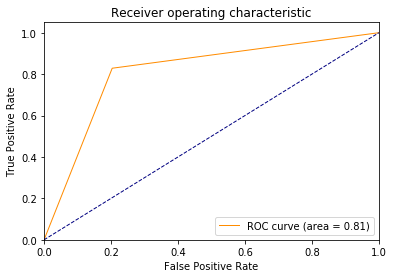

In [56]:
outcome_test = np.argmax(test_labels, 1)
predictions_test = predict_vals

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Model restored.") 
    print("Pos review ", new_pos_review)
    print("Neg review ", new_neg_review)
    print(predict_softmax(new_pos_review, vocab))
    print(predict_softmax(new_neg_review, vocab))

INFO:tensorflow:Restoring parameters from ./ch4-softmax-netflix-sentiment.ckpt
Model restored.
Pos review  I think that this is a fantastic movie, it really 
Neg review  Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!
Predict: [[0.05737301 0.94262695]]
[1]
Predict: [[9.9947983e-01 5.2014005e-04]]
[0]
